<a href="https://colab.research.google.com/github/Sarthak-source/Sarthak-source/blob/main/indus_cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Required Imports
import kagglehub
import pandas as pd
import os
import numpy as np
from collections import defaultdict
import random
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Download Dataset from Kaggle
try:
    path = kagglehub.dataset_download("storesource/im-417-150")  # Replace with correct dataset identifier
    print("Path to dataset files:", path)
except Exception as e:
    print(f"Failed to download dataset: {e}")
    path = None



100%|██████████| 1.25M/1.25M [00:00<00:00, 84.4MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/storesource/im-417-150/versions/2


Dataset shape: (416, 22500)


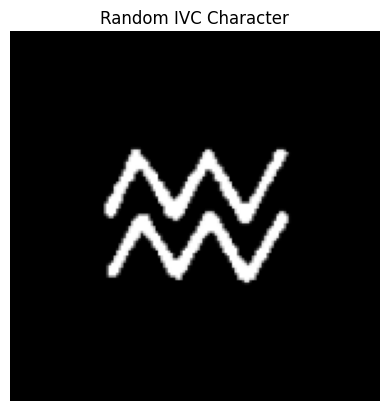

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File path for the dataset
csv_file = "/root/.cache/kagglehub/datasets/storesource/im-417-150/versions/2/im_417_150.csv"

# Load the CSV file
data = pd.read_csv(csv_file)

# Shape of the dataset
print(f"Dataset shape: {data.shape}")

# Display a random image
def display_random_image():
    # Choose a random row from the dataset
    random_row = data.sample(n=1).iloc[0]

    # Extract pixel values (assuming no label column in this dataset)
    pixel_values = random_row.values.astype(np.uint8)  # Convert to unsigned integers

    # Reshape to 150x150
    pixel_array = np.reshape(pixel_values, (150, 150))

    # Display the image
    plt.imshow(pixel_array, cmap='gray')
    plt.axis('off')
    plt.title("Random IVC Character")
    plt.show()

# Call the function to display a random image
display_random_image()




Saving 99.jpg to 99 (8).jpg
Step 1: Converting image to grayscale...
Step 2: Applying Gaussian Blur...
Step 3: Inverting grayscale...
Step 4: Applying binary thresholding...
Step 5: Applying morphological operations...
Step 6: Finding contours...
Total contours found: 3
Step 7: Extracting and resizing each contour...
Contour 1: Bounding box (x=0, y=0, w=518, h=190)
Processing Segment 1...


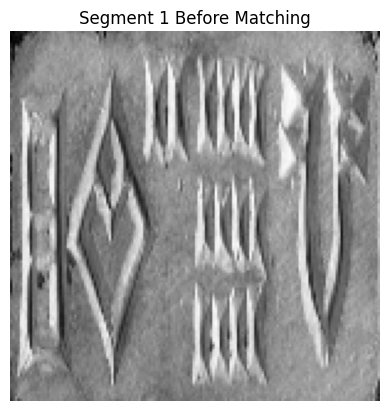

Segment 1: Best match at index 83 with SSIM = 0.0127


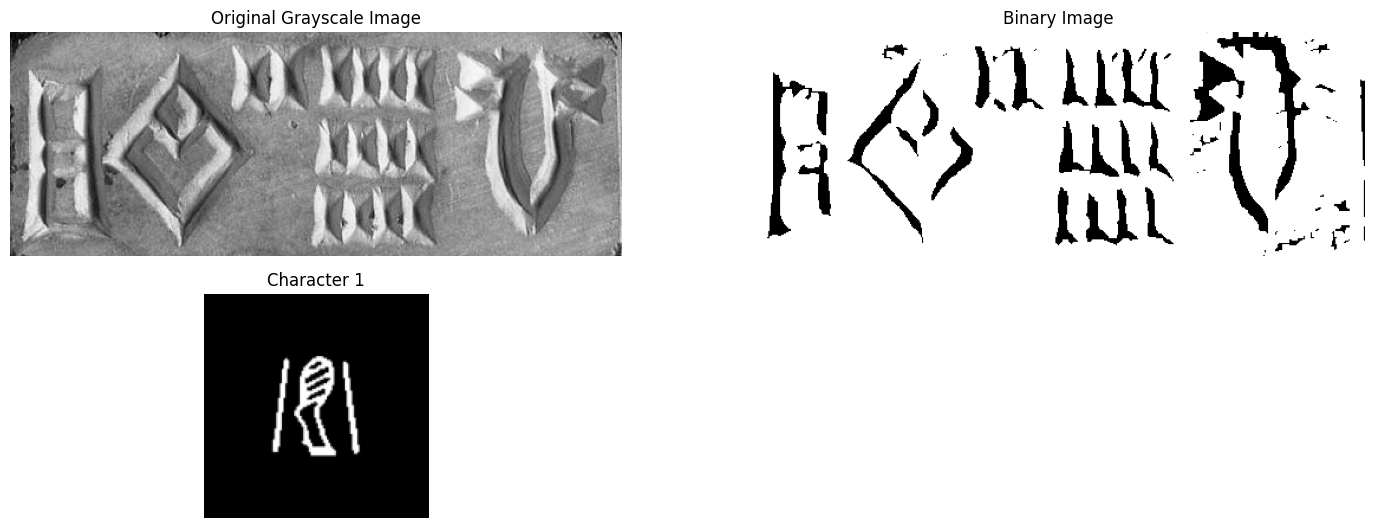

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab import files
from PIL import Image
from skimage.metrics import structural_similarity as ssim

# Function to preprocess the uploaded image
def preprocess_image(image, min_width=20, min_height=20):
    """
    Preprocess the image to isolate individual characters for Indus script (left-to-right).
    """
    print("Step 1: Converting image to grayscale...")
    gray_image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)

    print("Step 2: Applying Gaussian Blur...")
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    print("Step 3: Inverting grayscale...")
    # Invert grayscale to make characters white on black
    inverted_image = 255 - blurred_image

    print("Step 4: Applying binary thresholding...")
    _, binary_image = cv2.threshold(
        inverted_image, 128, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    print("Step 5: Applying morphological operations...")
    # Morphological operations to remove noise and separate characters
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    eroded_image = cv2.erode(binary_image, kernel, iterations=1)
    dilated_image = cv2.dilate(eroded_image, kernel, iterations=2)

    print("Step 6: Finding contours...")
    contours, _ = cv2.findContours(
        dilated_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    print(f"Total contours found: {len(contours)}")

    print("Step 7: Extracting and resizing each contour...")
    sorted_contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])
    segments = []

    for i, contour in enumerate(sorted_contours):
        x, y, w, h = cv2.boundingRect(contour)

        # Filter out small contours (noise)
        if w >= min_width and h >= min_height:
            char_image = gray_image[y : y + h, x : x + w]

            # Resize each character to 150x150
            resized_char = cv2.resize(char_image, (150, 150))
            segments.append(resized_char)

            print(f"Contour {i+1}: Bounding box (x={x}, y={y}, w={w}, h={h})")

    return gray_image, dilated_image, segments



# Function to match each character segment with the closest character in the dataset
def find_best_match(segment, dataset):
    """
    Compare the segment with each row in the dataset and return the best match.
    """
    best_match_index = None
    best_ssim_value = -1  # SSIM ranges from -1 to 1

    for i, row in dataset.iterrows():
        dataset_character = row.values.astype(np.uint8).reshape((150, 150))
        ssim_value = ssim(segment, dataset_character)

        if ssim_value > best_ssim_value:
            best_ssim_value = ssim_value
            best_match_index = i

    return best_match_index, best_ssim_value

# Upload image
uploaded = files.upload()

# Get the uploaded file path
image_path = list(uploaded.keys())[0]

# Load the image using PIL
image = Image.open(image_path)

# Preprocess the uploaded image to extract segments
gray_image, binary_image, segments = preprocess_image(image)

# Match each segment with the best match in the dataset
reconstructed_characters = []
for i, segment in enumerate(segments):
    print(f"Processing Segment {i+1}...")
    plt.figure()
    plt.imshow(segment, cmap='gray')
    plt.title(f"Segment {i+1} Before Matching")
    plt.axis('off')
    plt.show()

    match_index, match_ssim = find_best_match(segment, data)
    print(f"Segment {i+1}: Best match at index {match_index} with SSIM = {match_ssim:.4f}")
    reconstructed_characters.append(data.iloc[match_index].values.astype(np.uint8).reshape((150, 150)))

# Visualize the original image, binary image, and the reconstructed characters
plt.figure(figsize=(15, 8))

# Display the original grayscale image
plt.subplot(3, len(segments)+1, 1)
plt.imshow(gray_image, cmap='gray')
plt.axis('off')
plt.title("Original Grayscale Image")

# Display the binary image
plt.subplot(3, len(segments)+1, 2)
plt.imshow(binary_image, cmap='gray')
plt.axis('off')
plt.title("Binary Image")

# Display the reconstructed characters
for i, char in enumerate(reconstructed_characters):
    plt.subplot(3, len(segments)+1, len(segments)+1 + i + 1)
    plt.imshow(char, cmap='gray')
    plt.axis('off')
    plt.title(f"Character {i+1}")

plt.tight_layout()
plt.show()




/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


Heatmap saved as 'optimized_heatmap.png'.


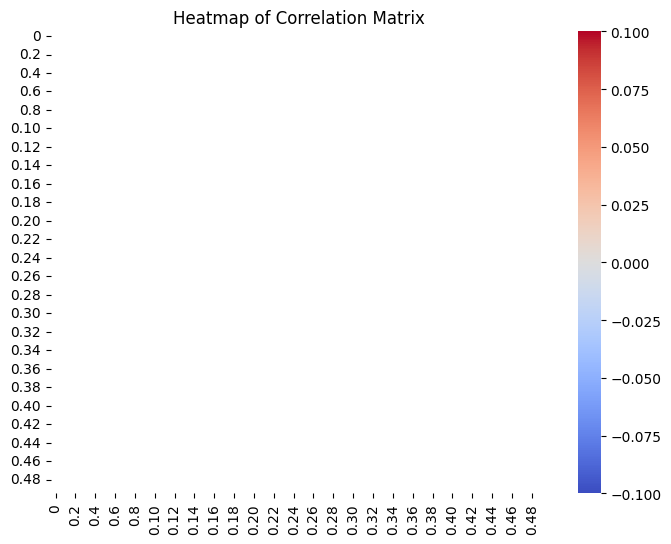

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame
# Sample or limit the data to a smaller subset if it's large
small_data = data  # Use the first 50 columns (adjust as needed)

# Compute the correlation matrix
correlation_matrix = small_data.corr()

# Reduce the figure size for better performance
plt.figure(figsize=(8, 6))

# Plot the heatmap without annotations for faster rendering
sns.heatmap(correlation_matrix, fmt=".2f", cmap="coolwarm", cbar=True)

# Save the heatmap to a file instead of showing it (to avoid crashing)
plt.title("Heatmap of Correlation Matrix")
plt.savefig("optimized_heatmap.png")

# Optional: Display a success message
print("Heatmap saved as 'optimized_heatmap.png'.")


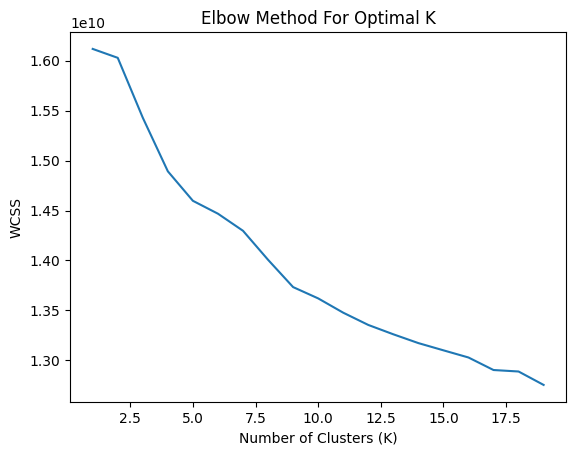

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Calculate WCSS (Within-cluster sum of squares) for different K values
wcss = []
# Changed the loop range to stop at num_samples
for k in range(1, 20):  # Use data.shape[0] to get the number of samples
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)

# Plot WCSS to visualize the elbow
plt.plot(range(1, 20), wcss)
plt.title('Elbow Method For Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.show()

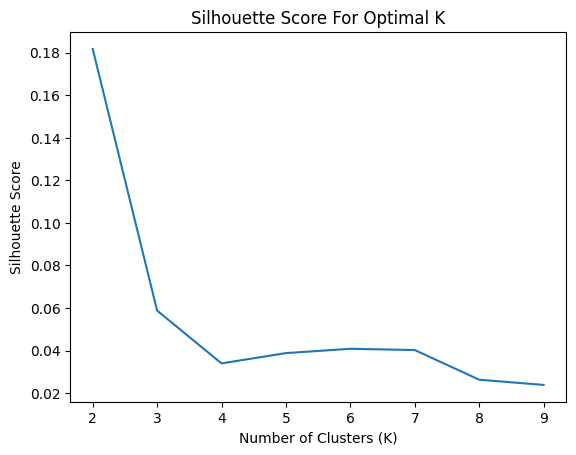

In [ ]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(2, 10):  # Start from 2 since silhouette score isn't defined for K=1
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(data)
    silhouette_scores.append(silhouette_score(data, labels))

plt.plot(range(2, 10), silhouette_scores)
plt.title('Silhouette Score For Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly.graph_objects as go

# Assuming `data` is your dataset and `data` is a DataFrame without a label column

# Perform KMeans clustering
kmeans = KMeans(n_clusters=80, random_state=0).fit(data)
cluster_assignments = kmeans.labels_

# Reduce dimensions to 3D using PCA
pca = PCA(n_components=3)
data_3d = pca.fit_transform(data)

# Create a DataFrame for easier handling
visualization_df = pd.DataFrame(data_3d, columns=["x", "y", "z"])
visualization_df['cluster'] = cluster_assignments

# Prepare the 3D scatter plot
fig = go.Figure()

# Add points to the scatter plot
for cluster_num in range(10):
    cluster_data = visualization_df[visualization_df['cluster'] == cluster_num]
    fig.add_trace(go.Scatter3d(
        x=cluster_data['x'],
        y=cluster_data['y'],
        z=cluster_data['z'],
        mode='markers',
        marker=dict(size=5),
        name=f"Cluster {cluster_num}"
    ))

# Add representative images as hover text
centroids_3d = pca.transform(kmeans.cluster_centers_)
for cluster_num, (cx, cy, cz) in enumerate(centroids_3d):
    # Get a representative image for the cluster
    cluster_indices = np.where(cluster_assignments == cluster_num)[0]
    sample_image = data.iloc[cluster_indices[0]].values.astype(np.uint8)
    sample_image_reshaped = np.reshape(sample_image, (150, 150))

    # Save the image temporarily
    image_path = f"cluster_{cluster_num}.png"
    plt.imsave(image_path, sample_image_reshaped, cmap='gray')

    # Add hover text to represent the image
    hover_text = f"<b>Cluster {cluster_num}</b><br><img src='{image_path}' style='width:100px;height:100px;'>"

    fig.add_trace(go.Scatter3d(
        x=[cx], y=[cy], z=[cz],
        mode='markers+text',
        marker=dict(size=15, color='red'),
        text=[f"Cluster {cluster_num}"],
        hovertext=hover_text,  # Hover text with the image
        hoverinfo="text"
    ))

# Customize the layout
fig.update_layout(
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    title="3D Visualization of Clusters with Representative Images (Hover Text)"
)

# Show the plot
fig.show()



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but PCA was fitted with feature names



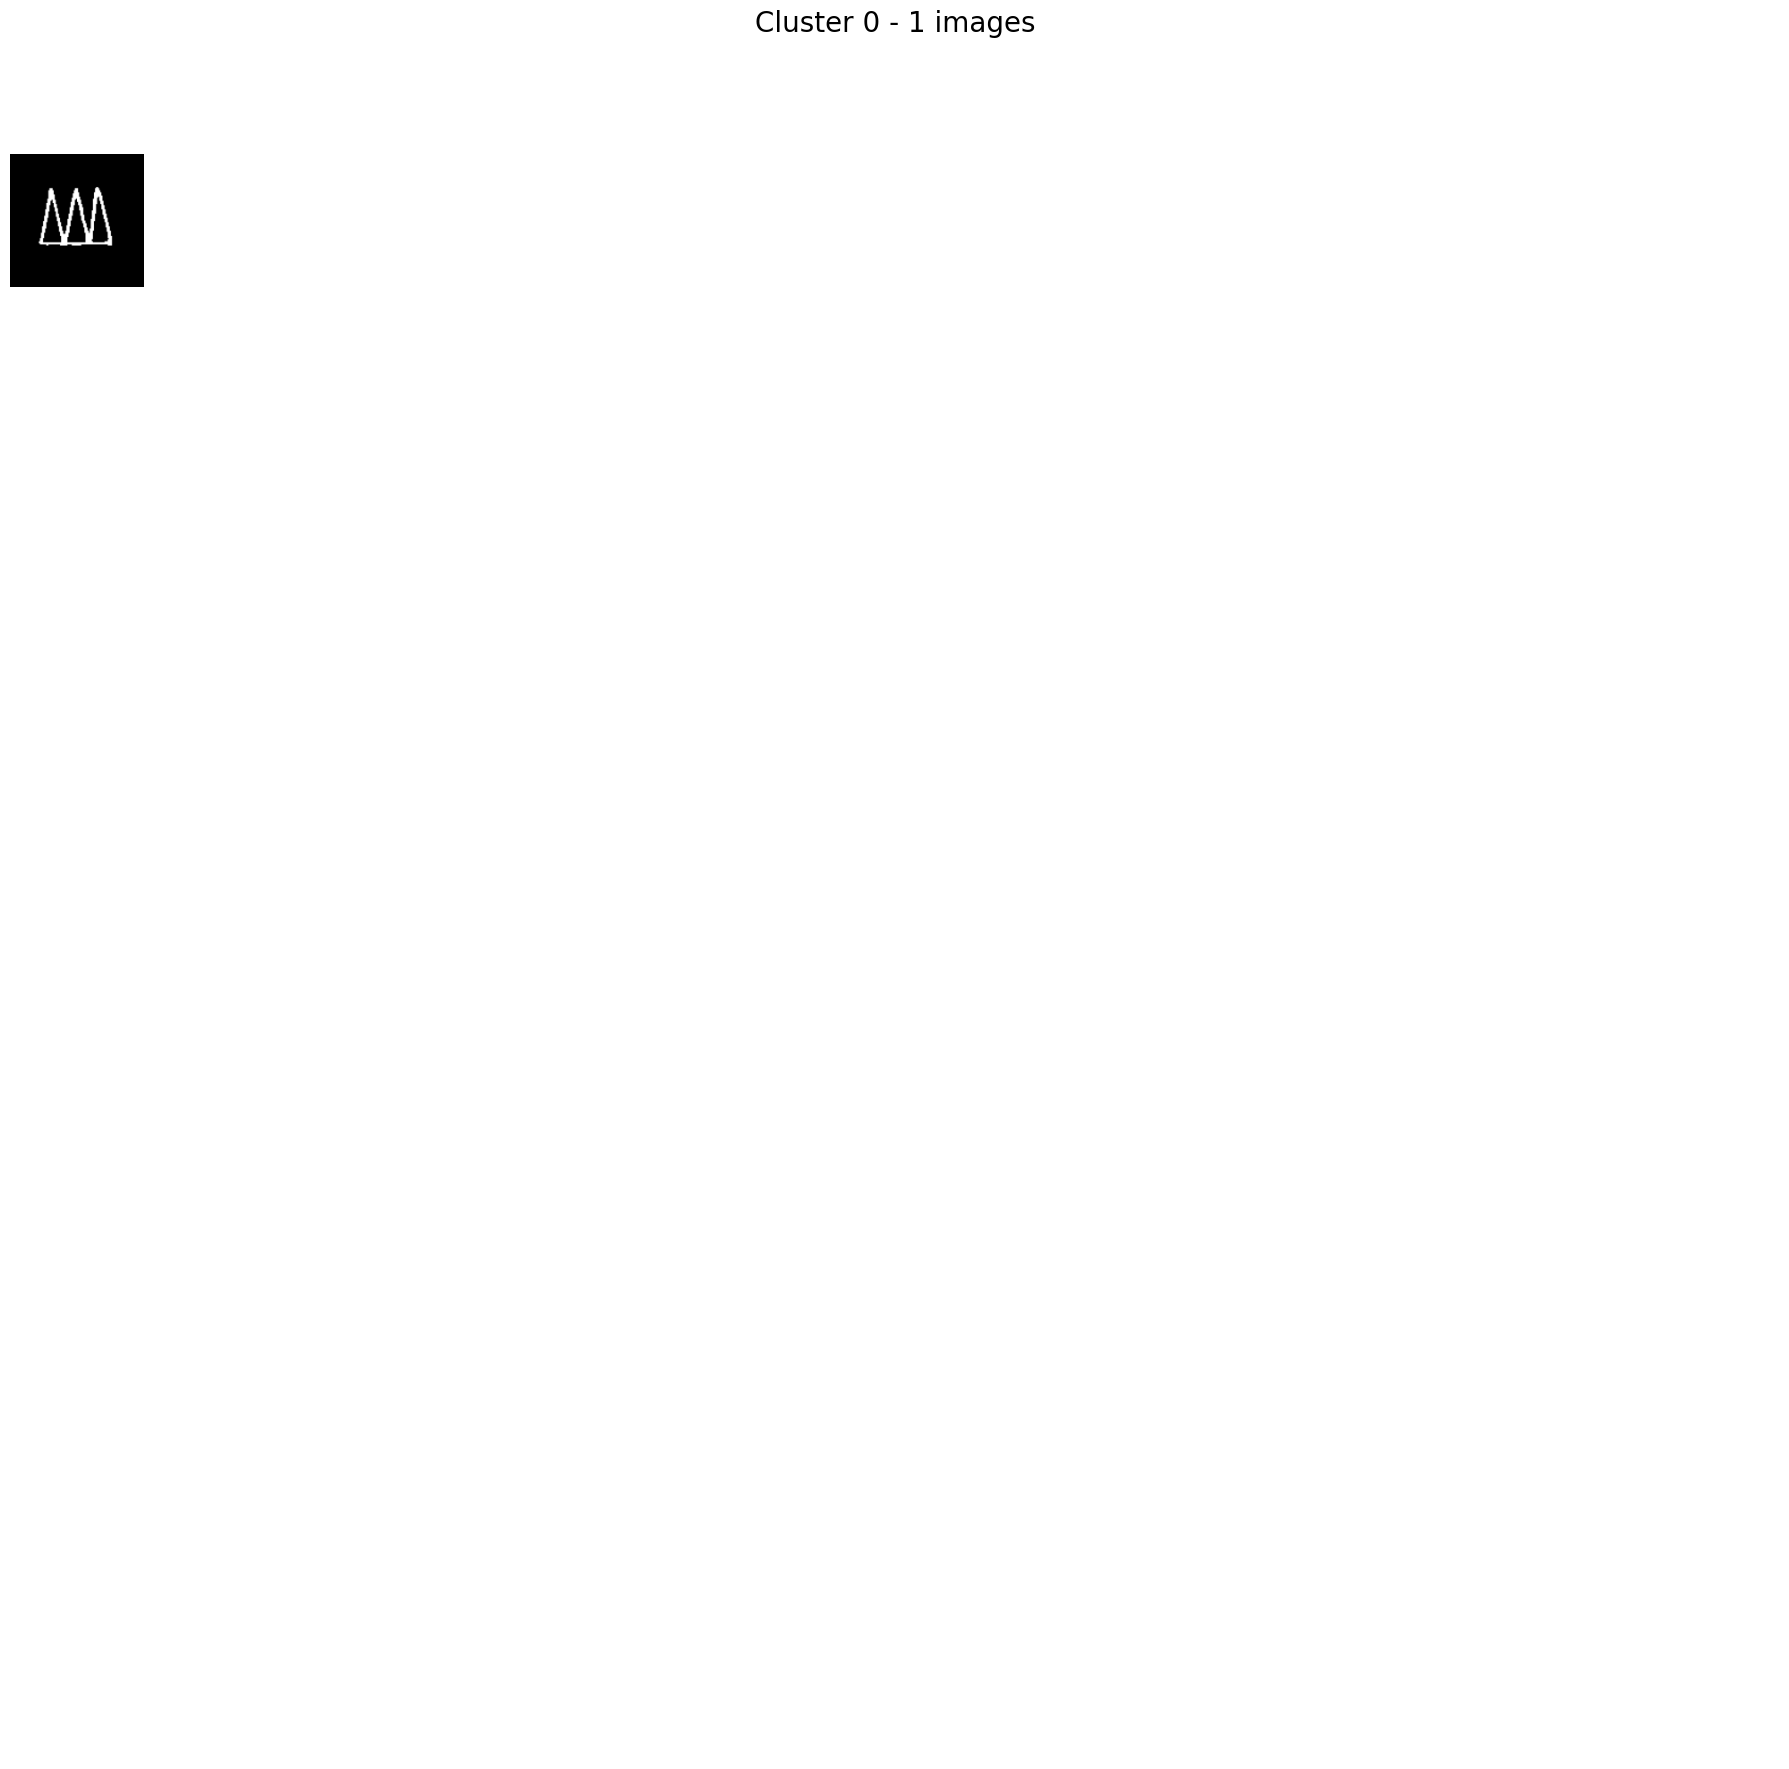

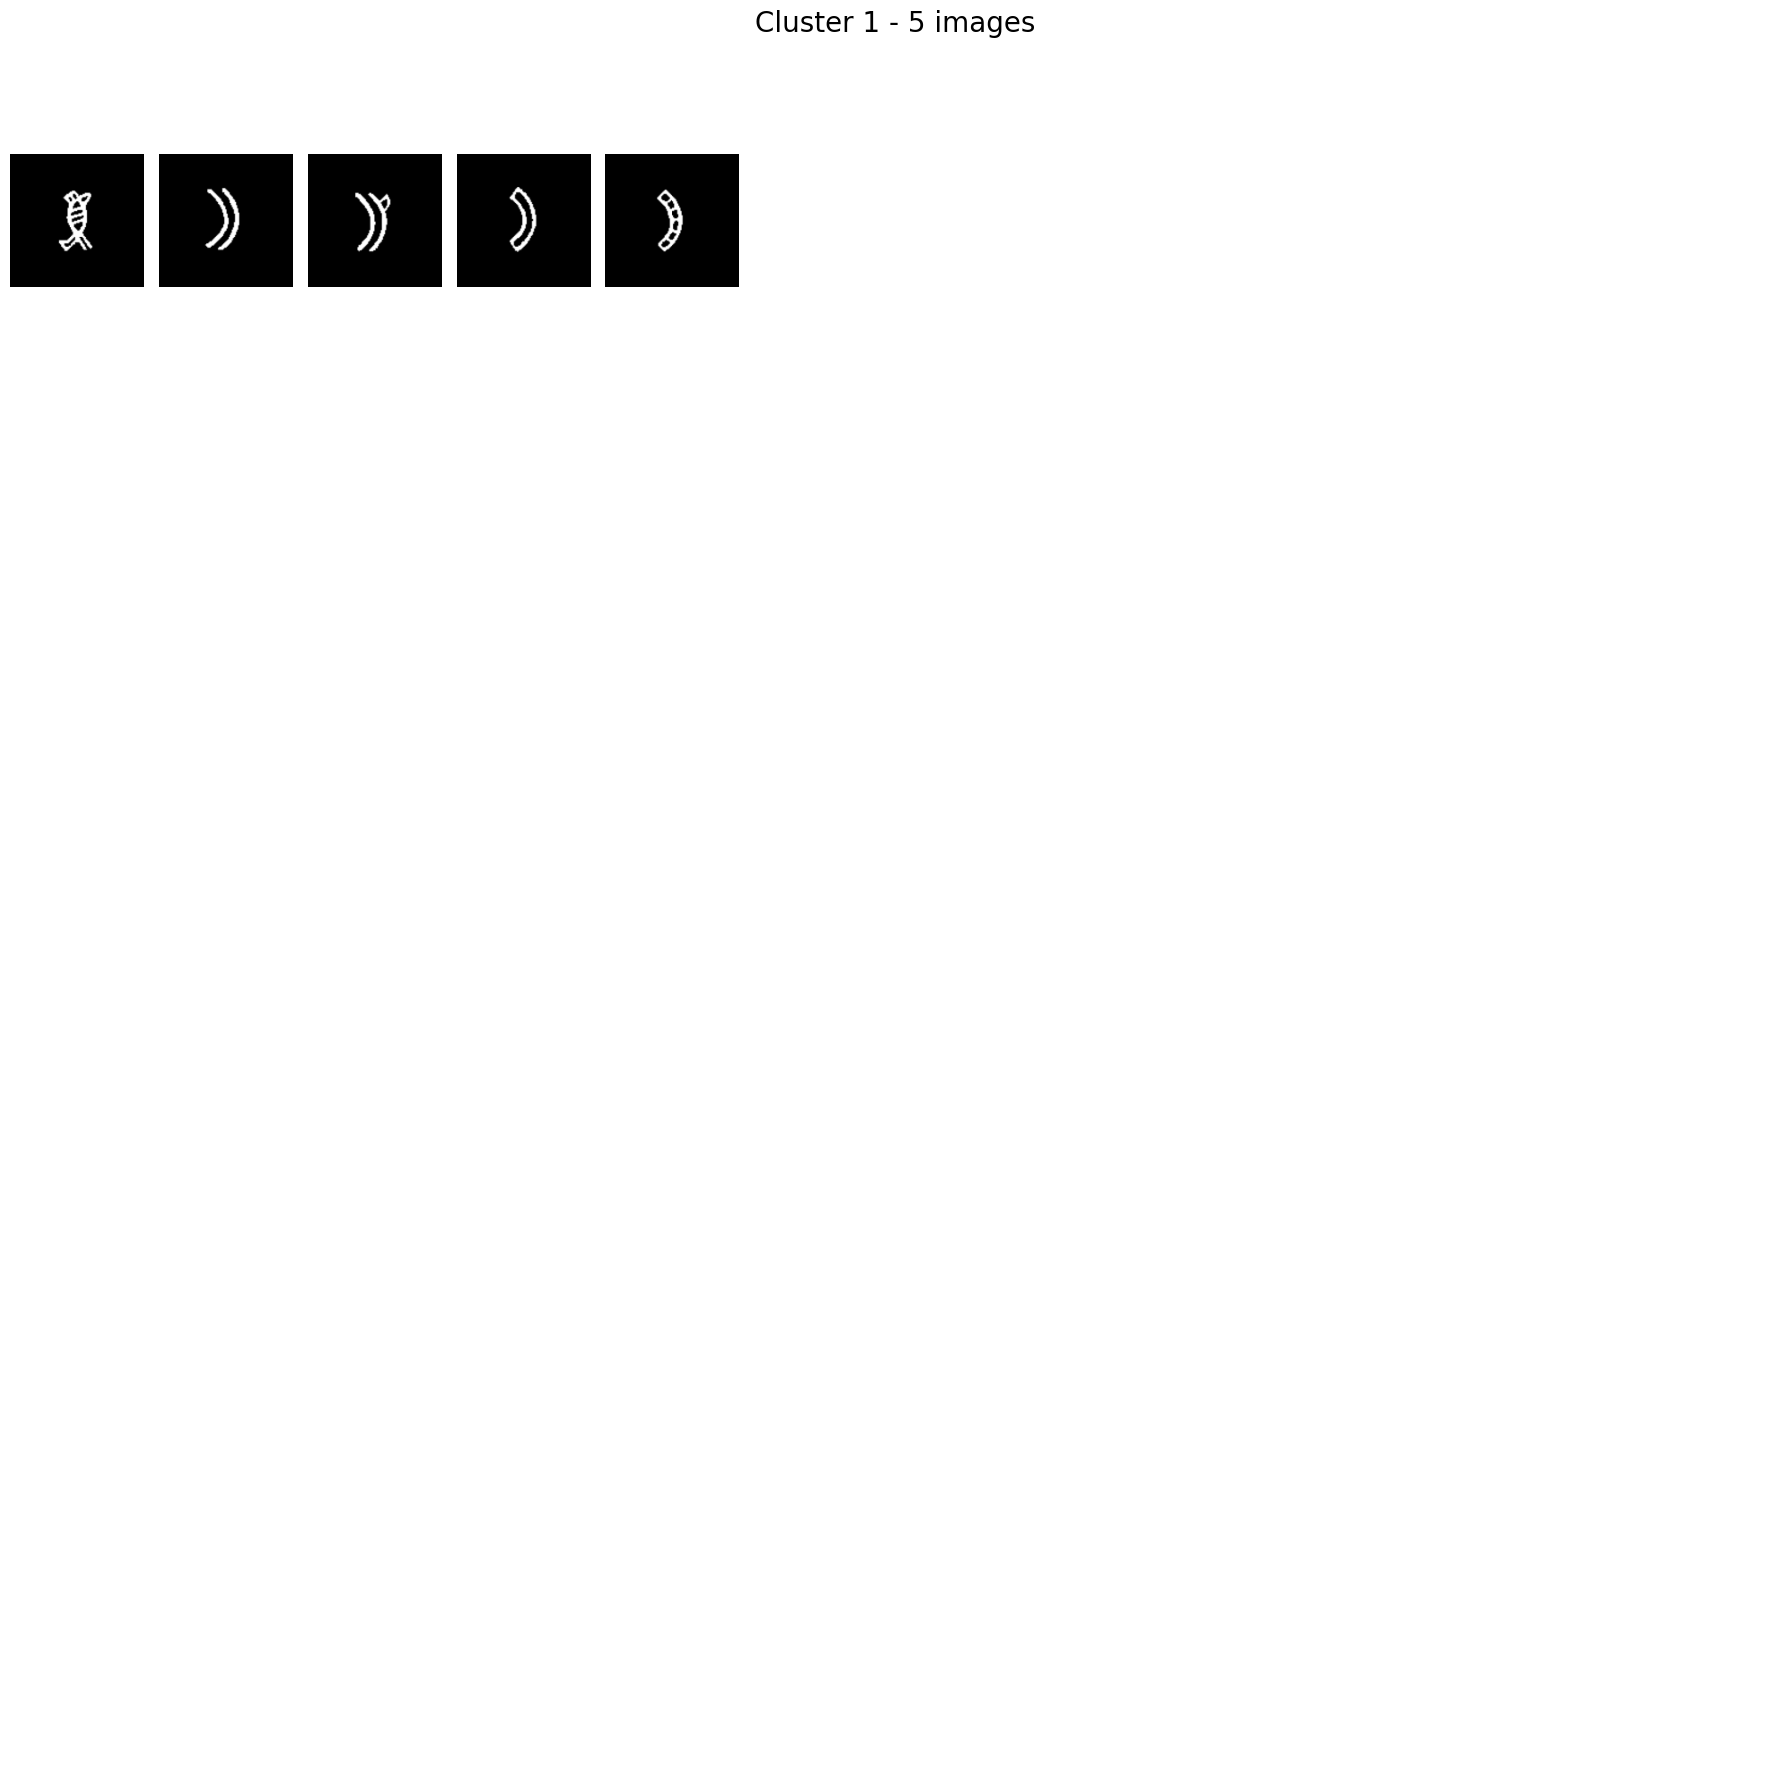

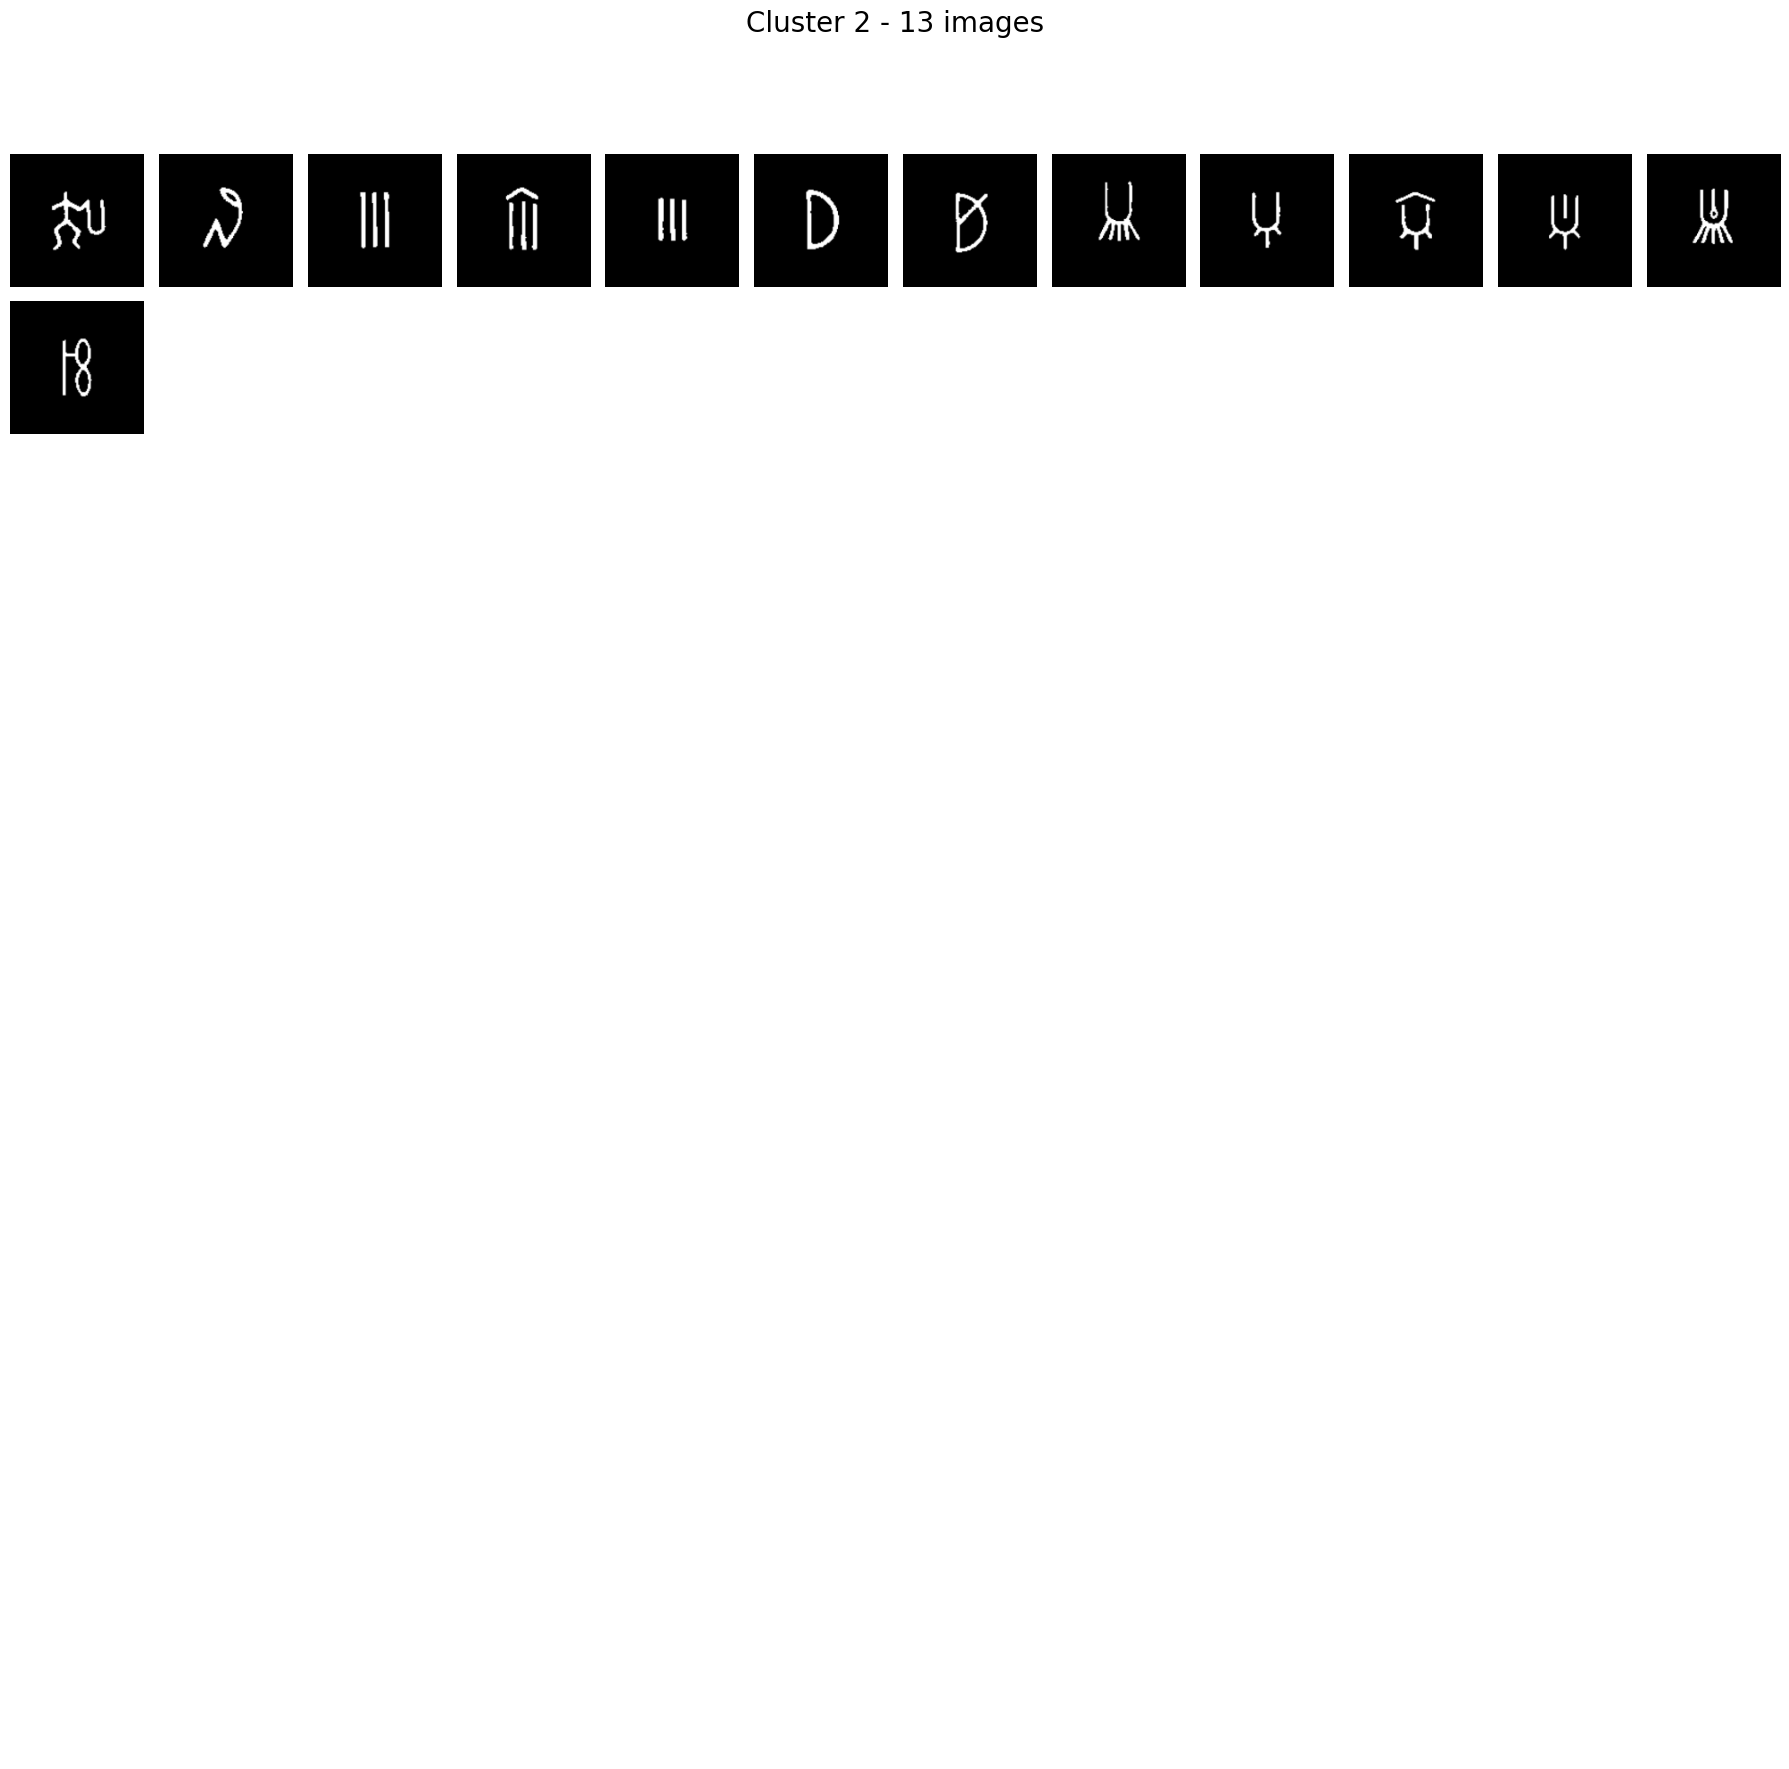

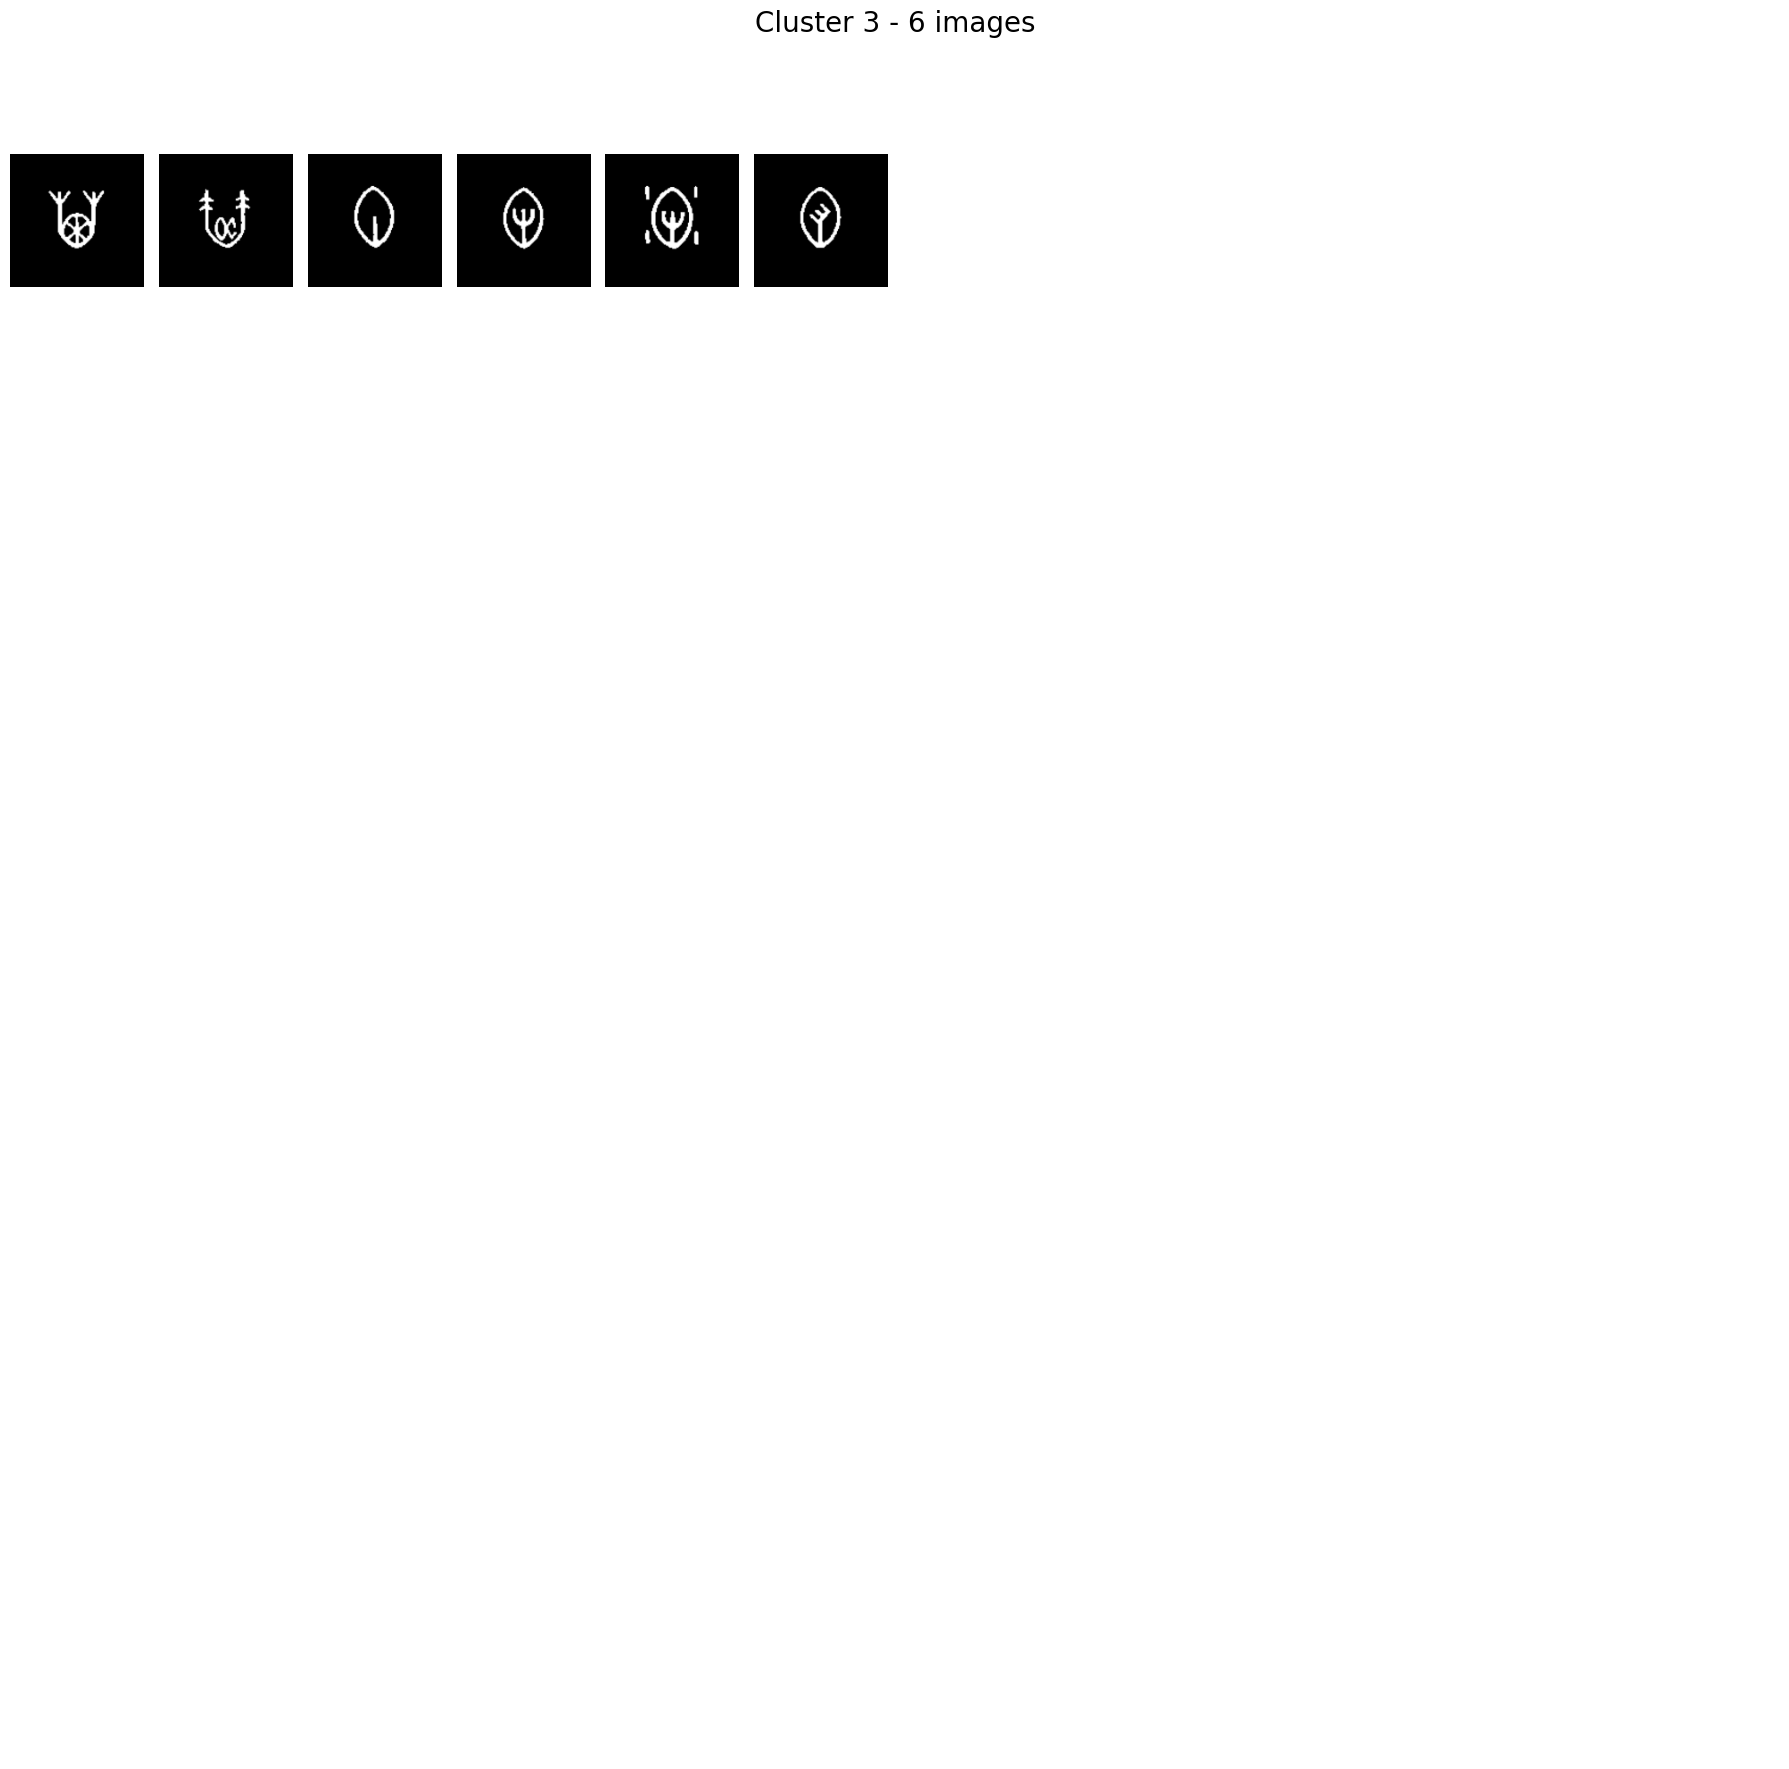

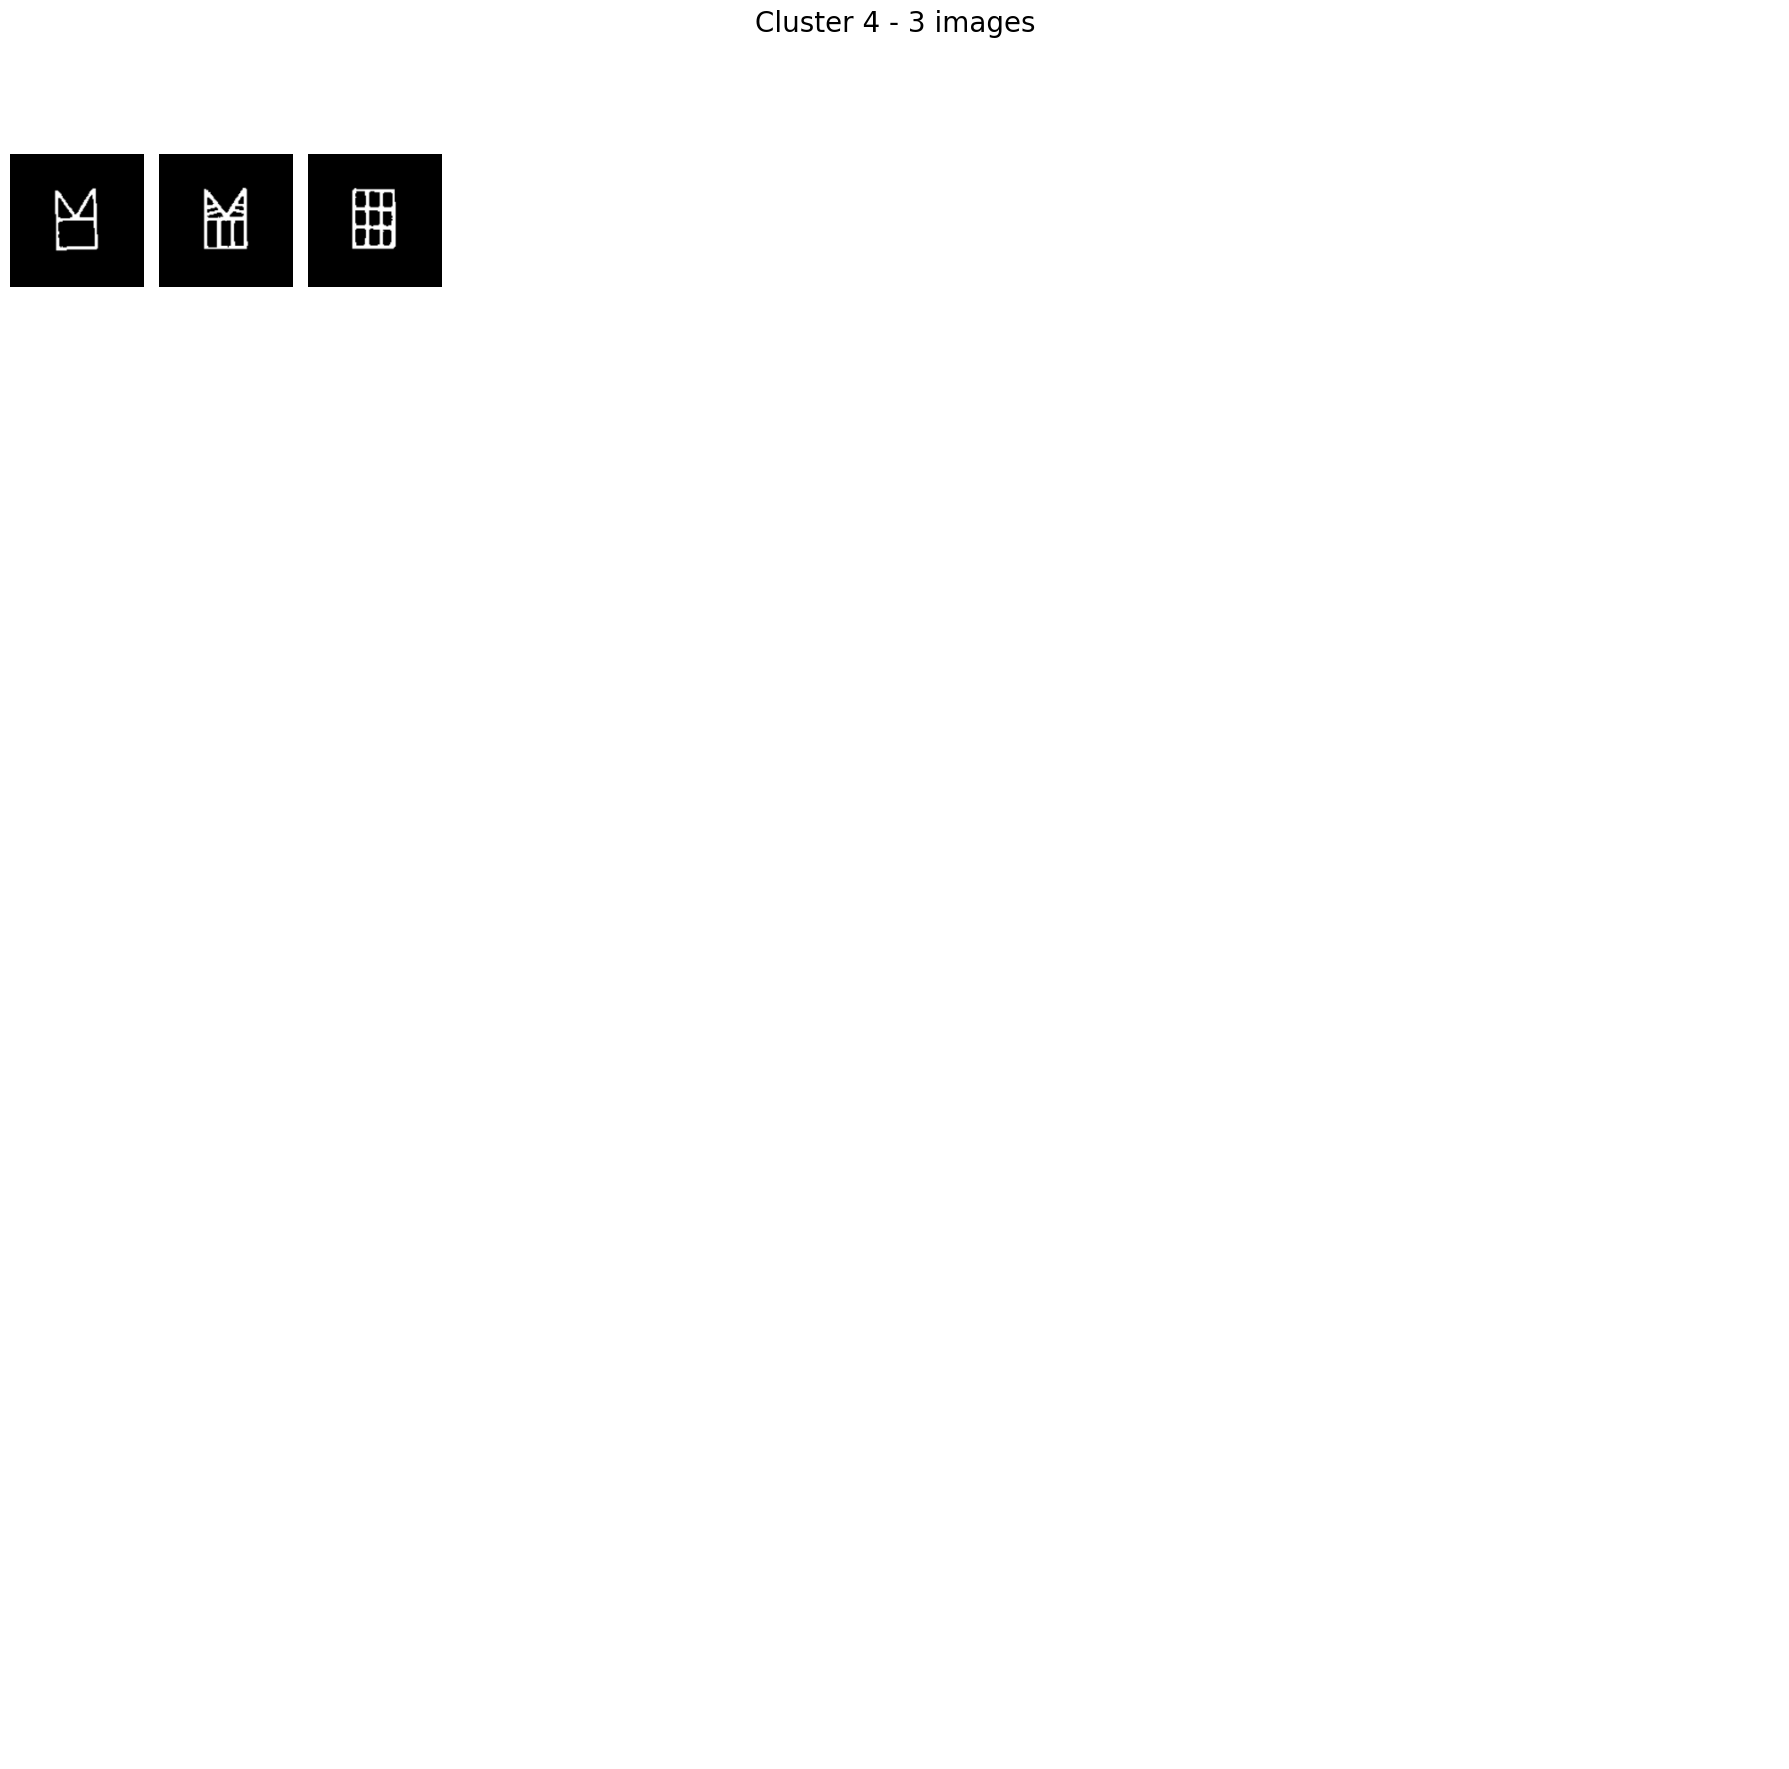

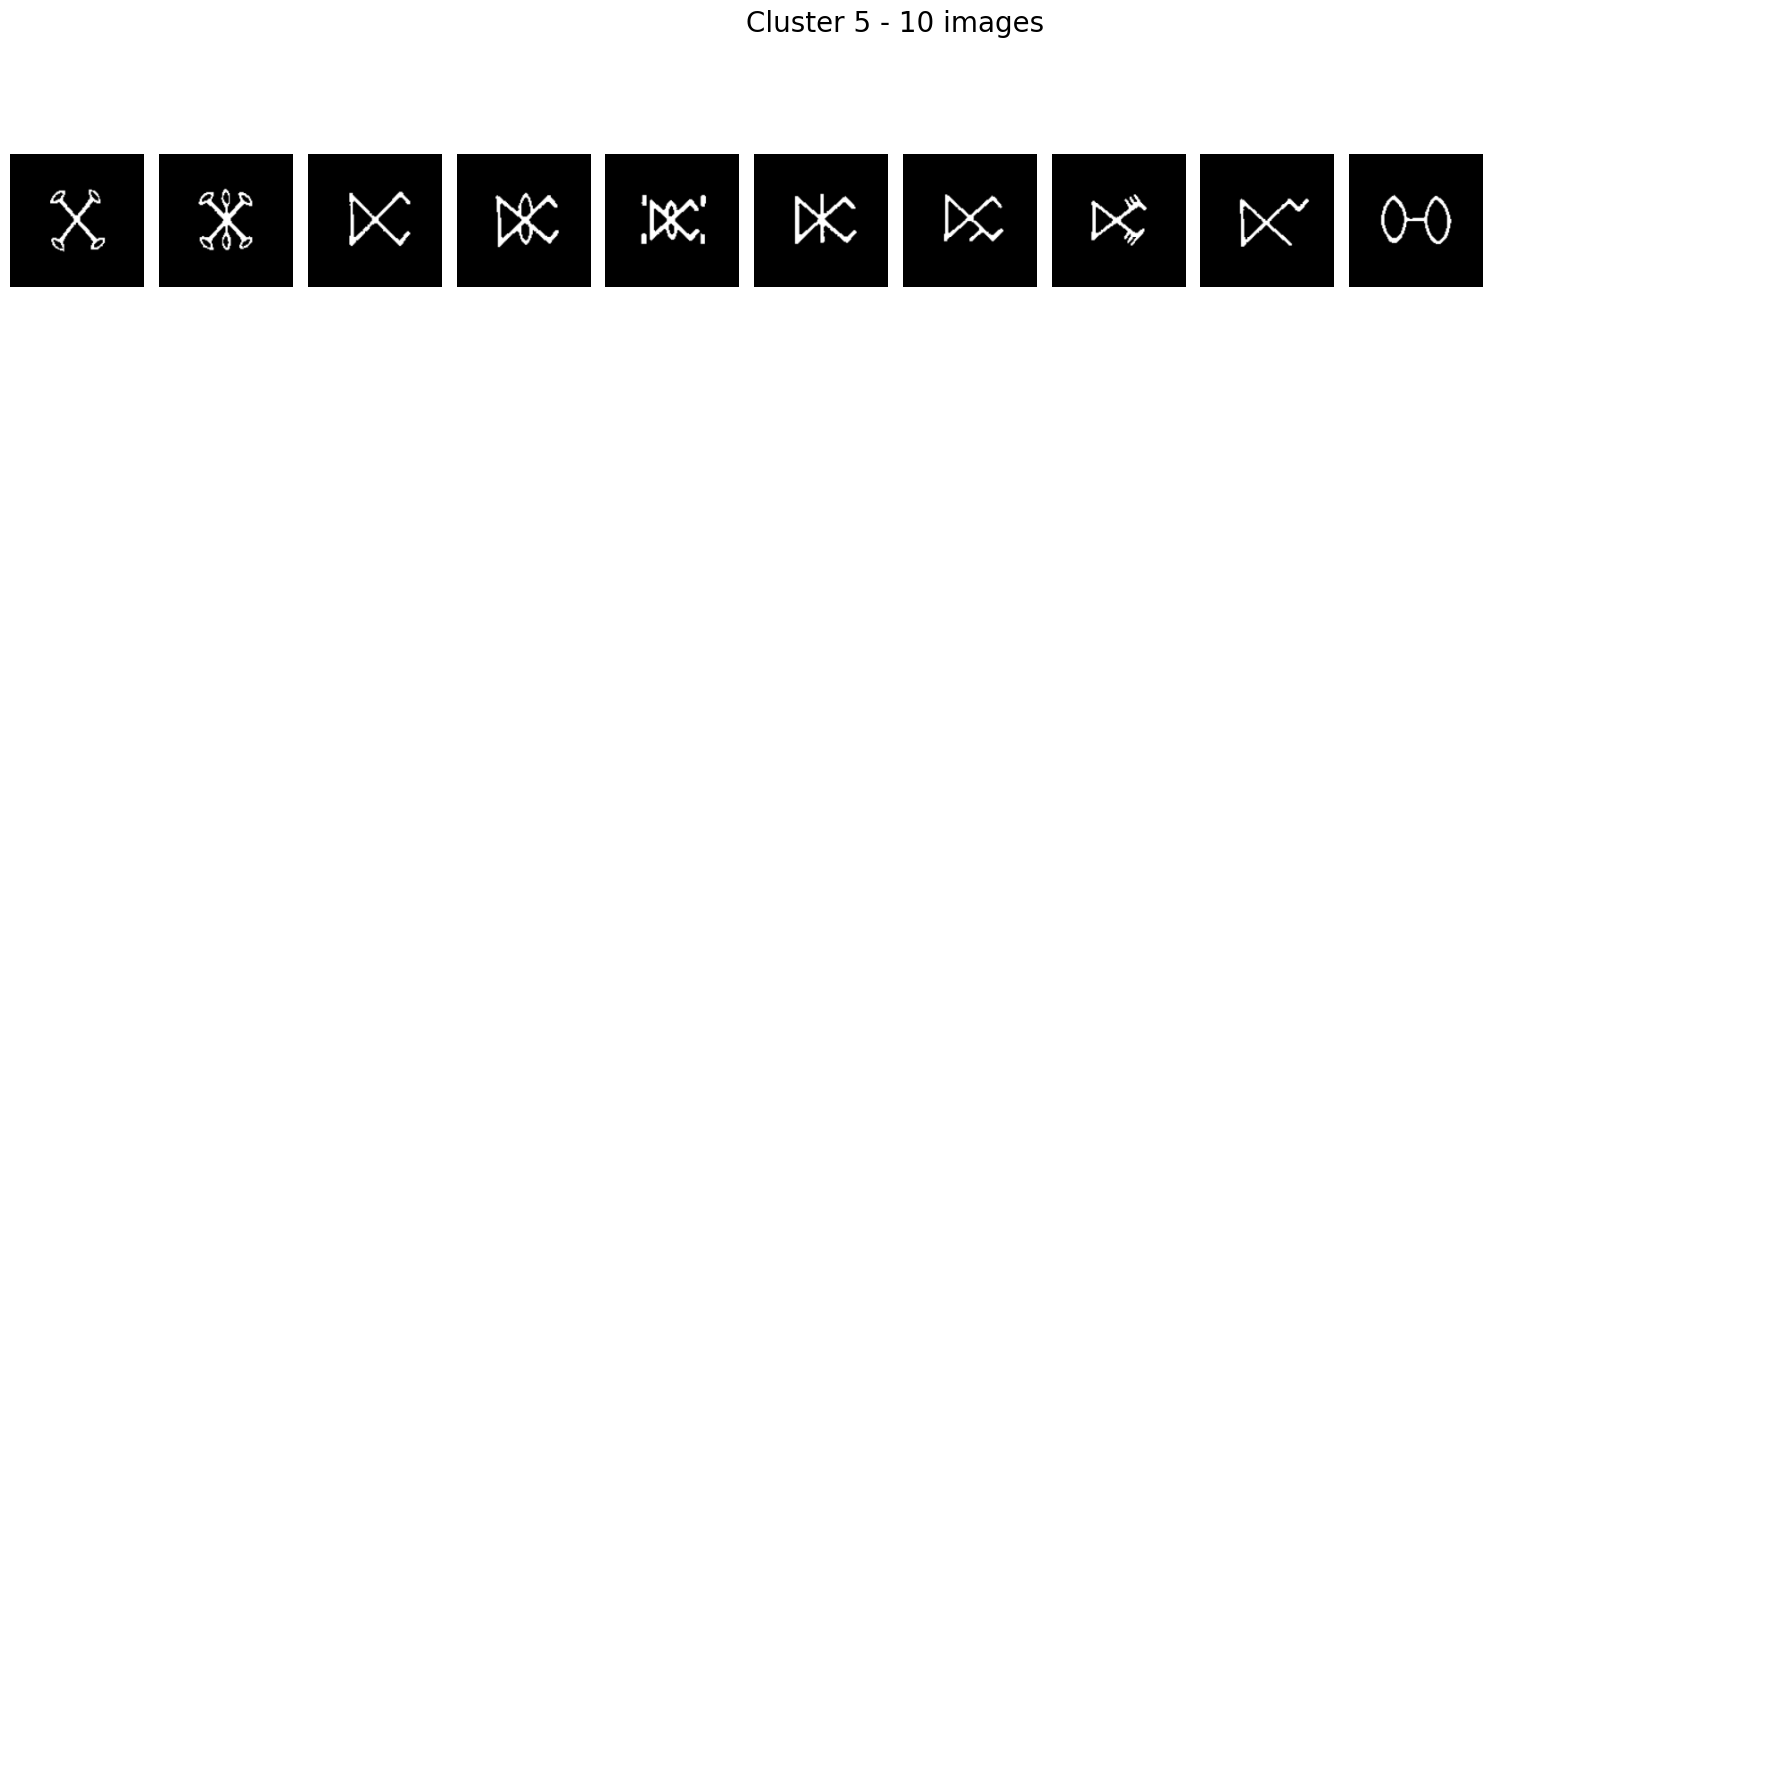

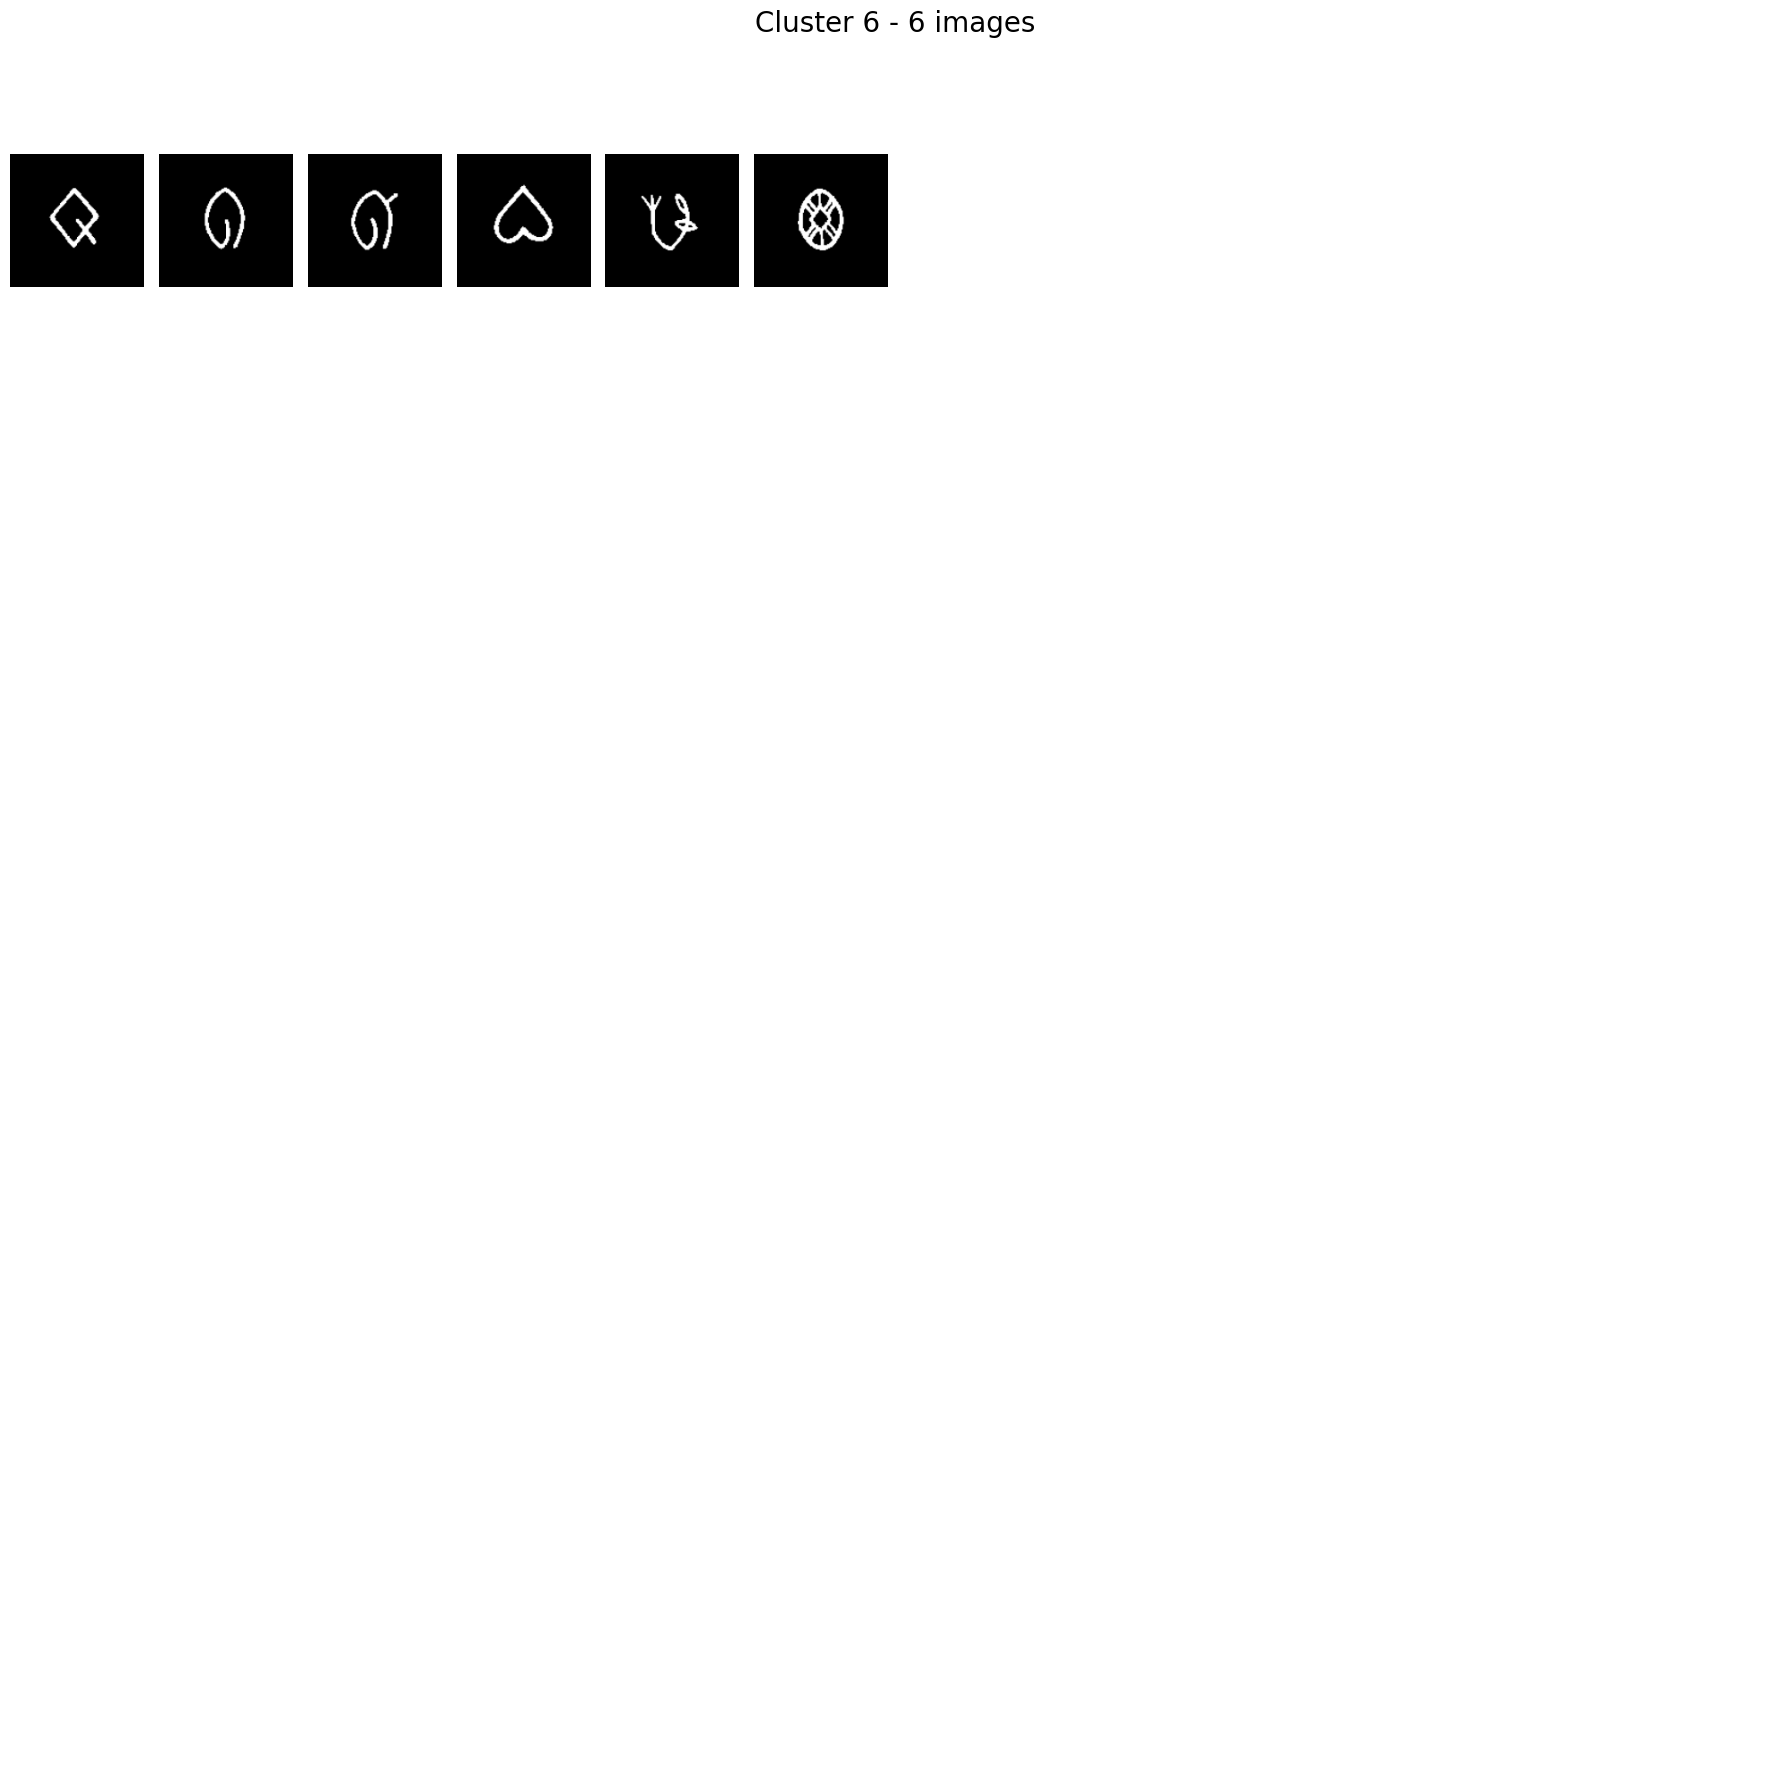

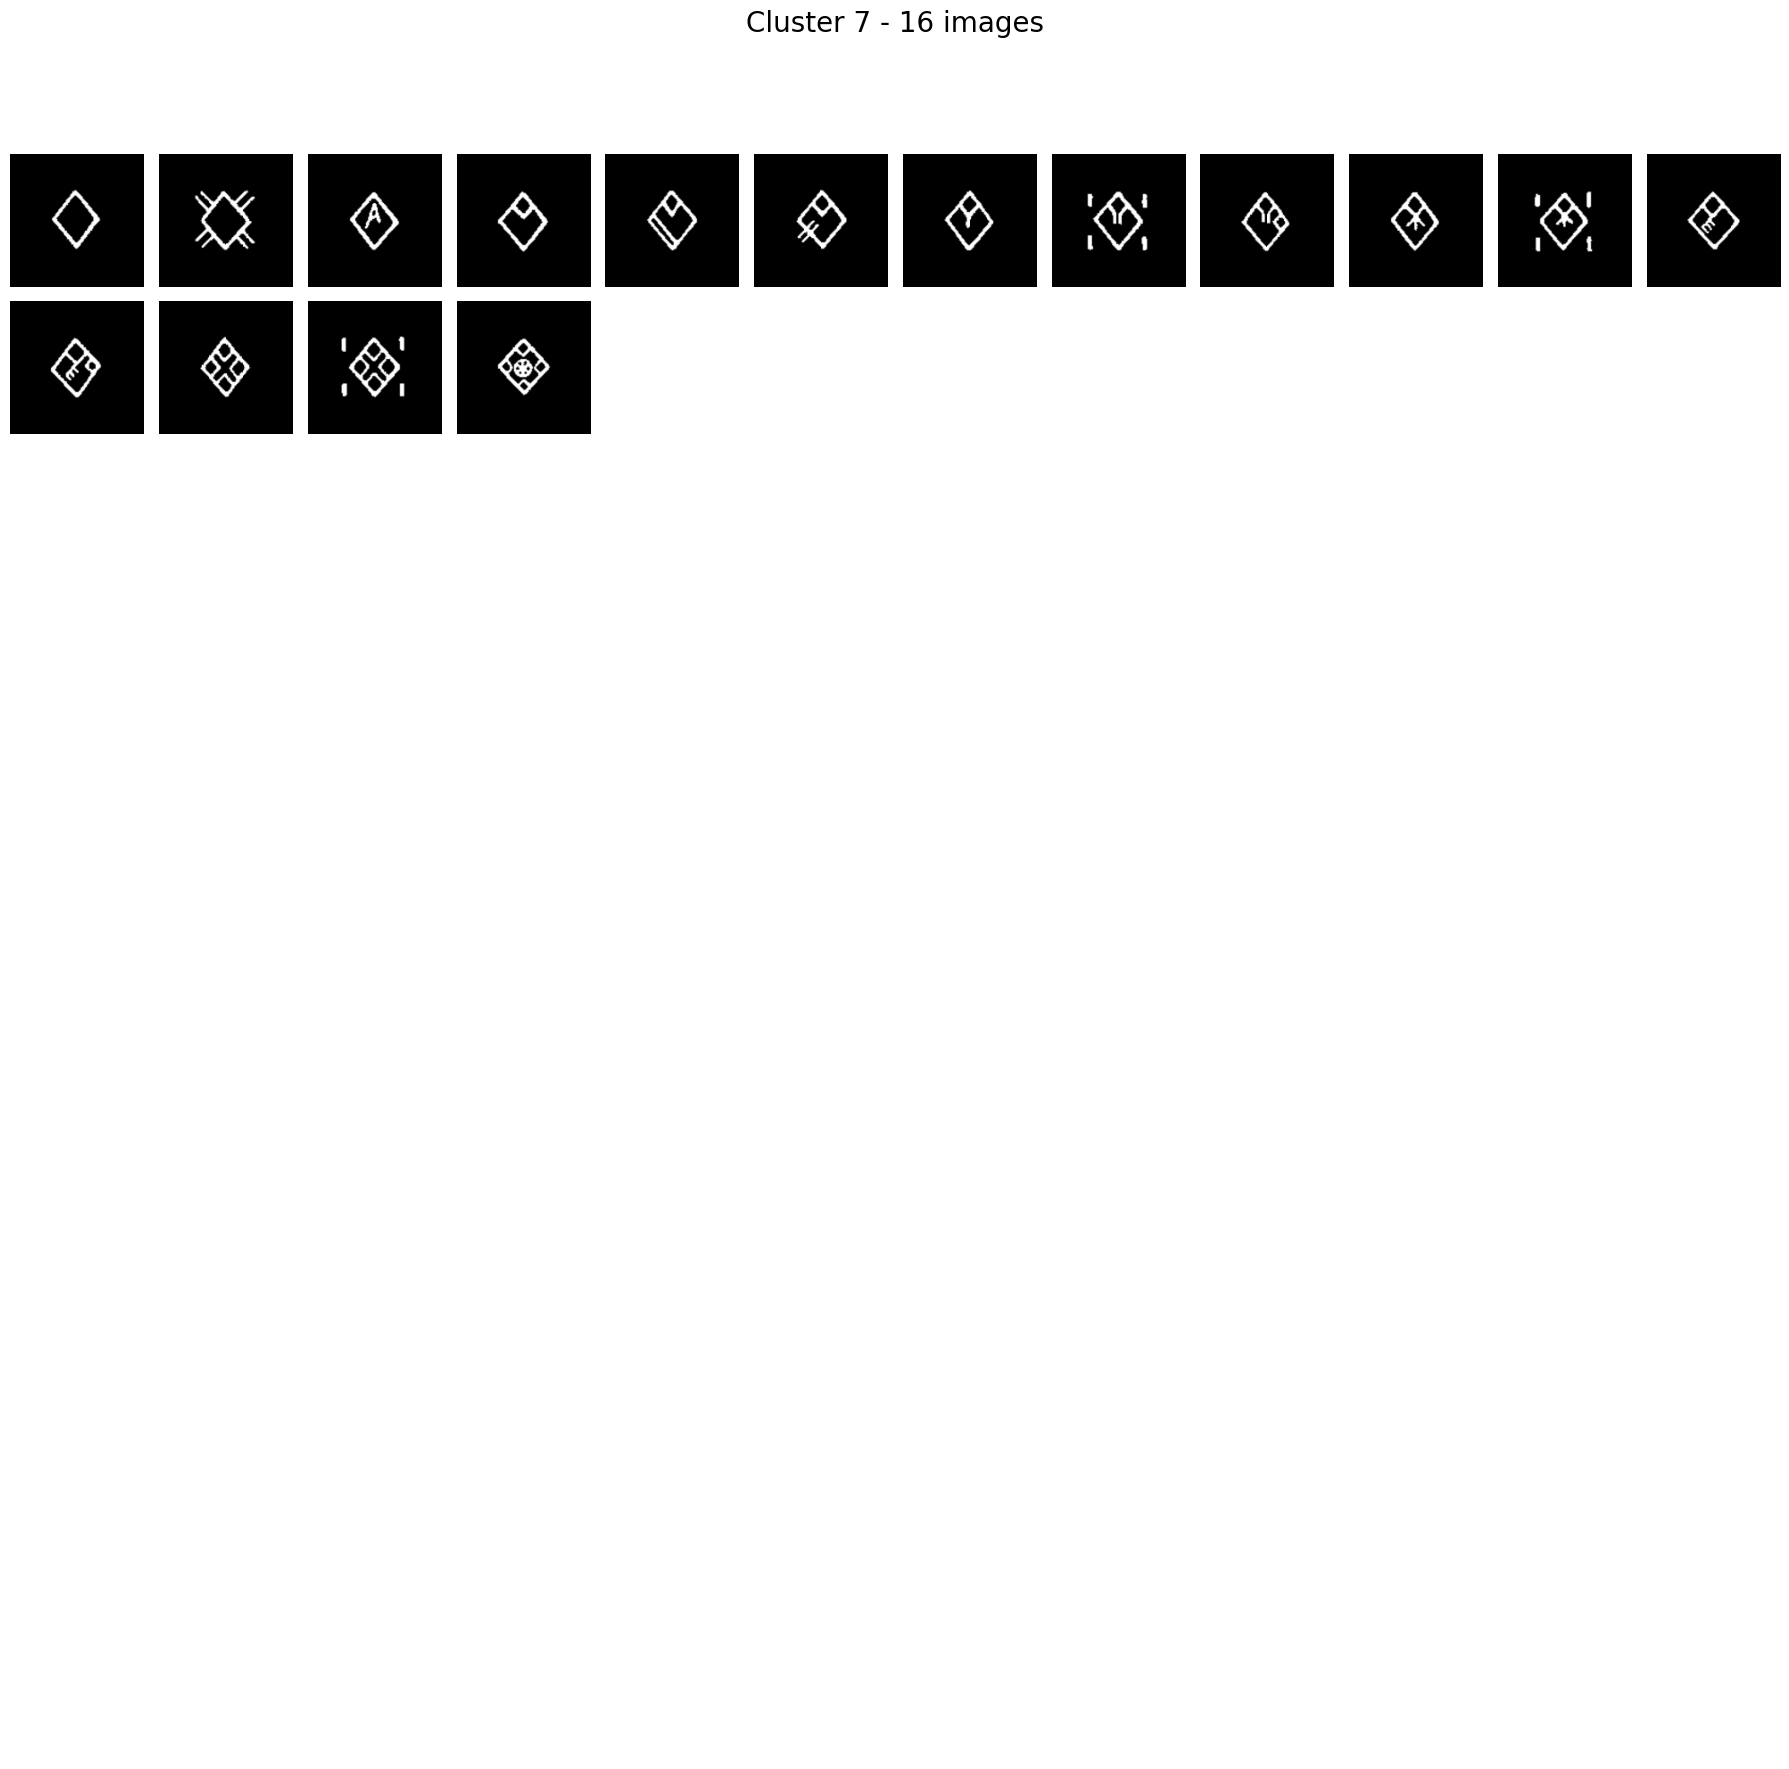

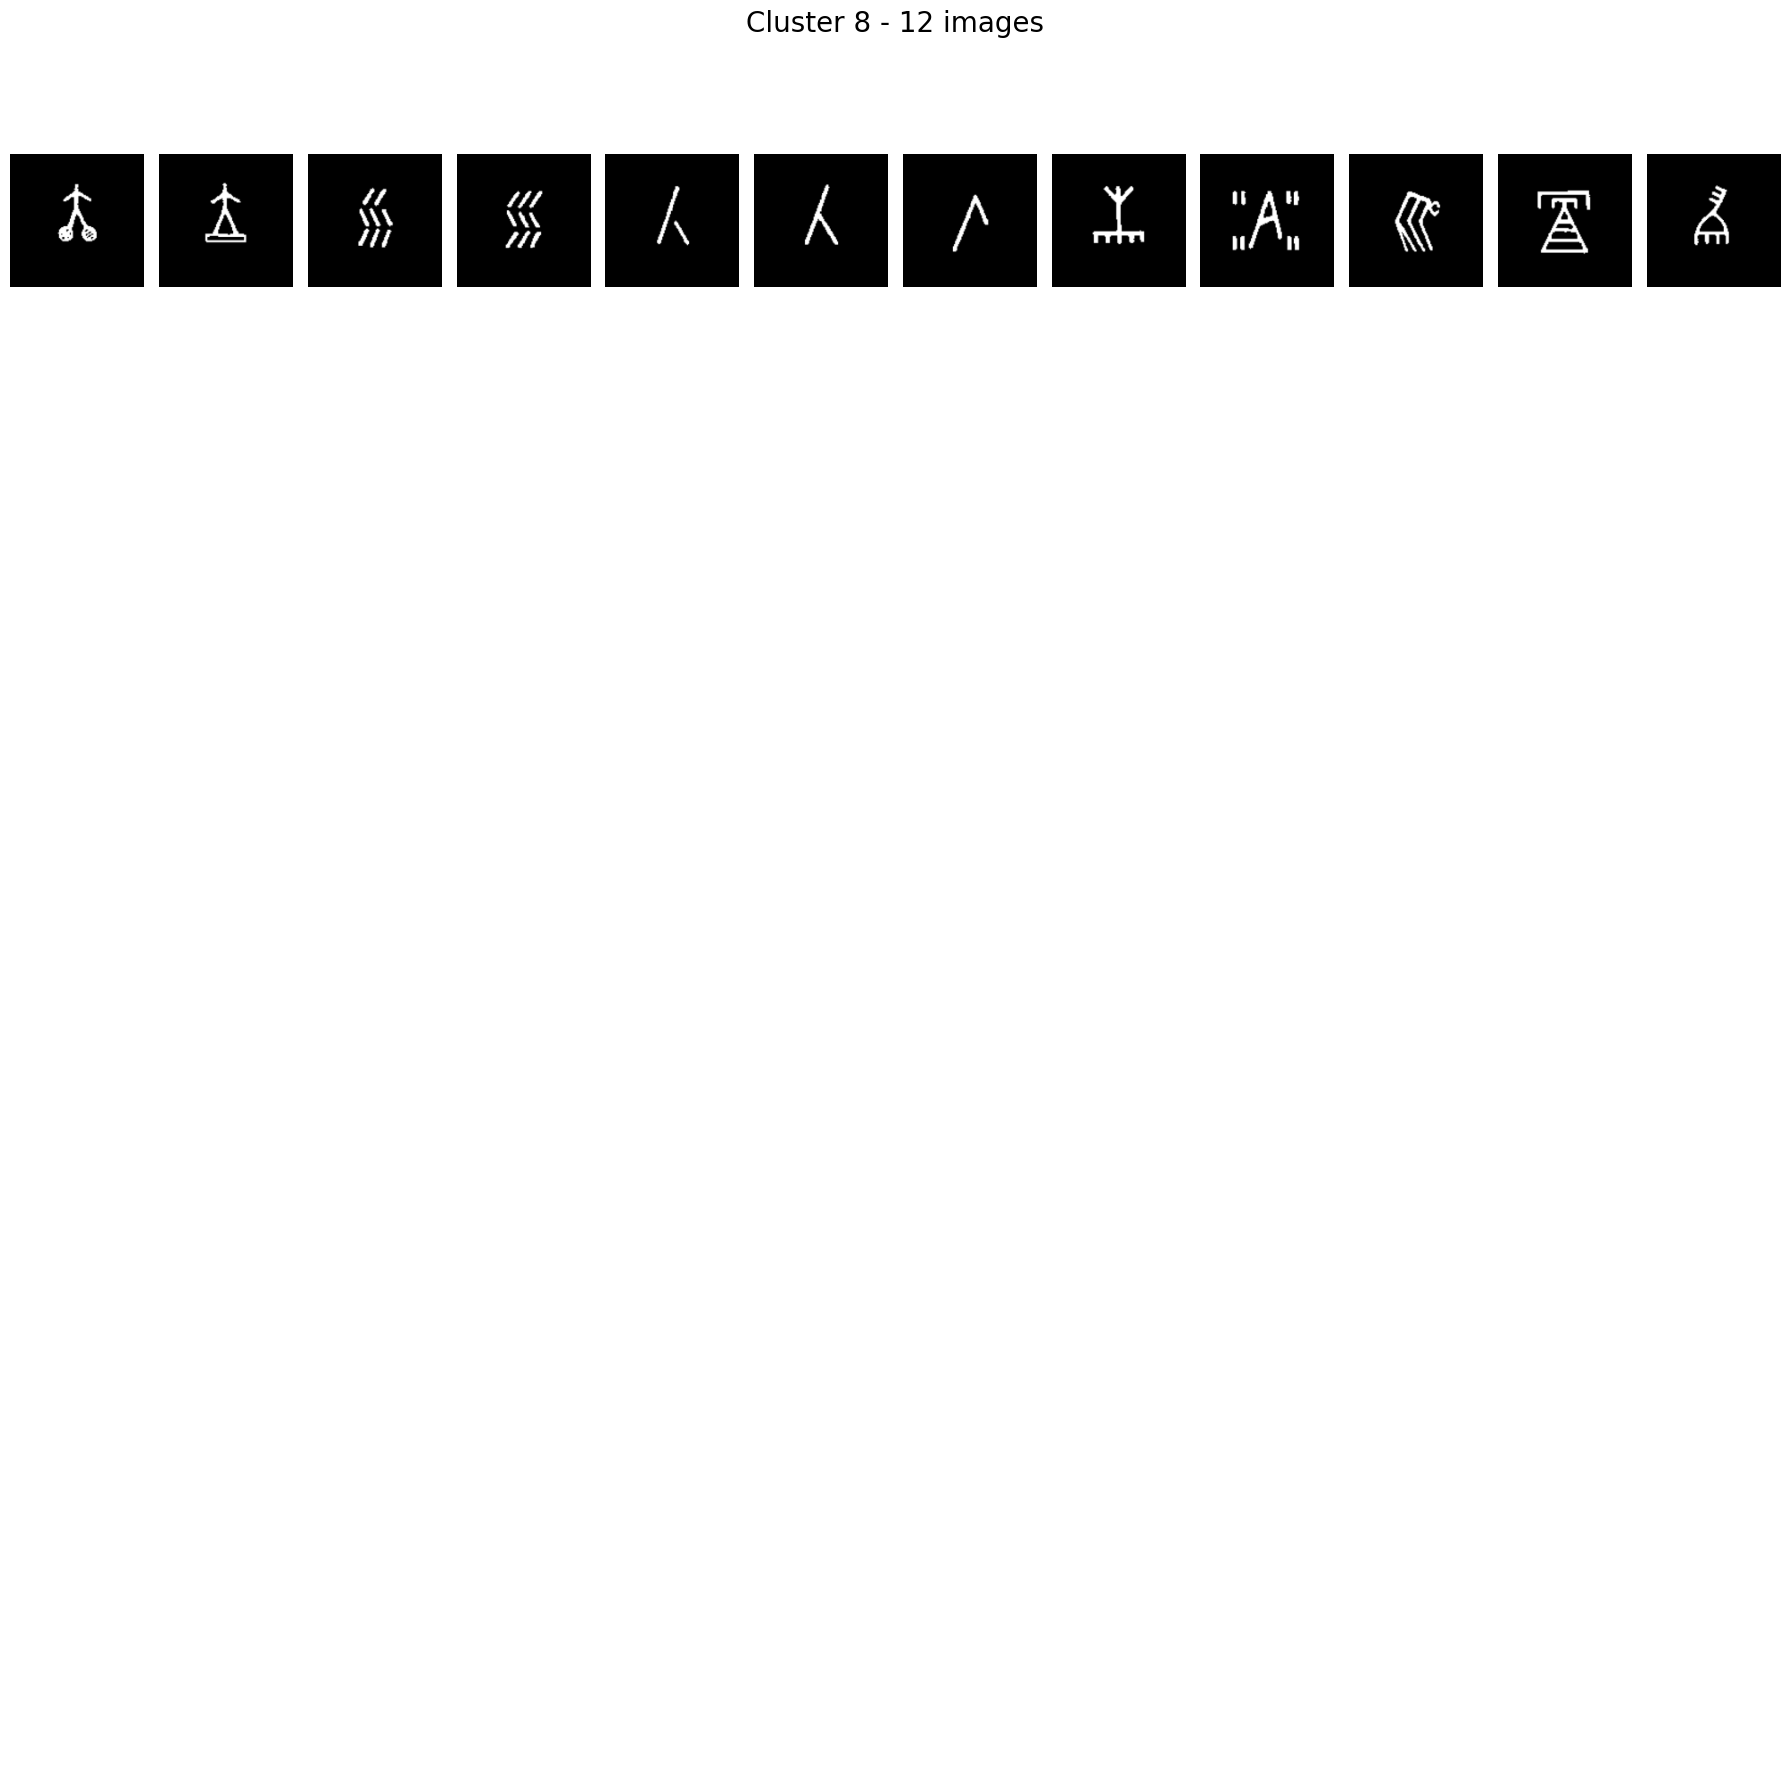

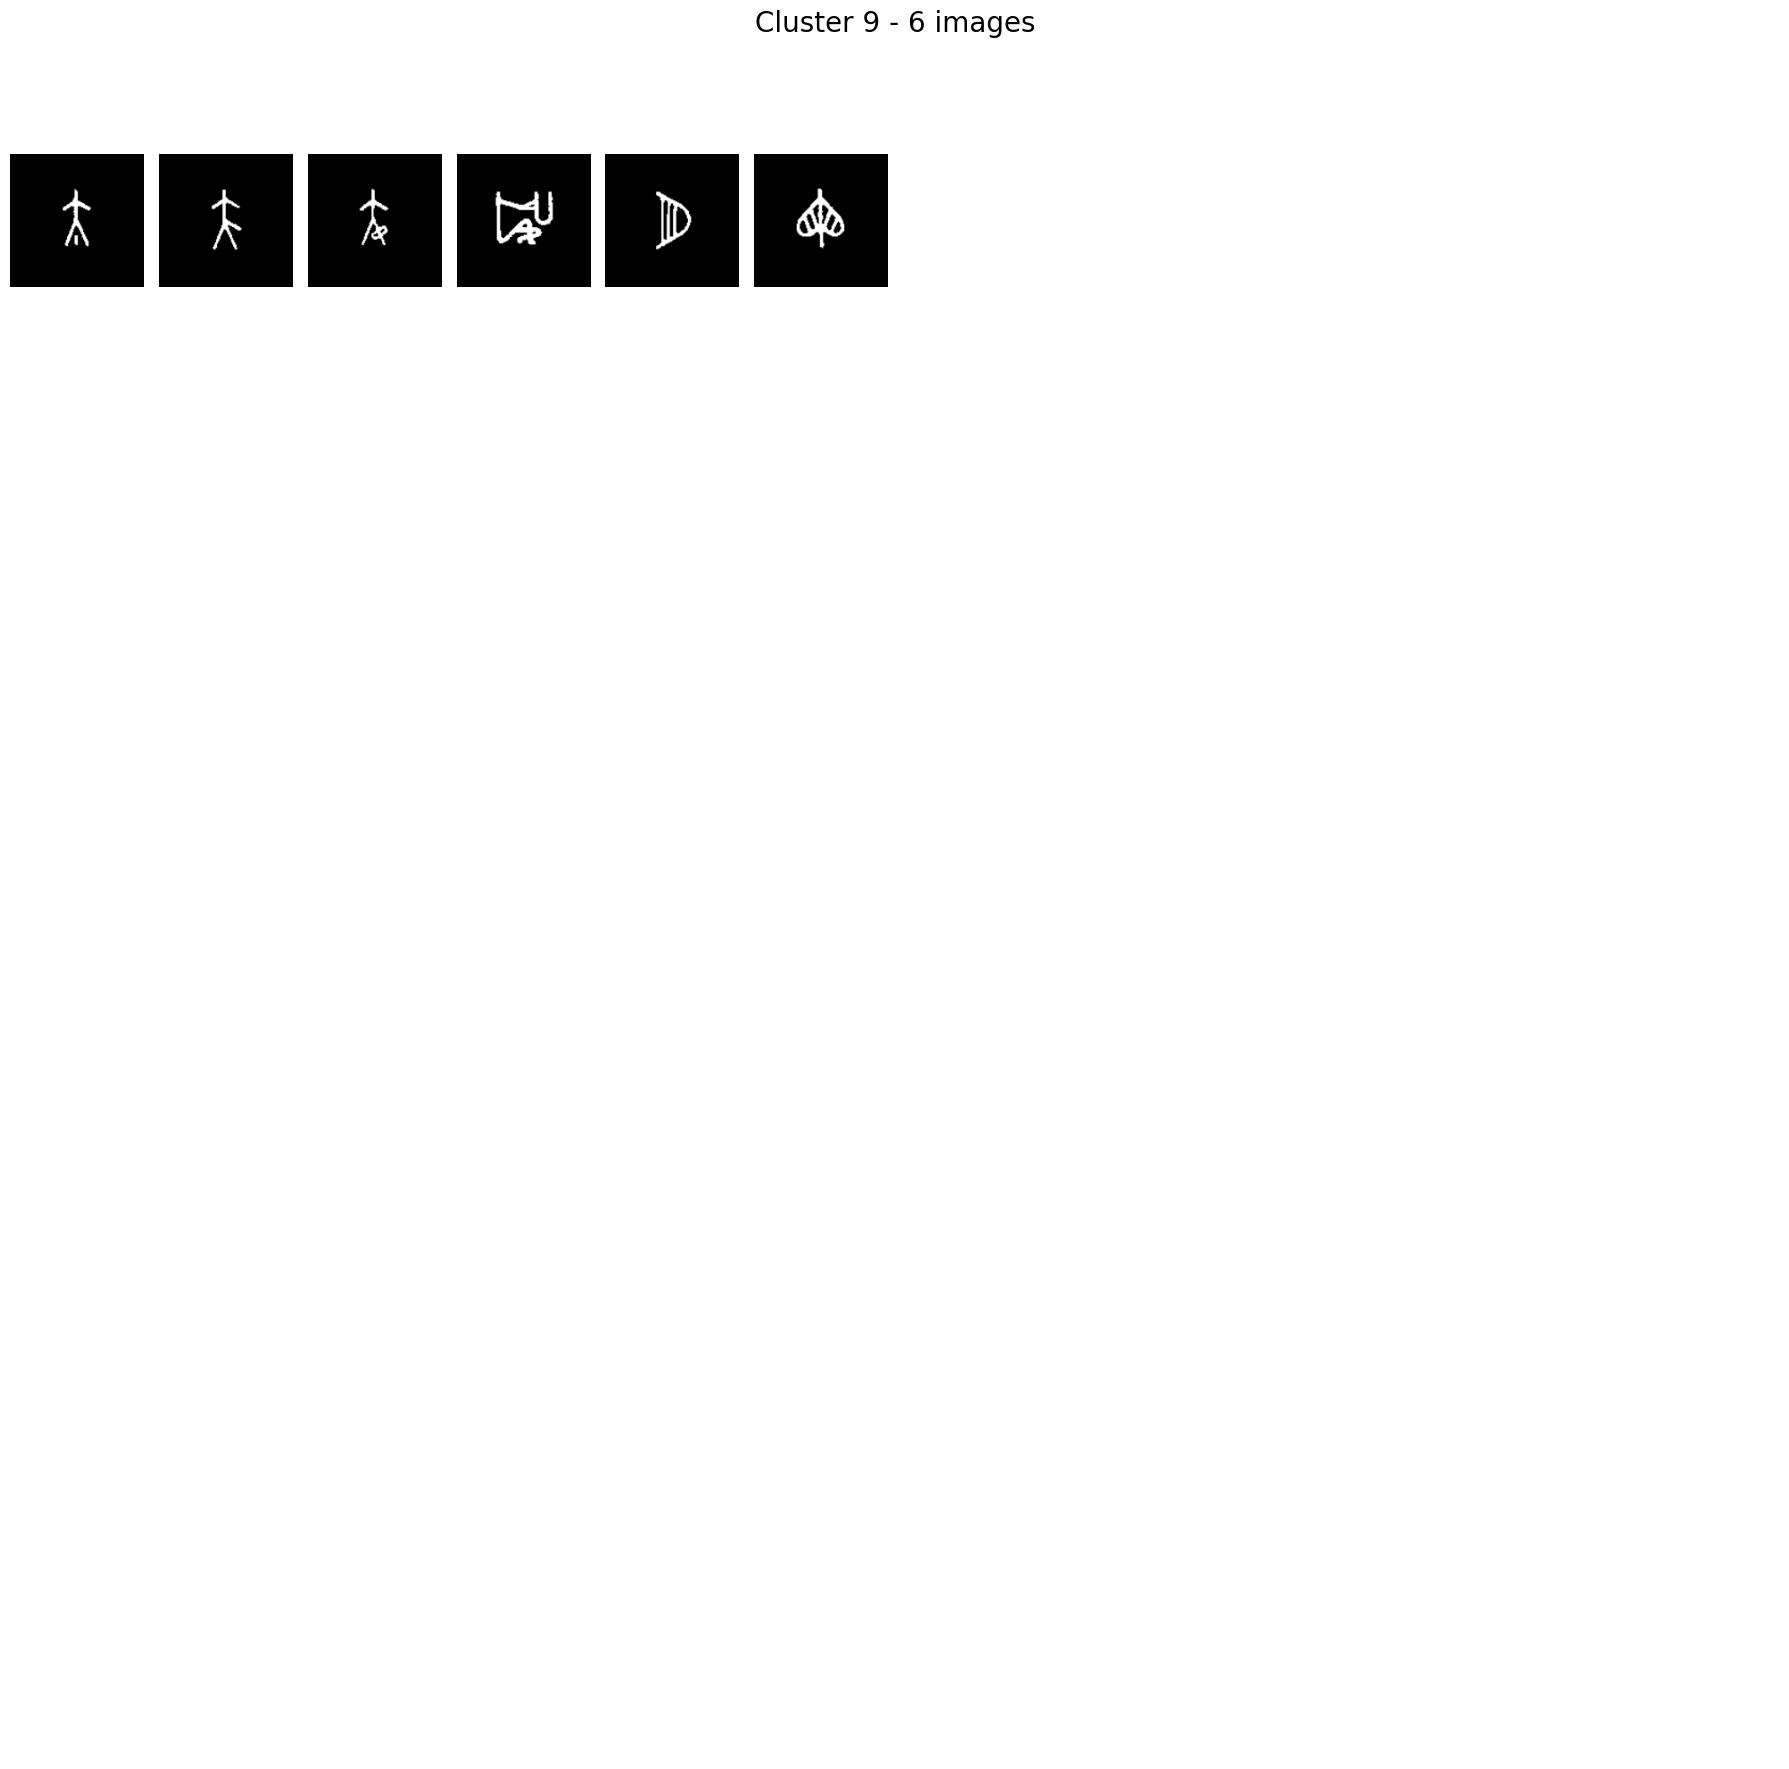

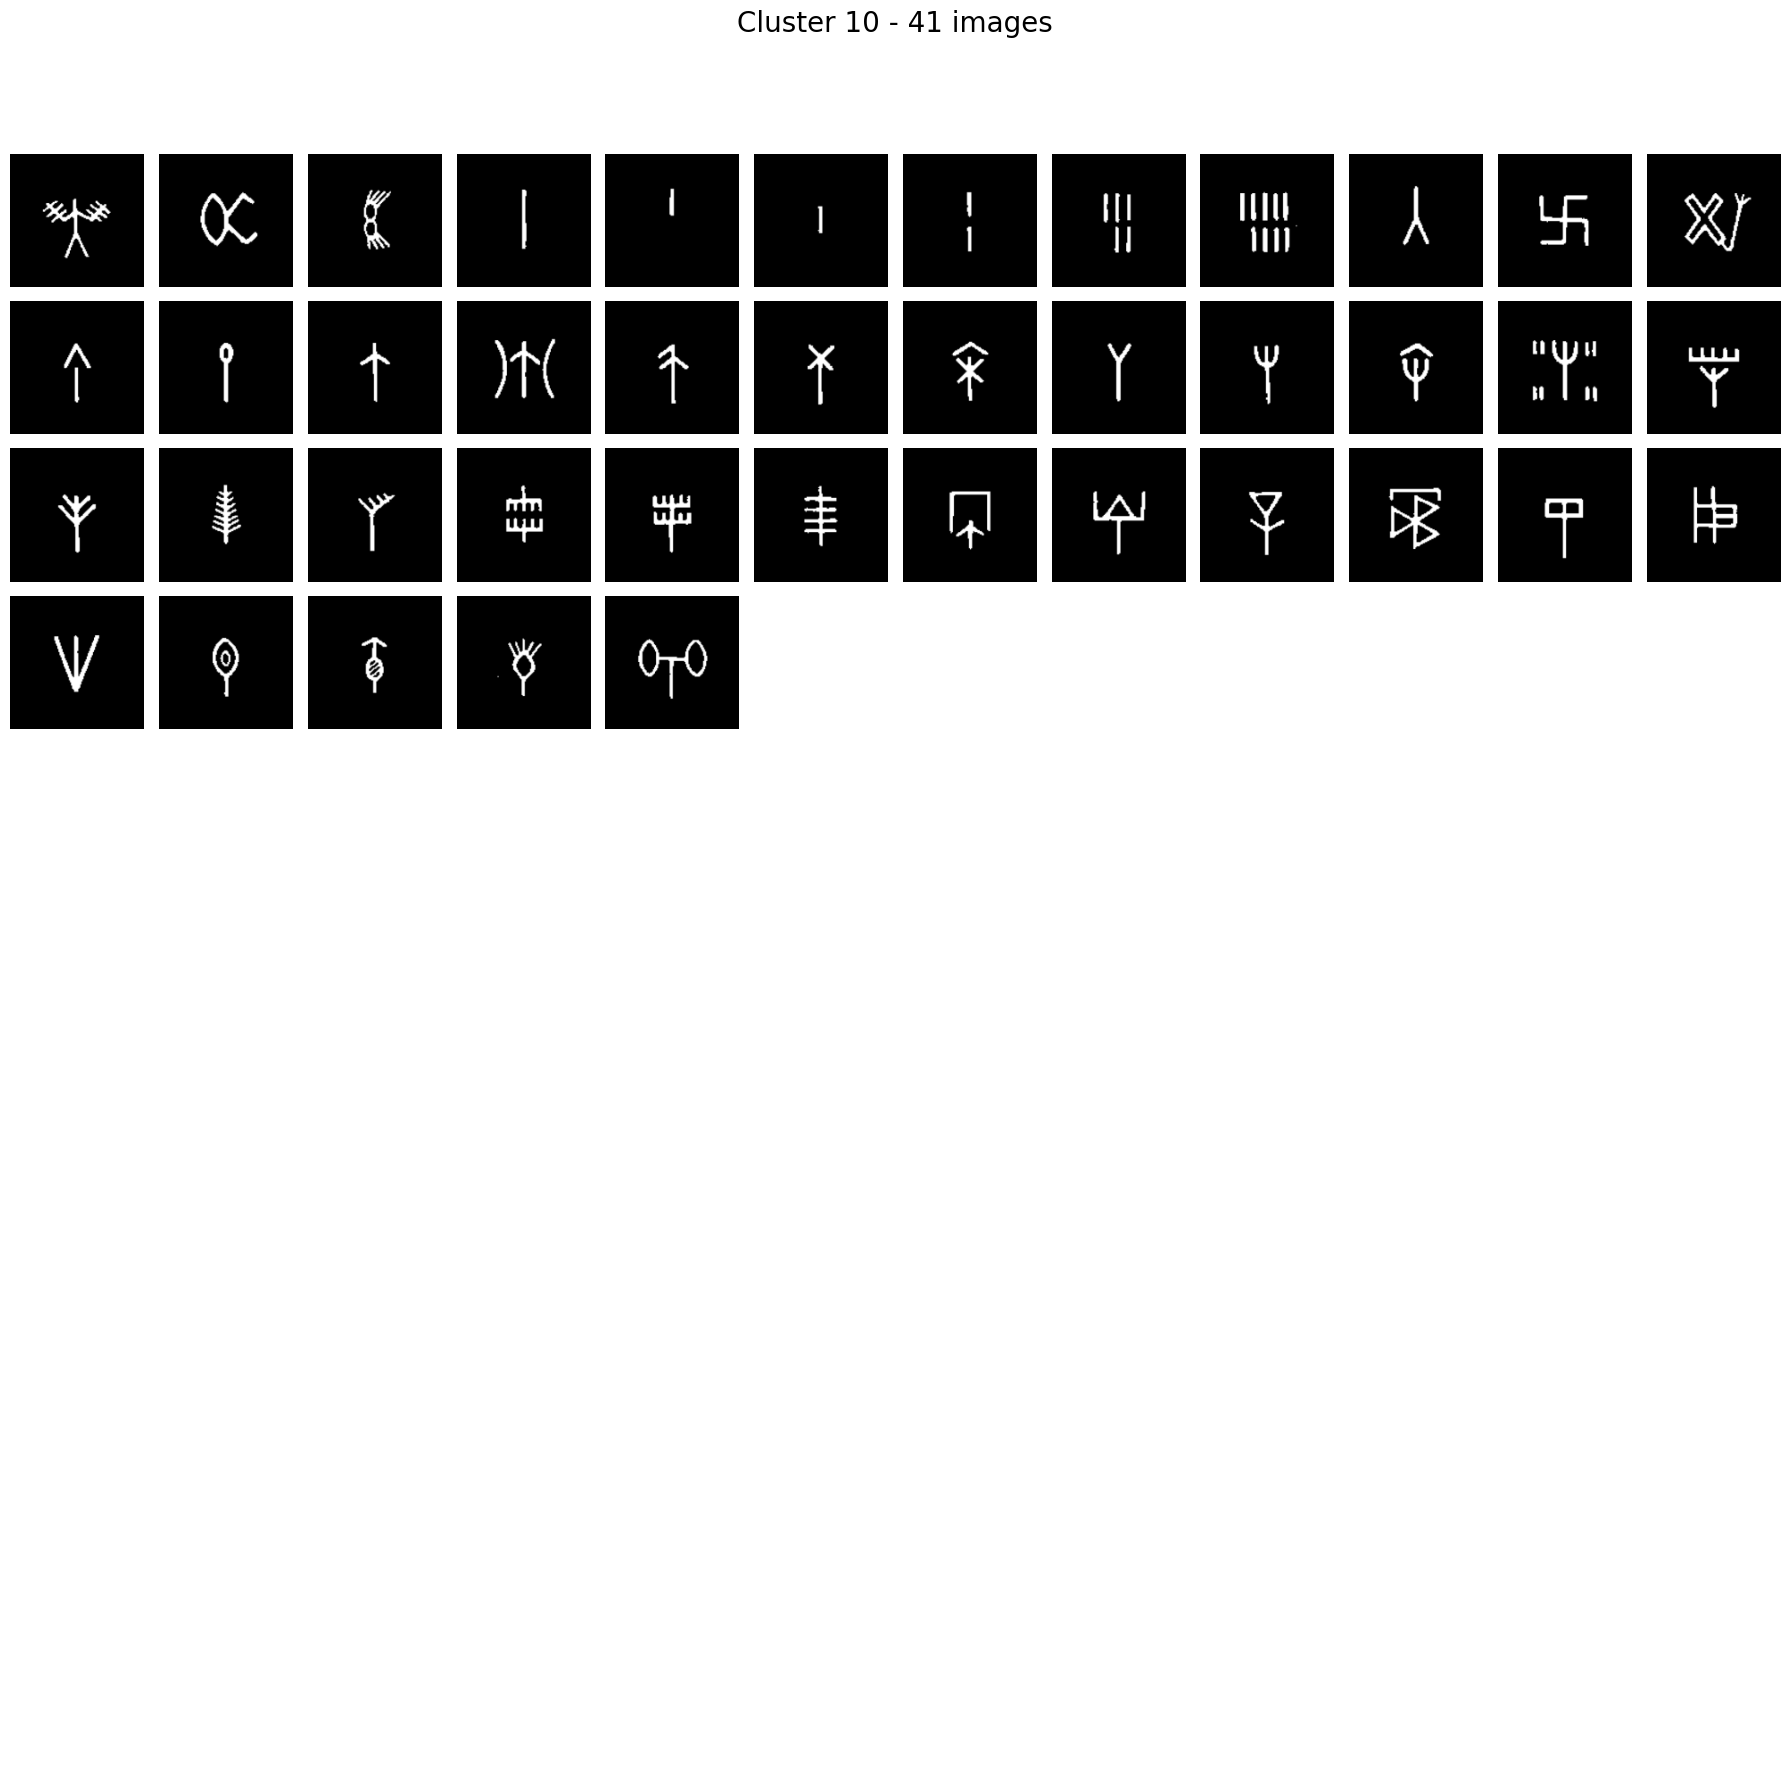

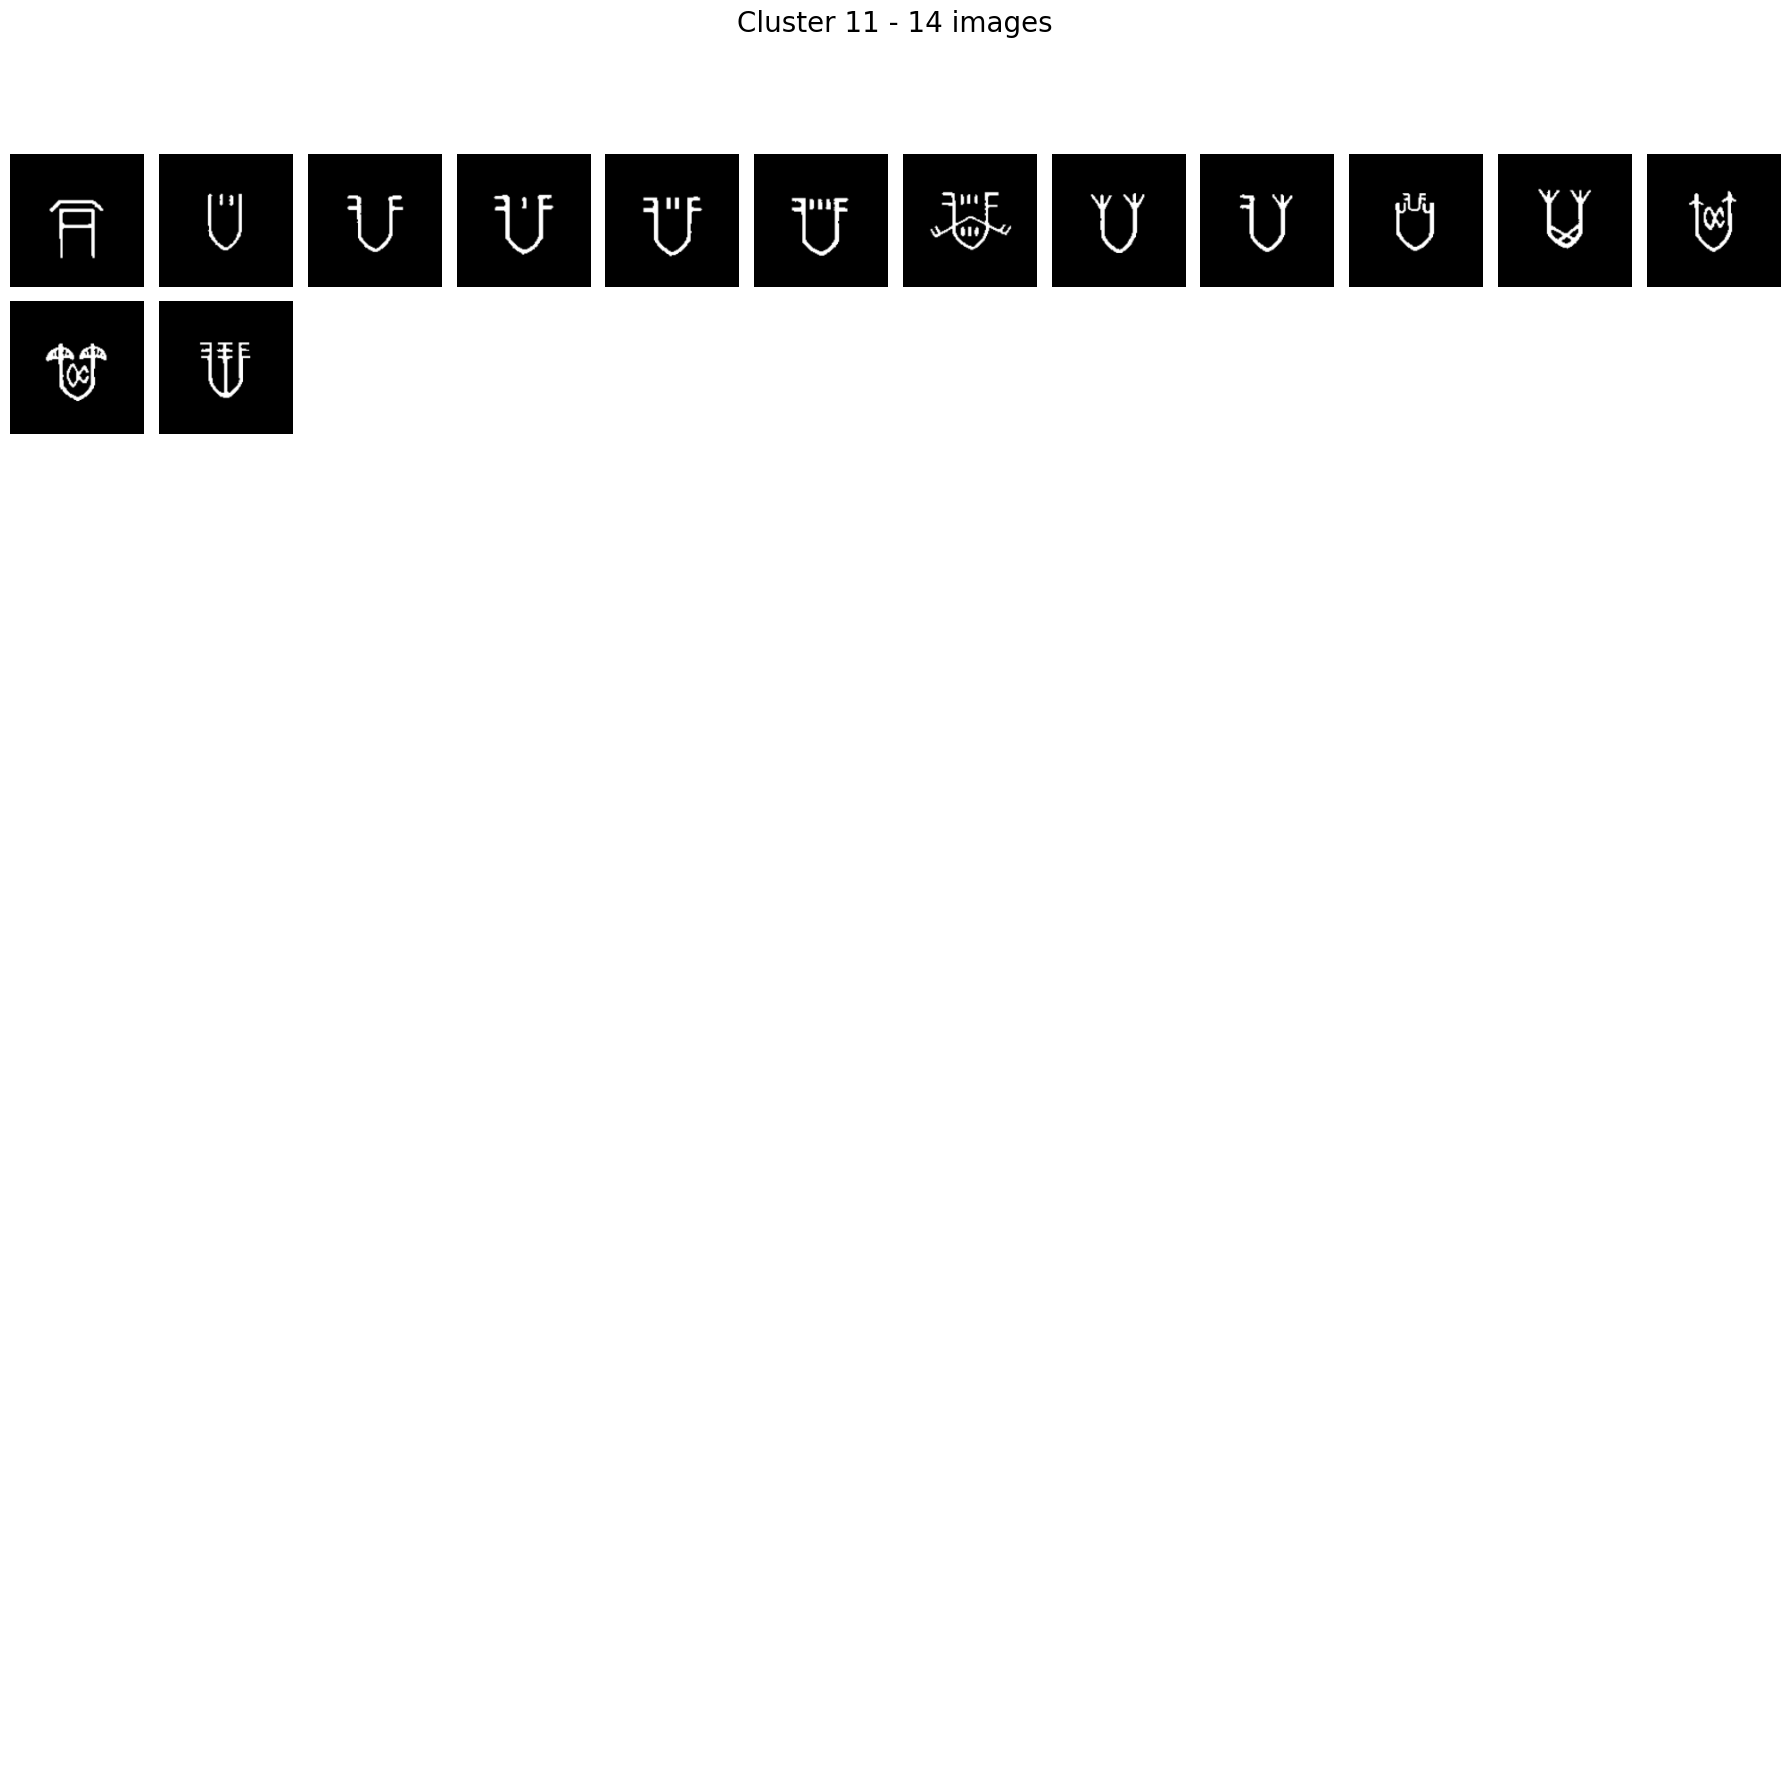

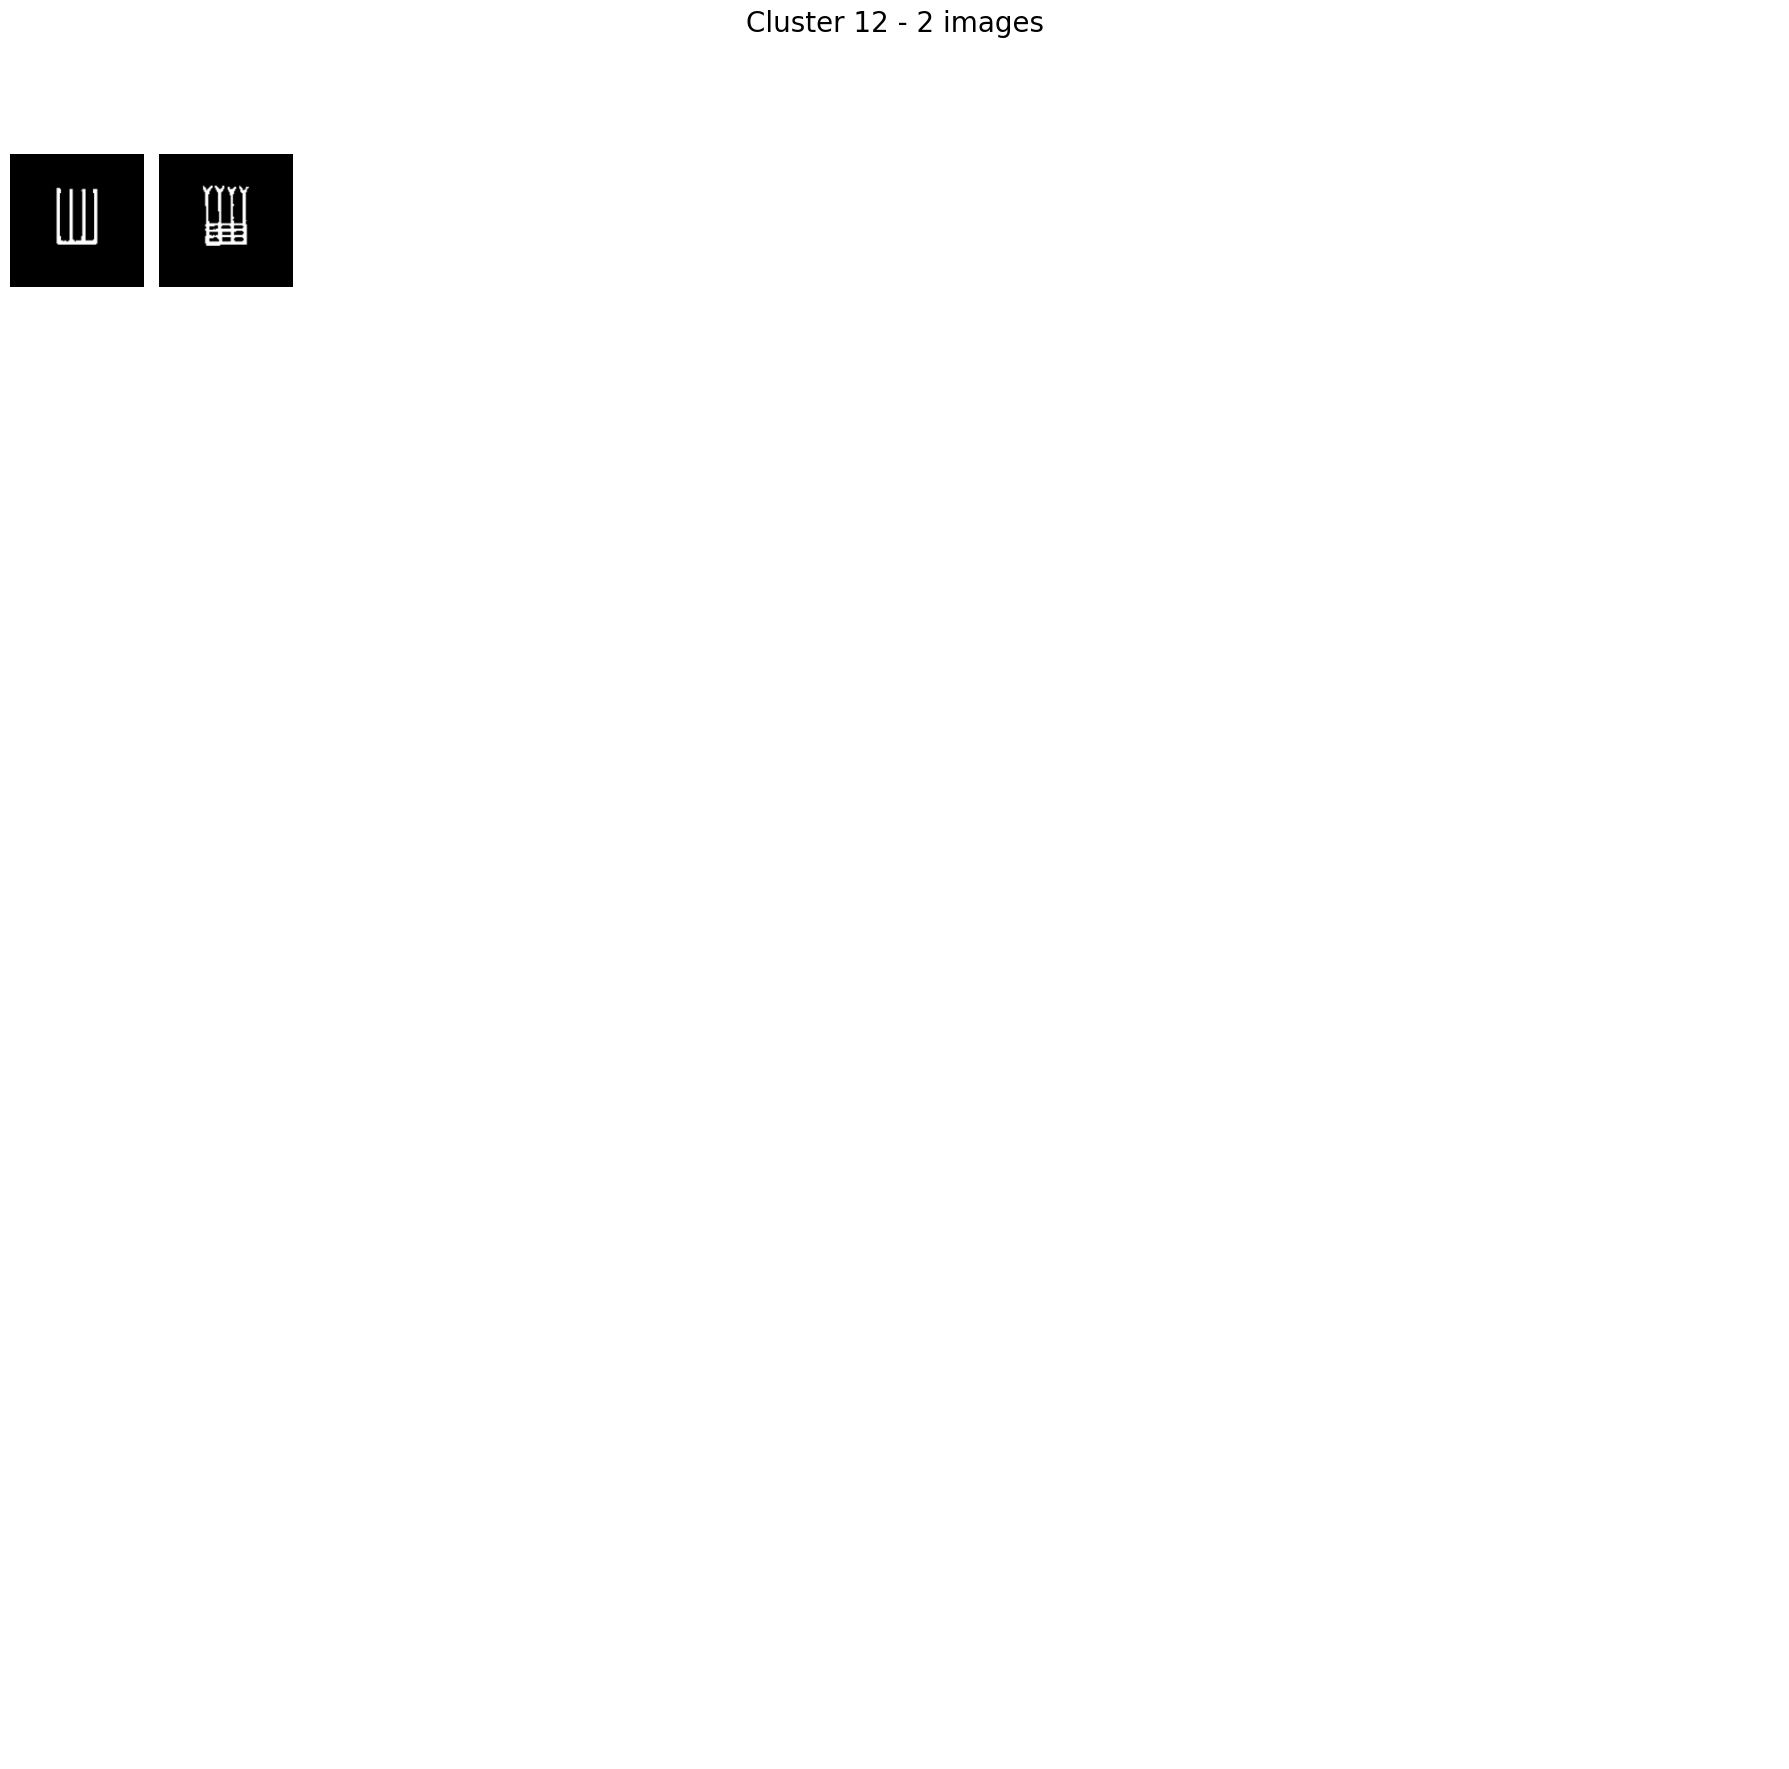

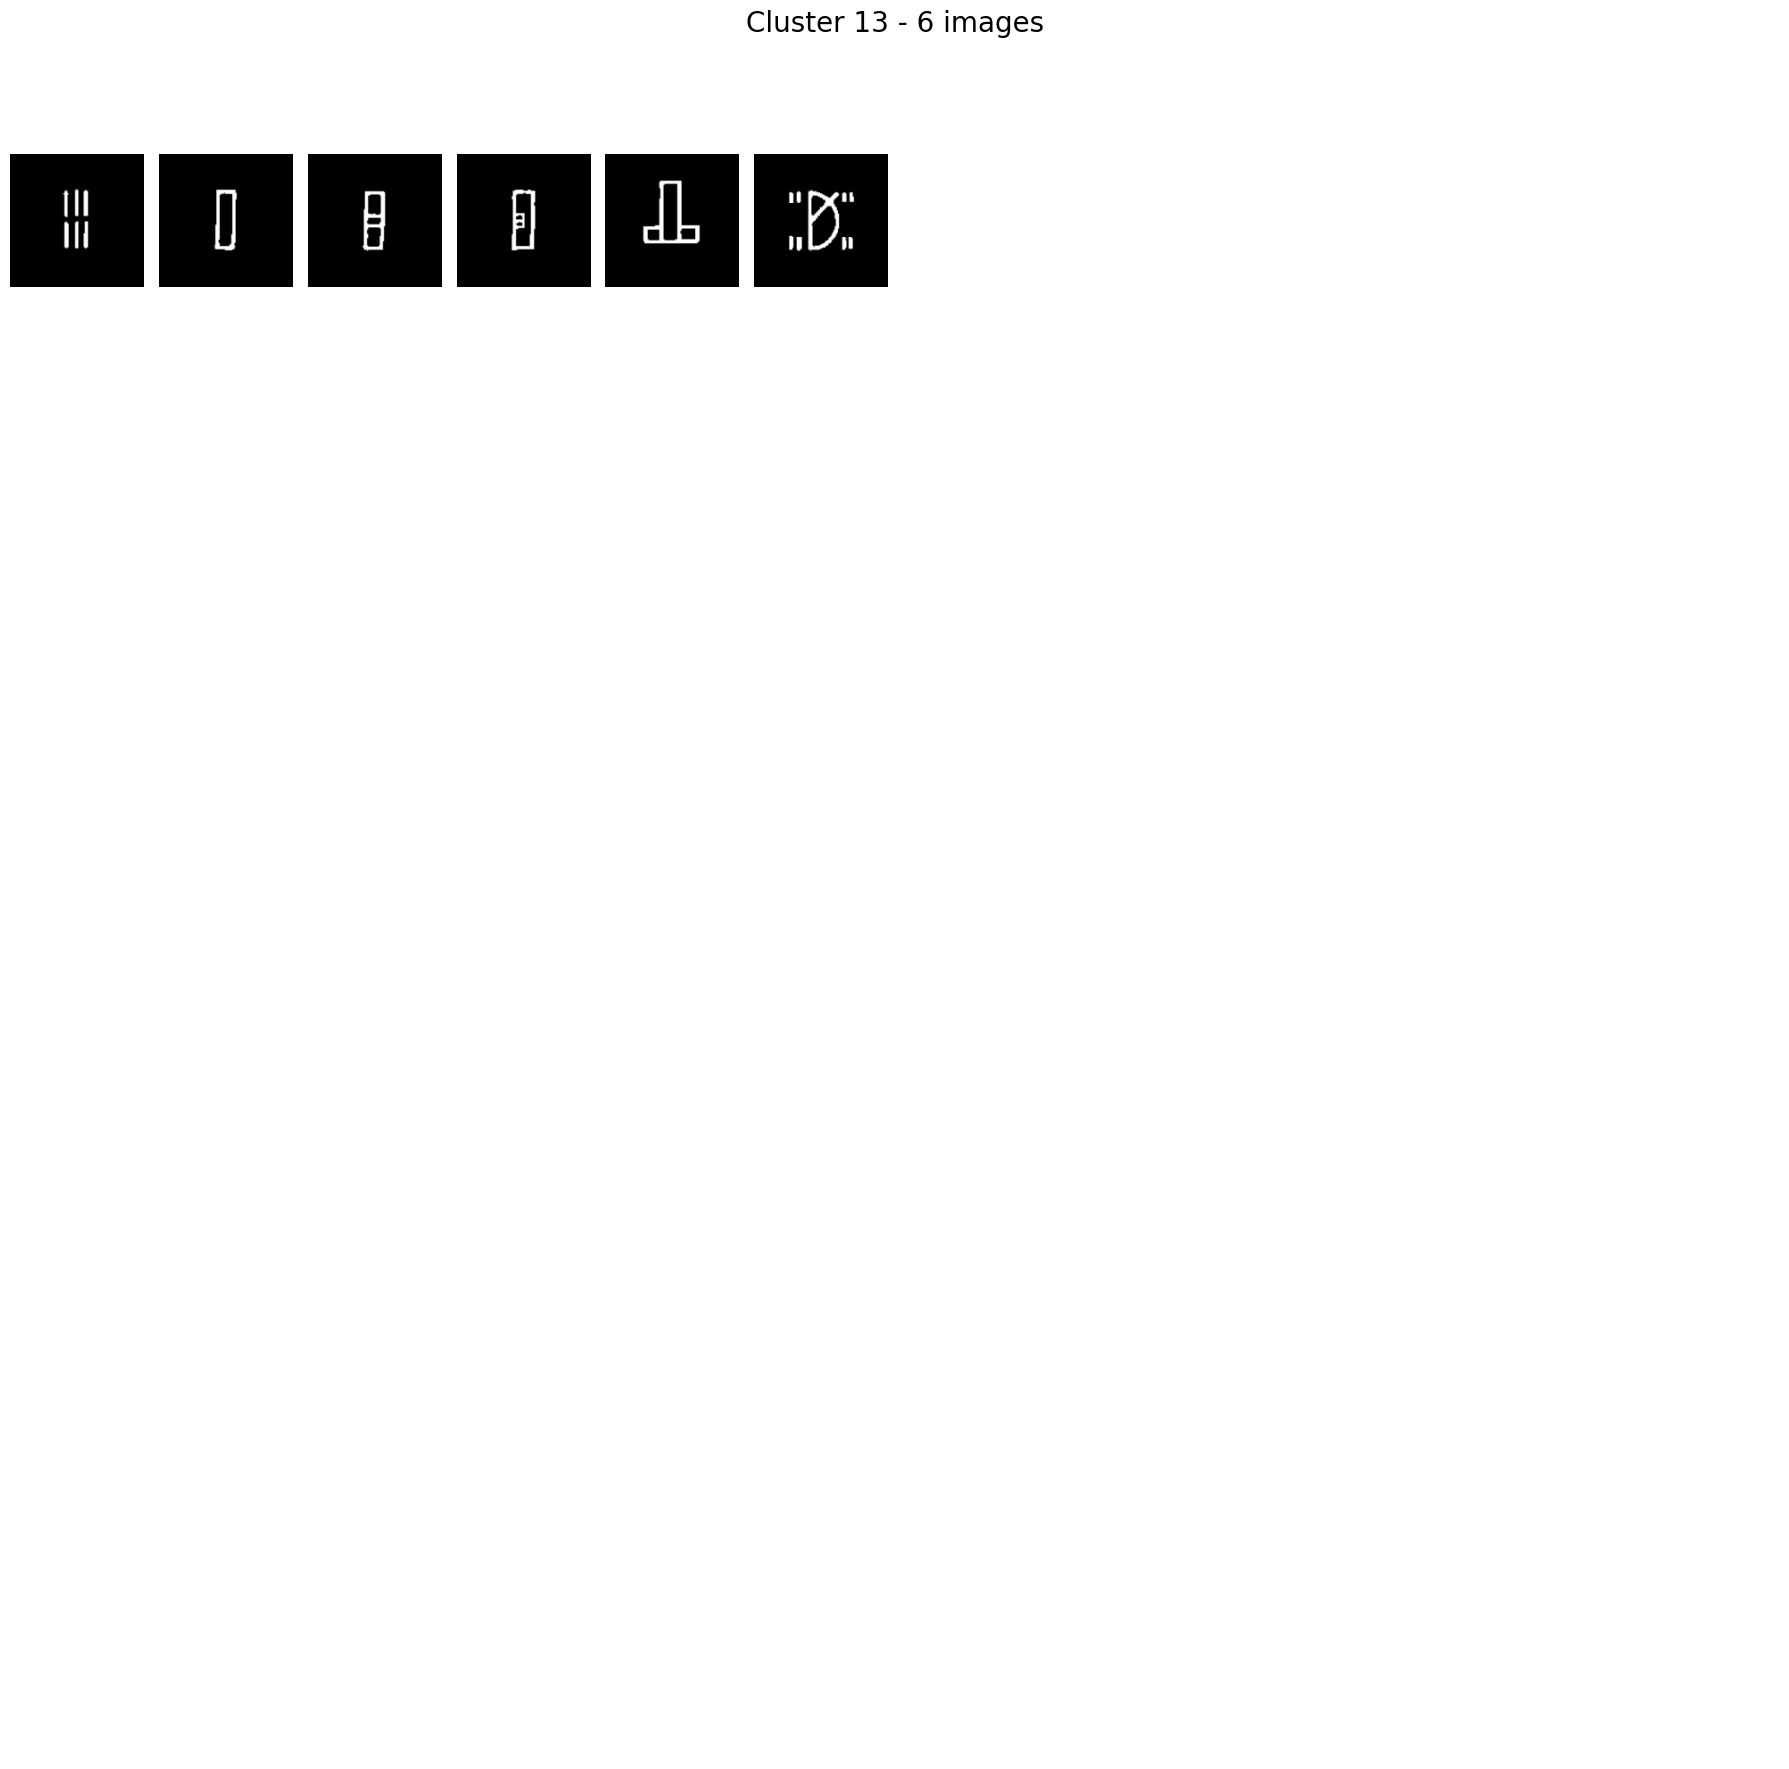

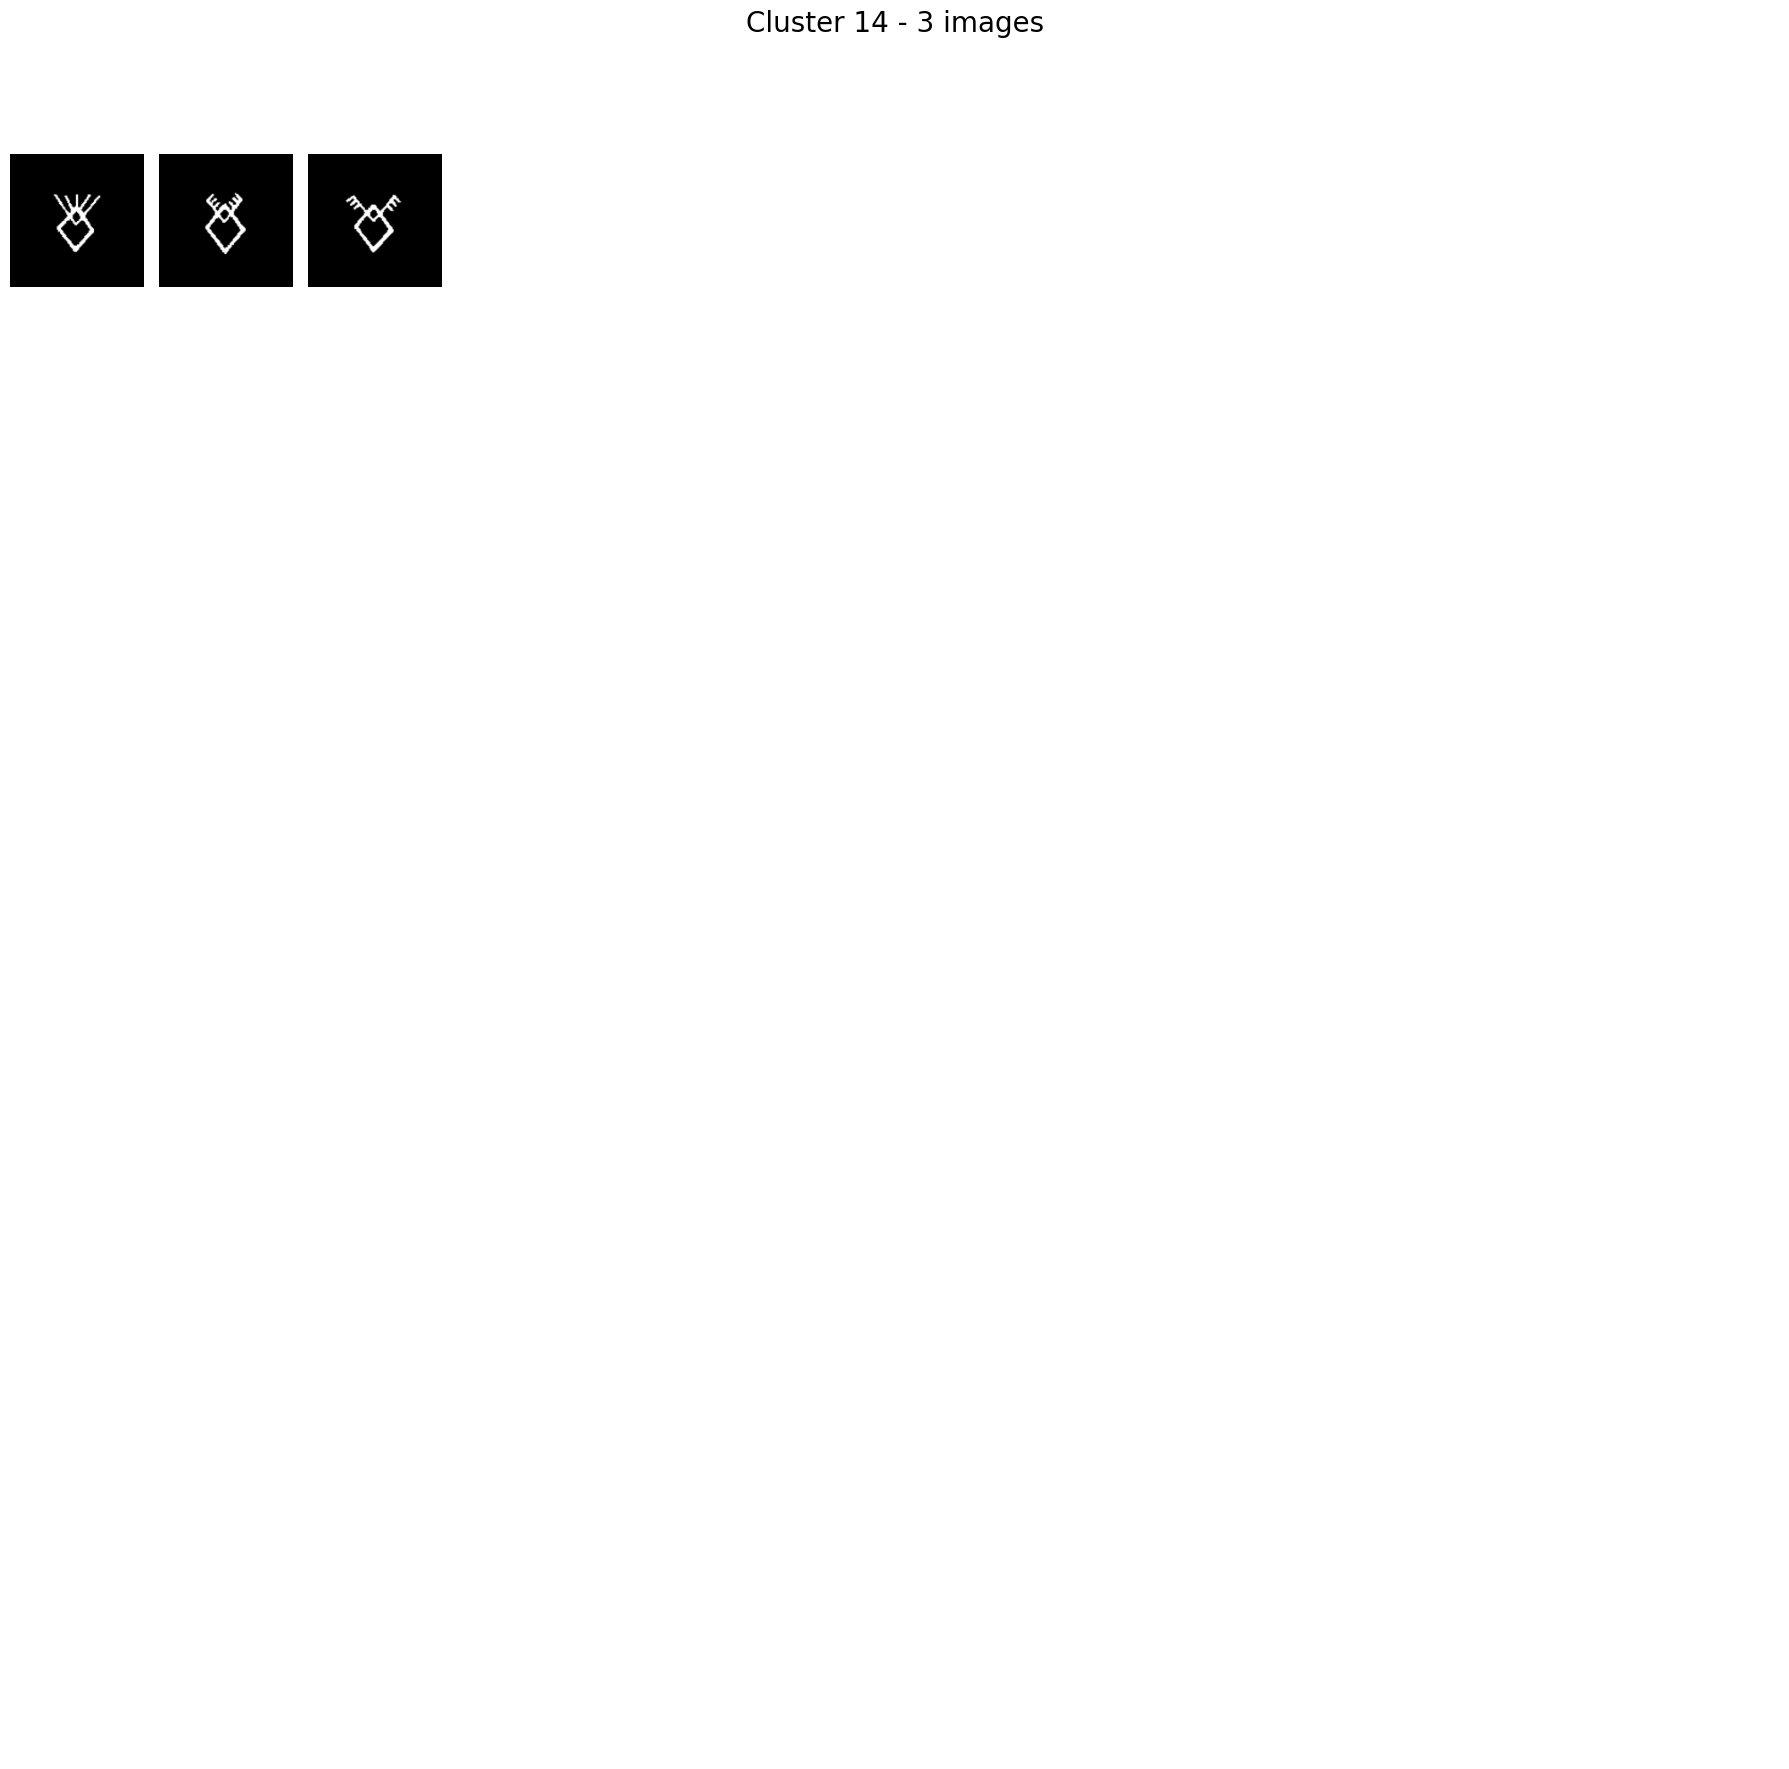

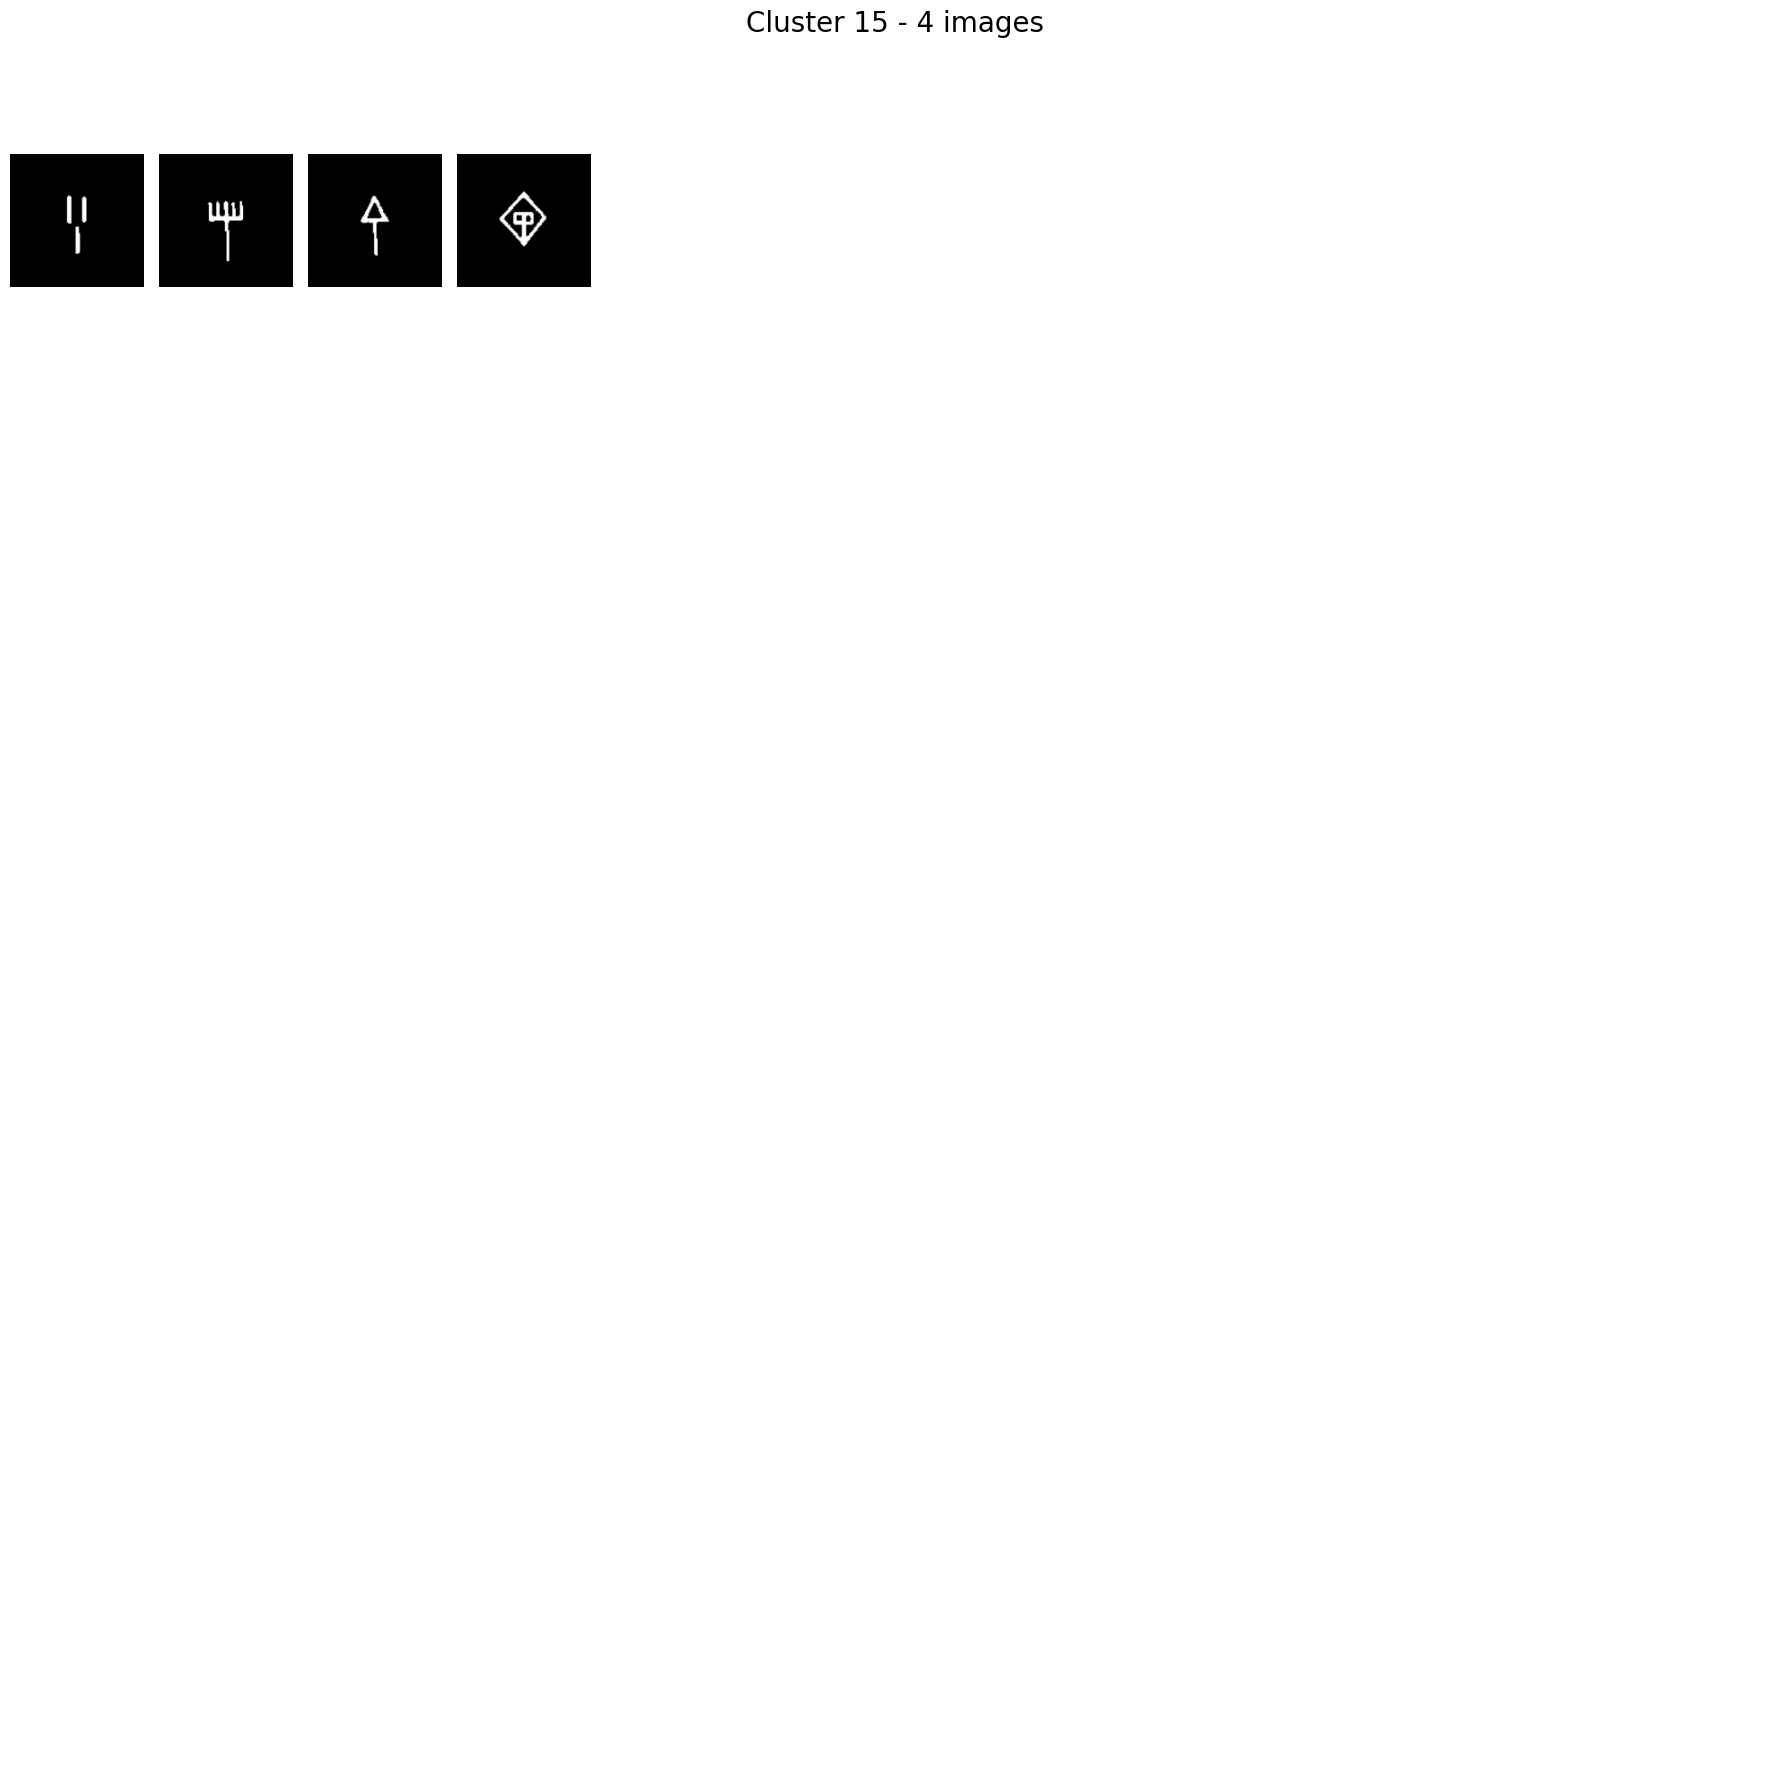

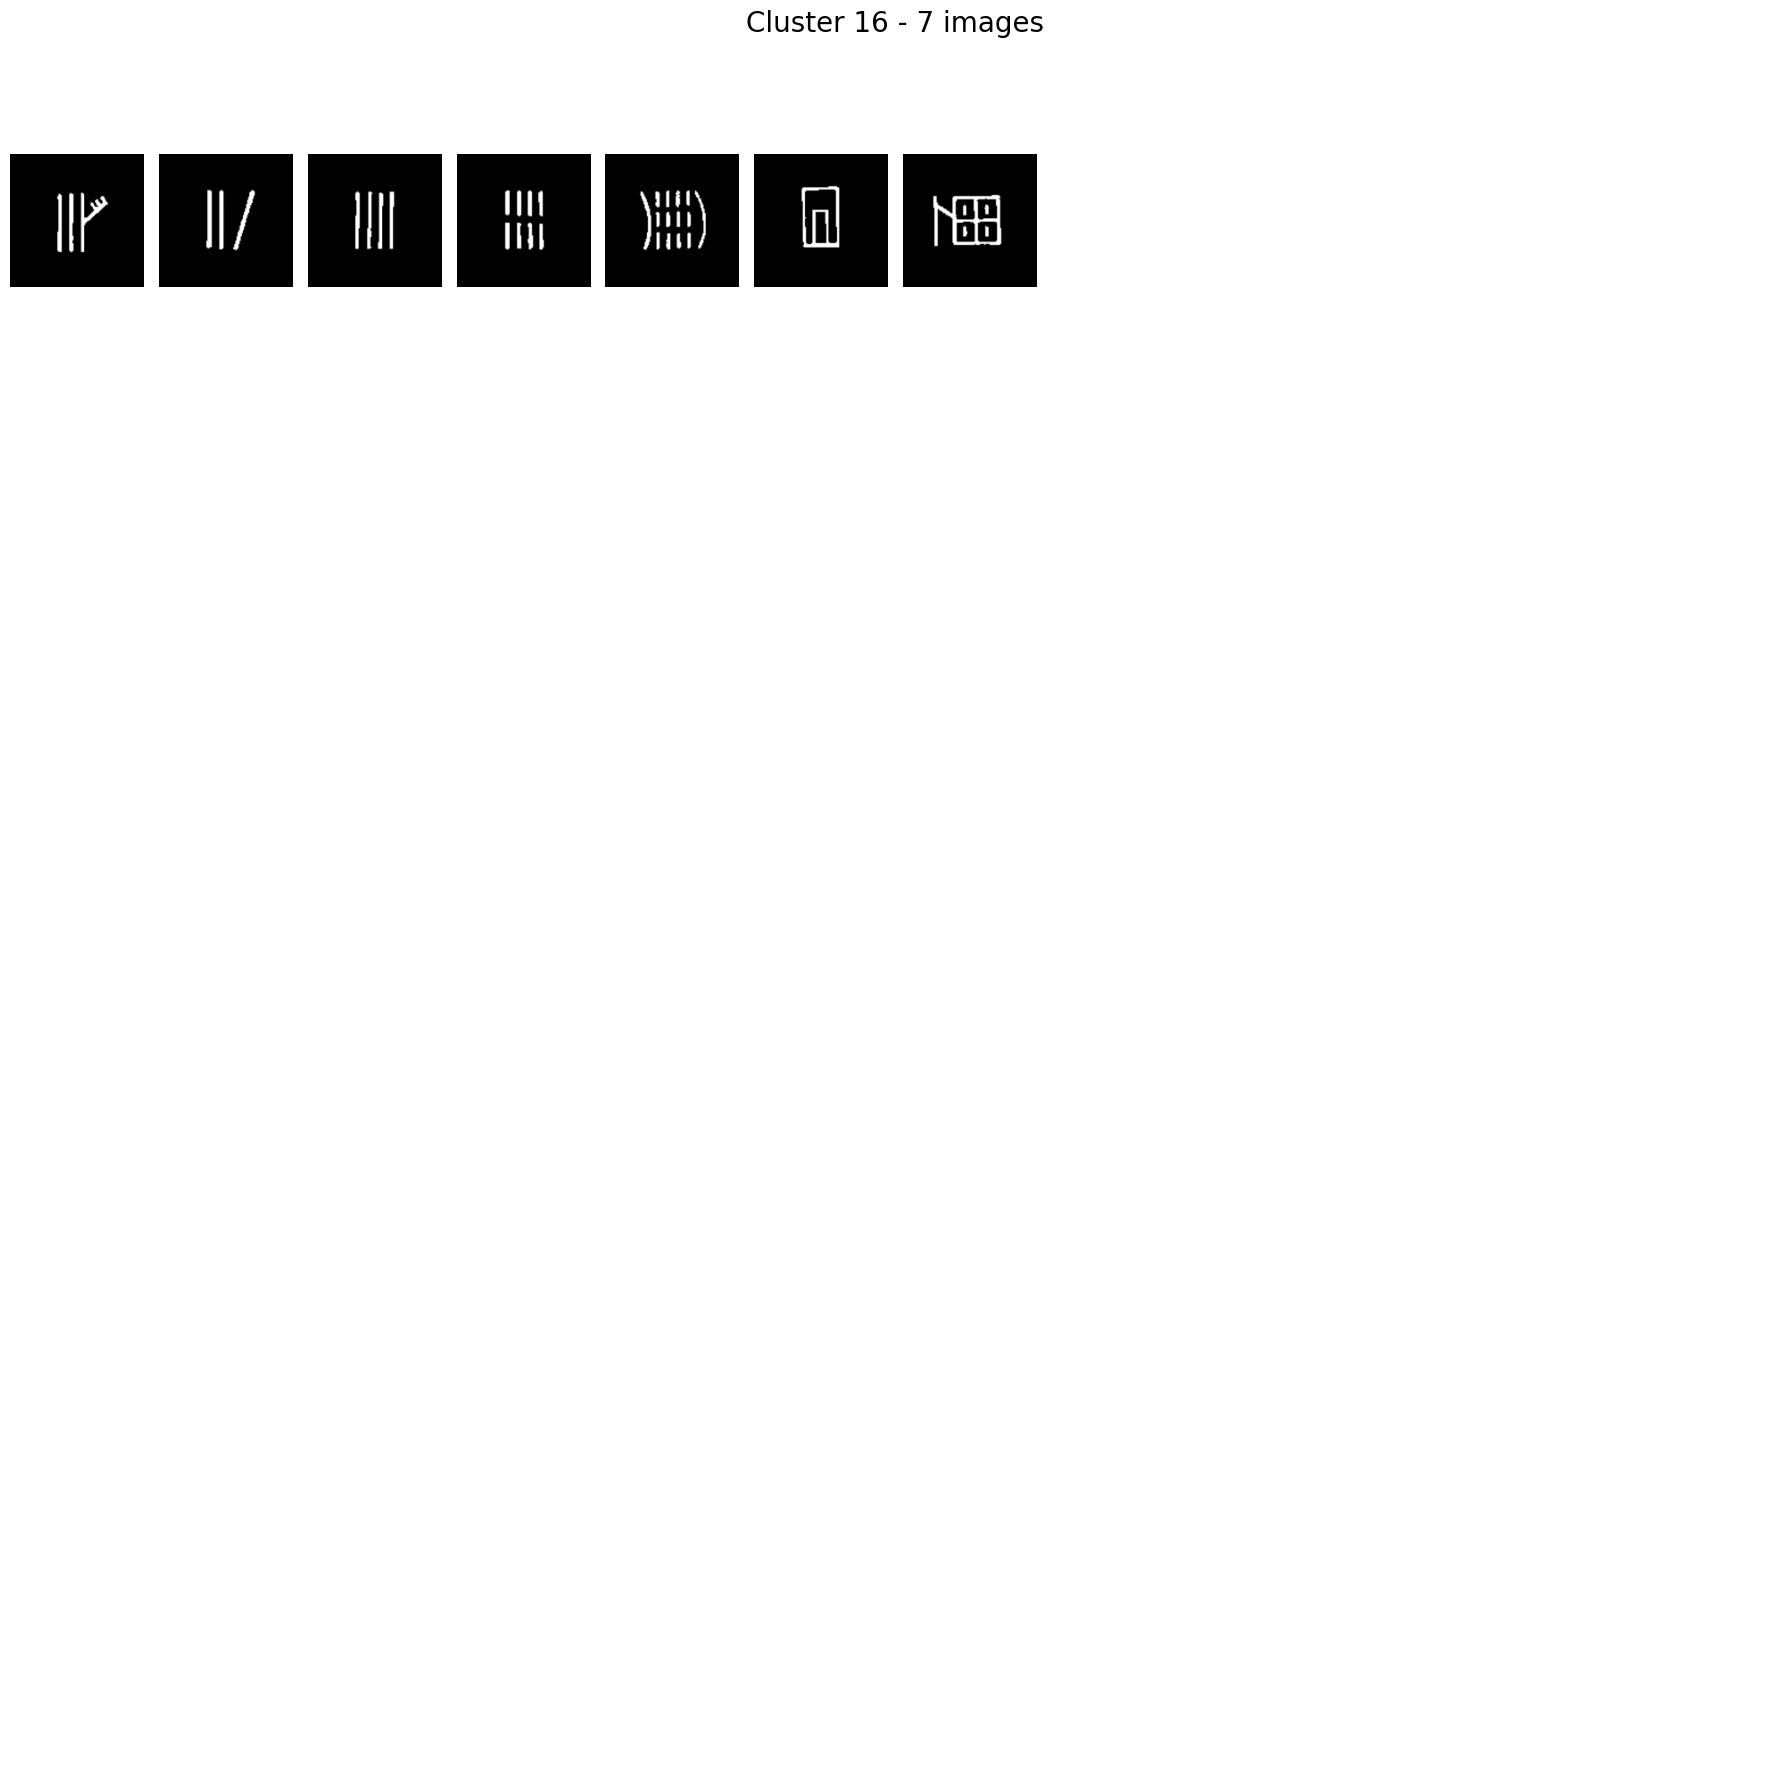

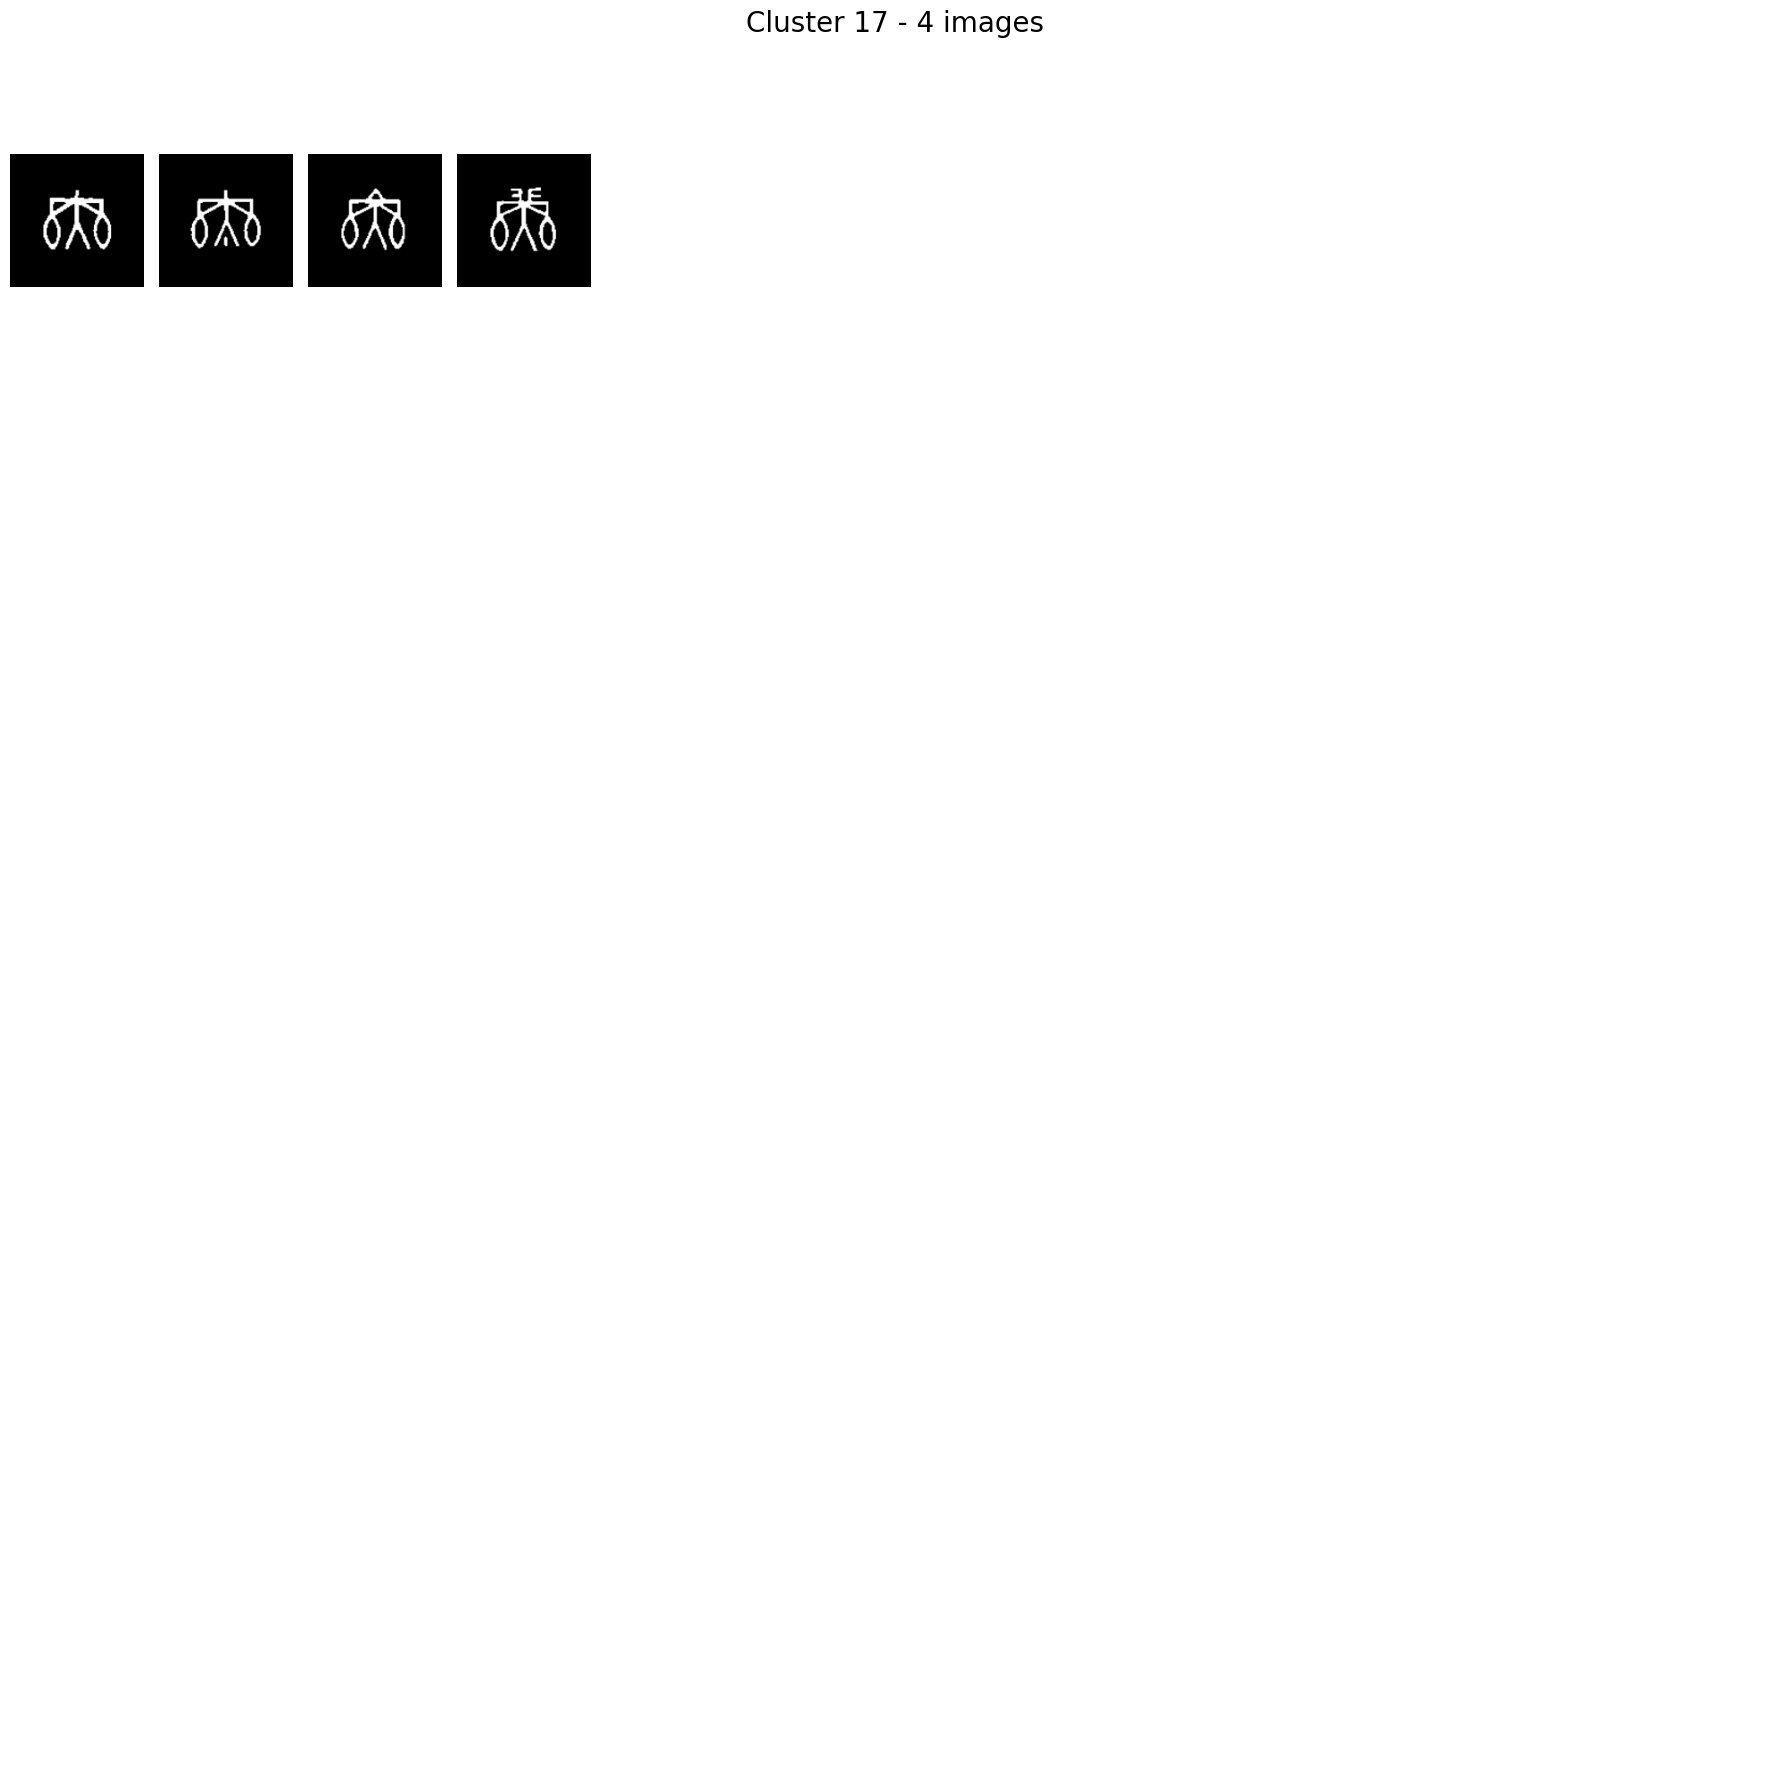

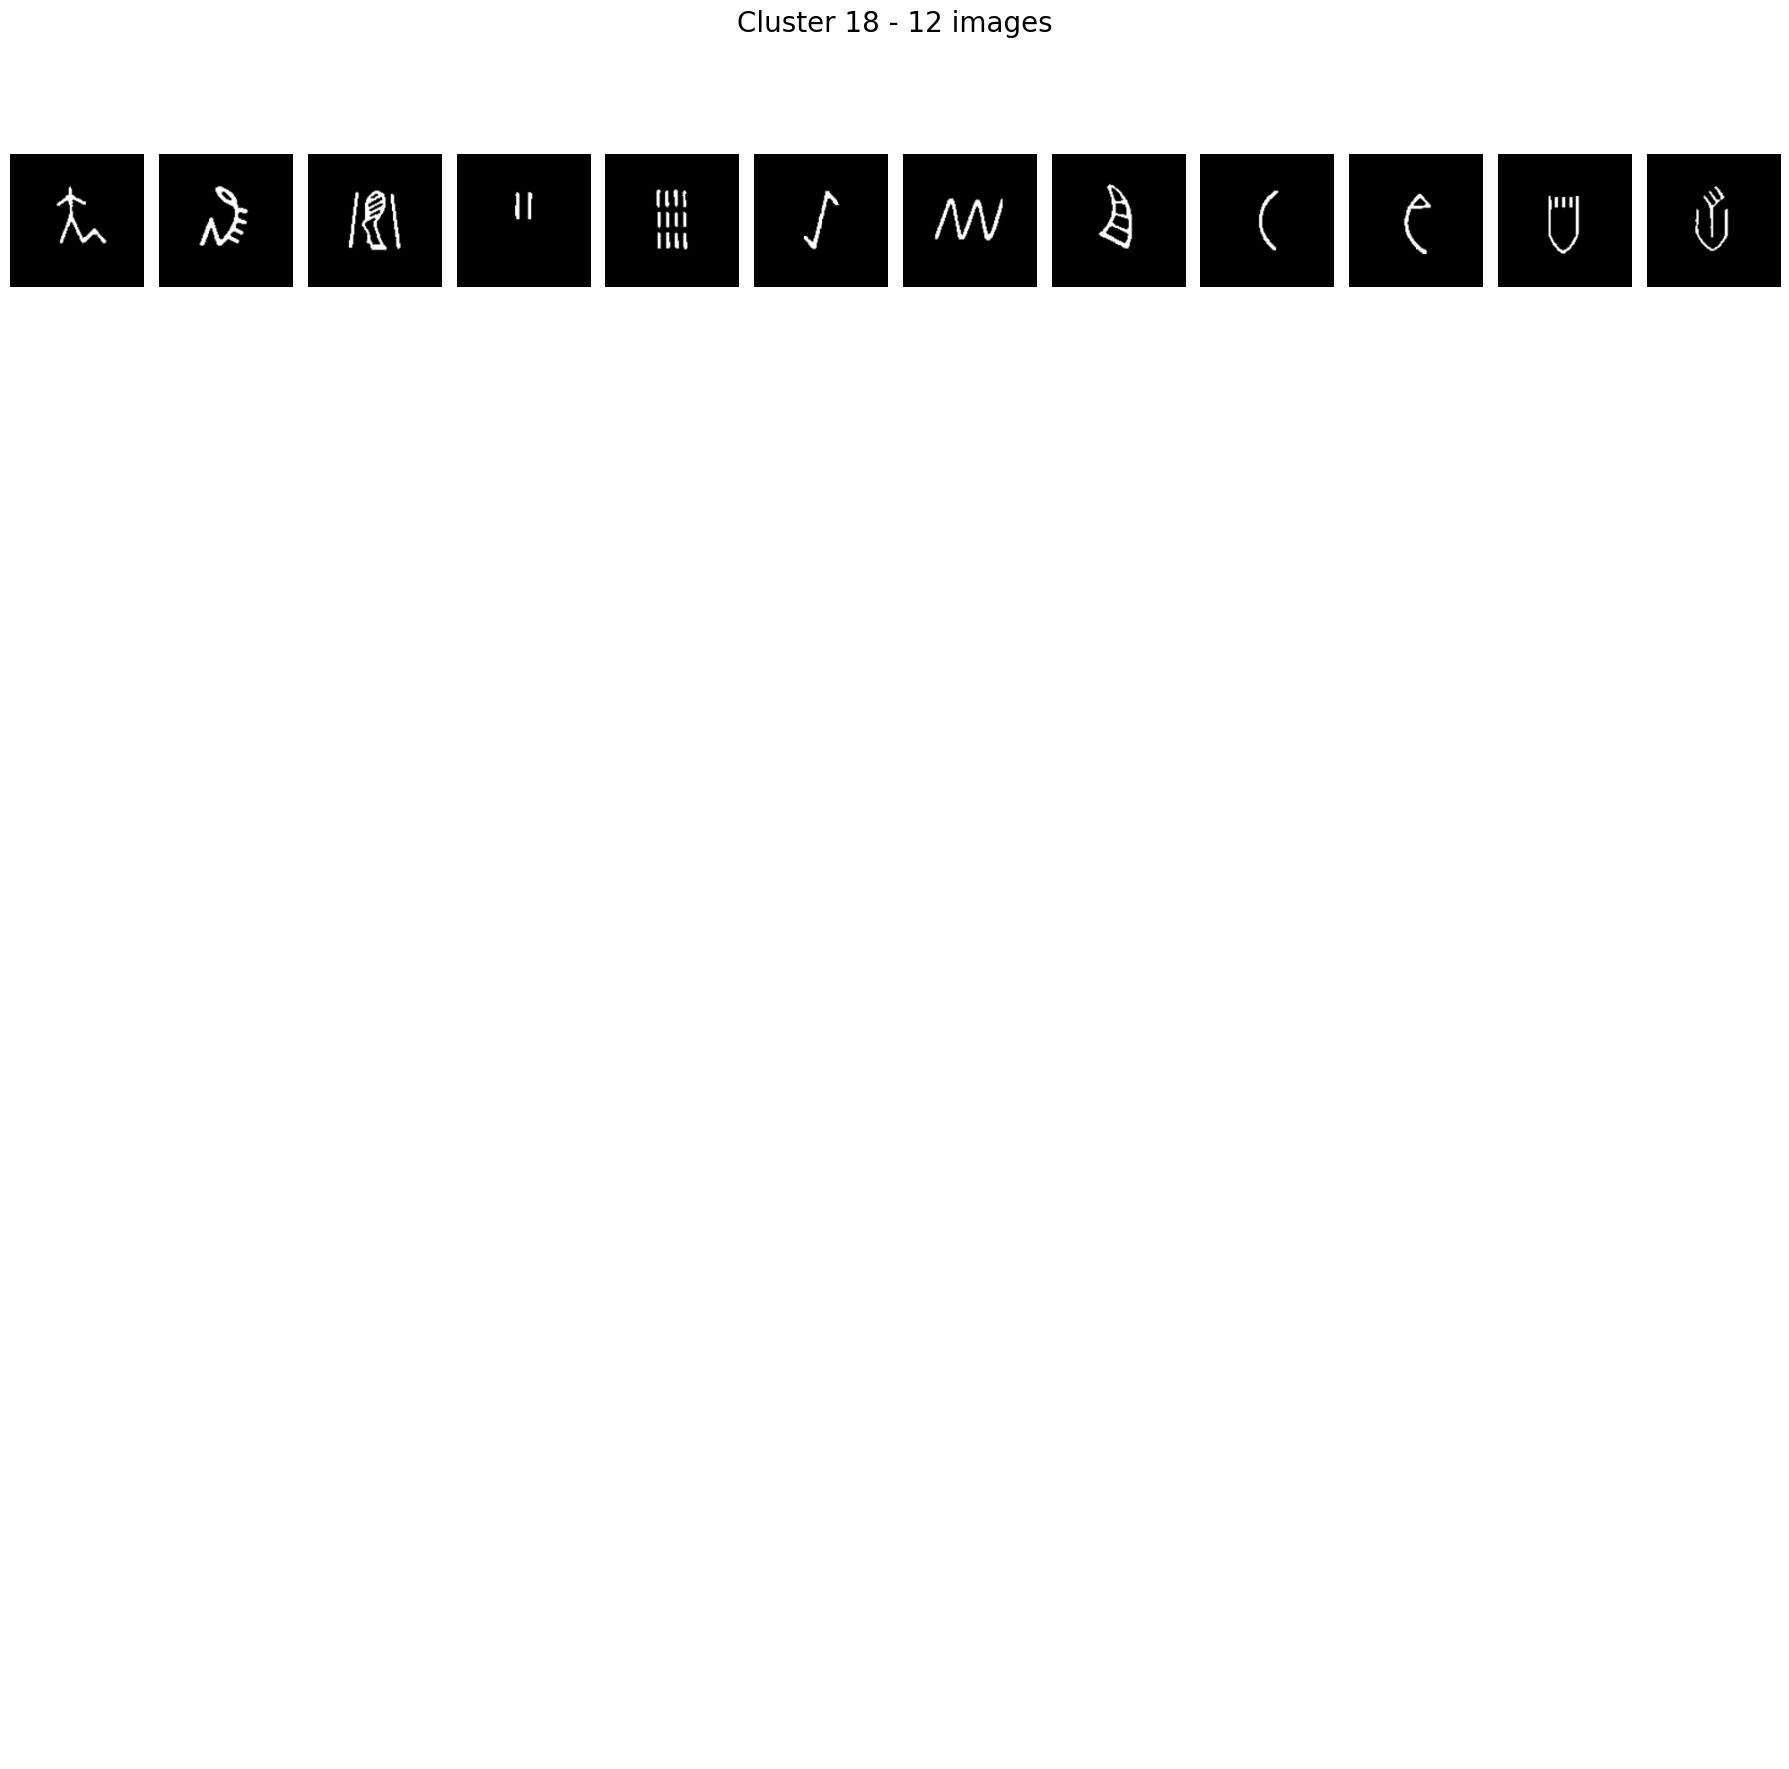

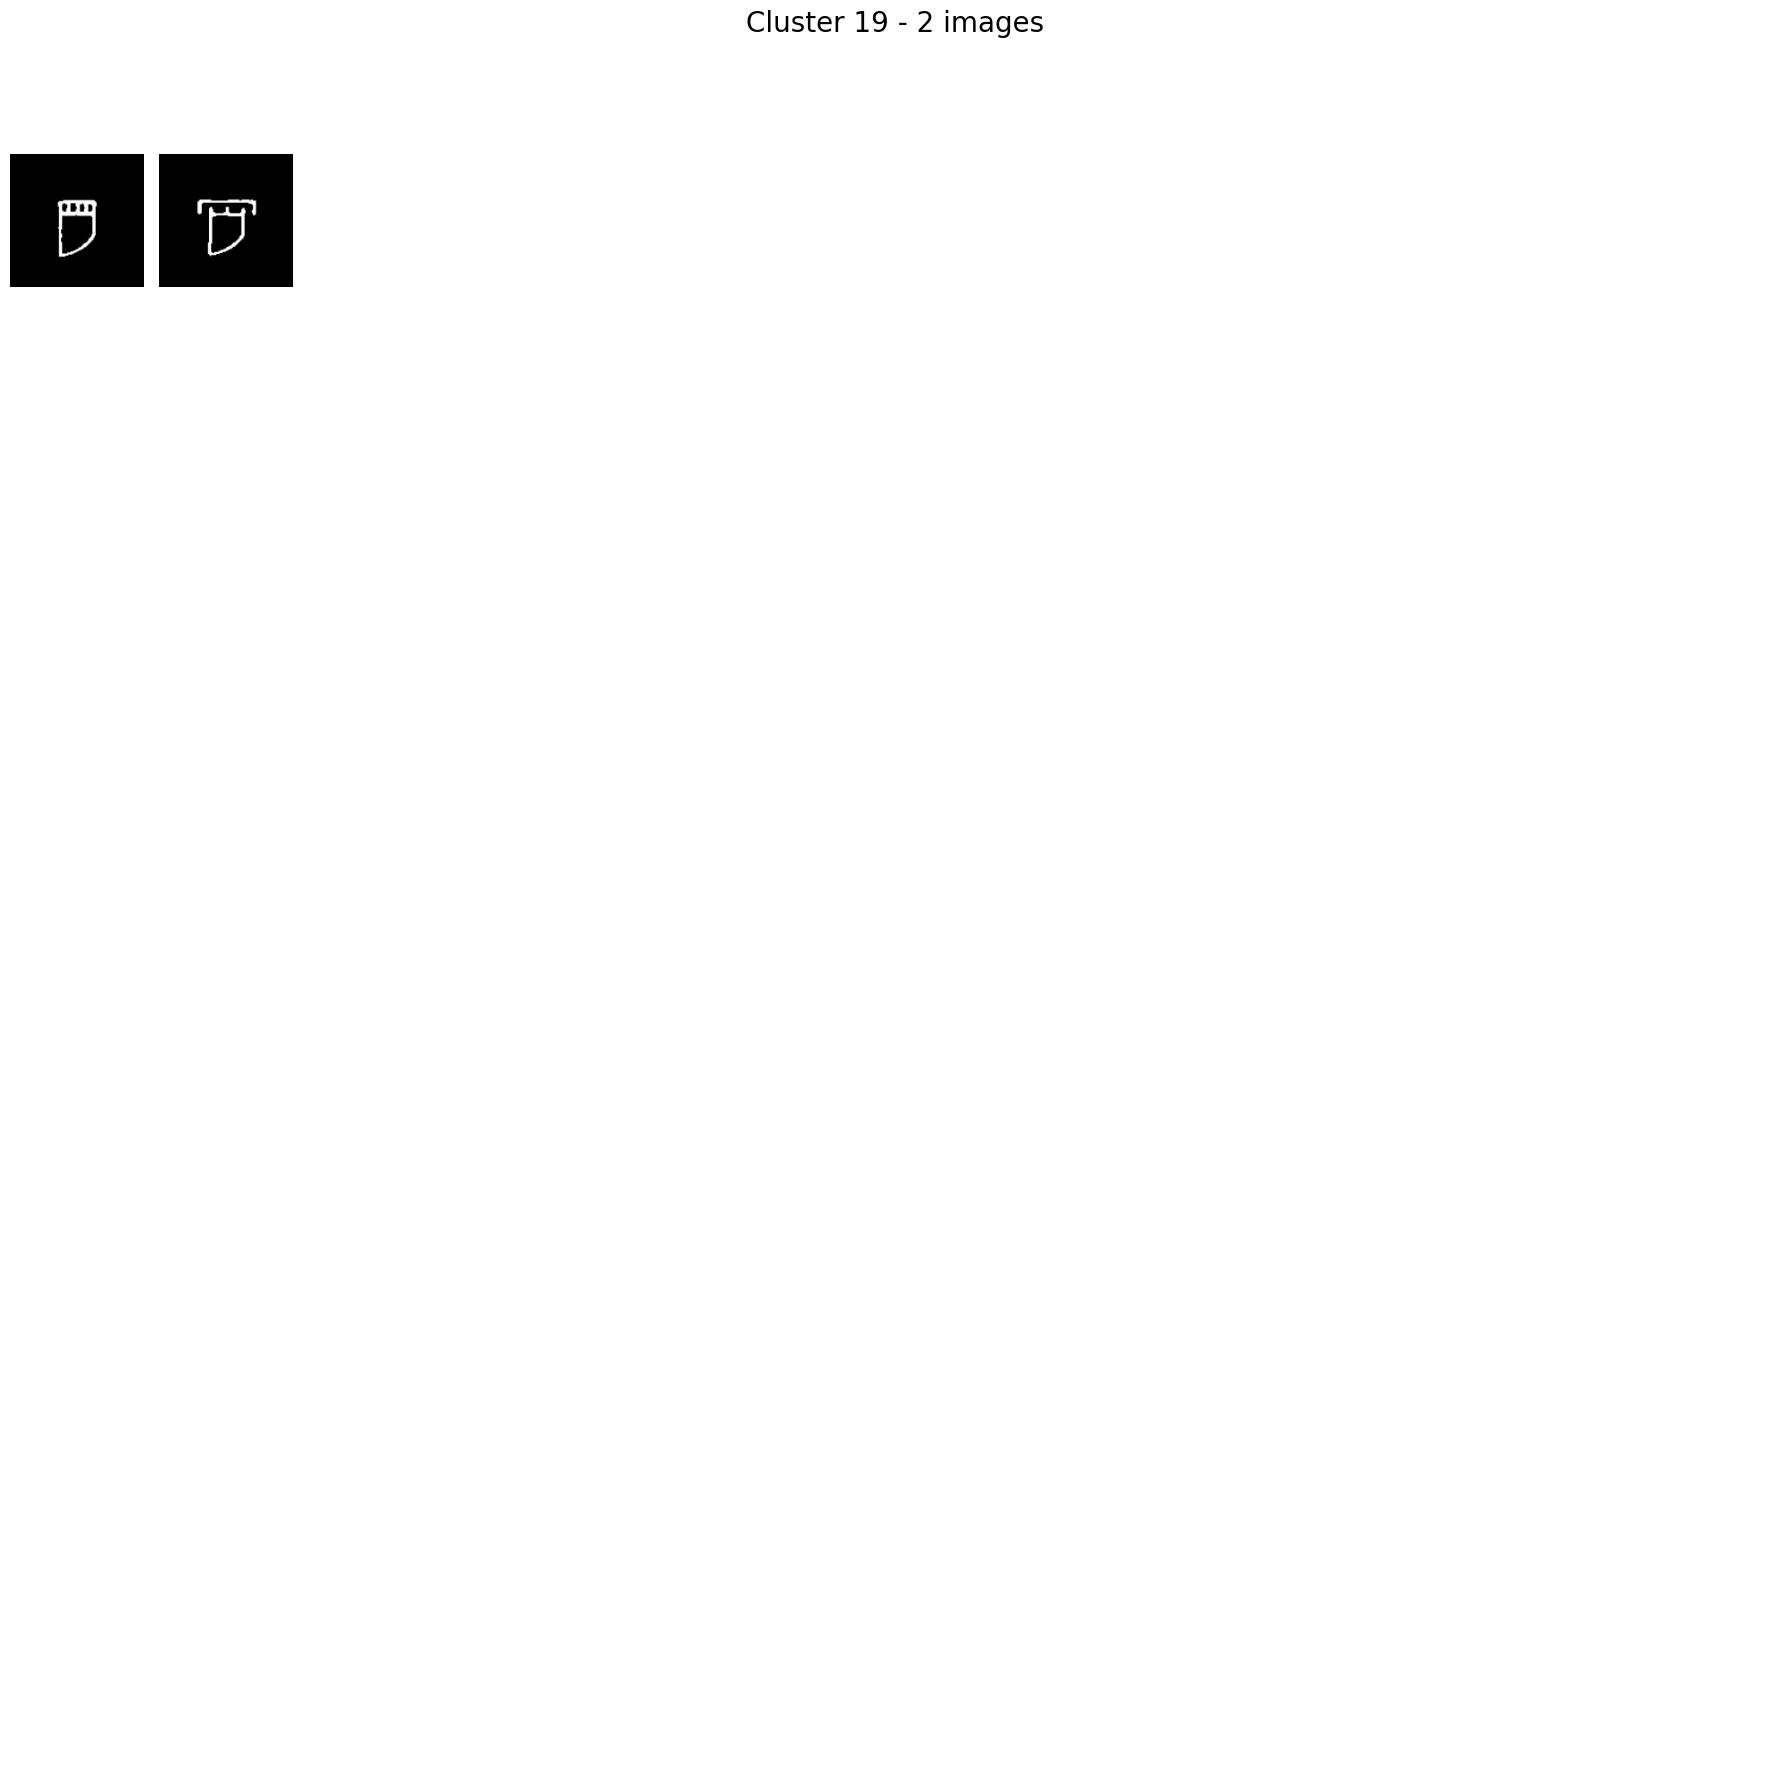

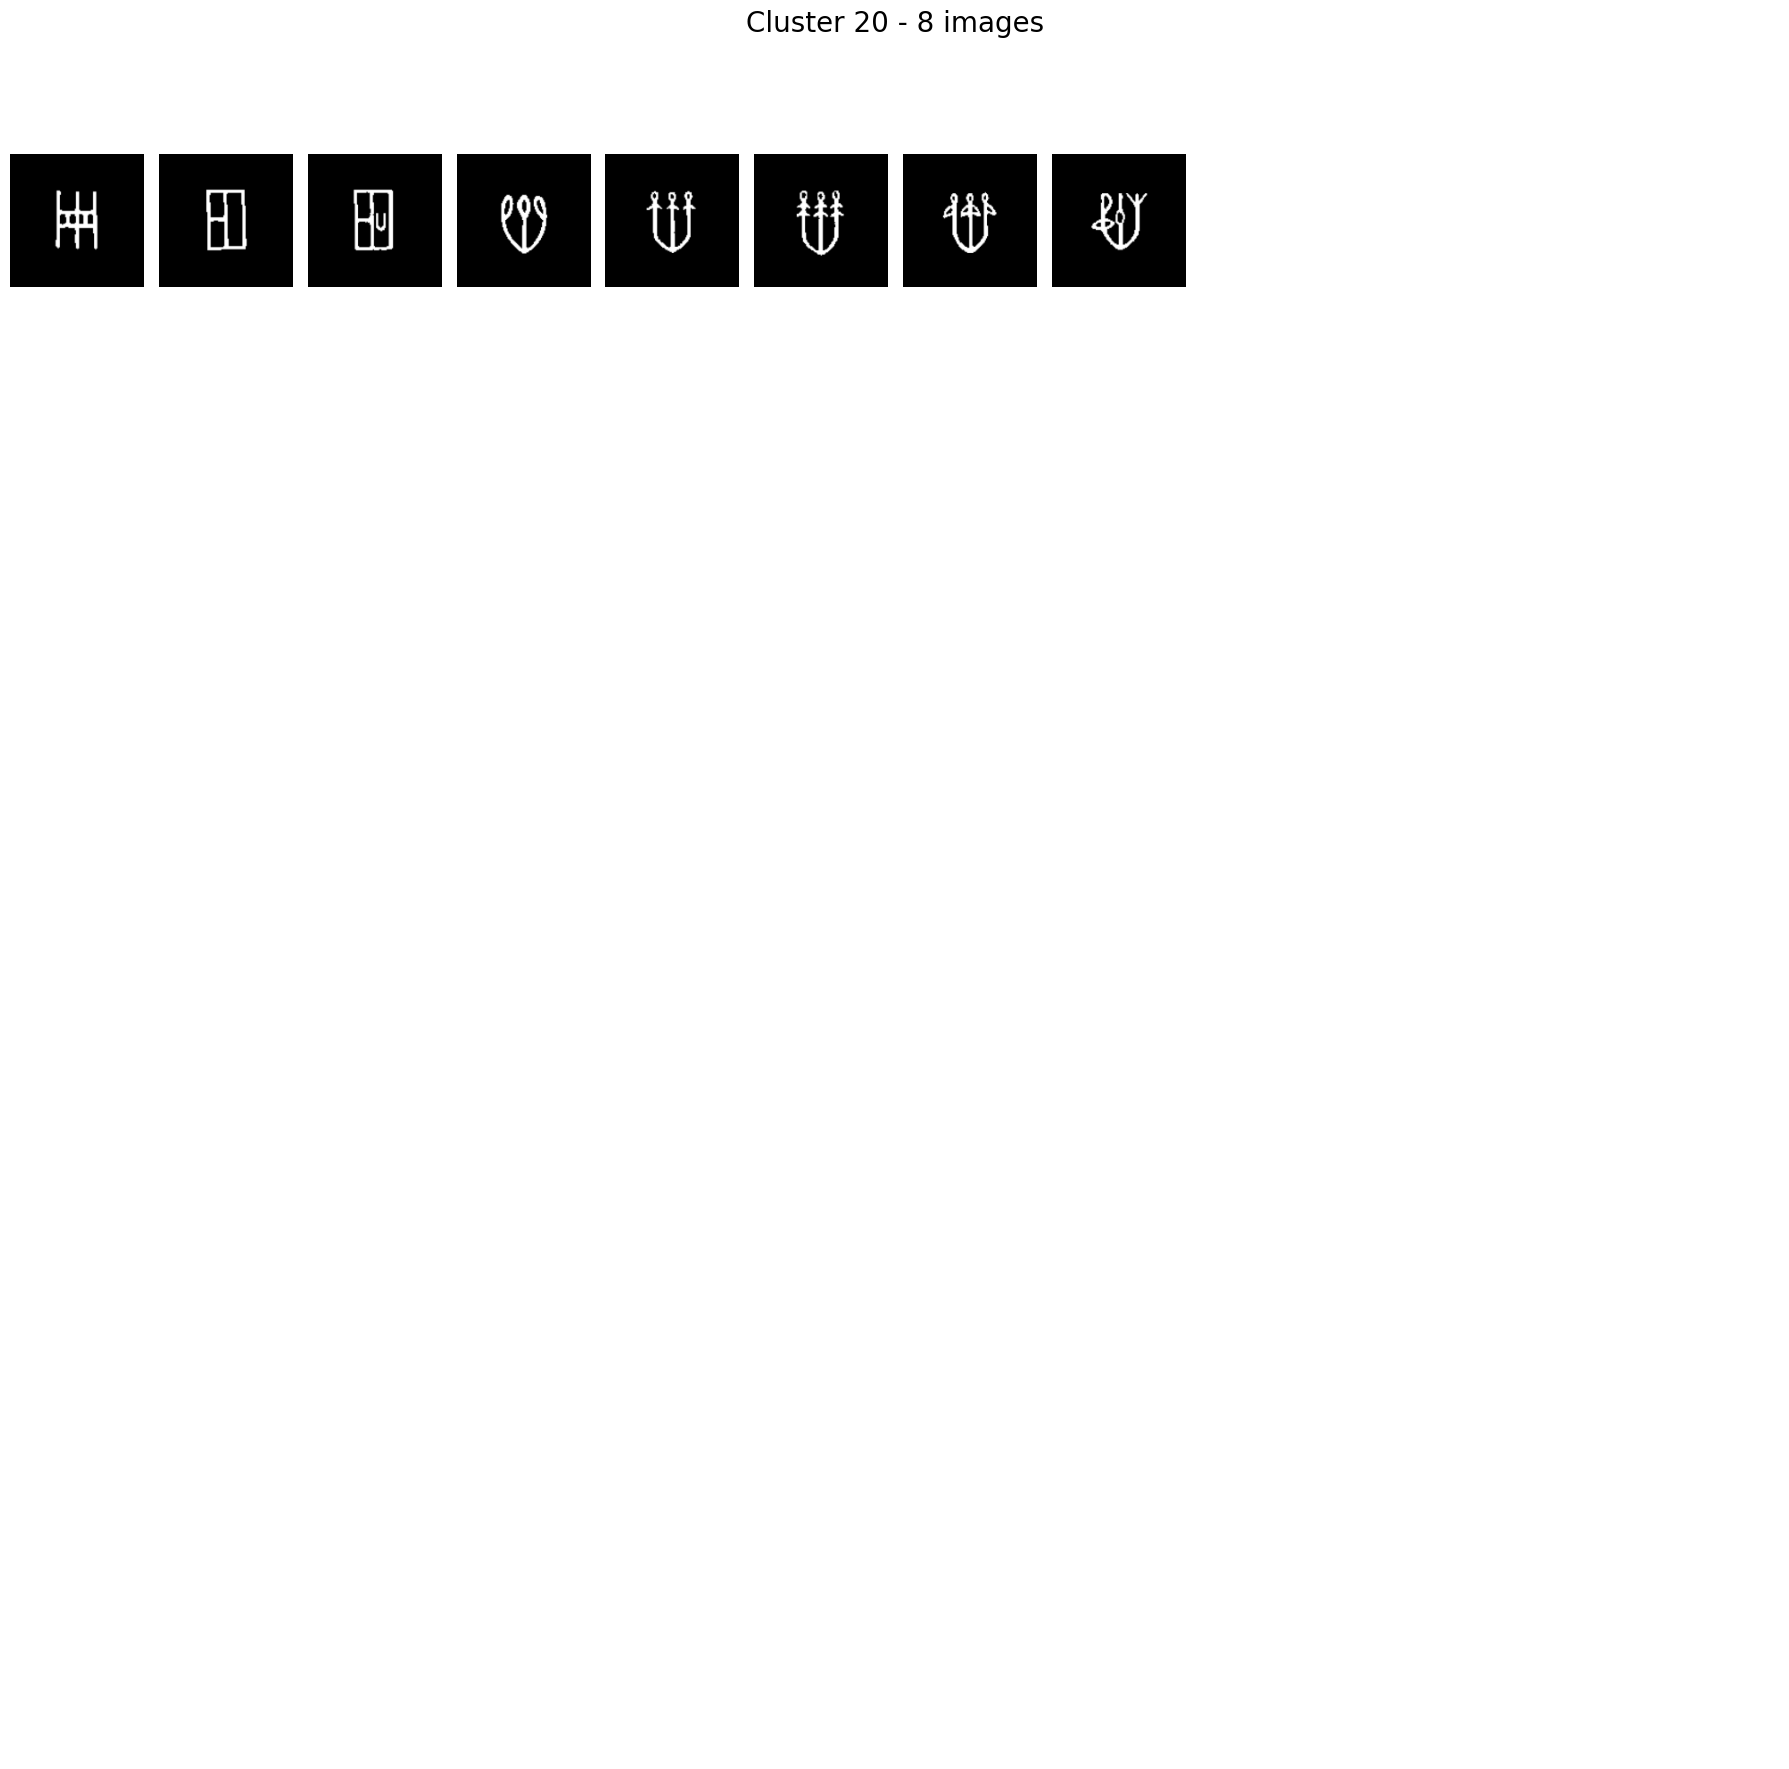

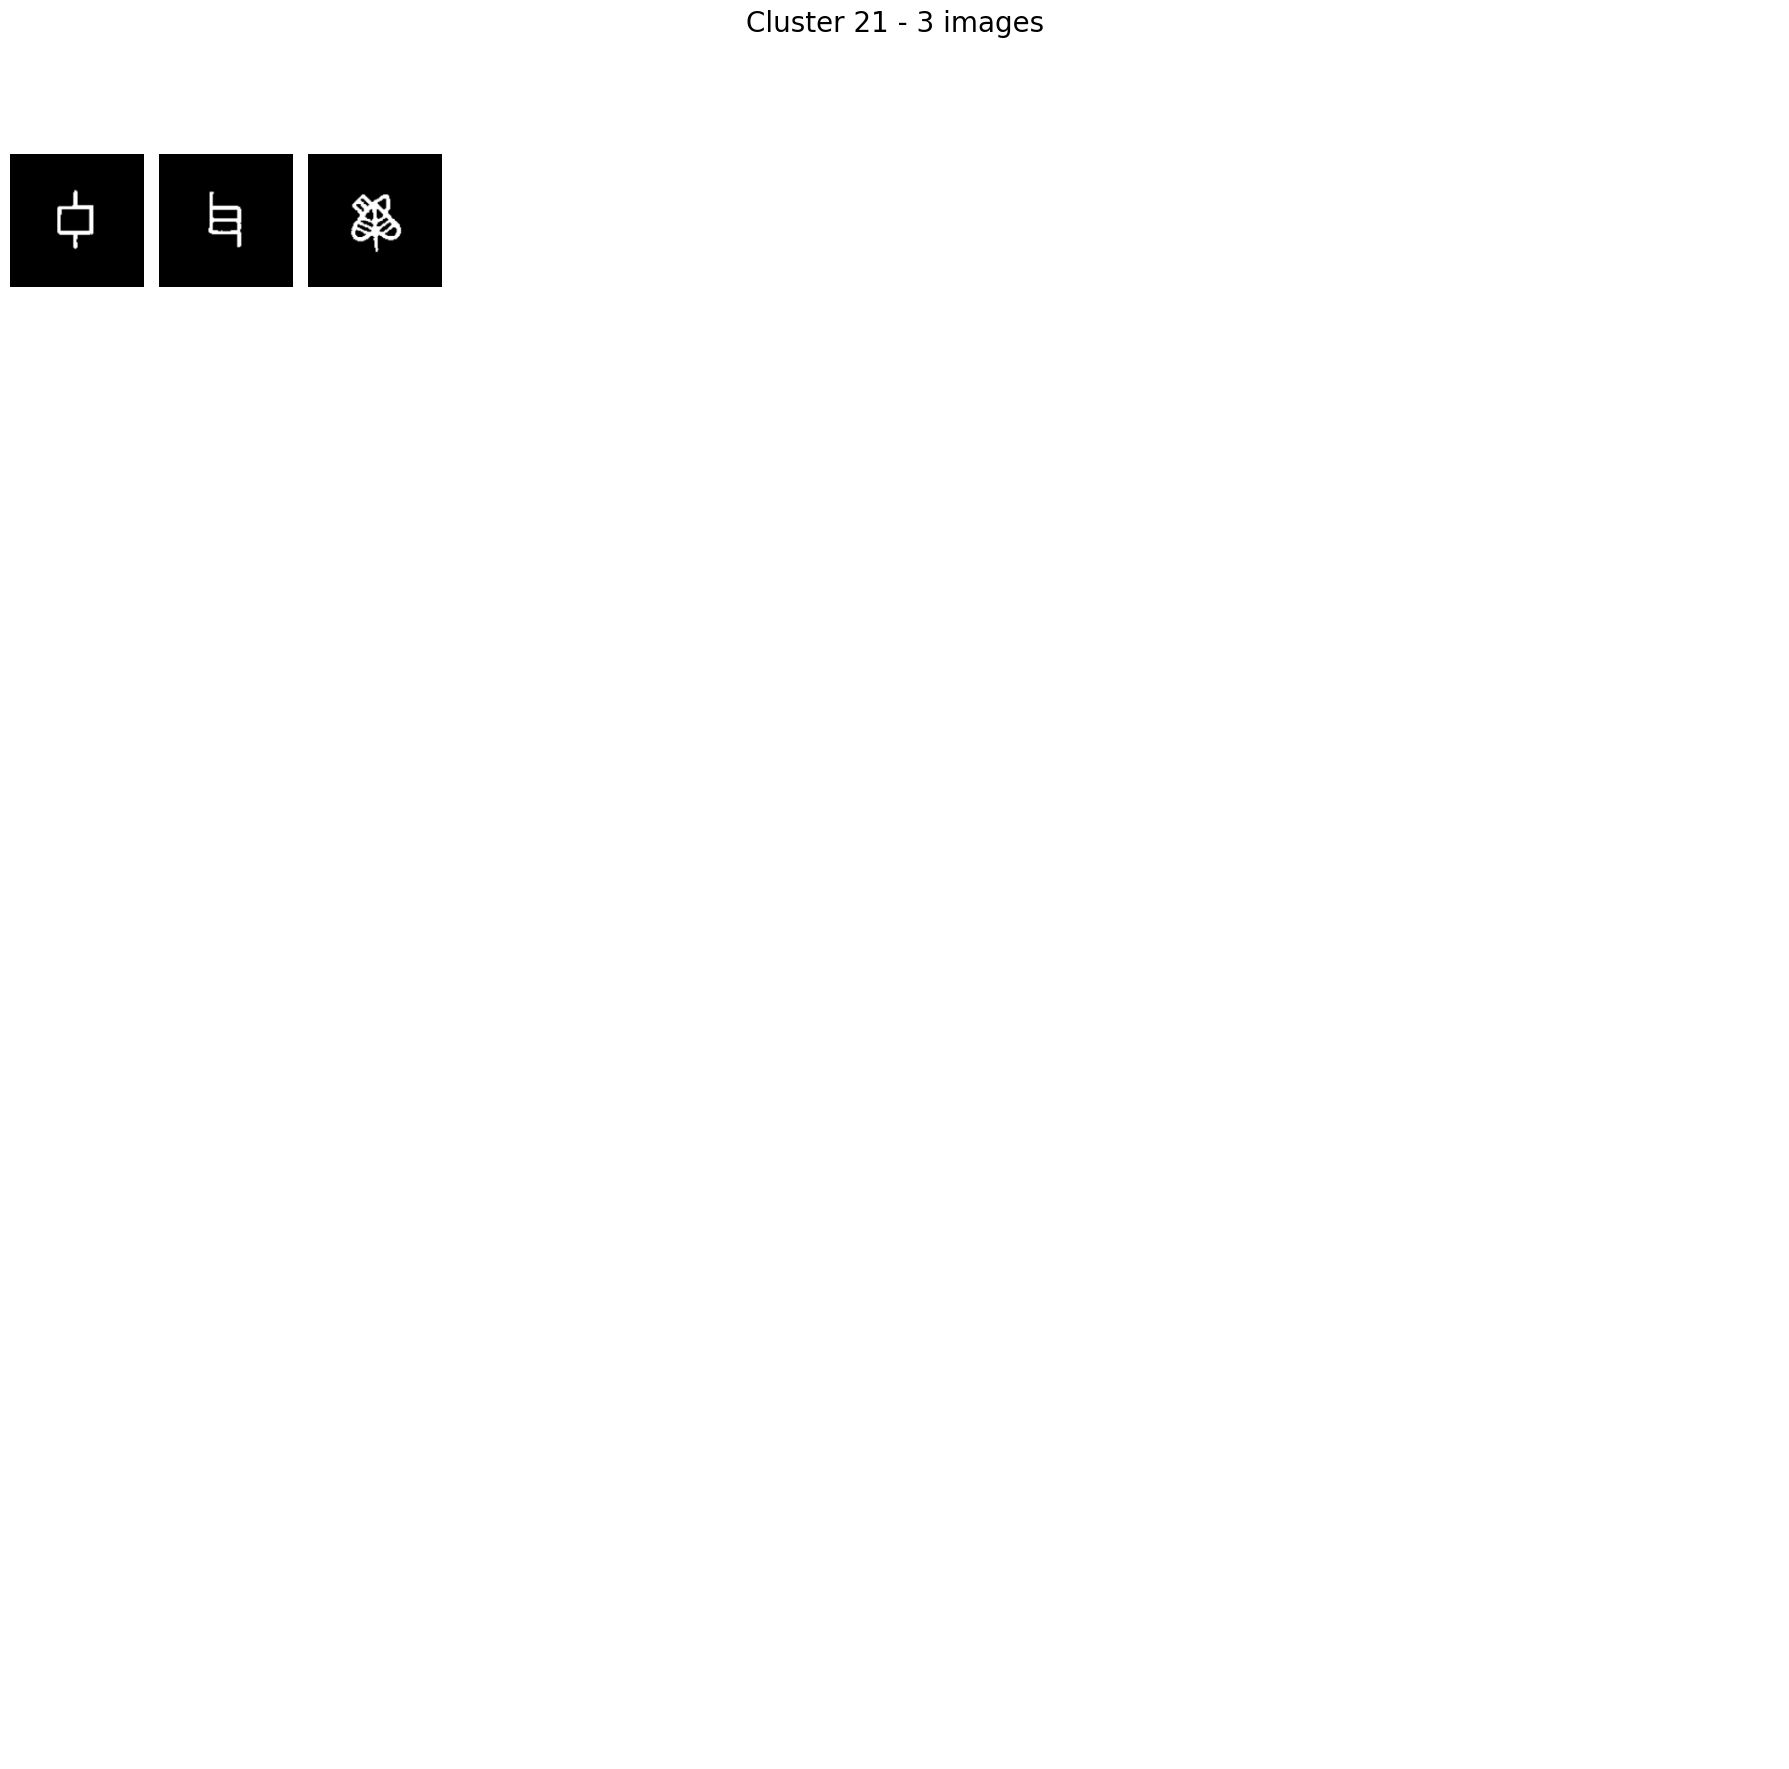

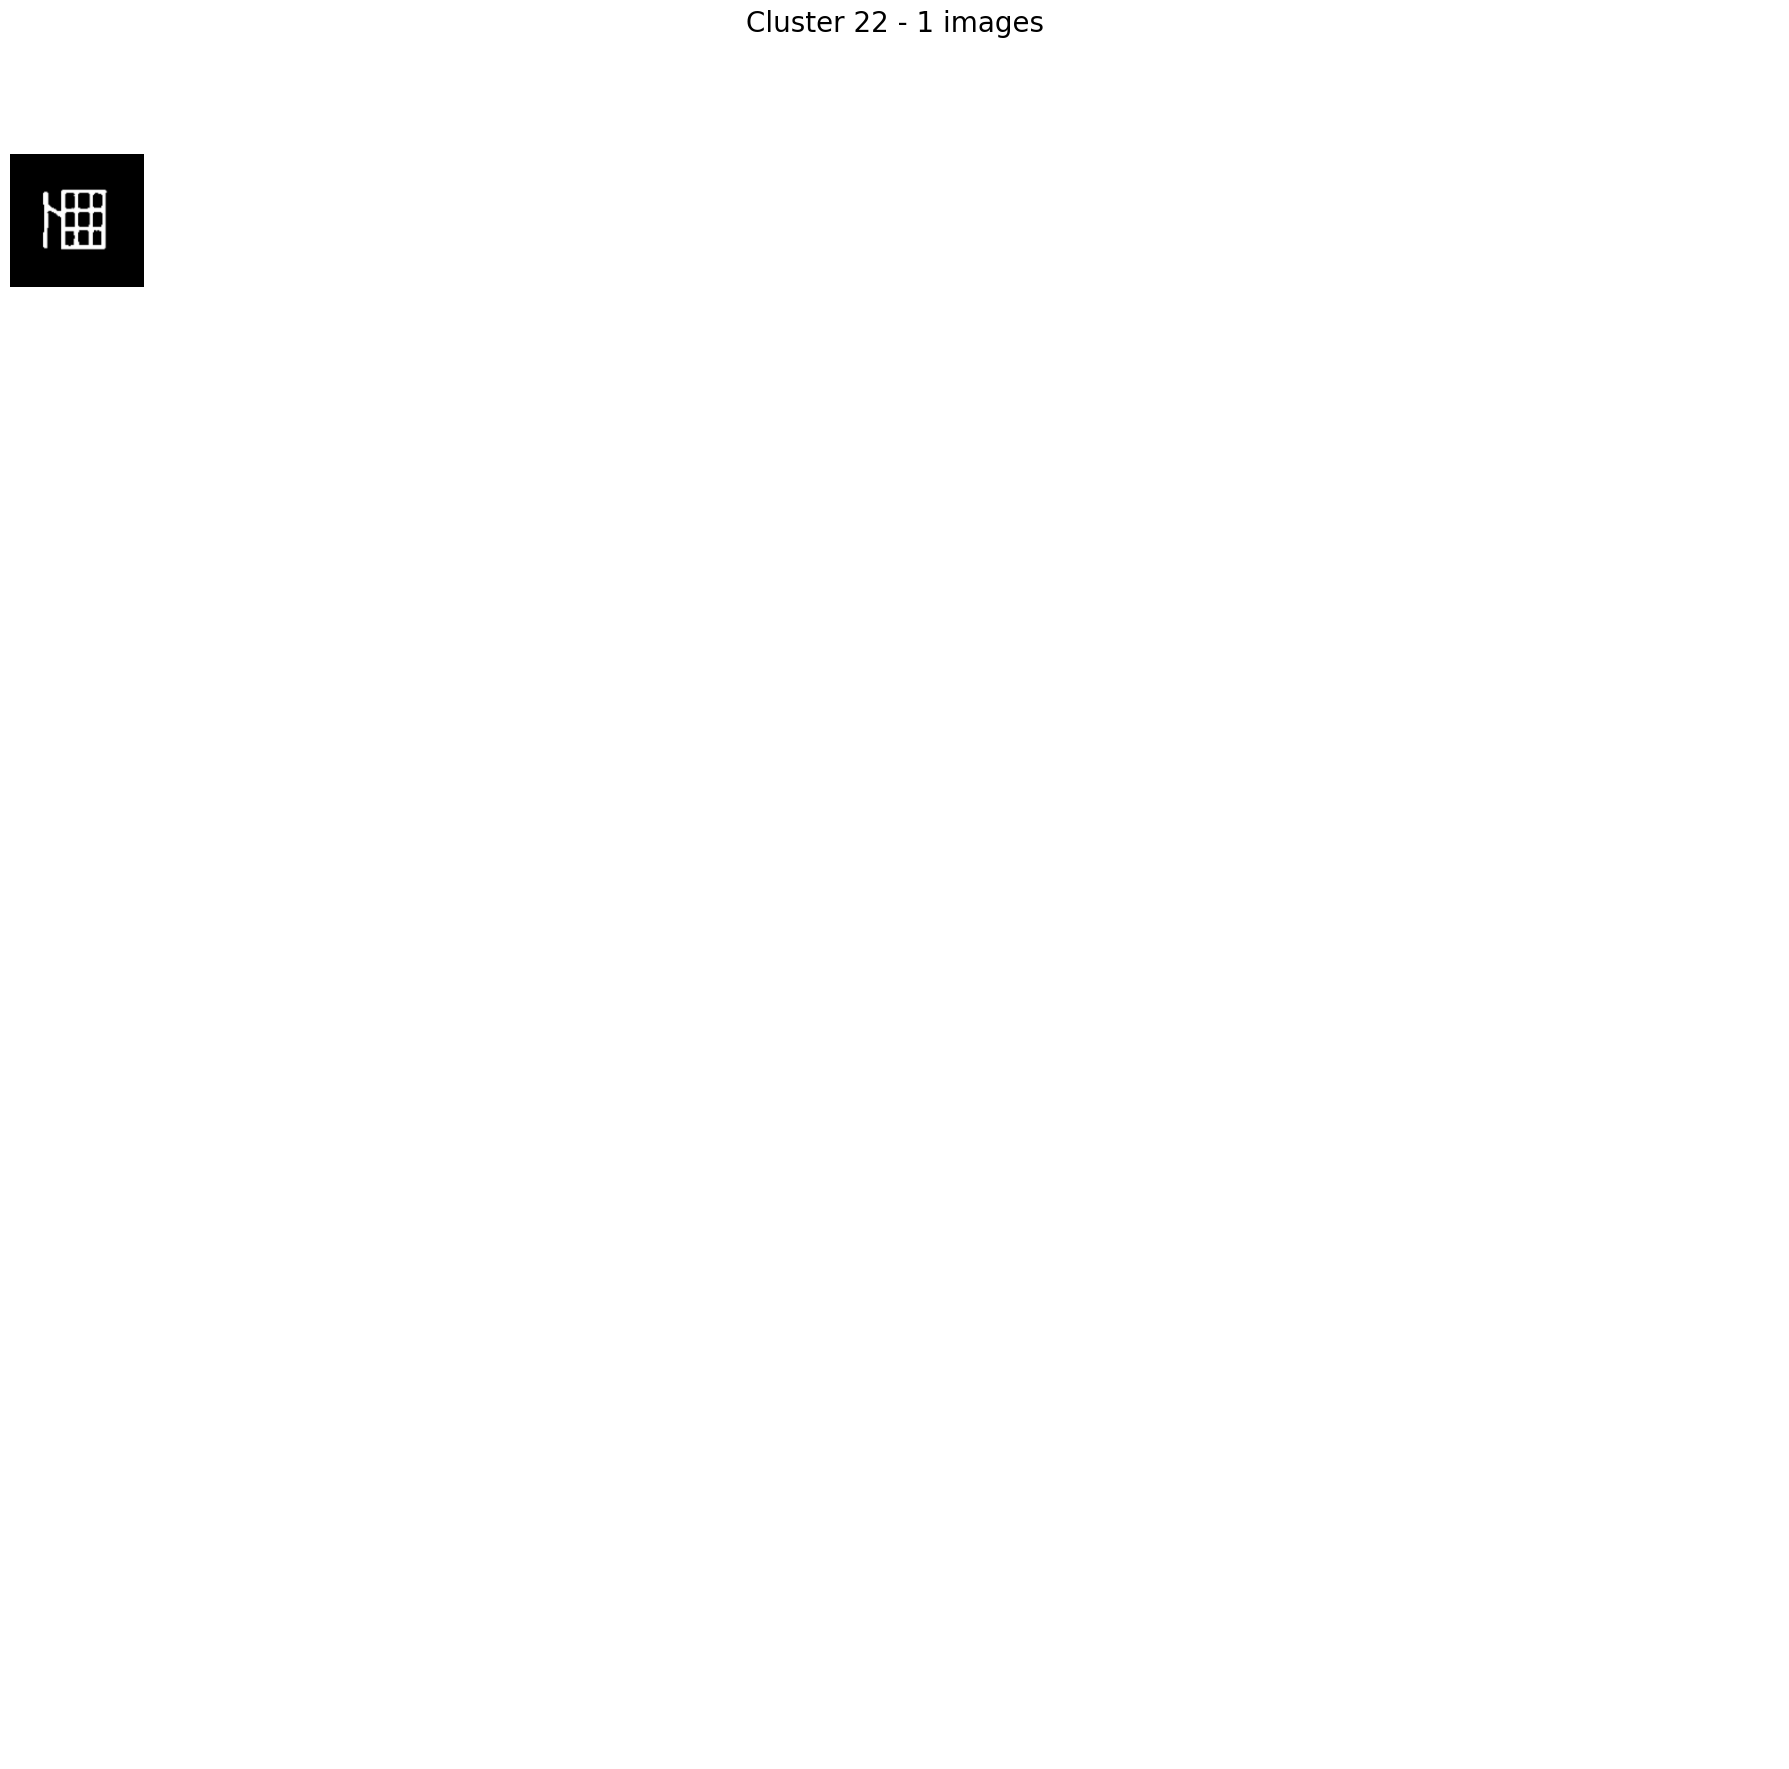

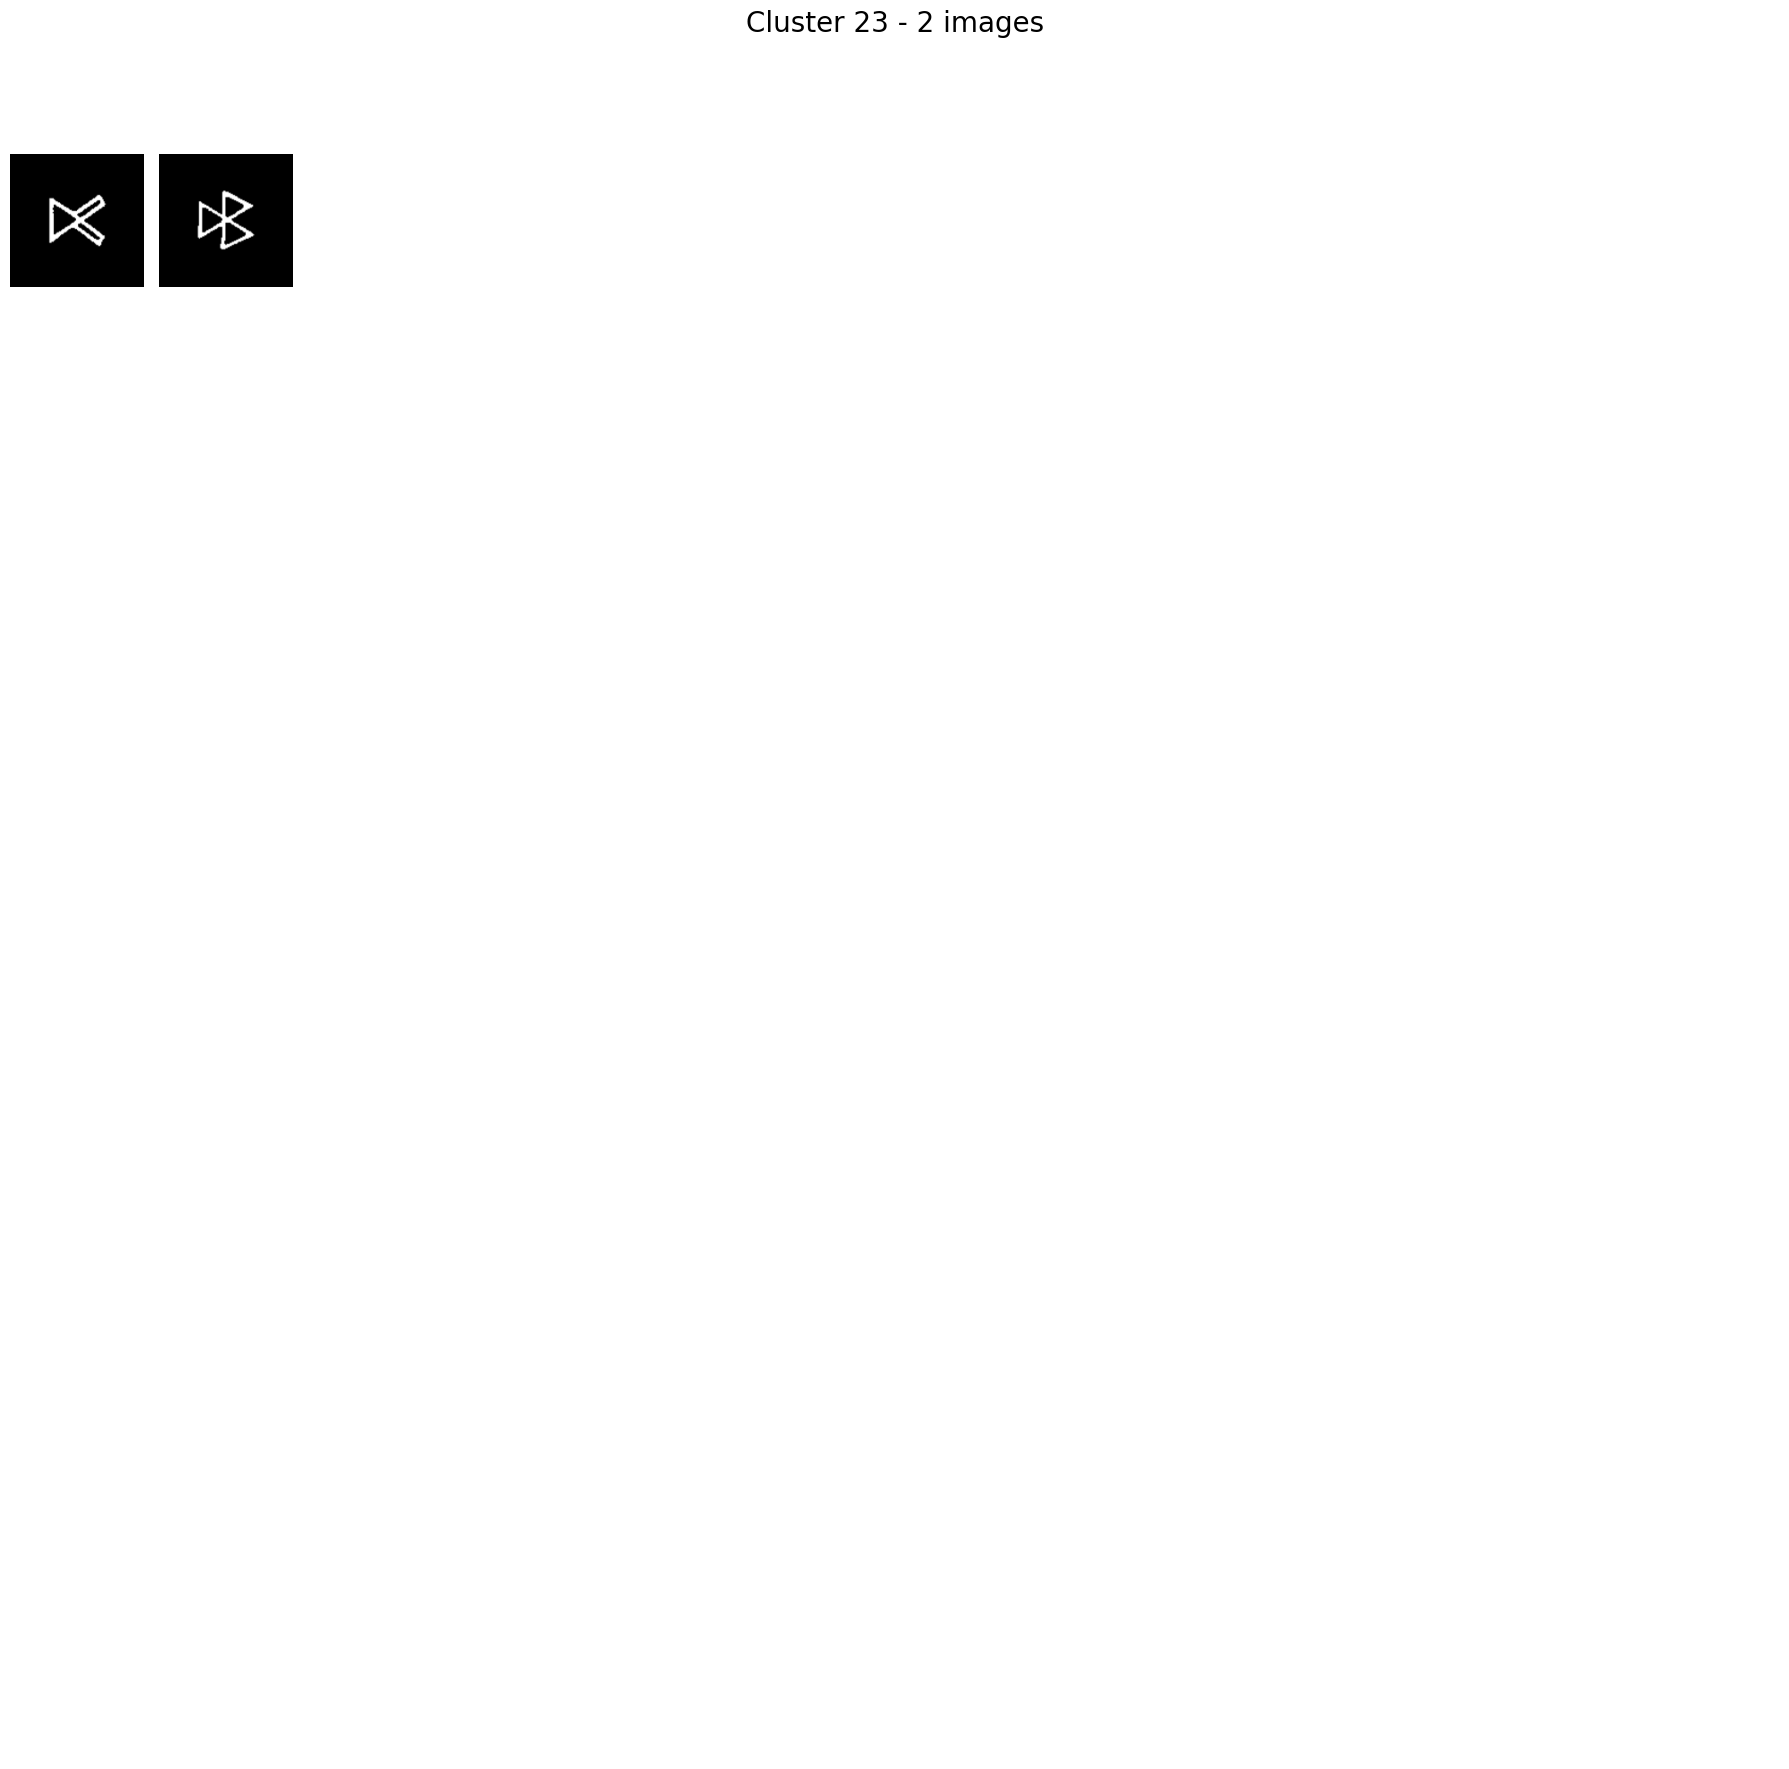

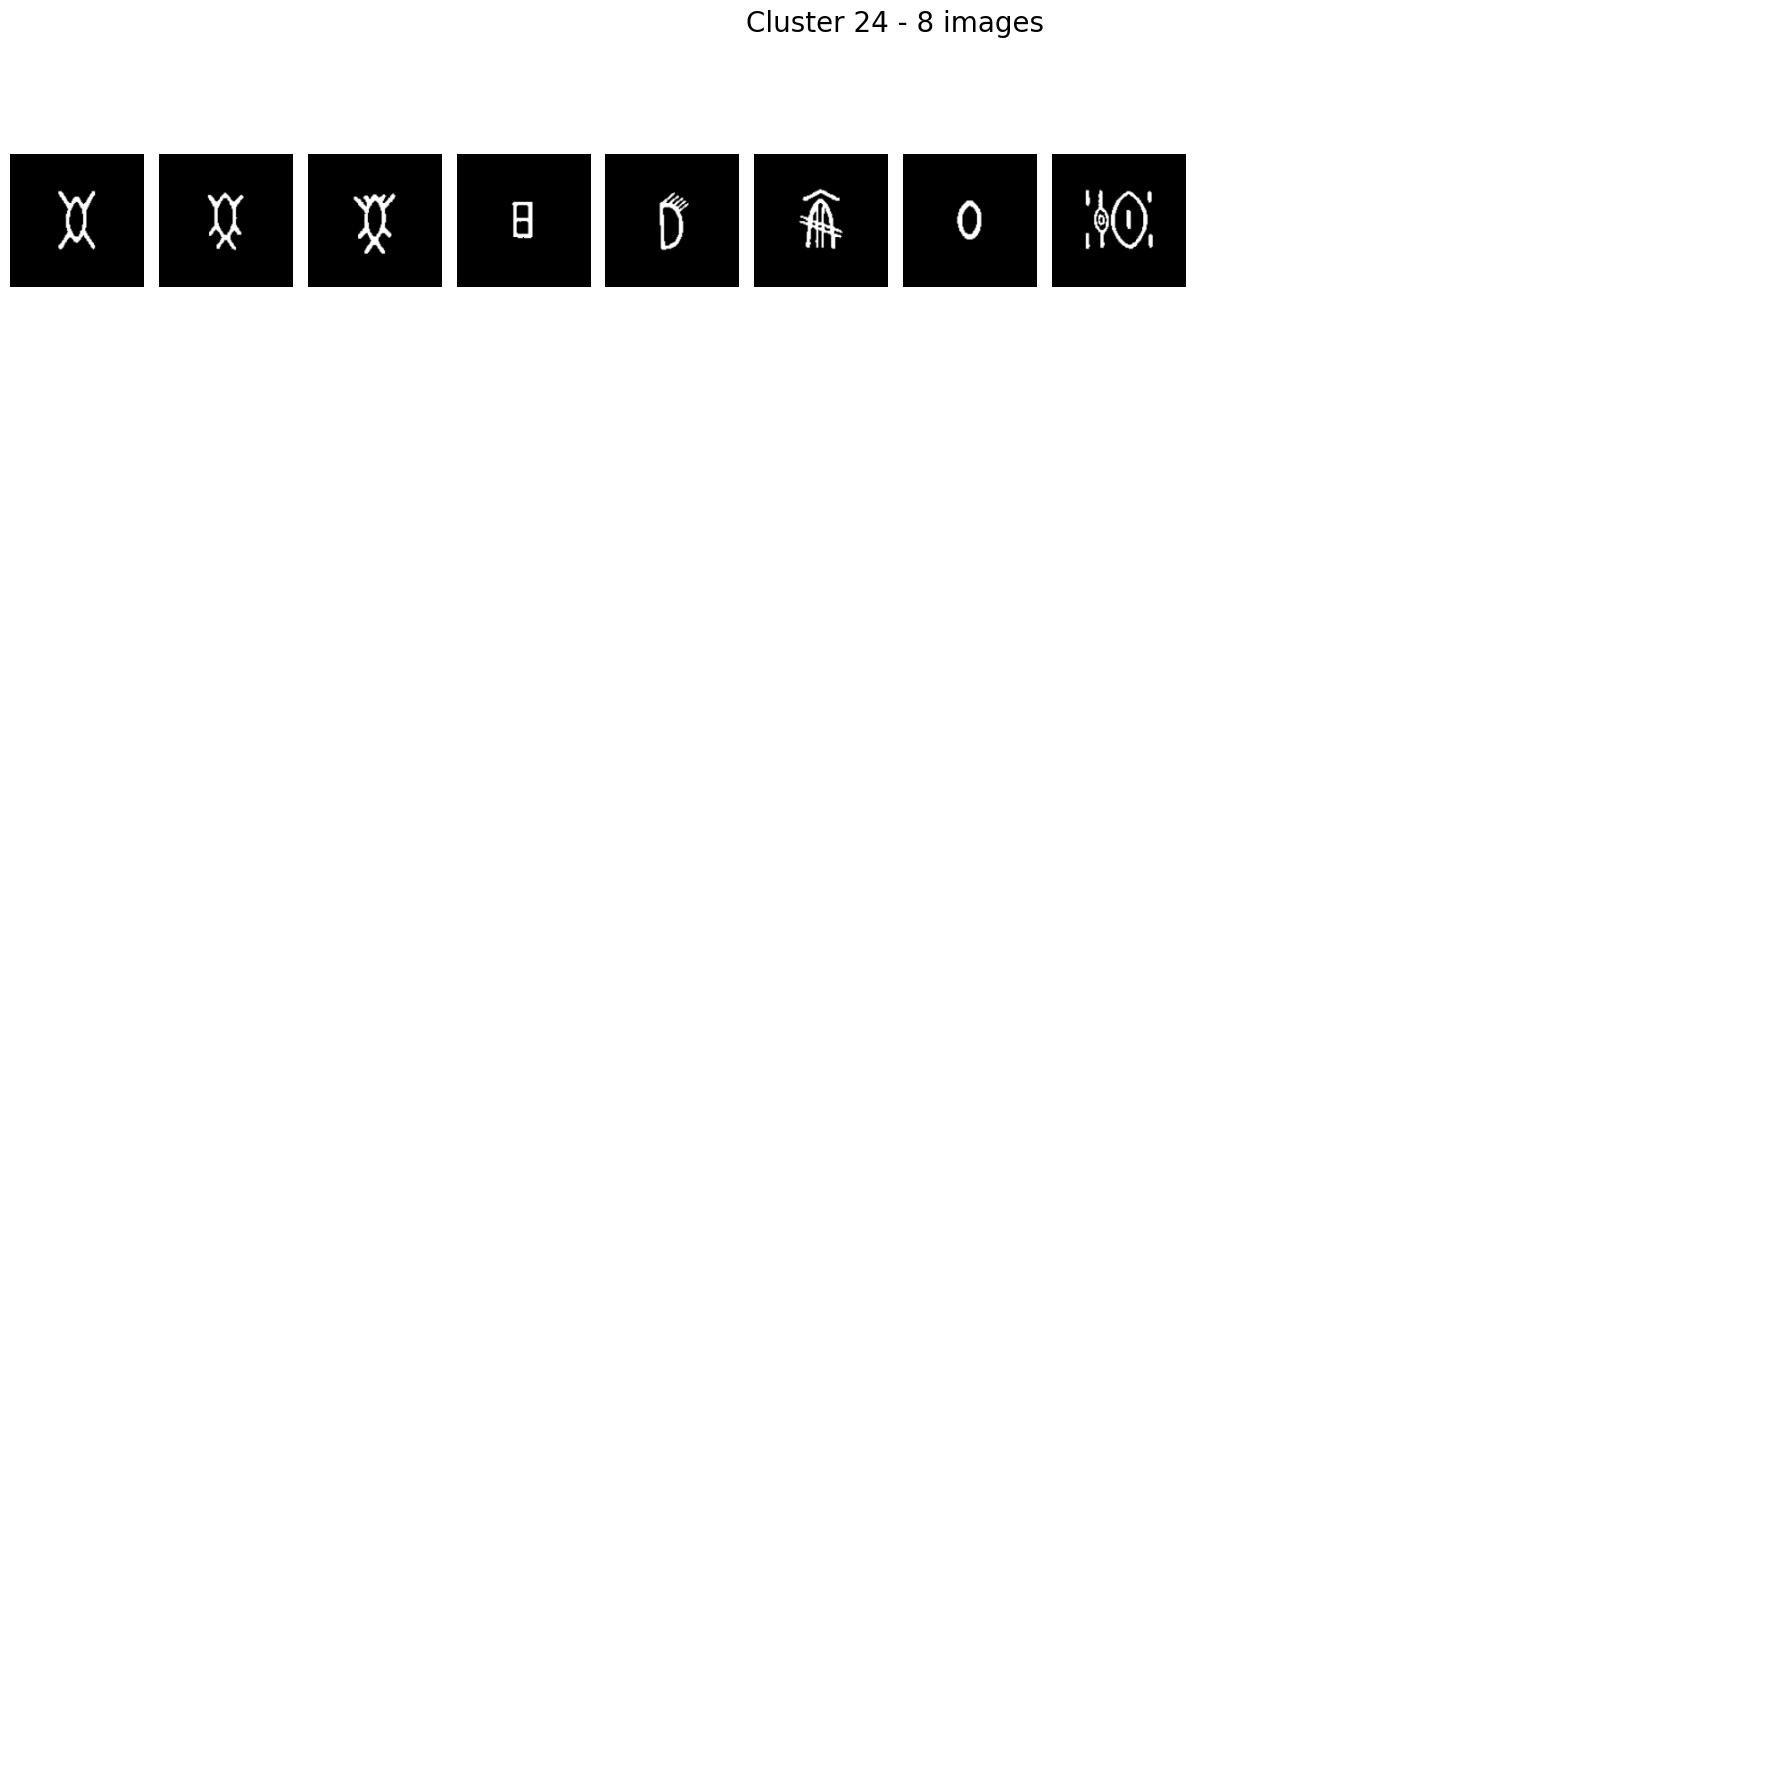

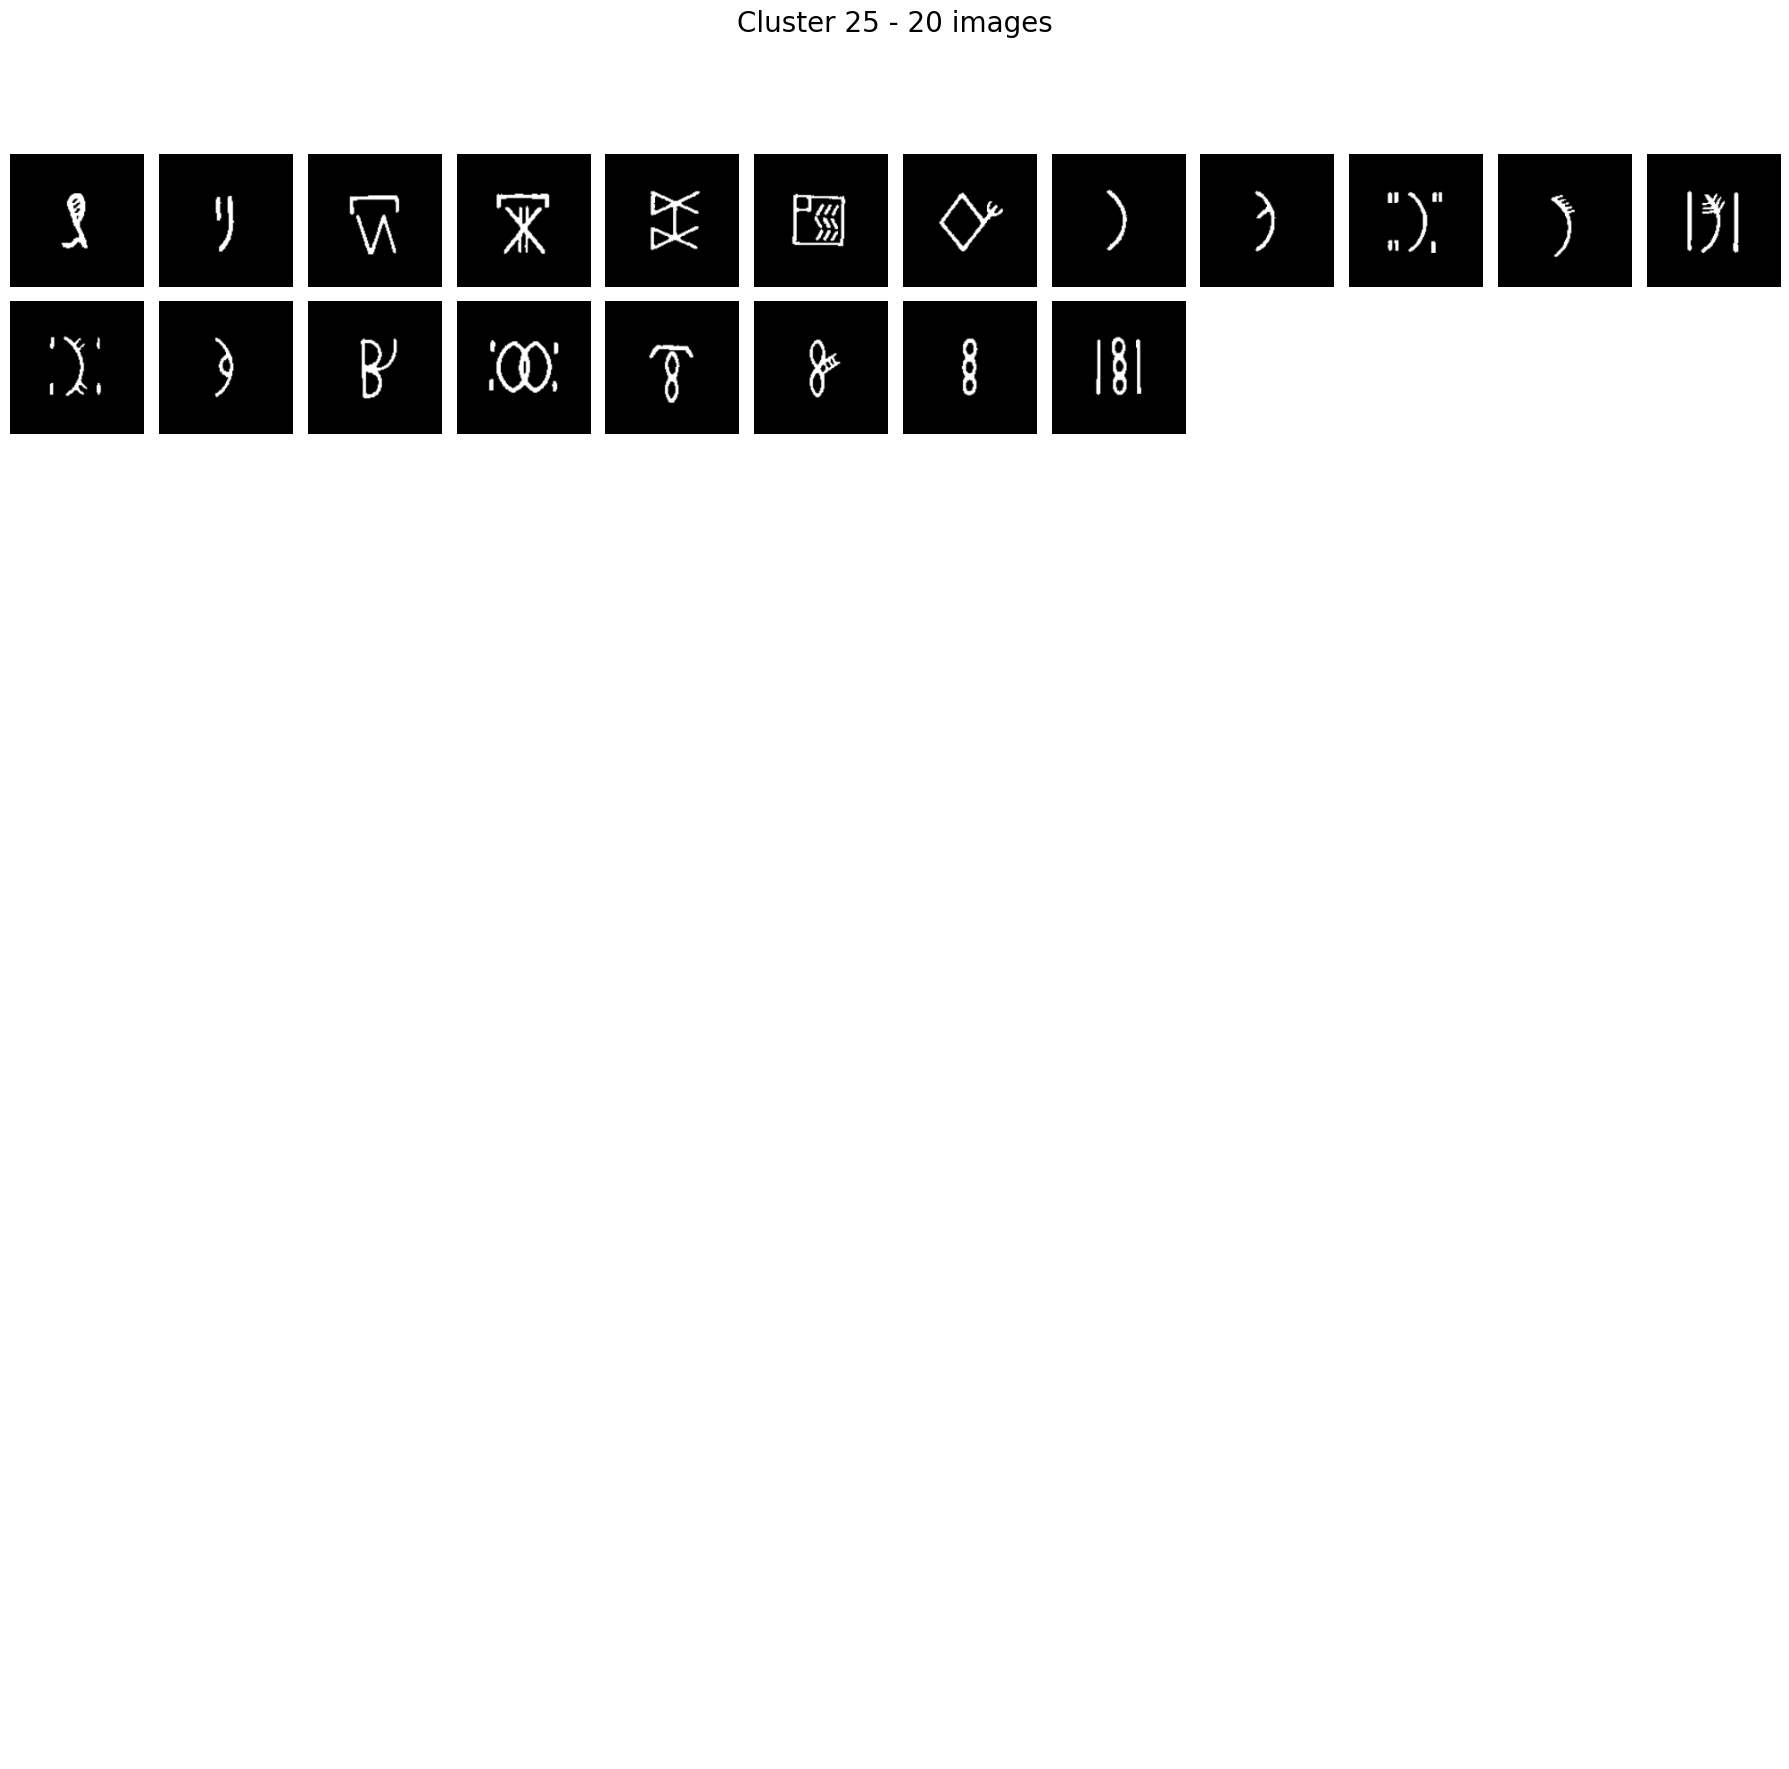

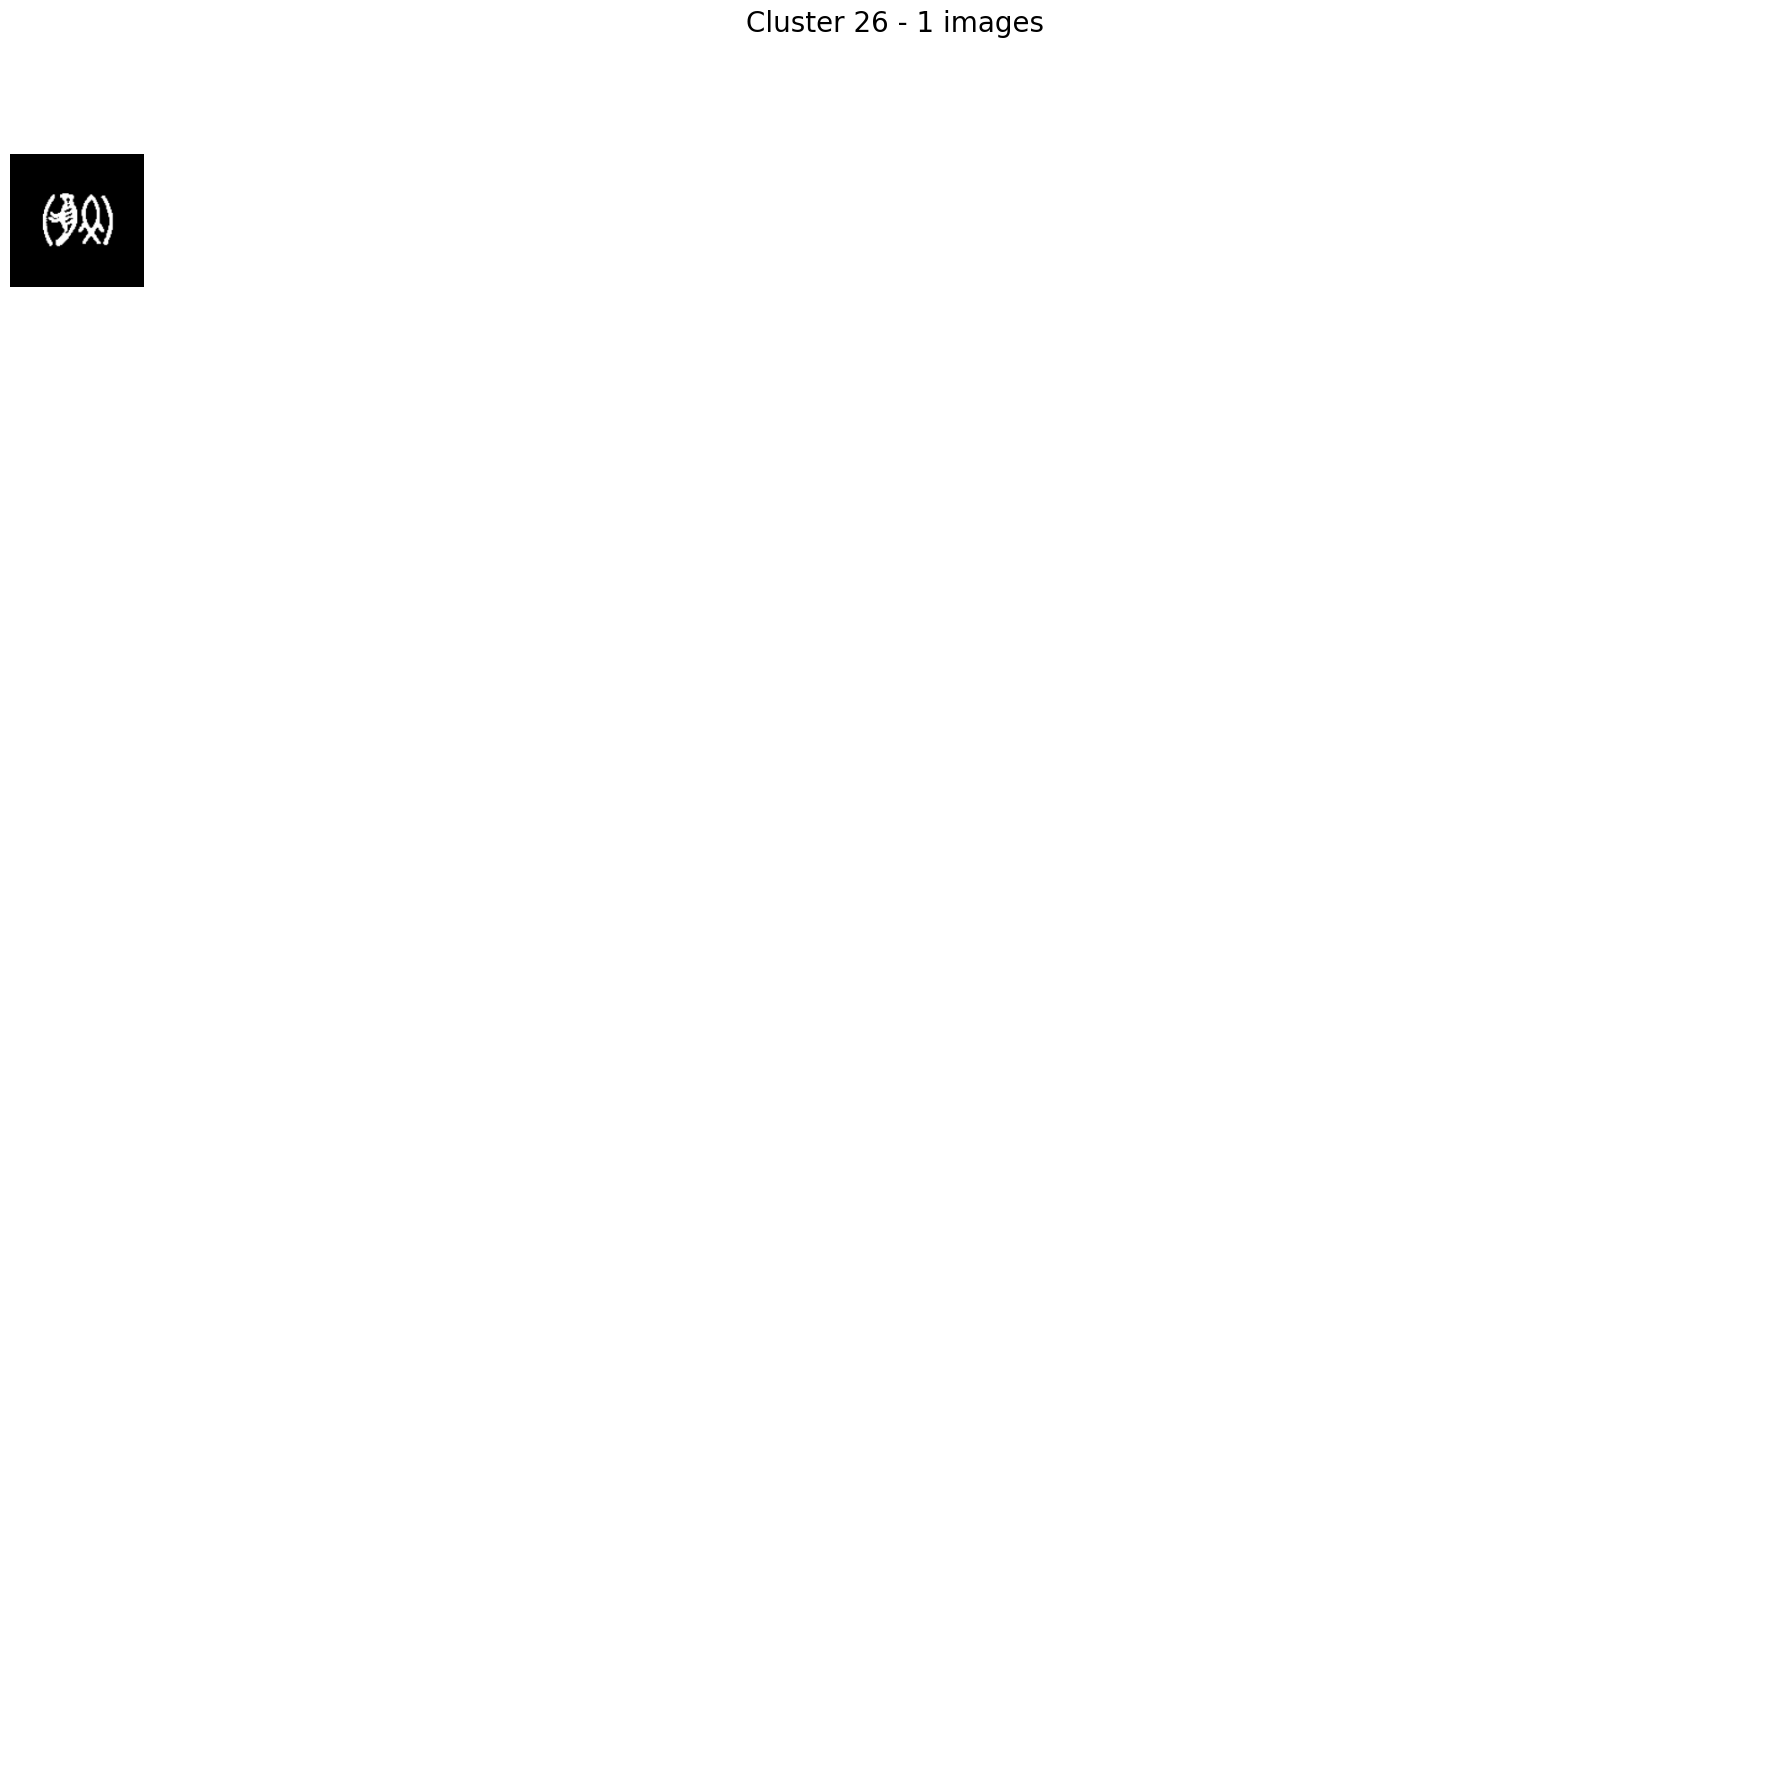

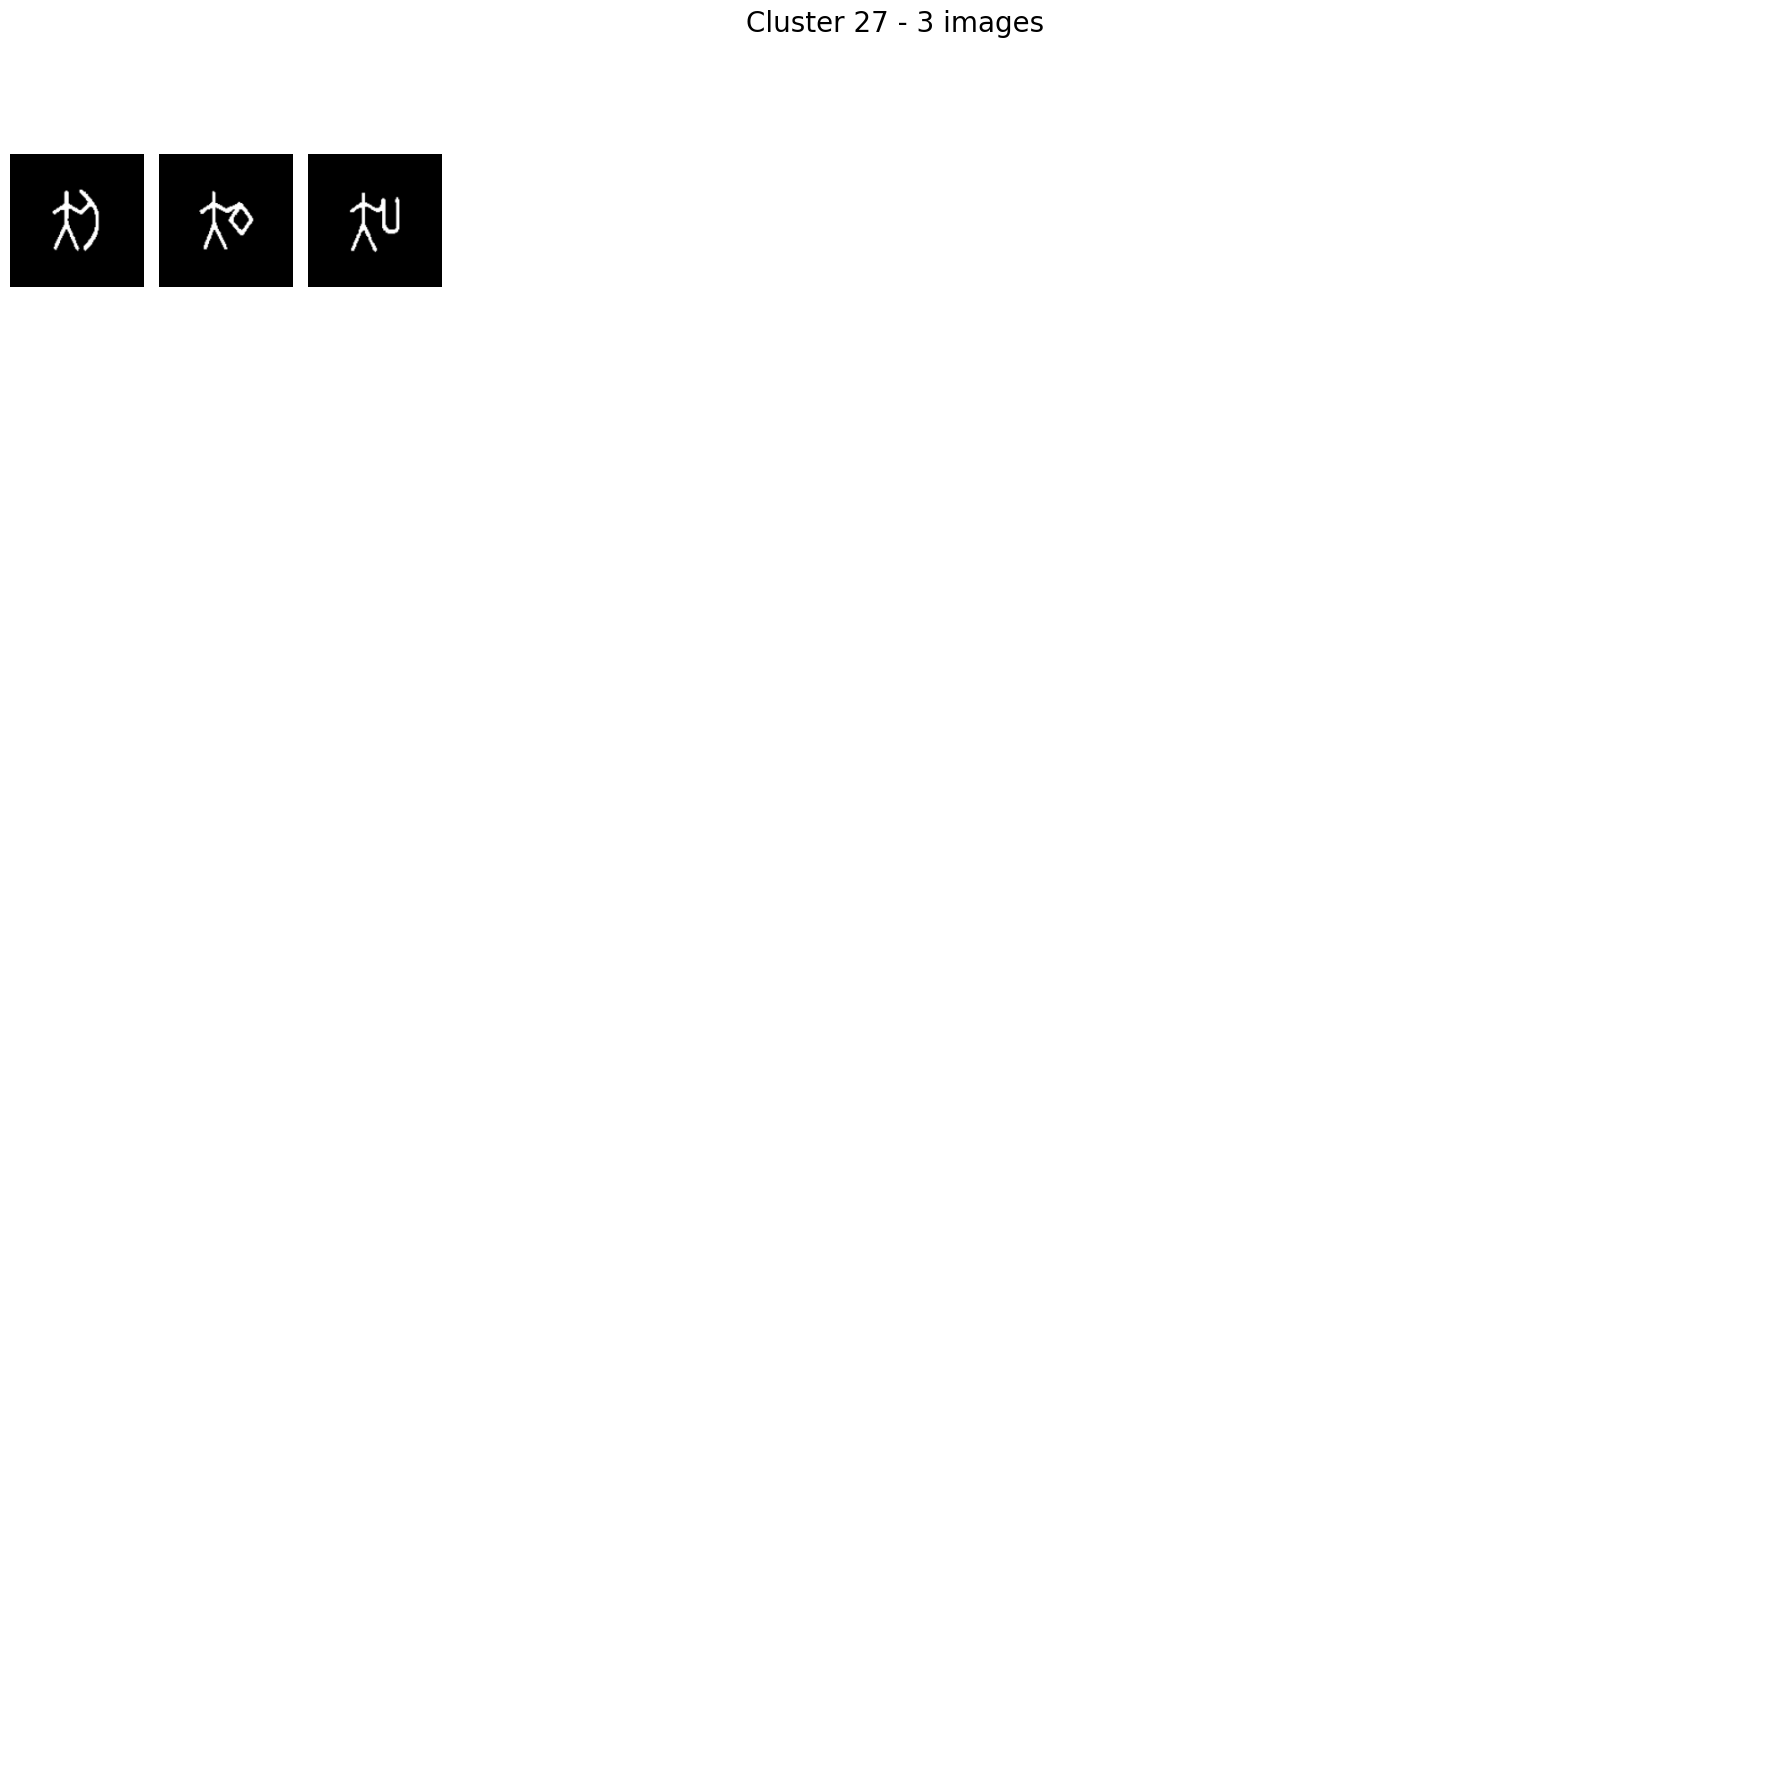

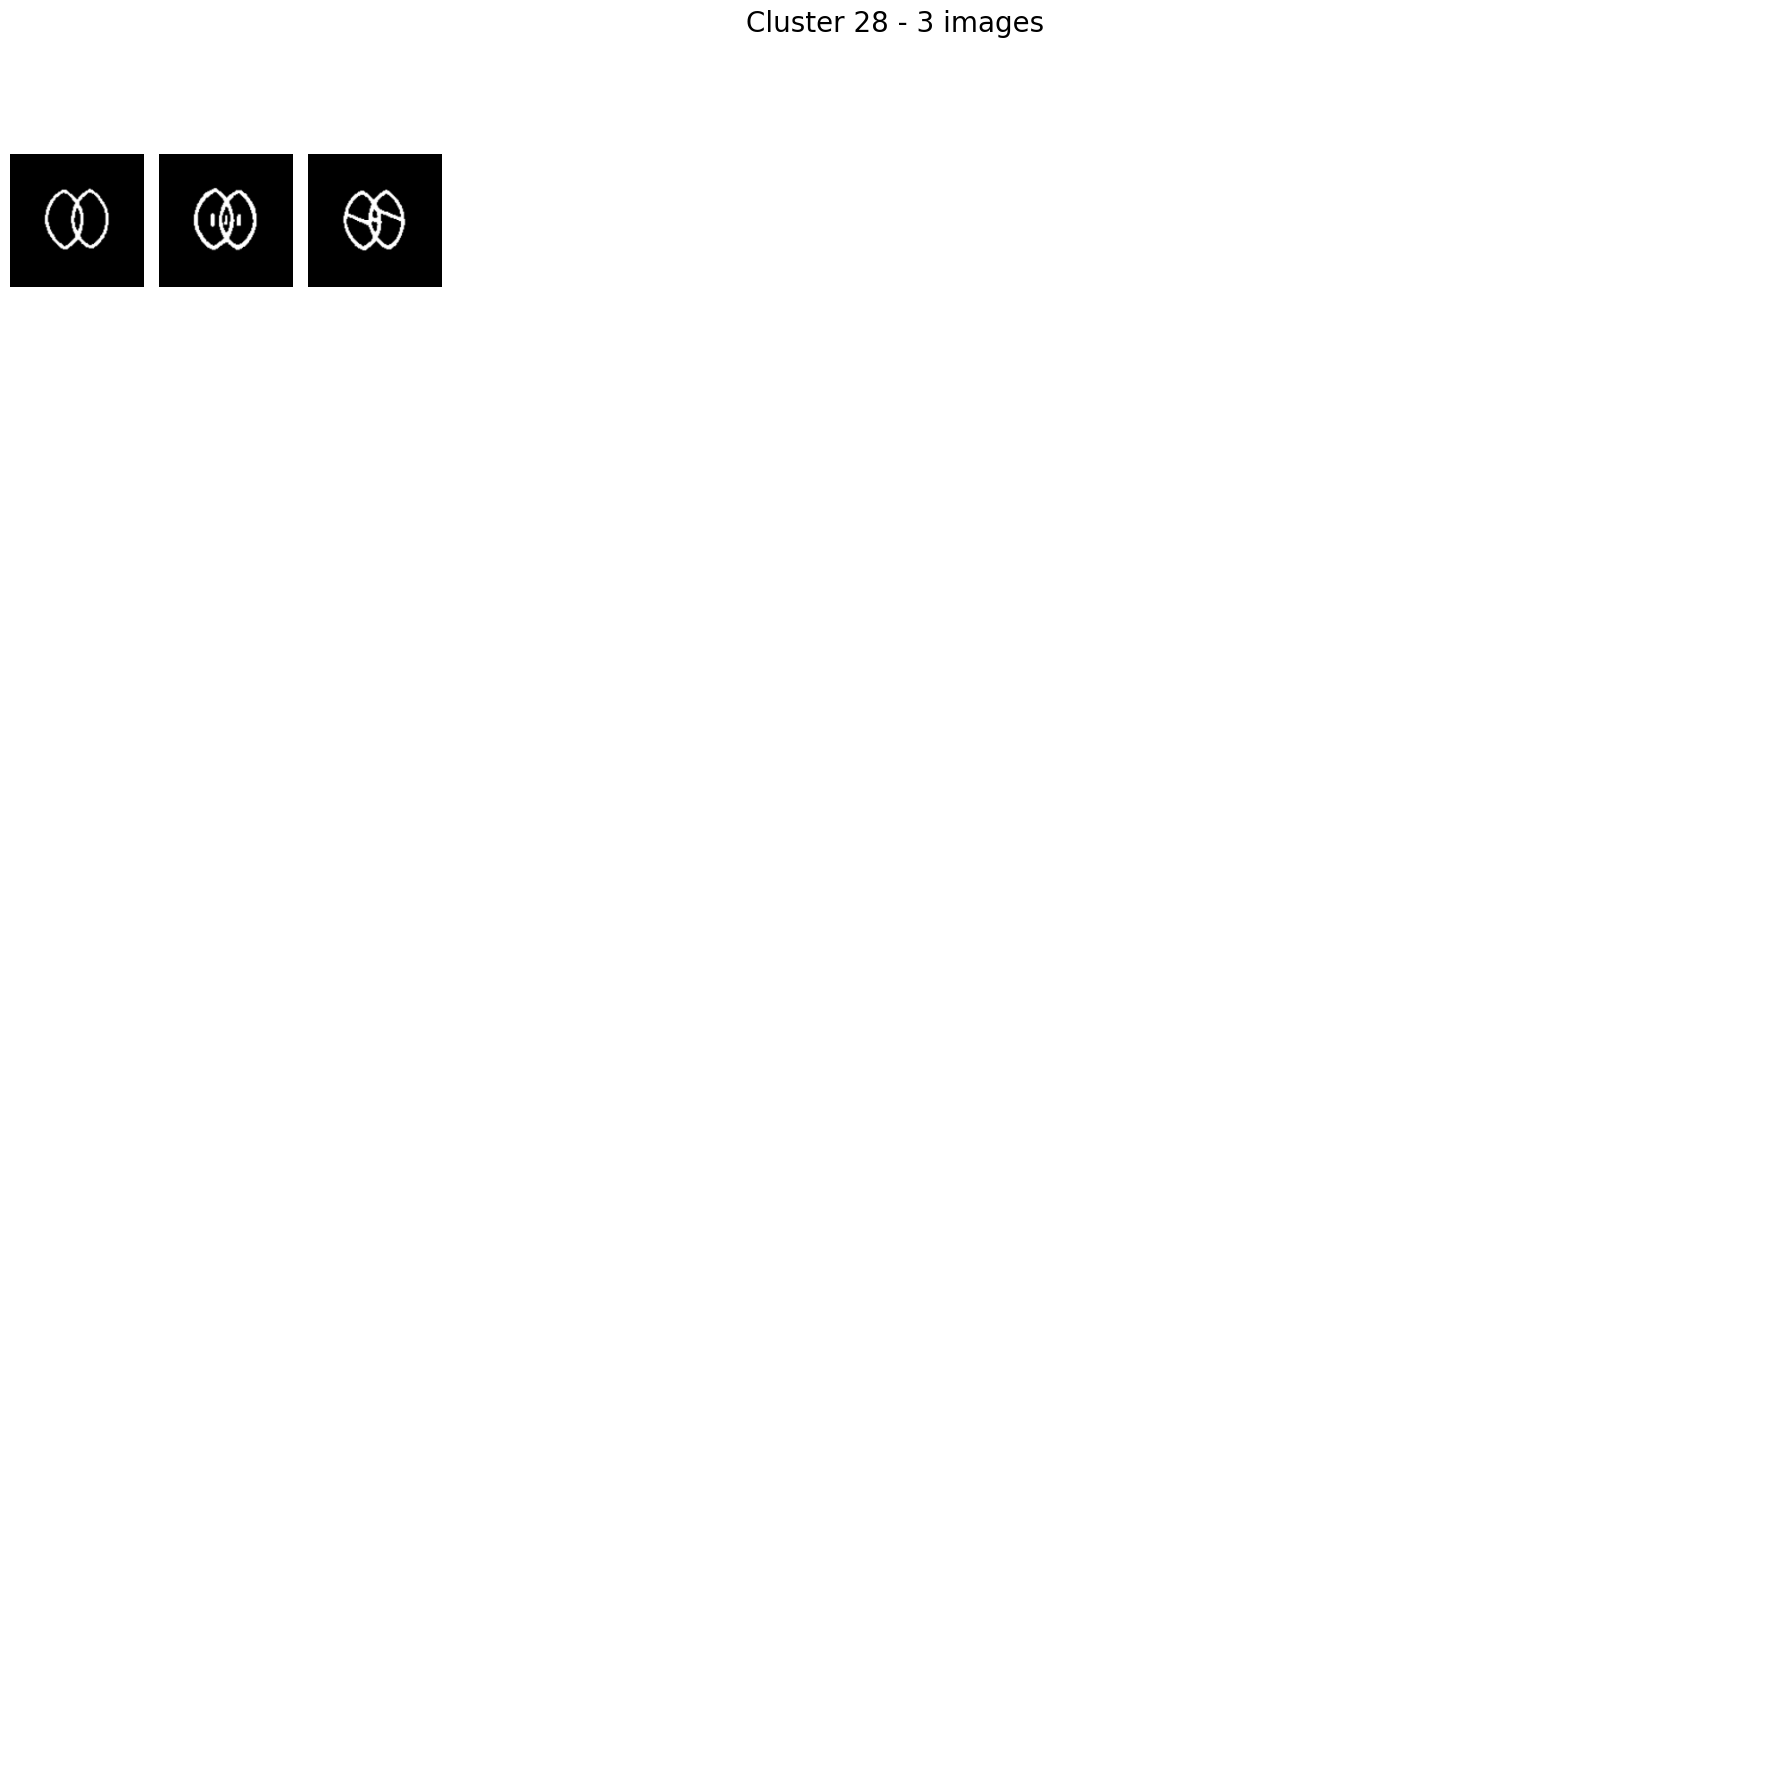

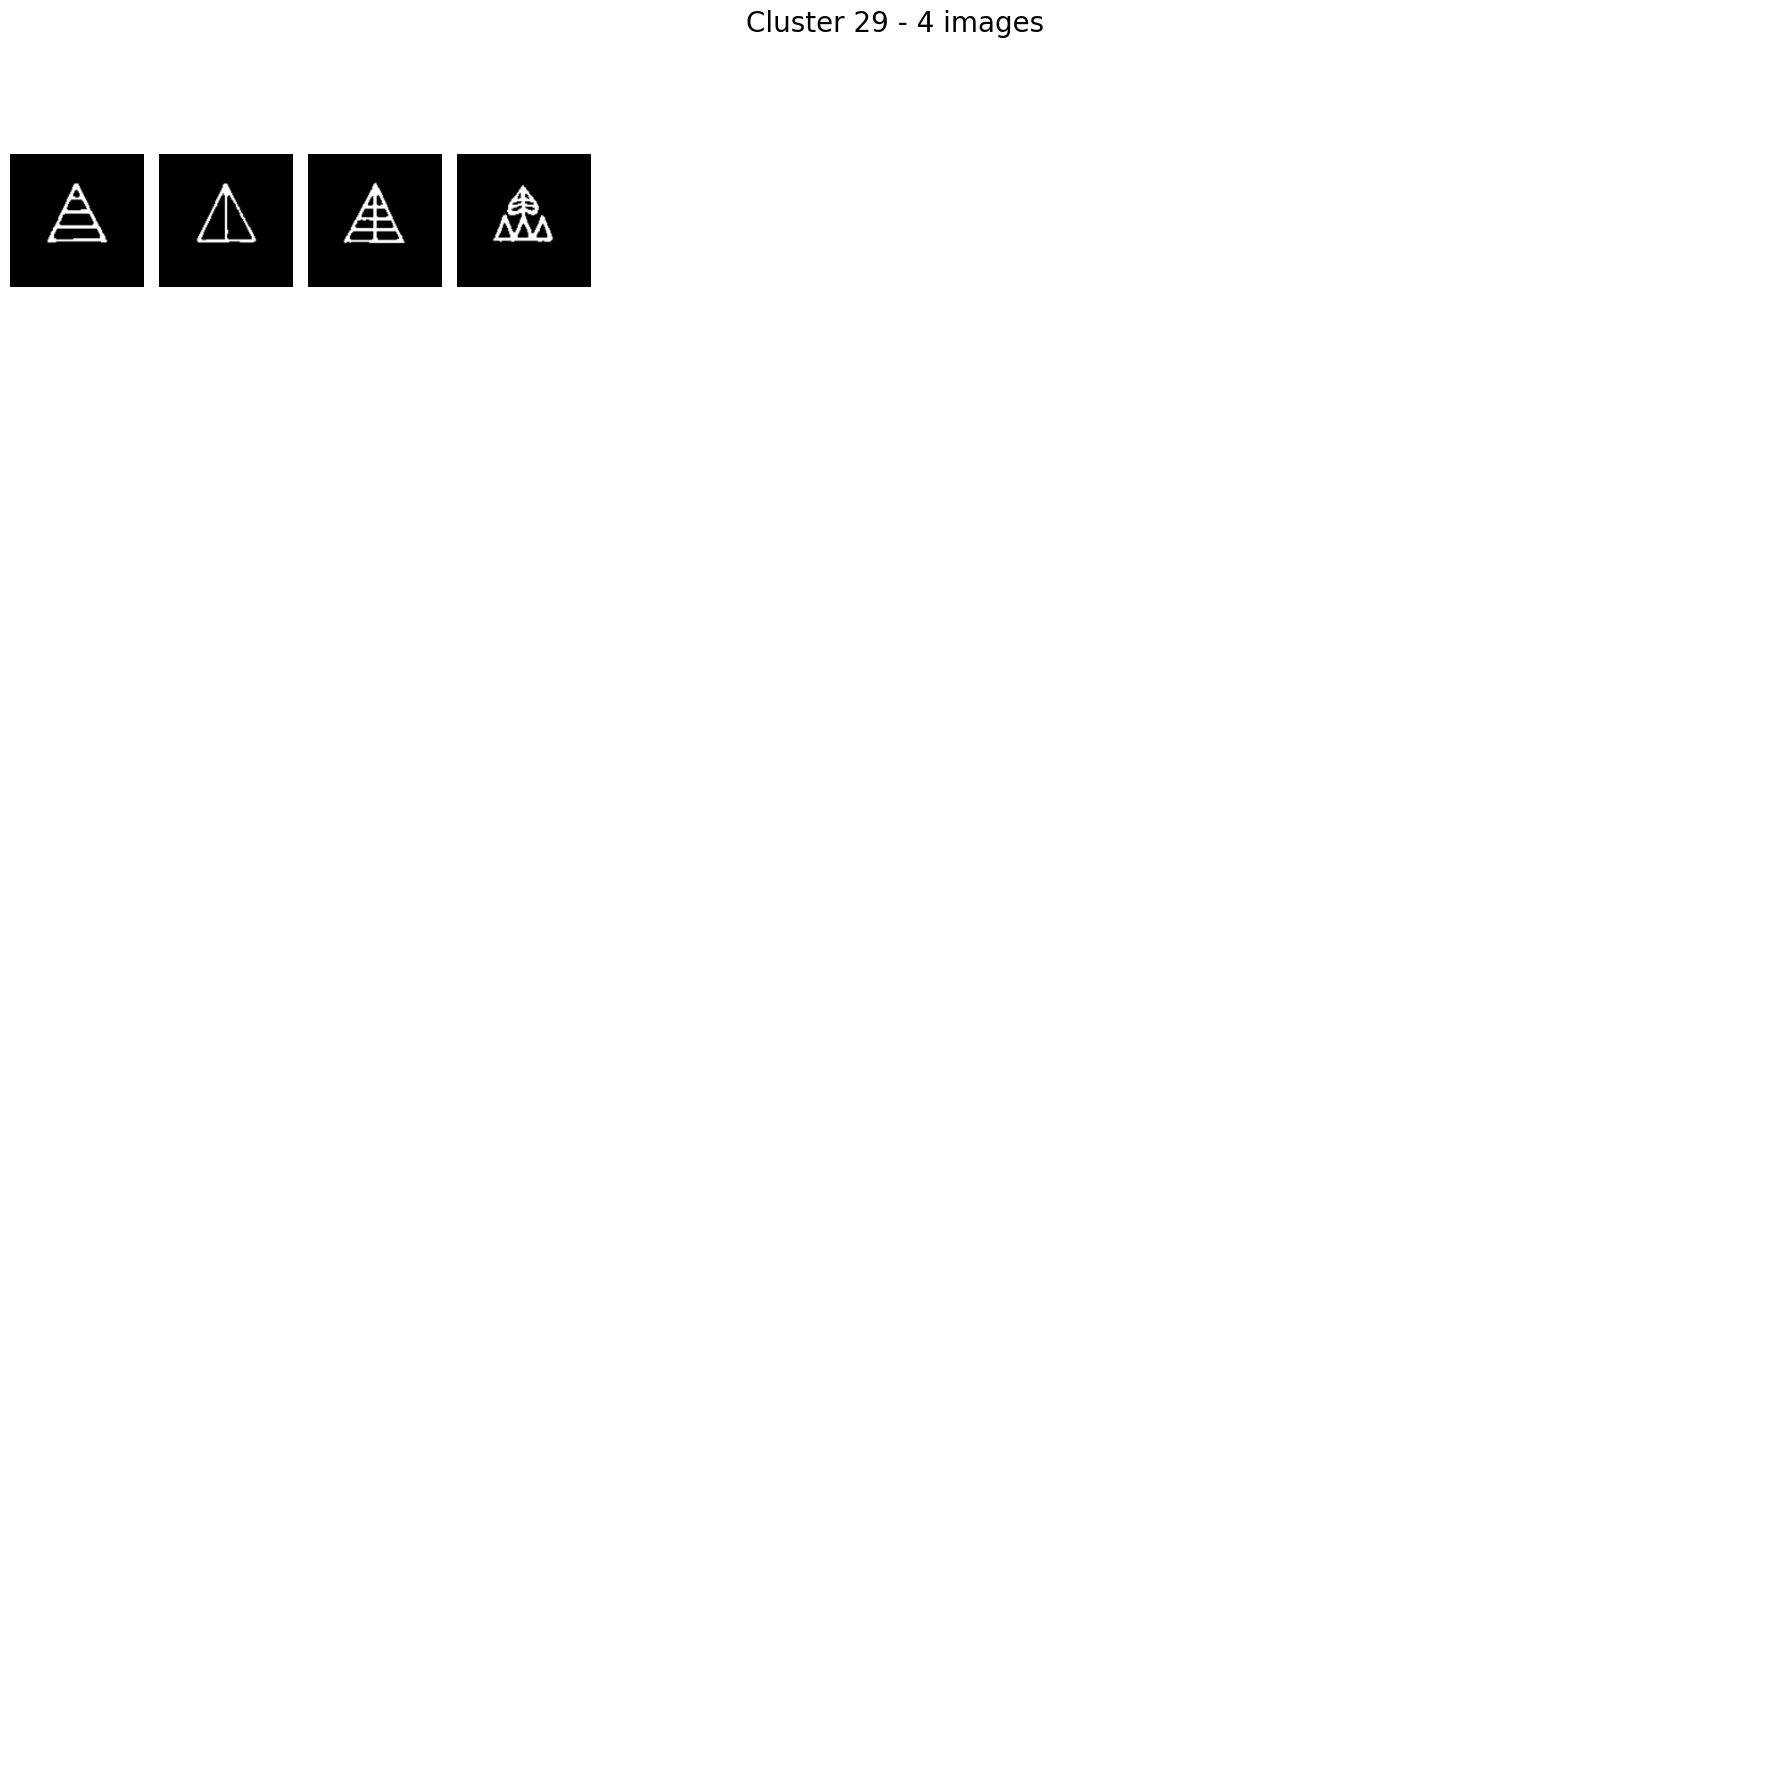

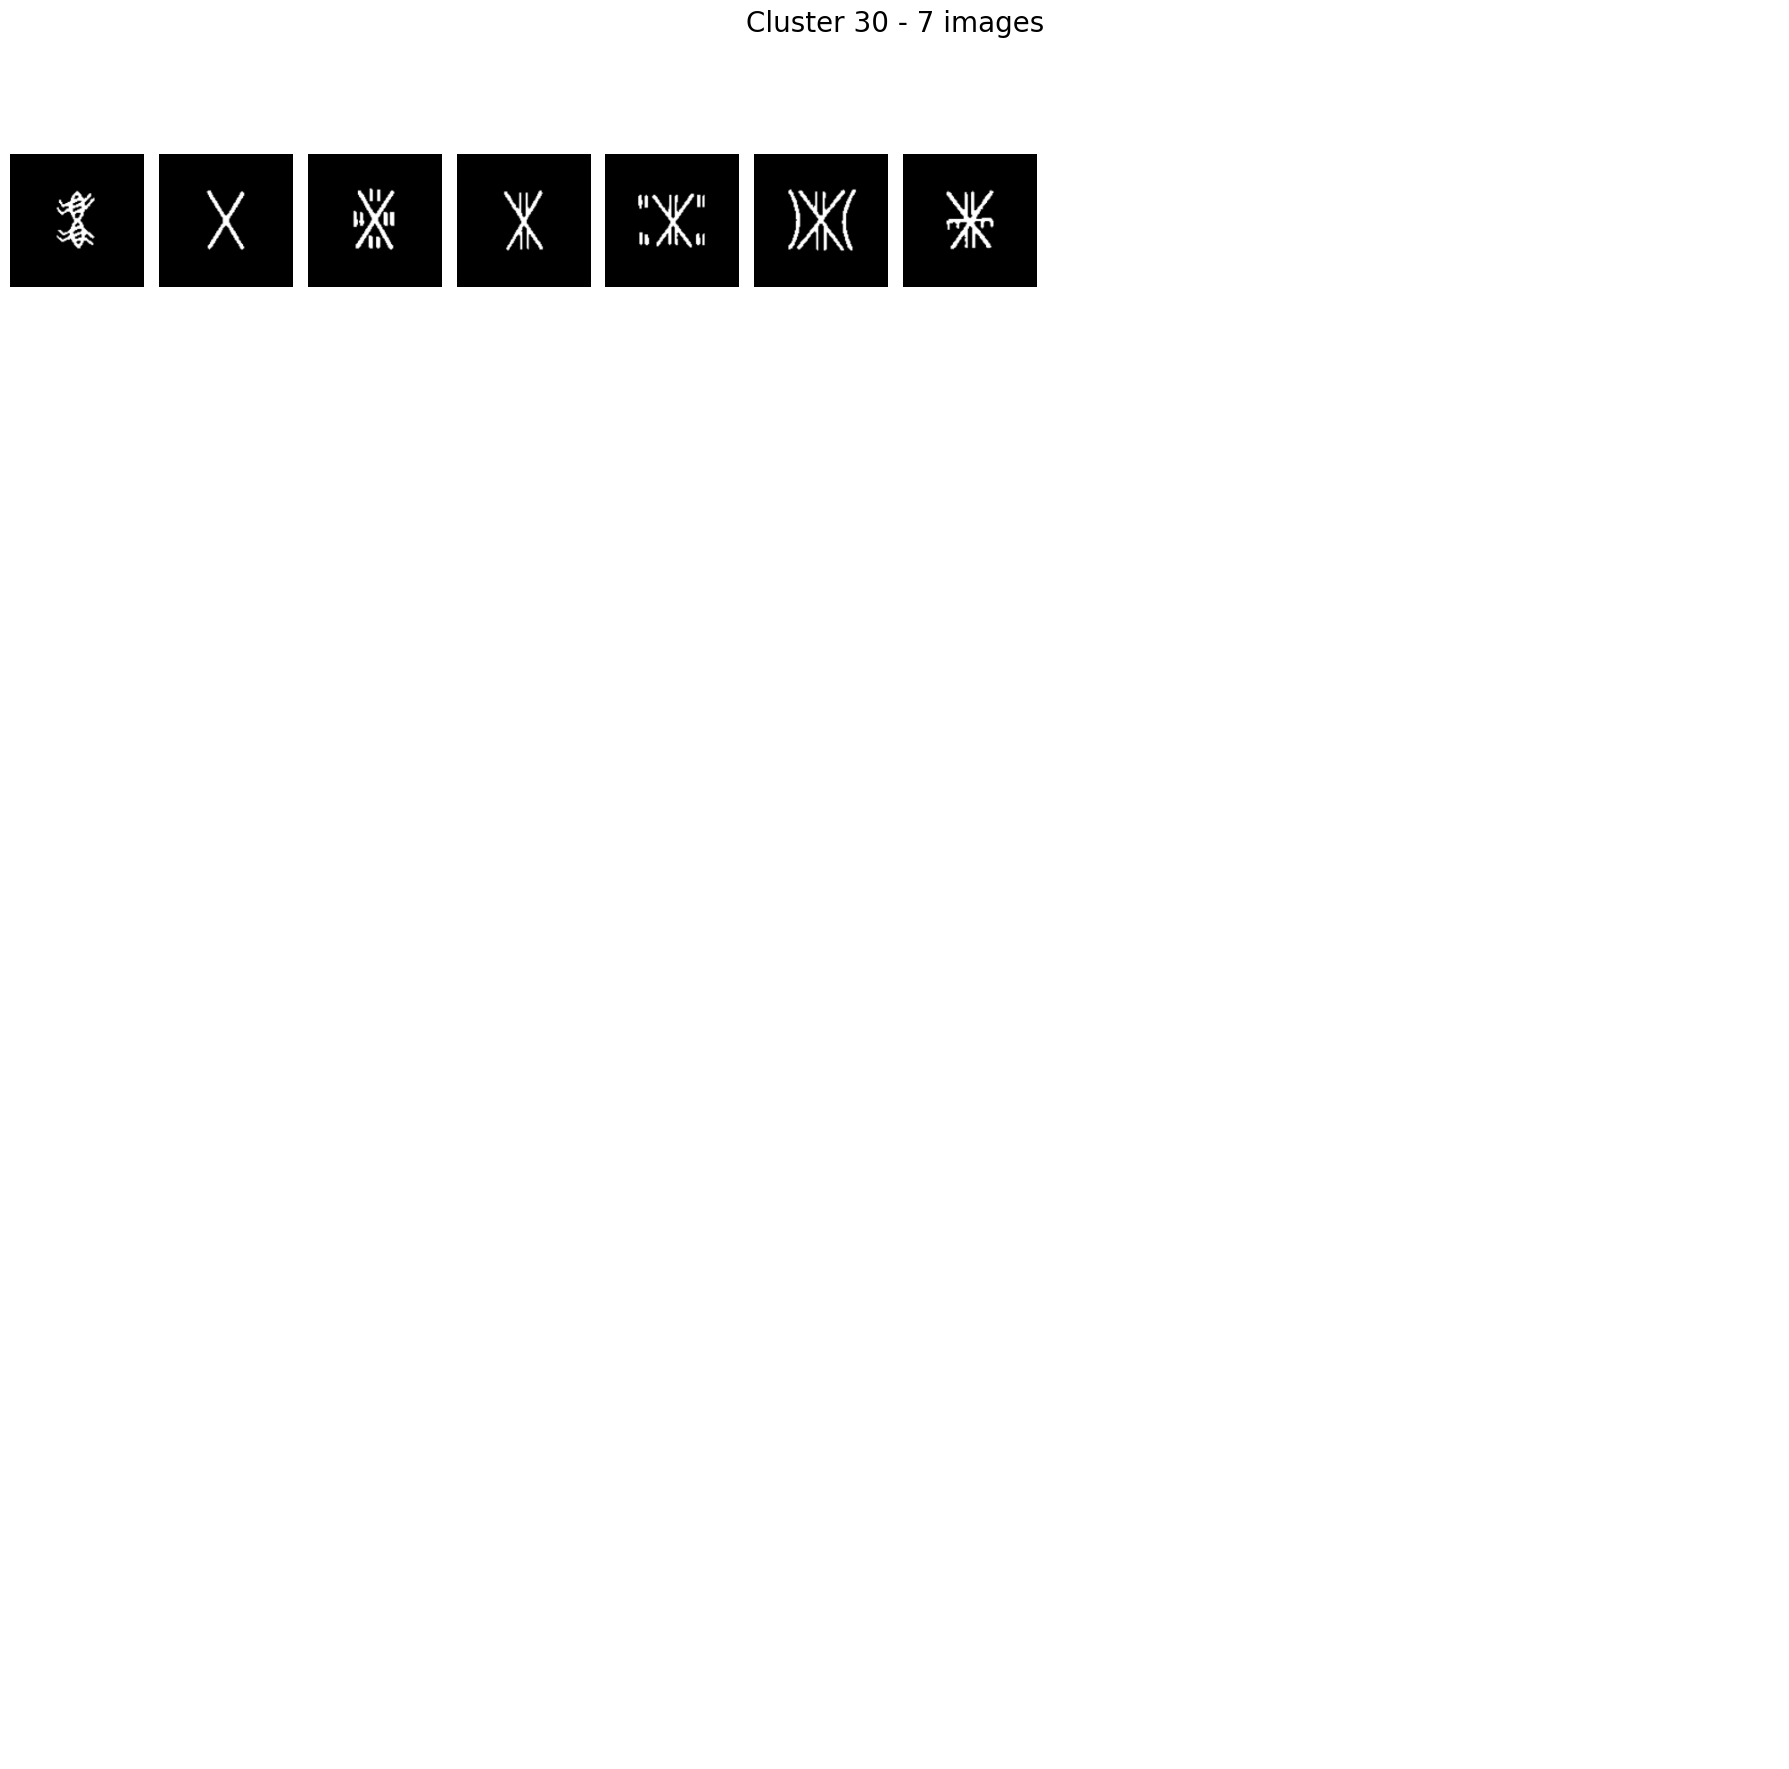

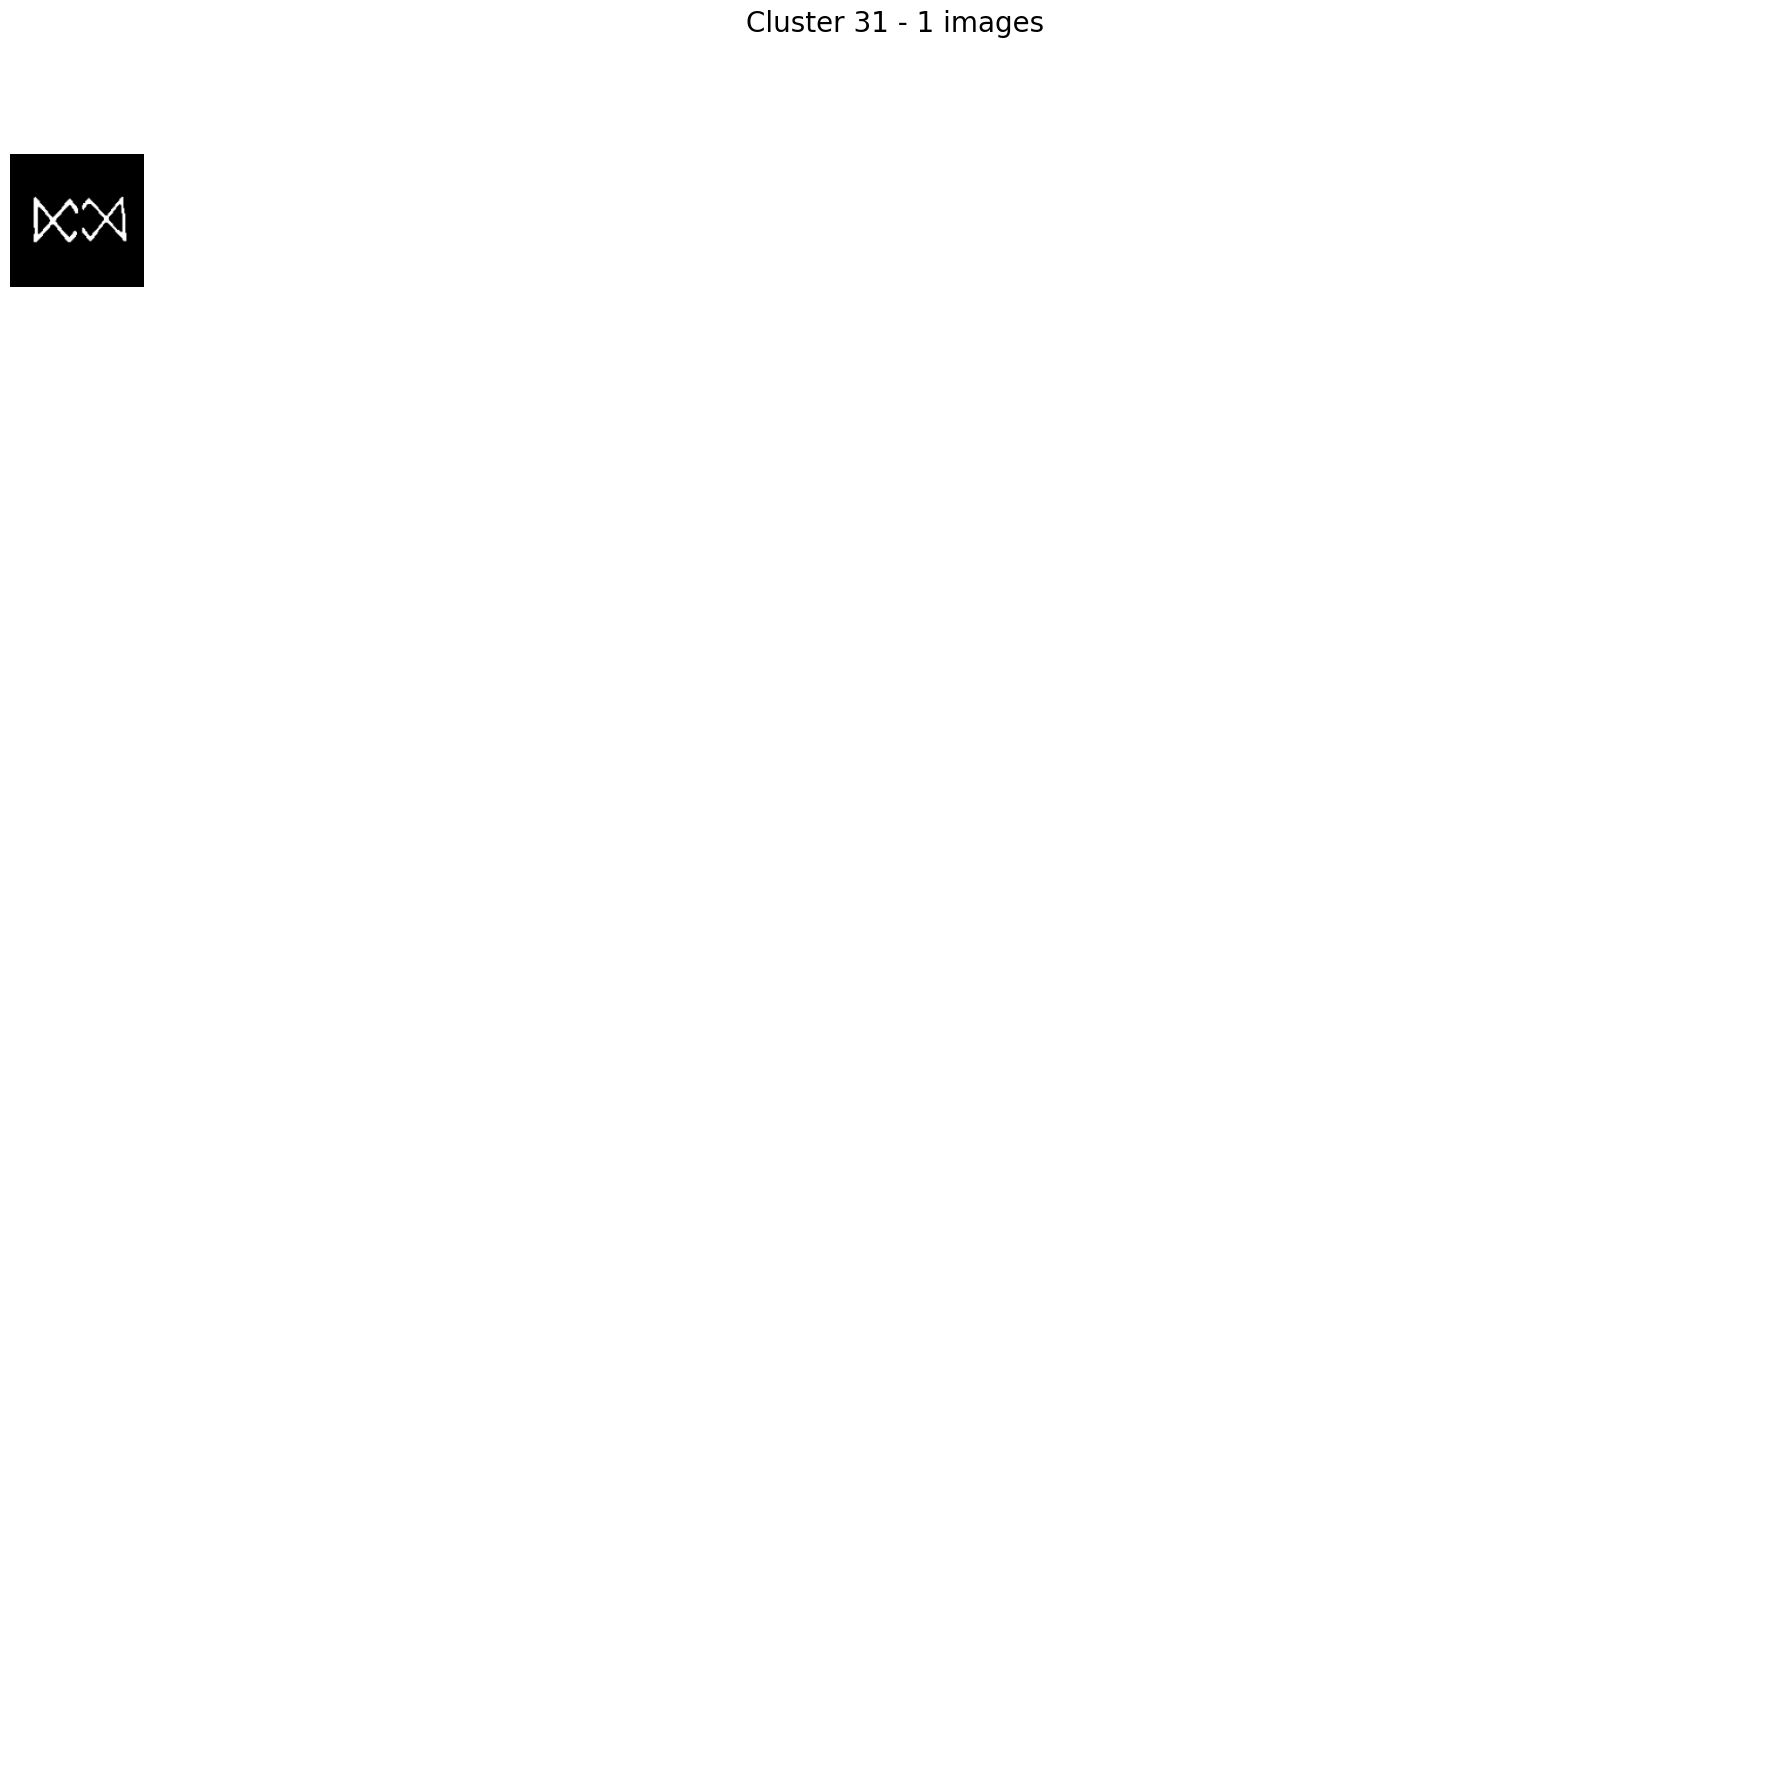

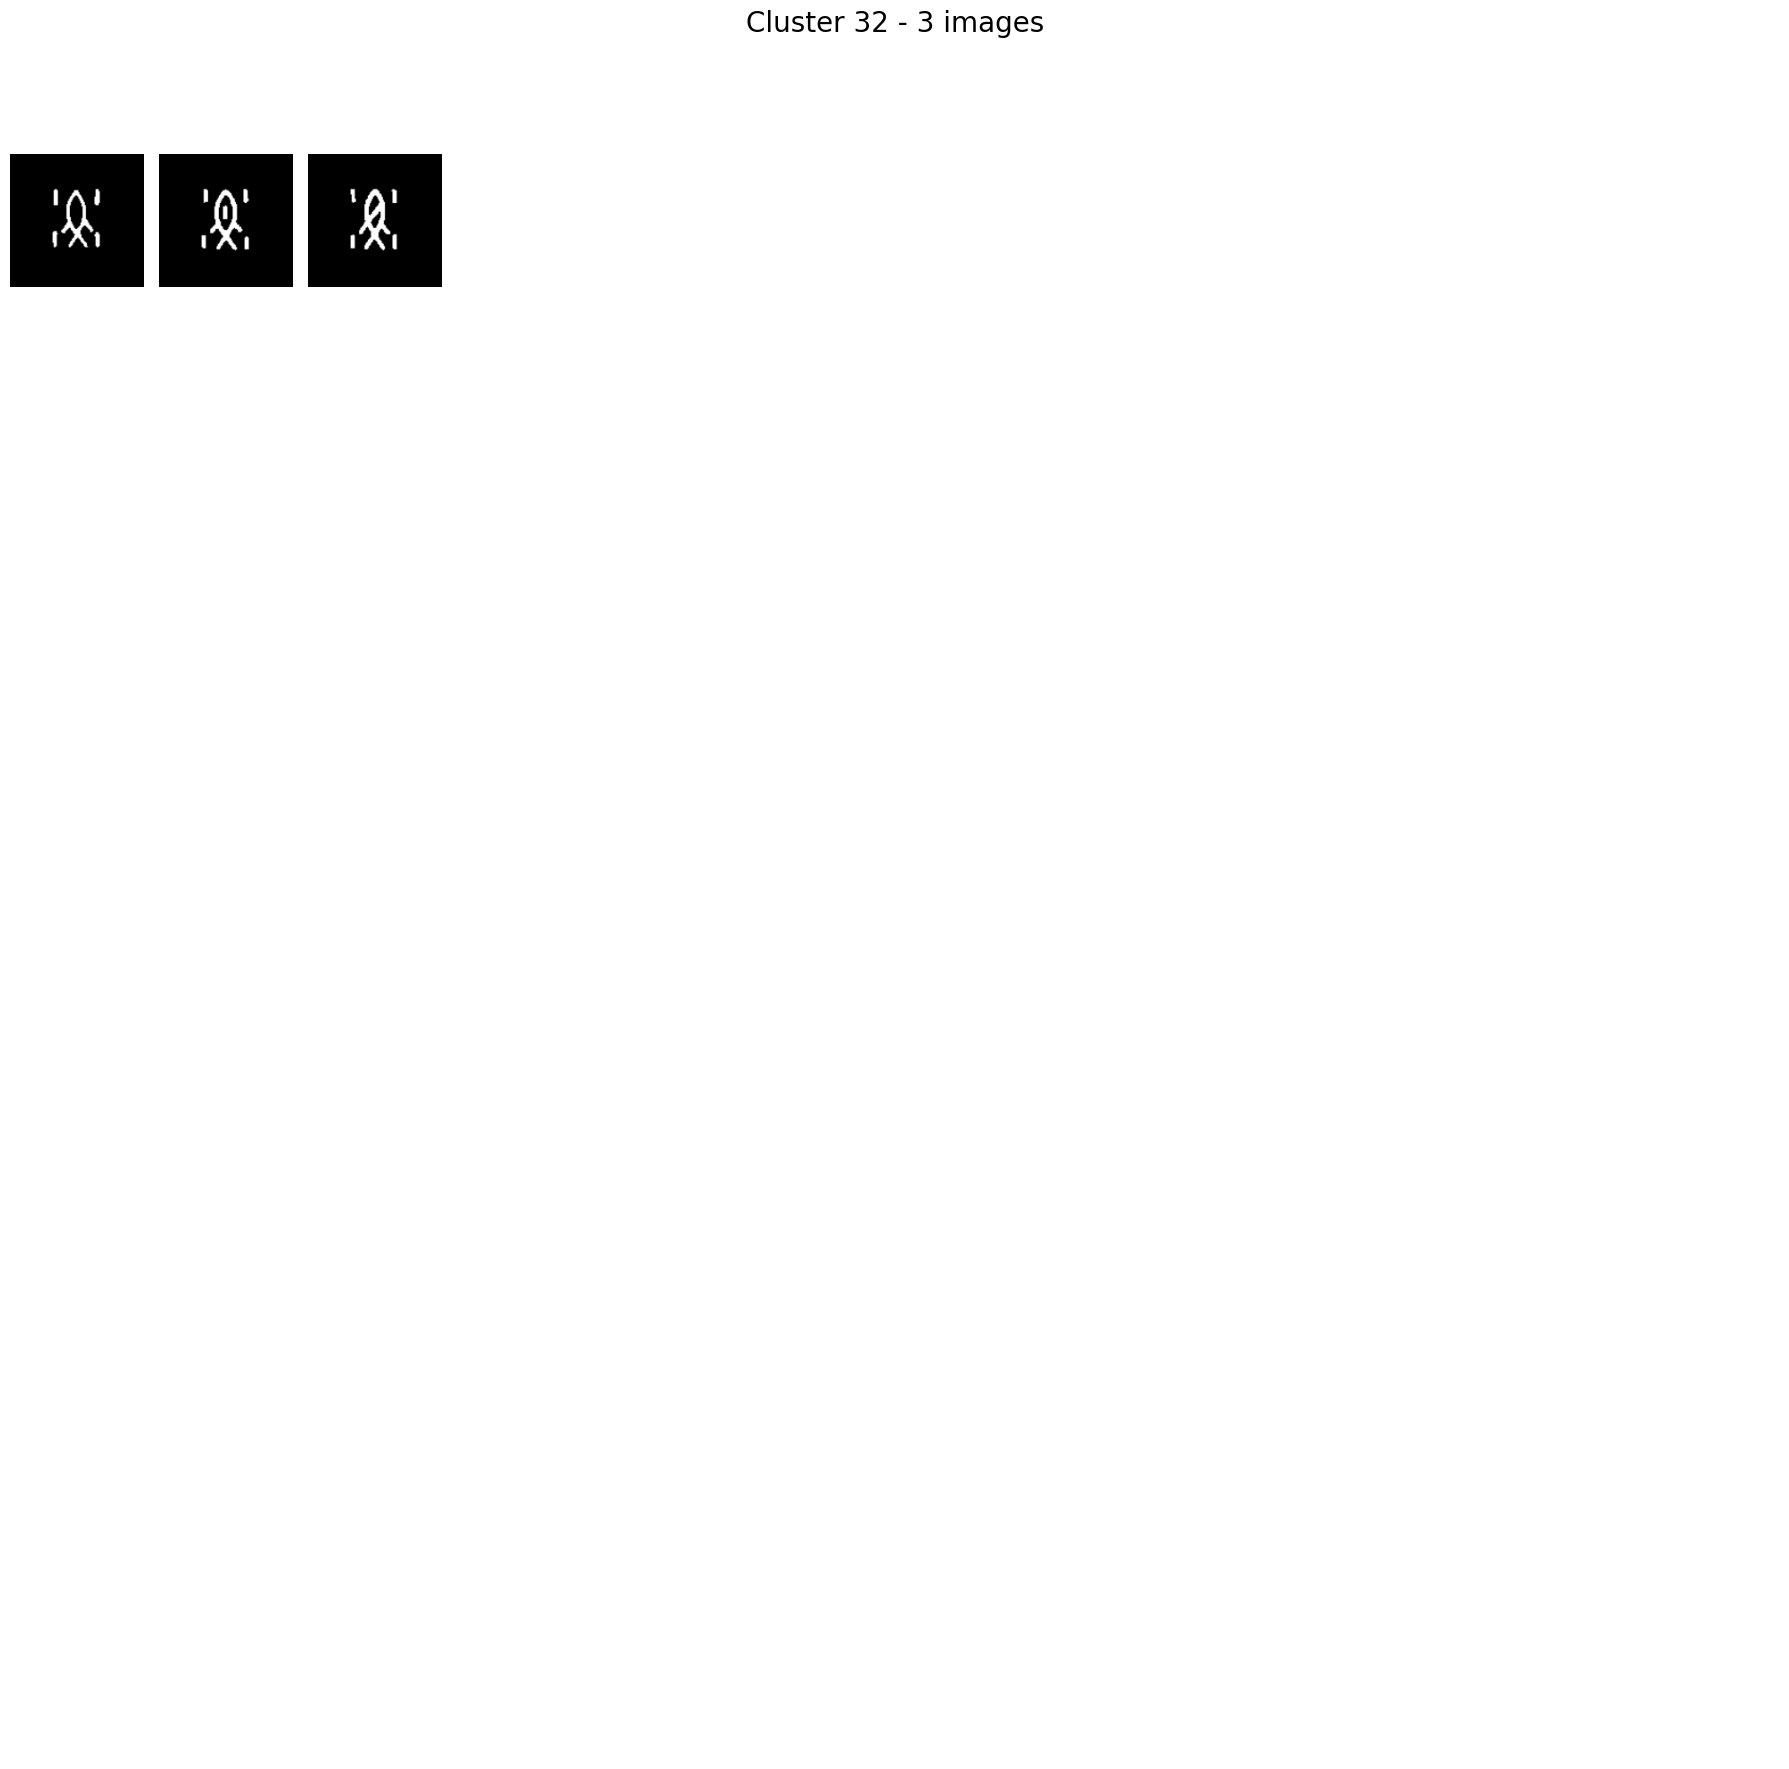

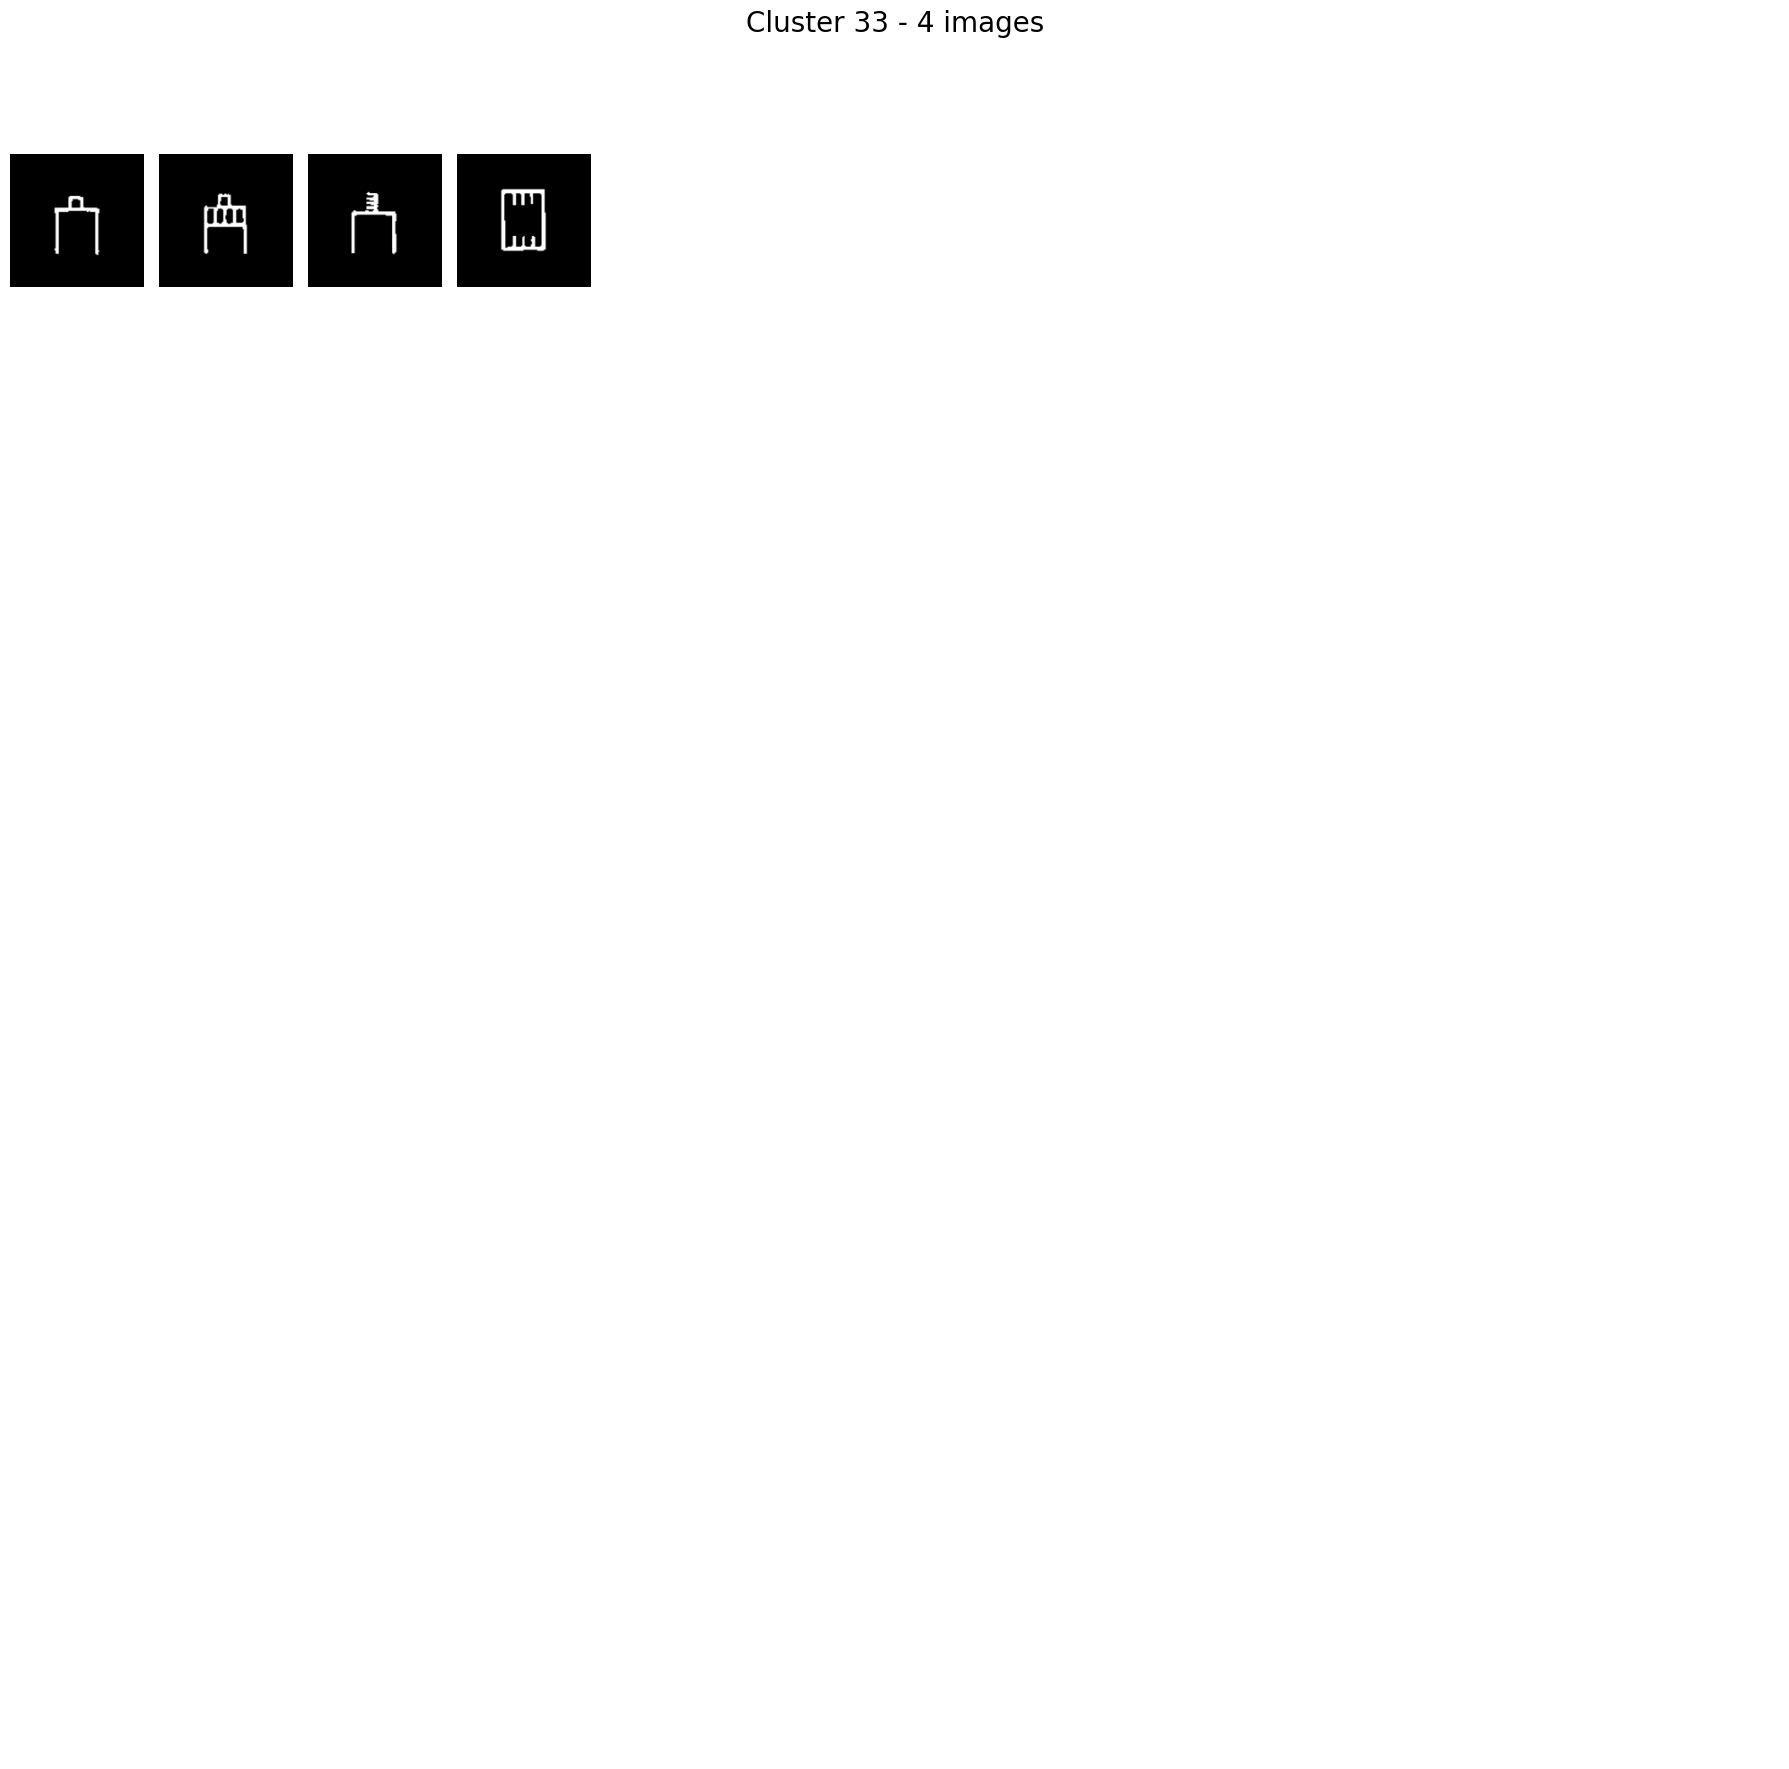

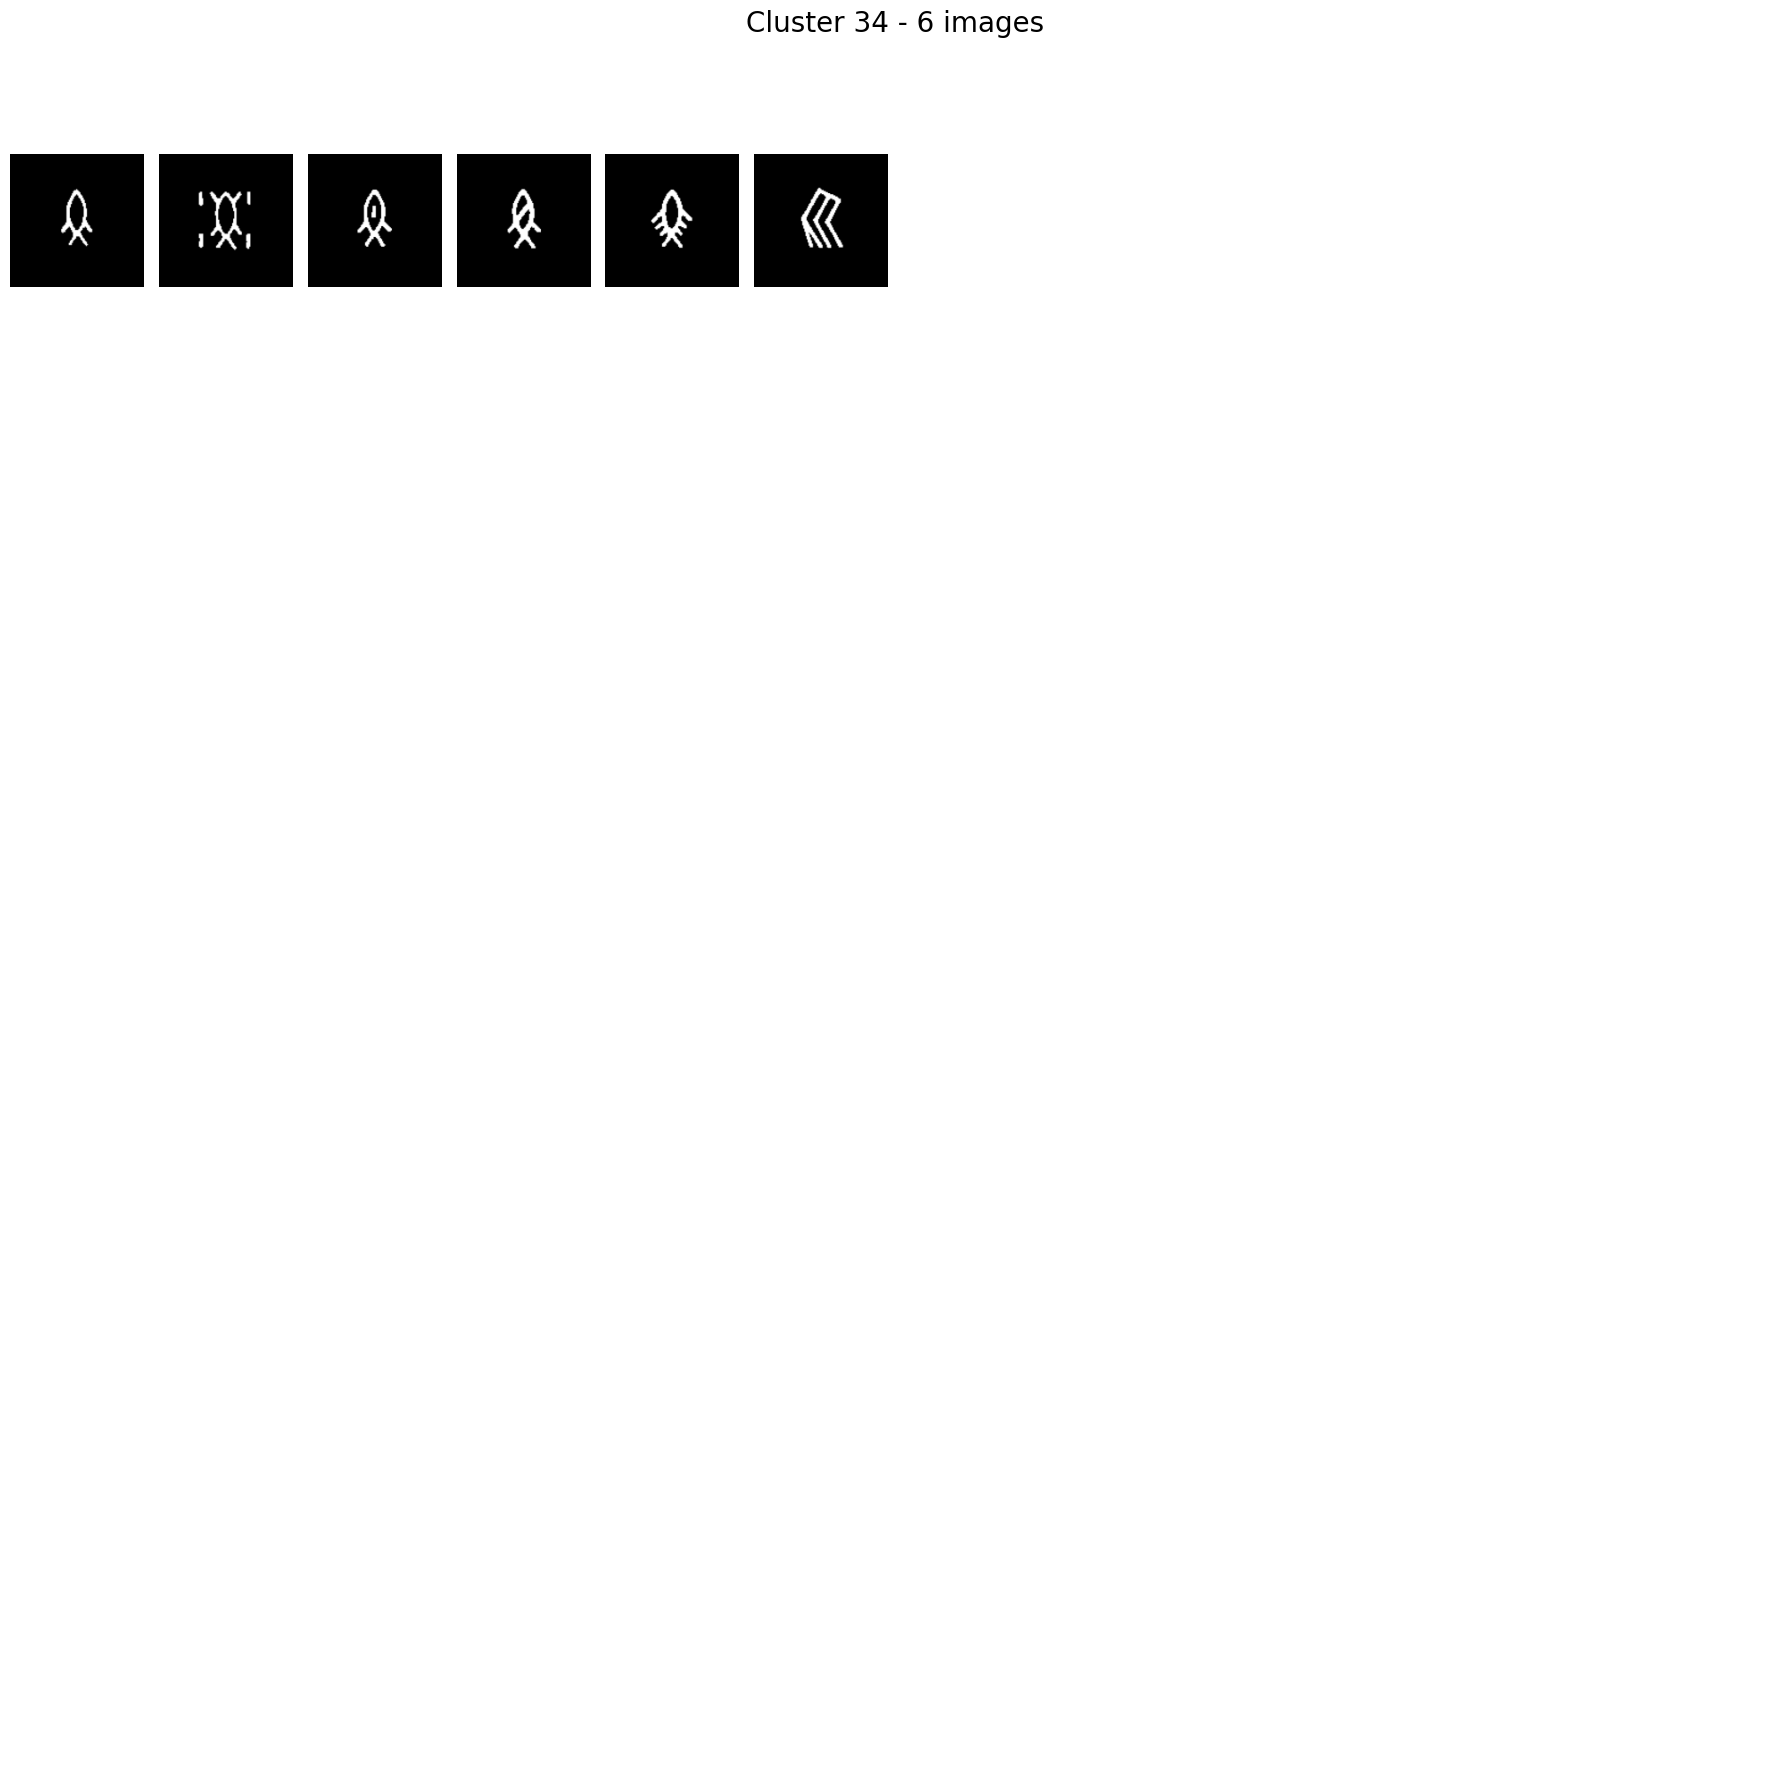

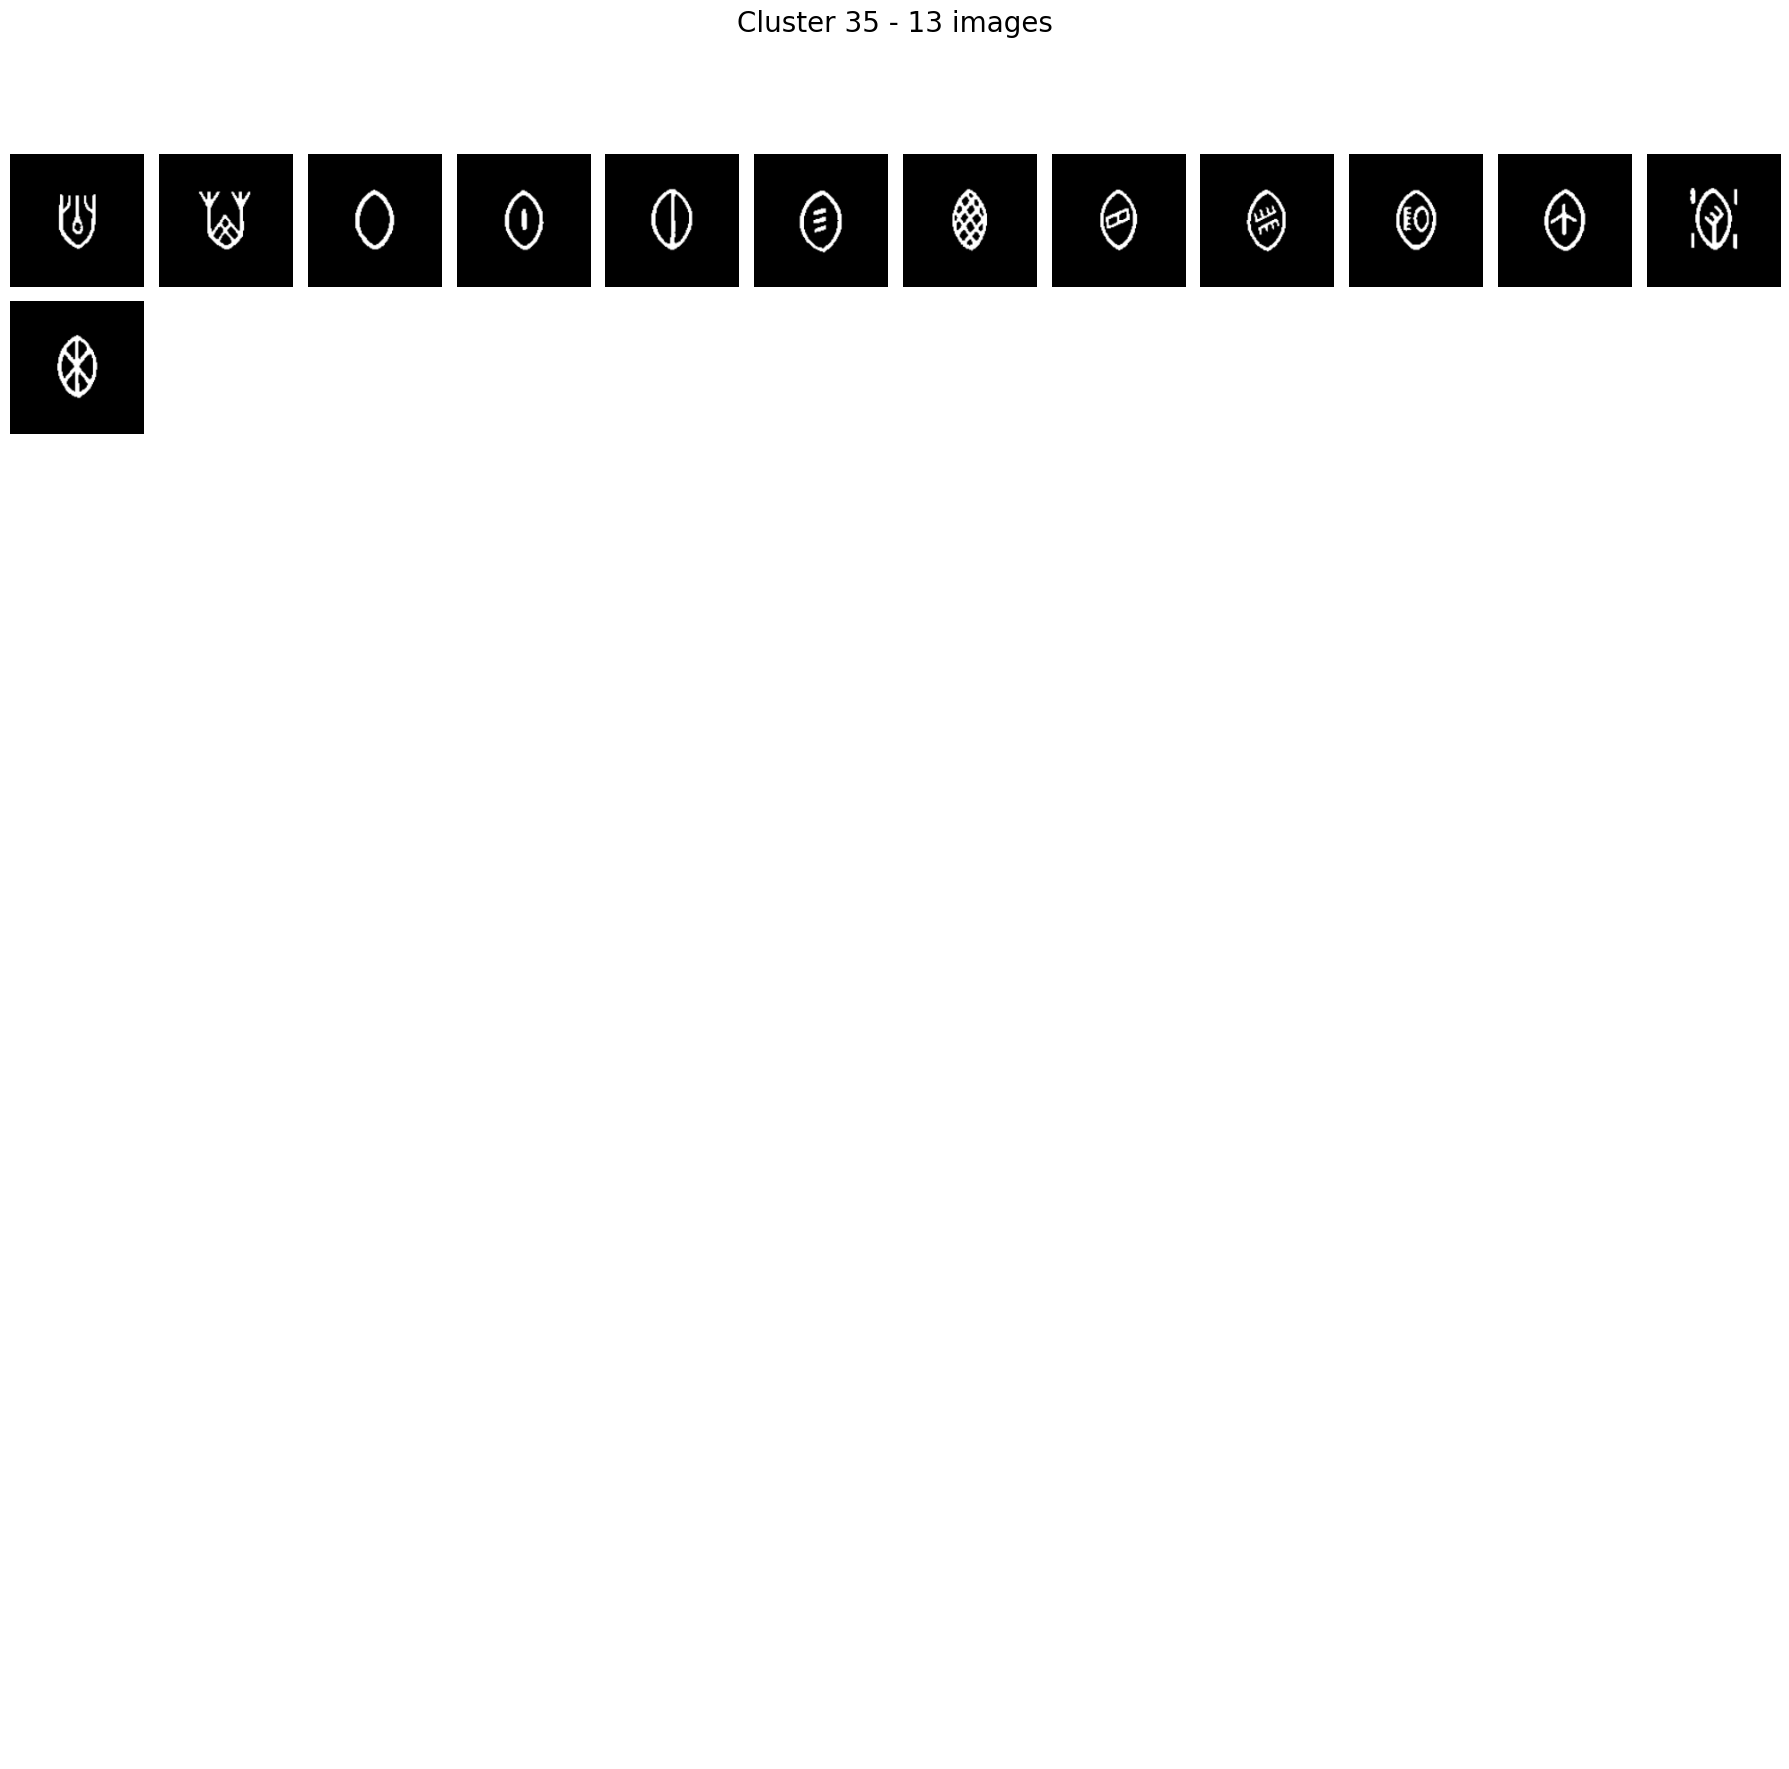

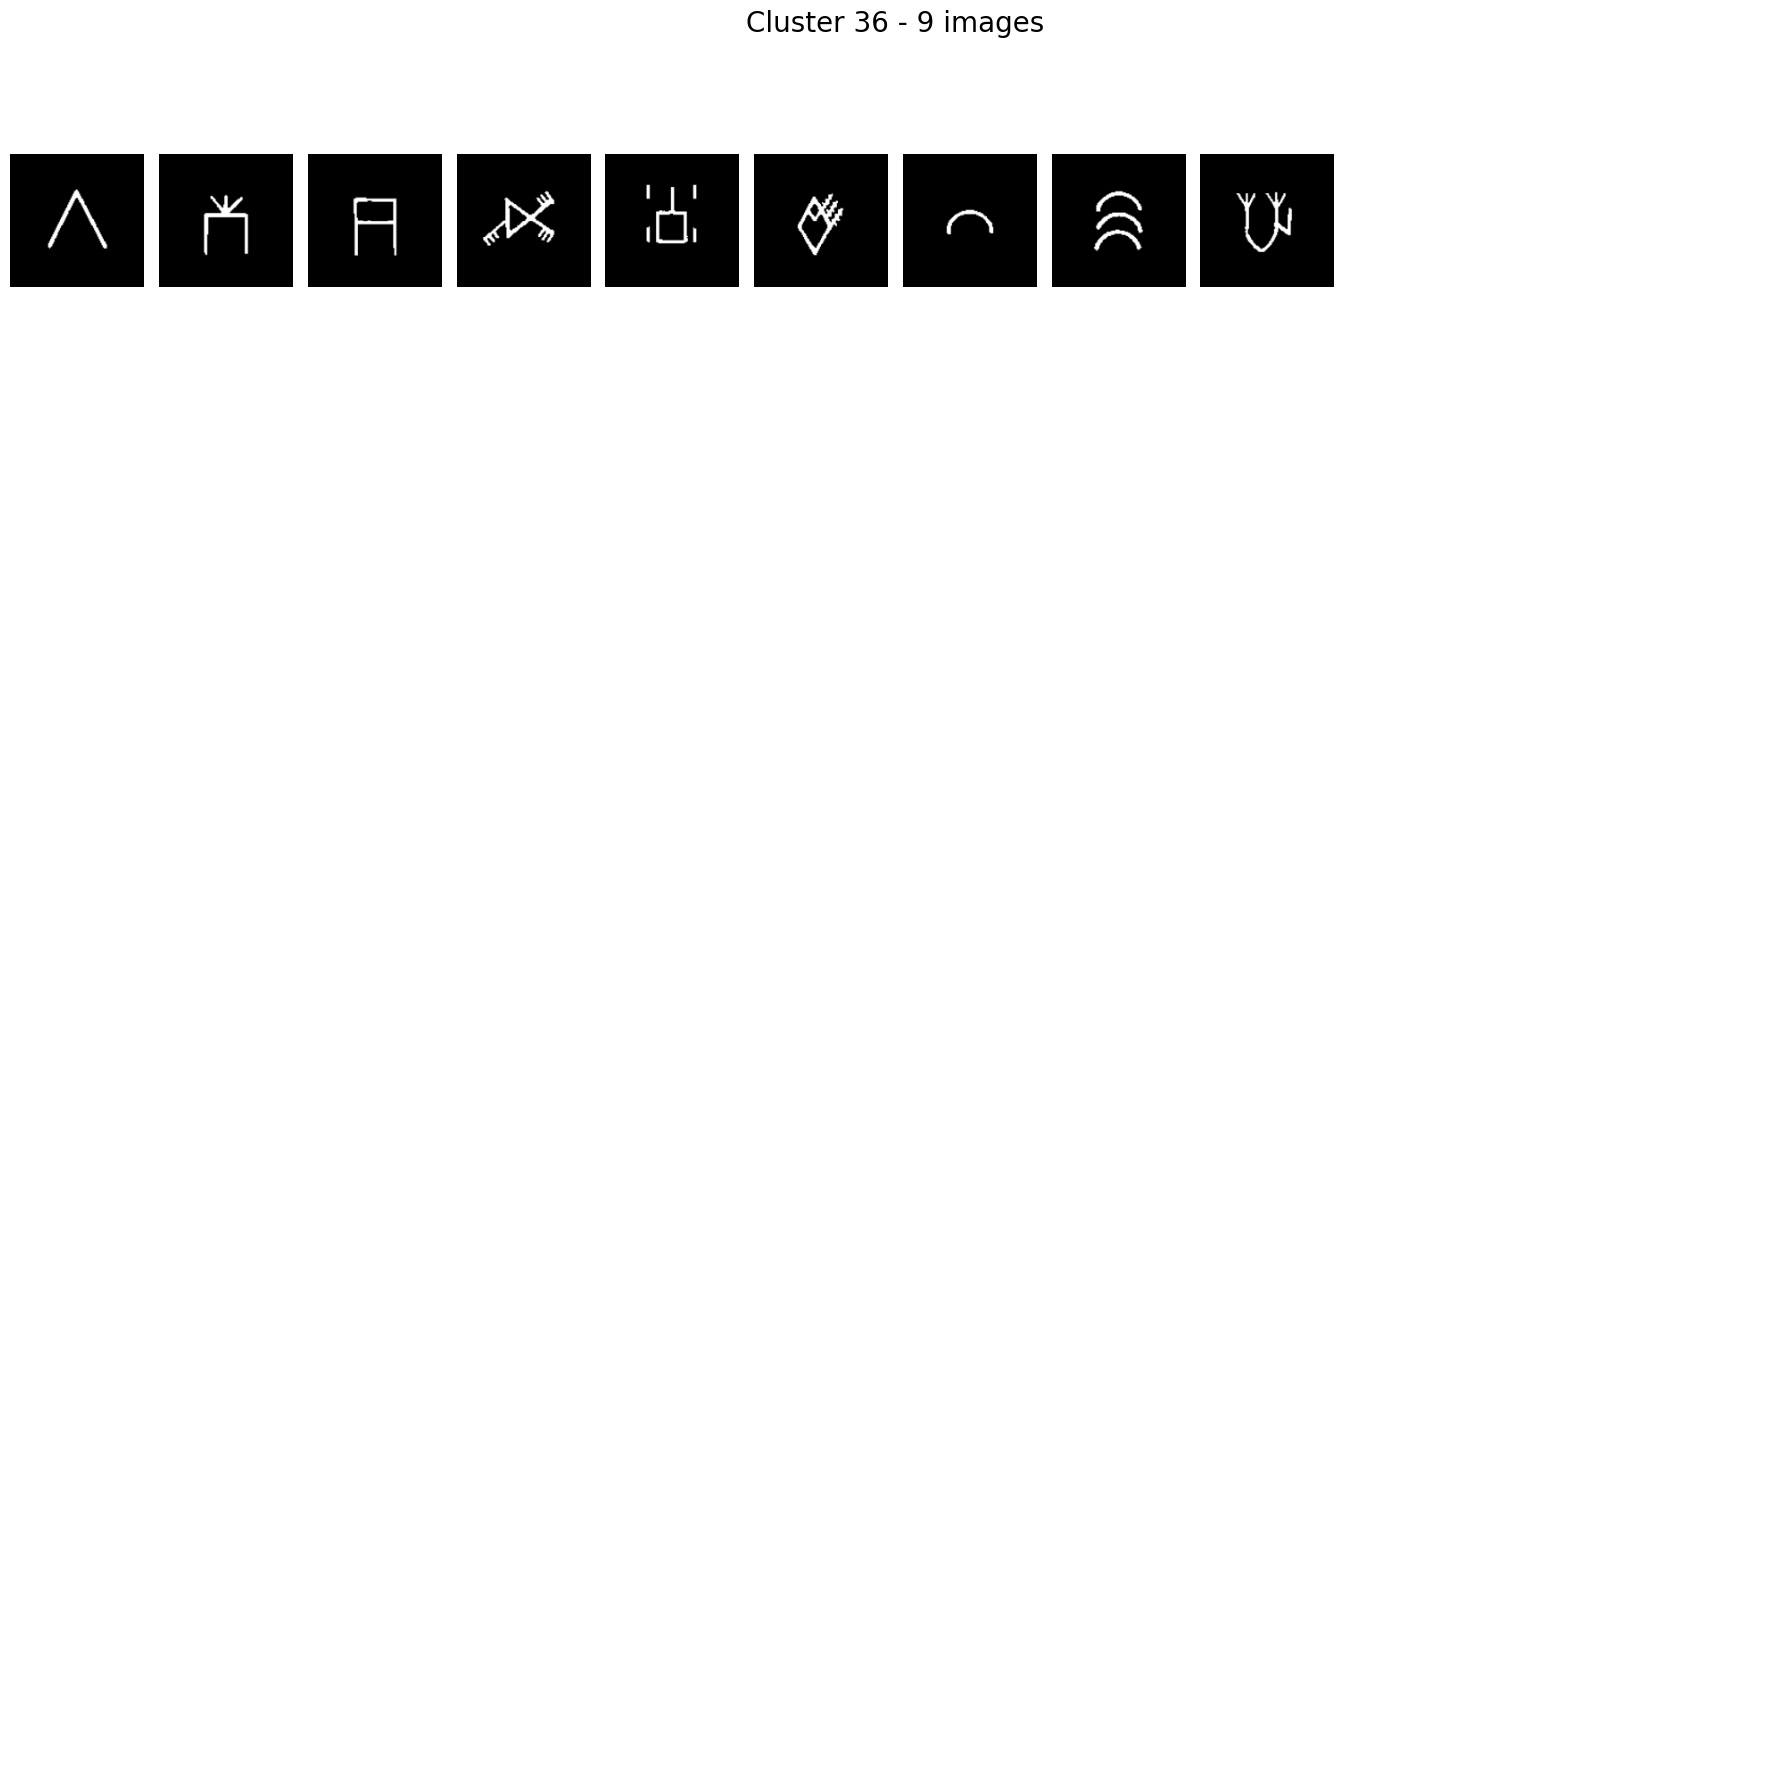

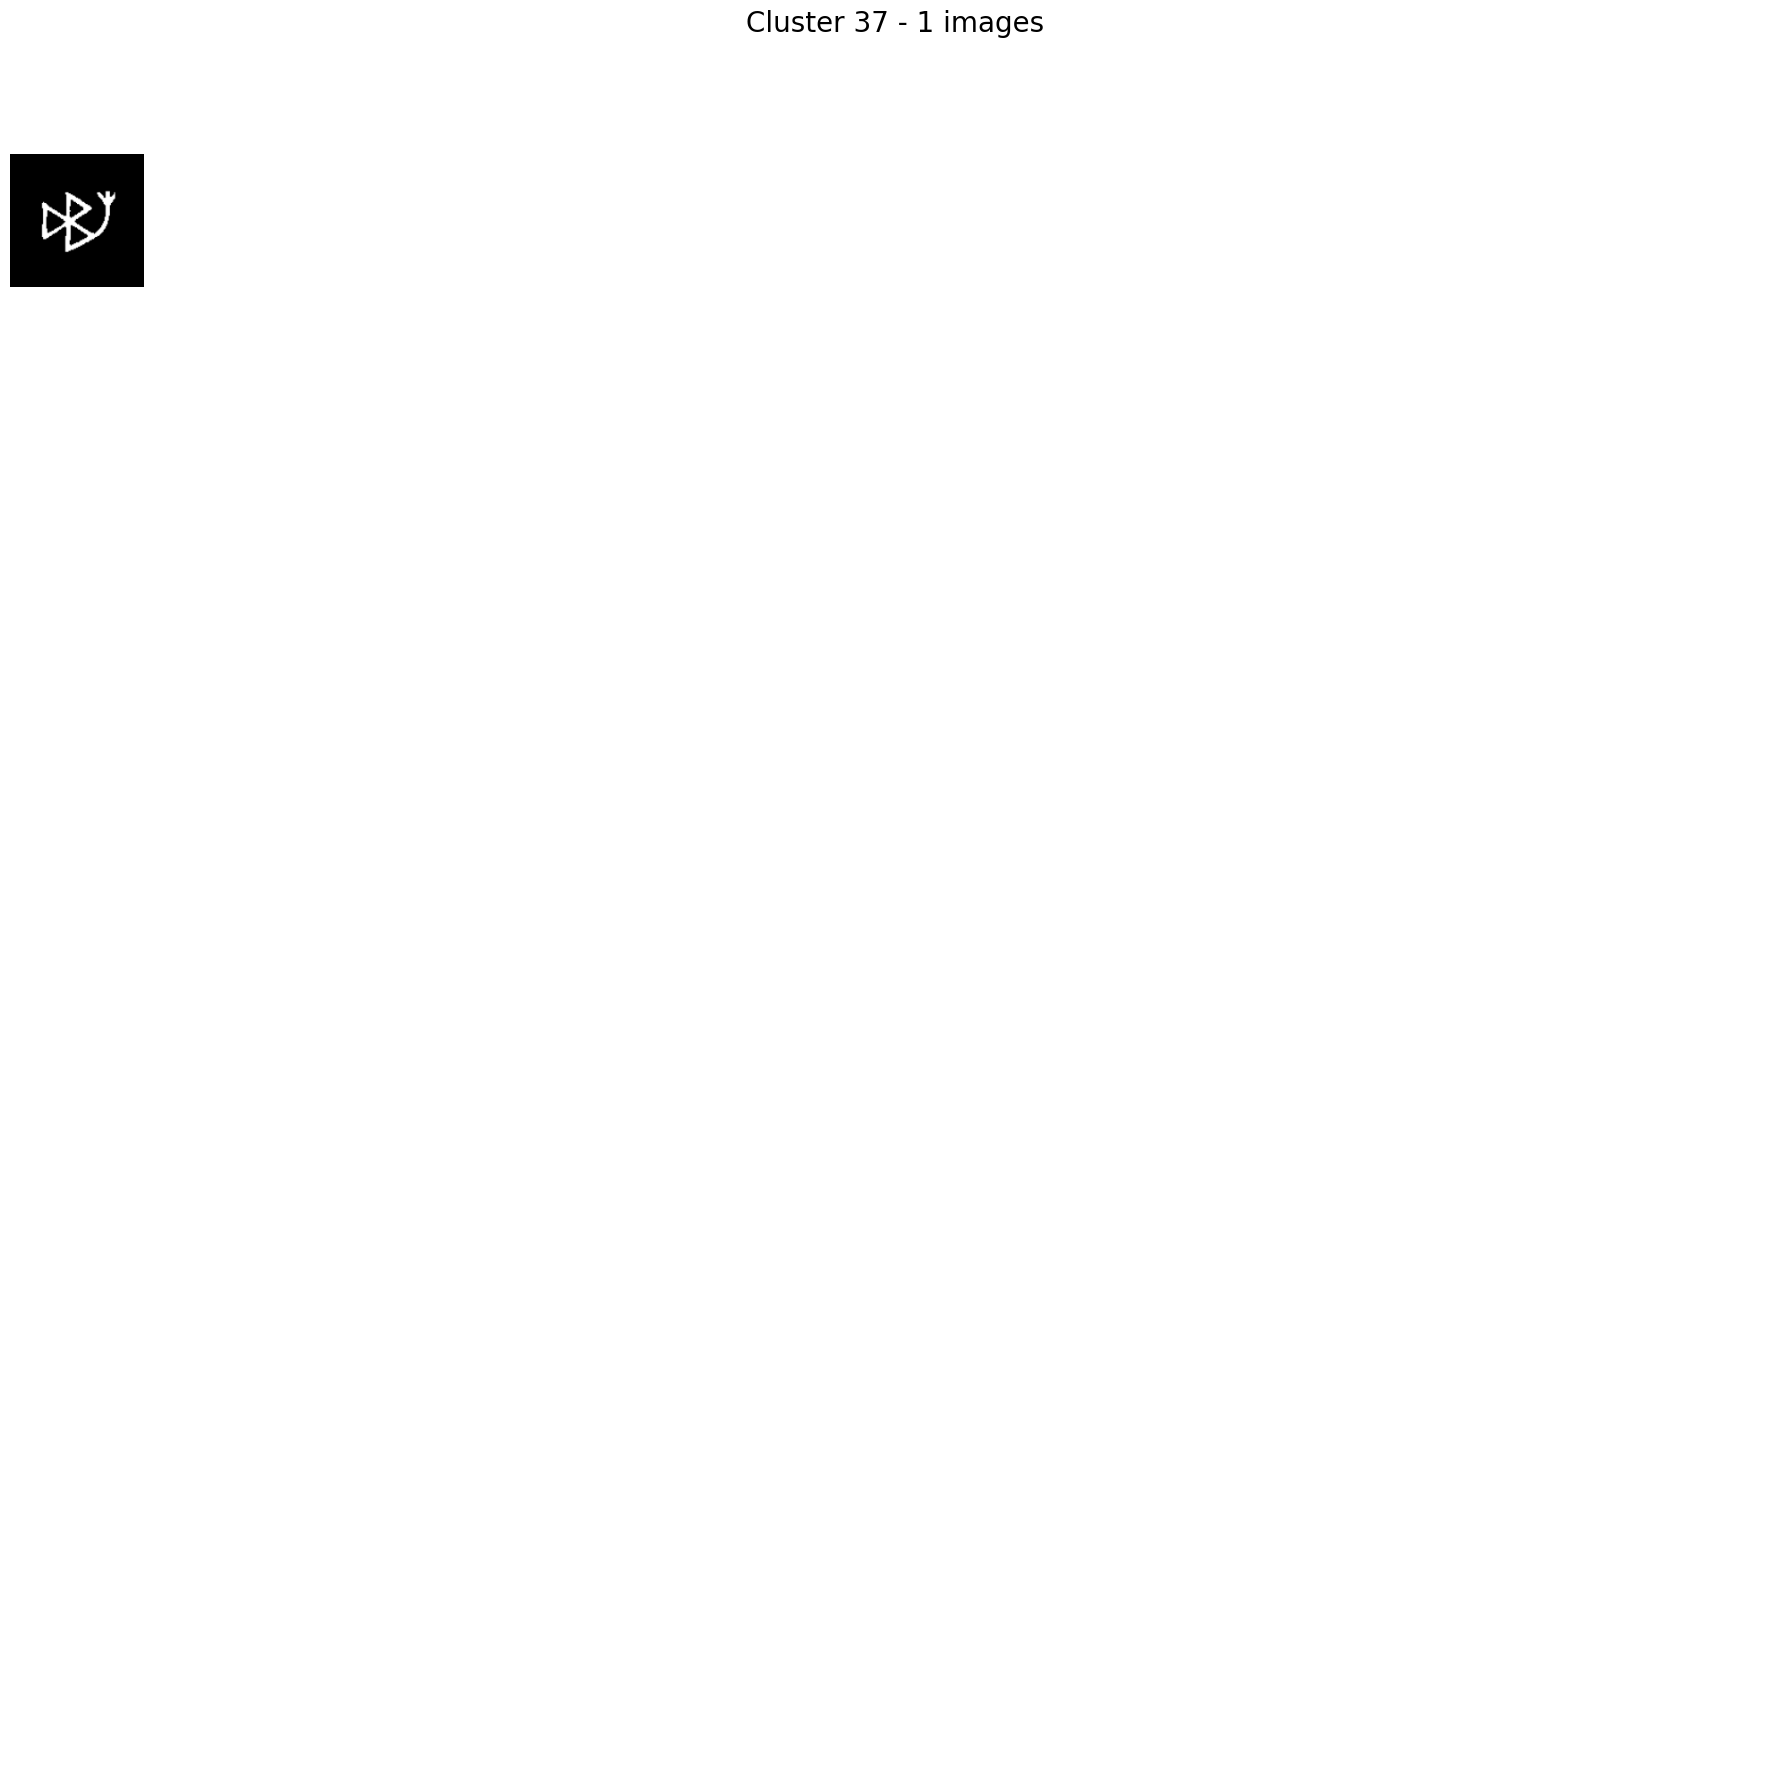

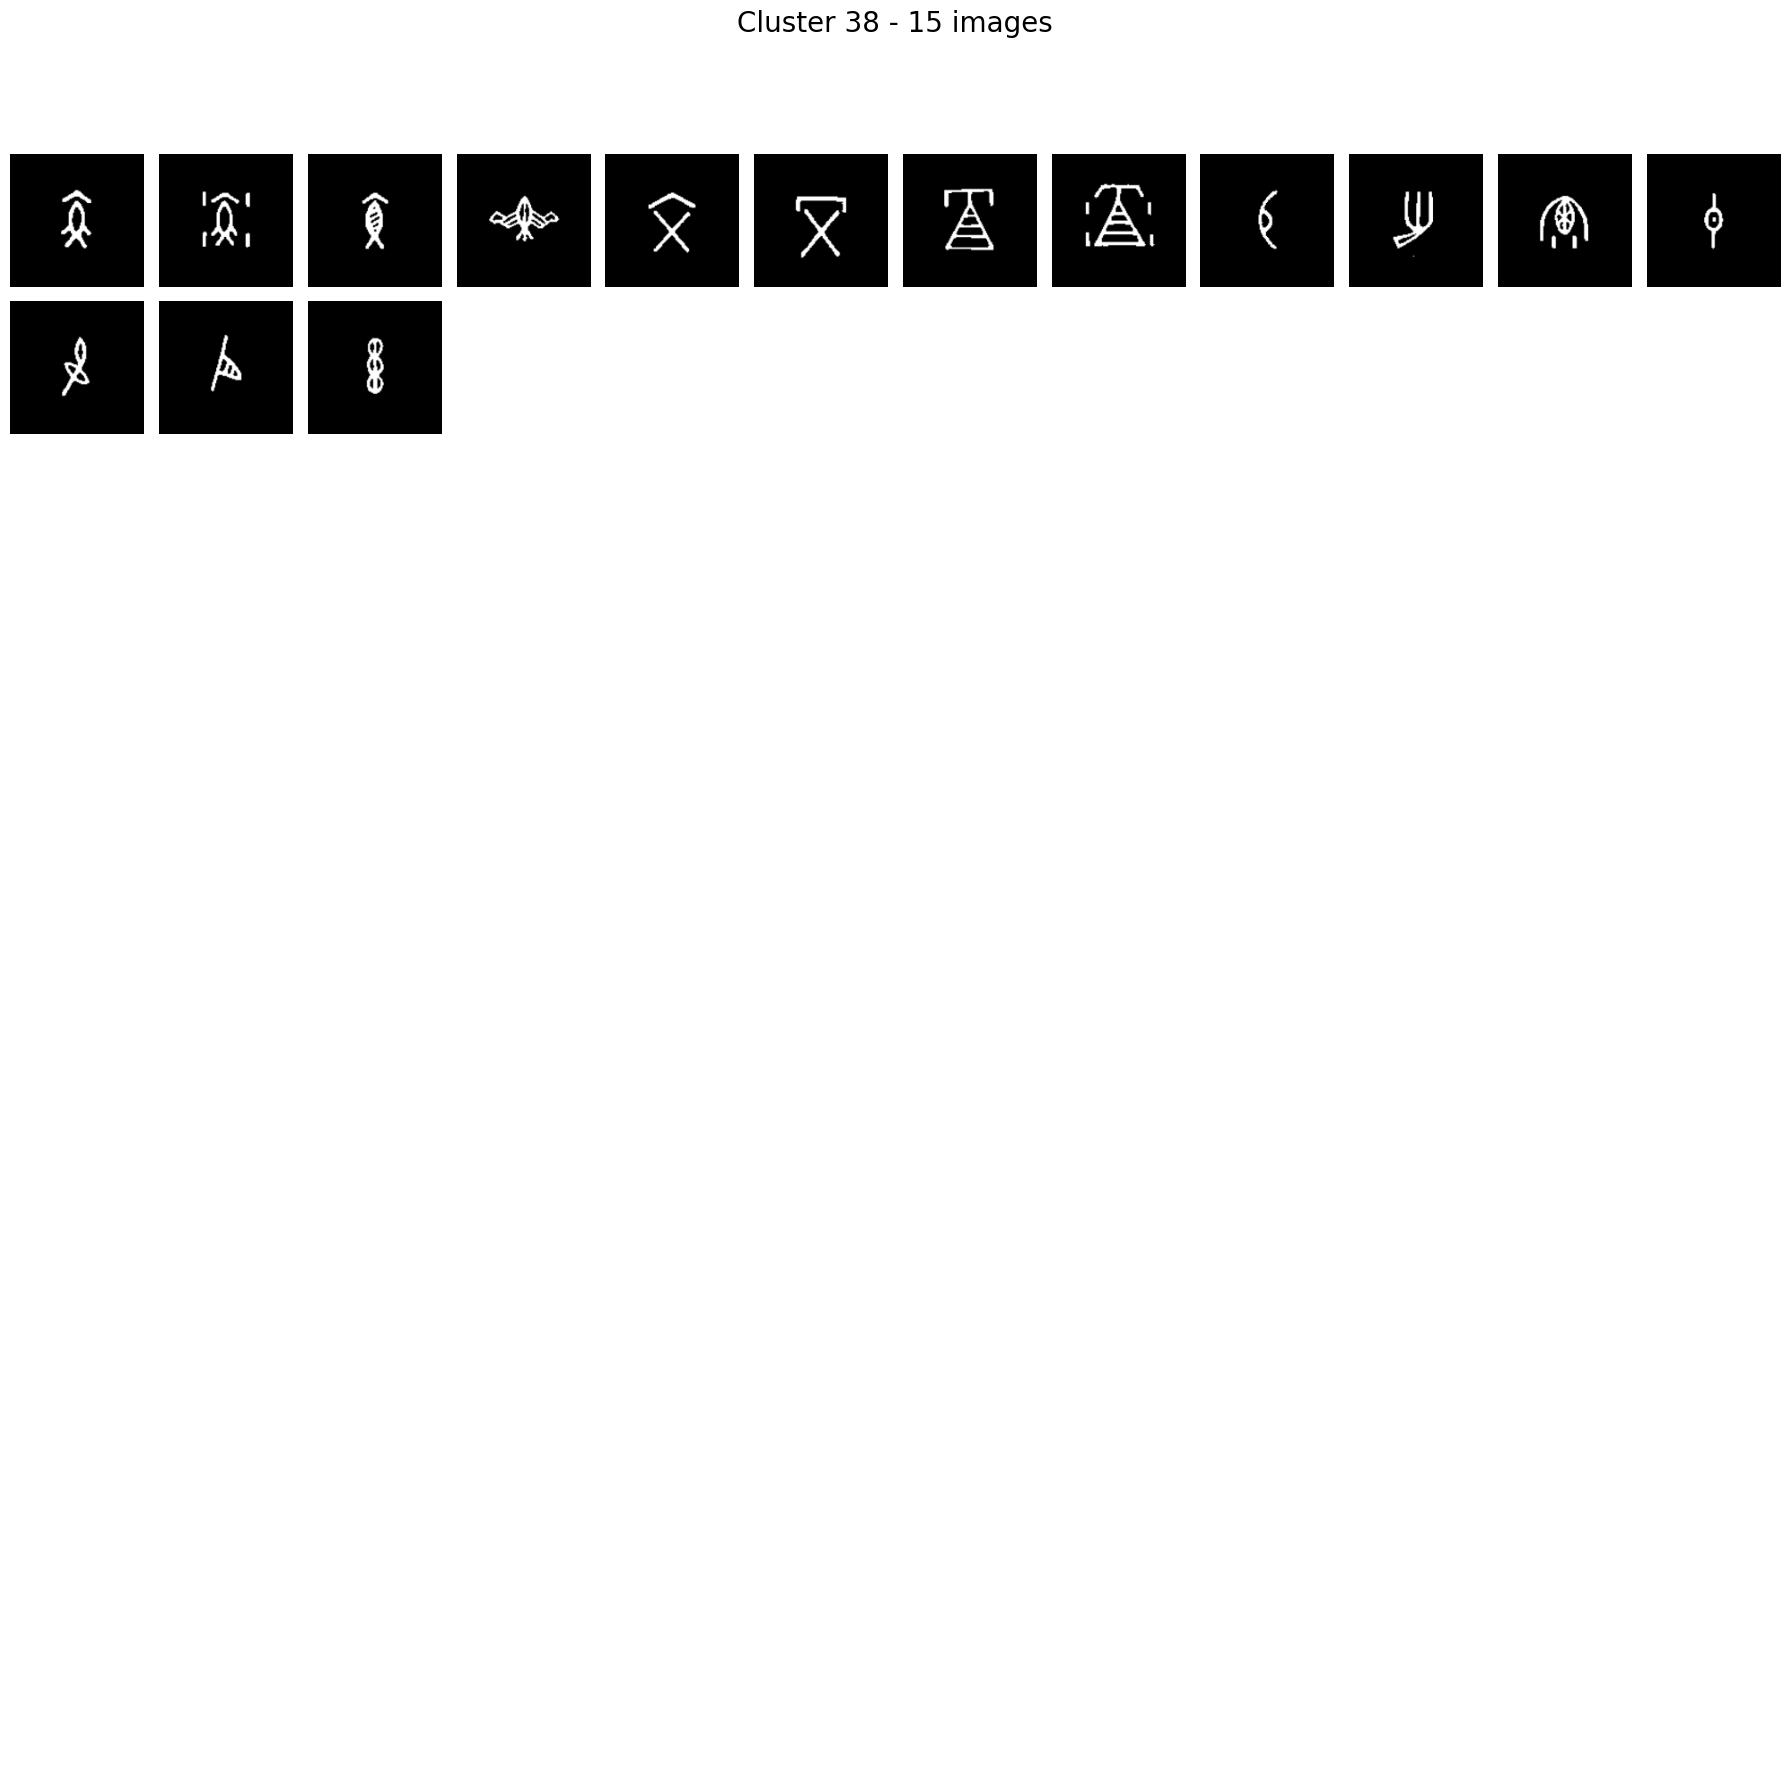

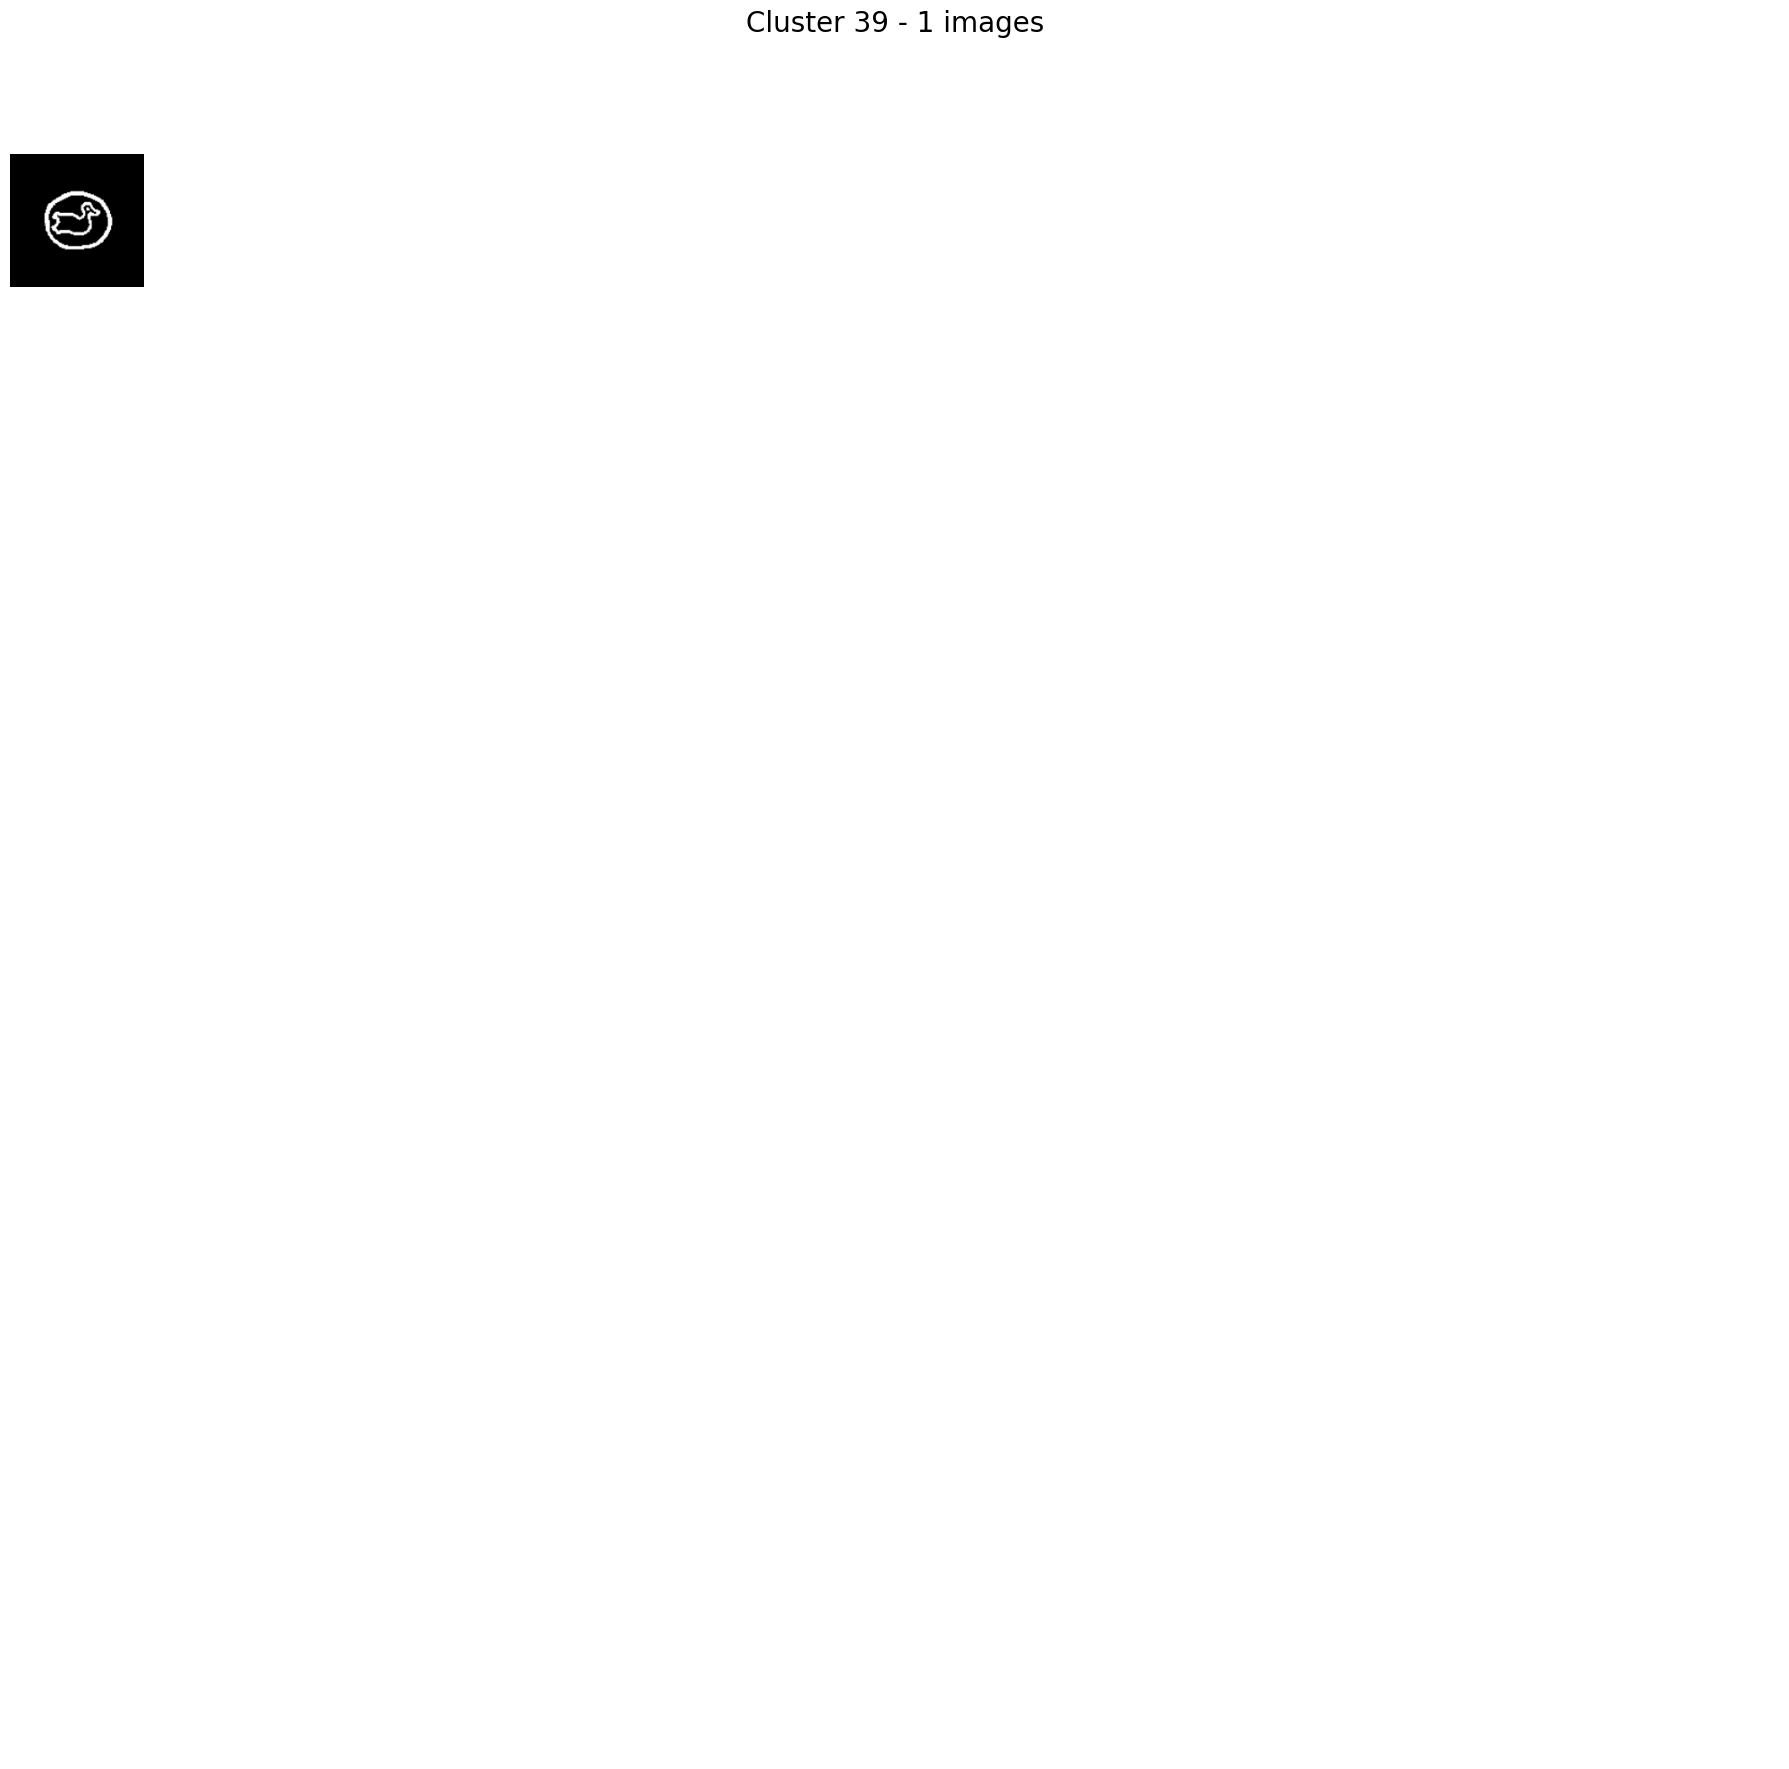

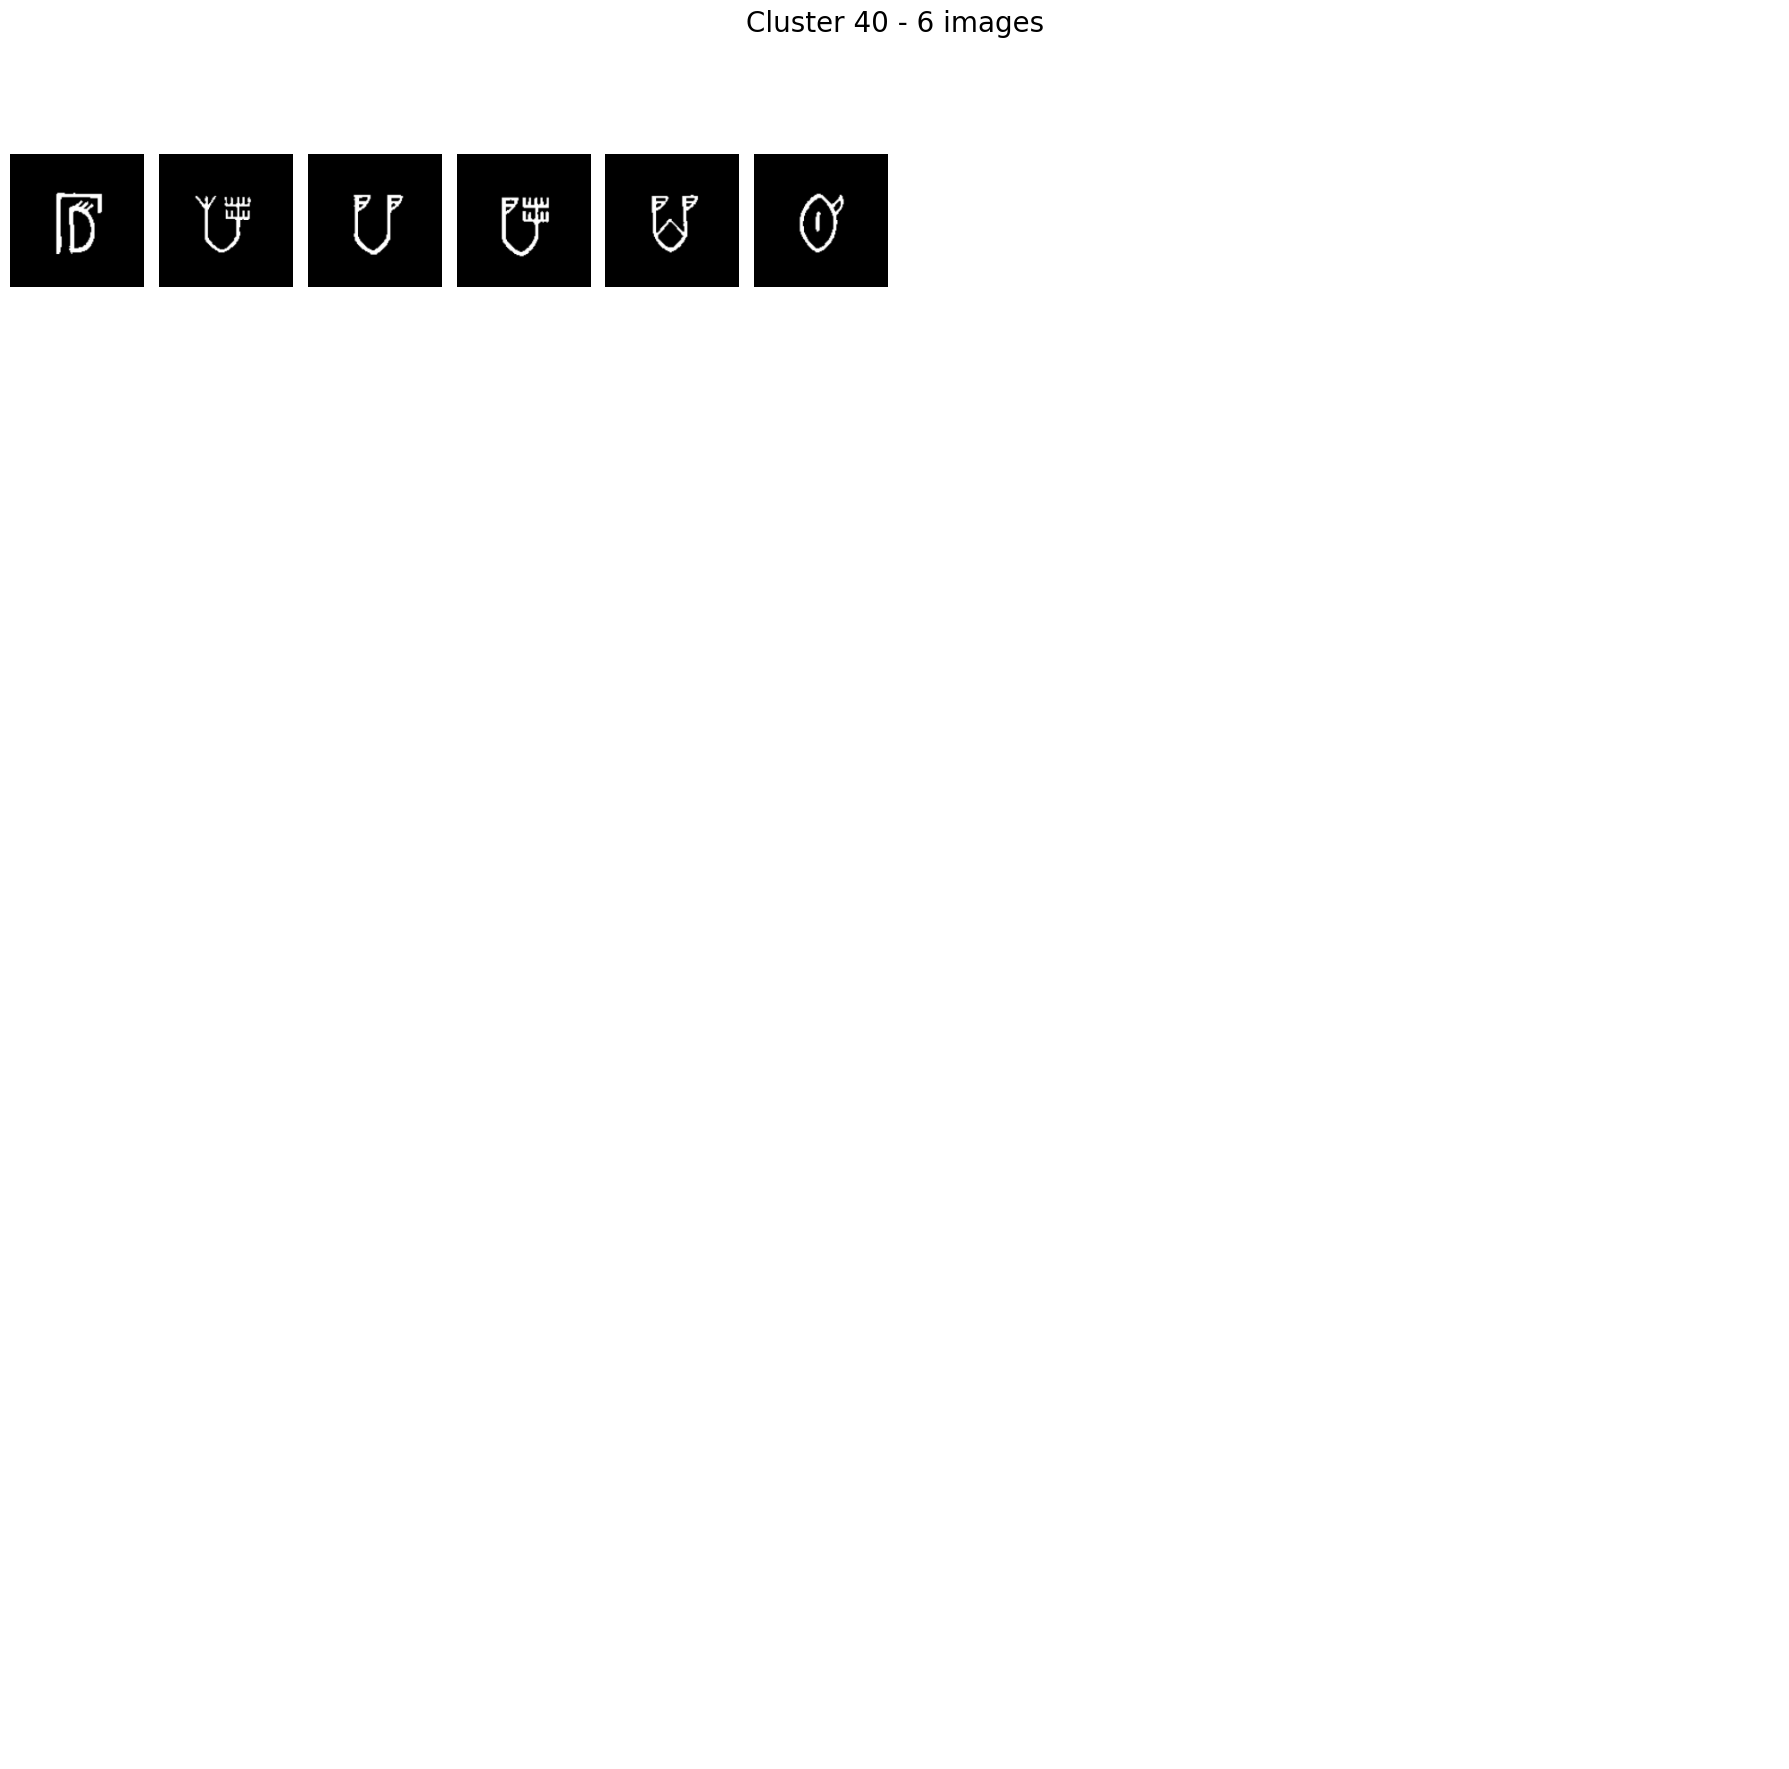

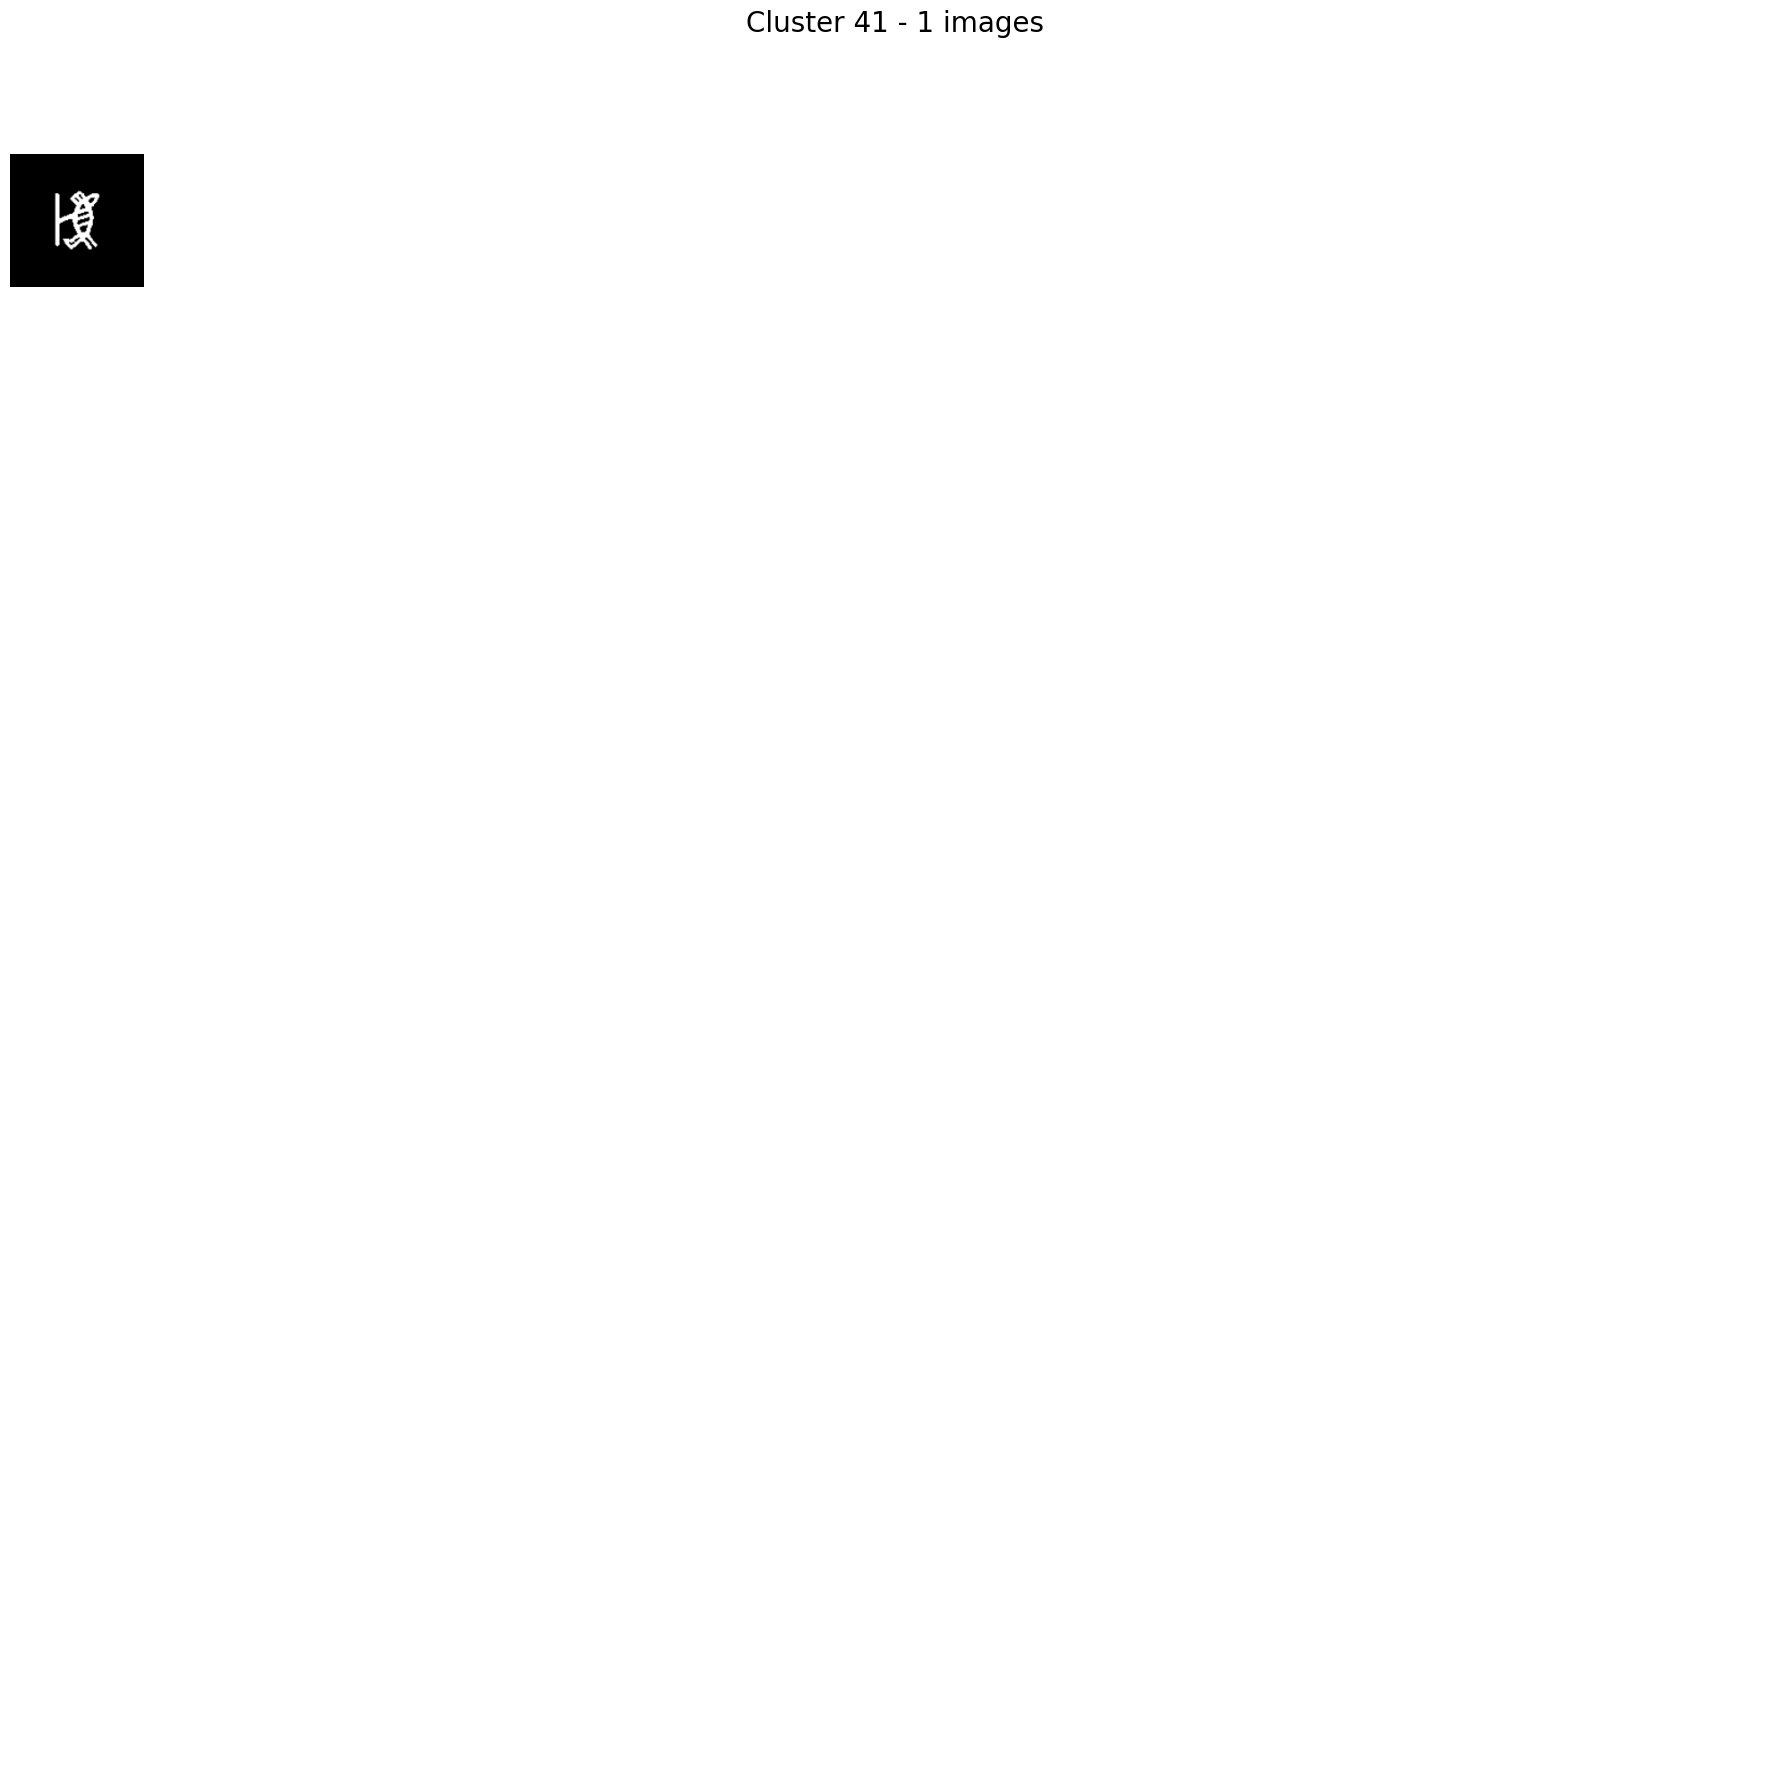

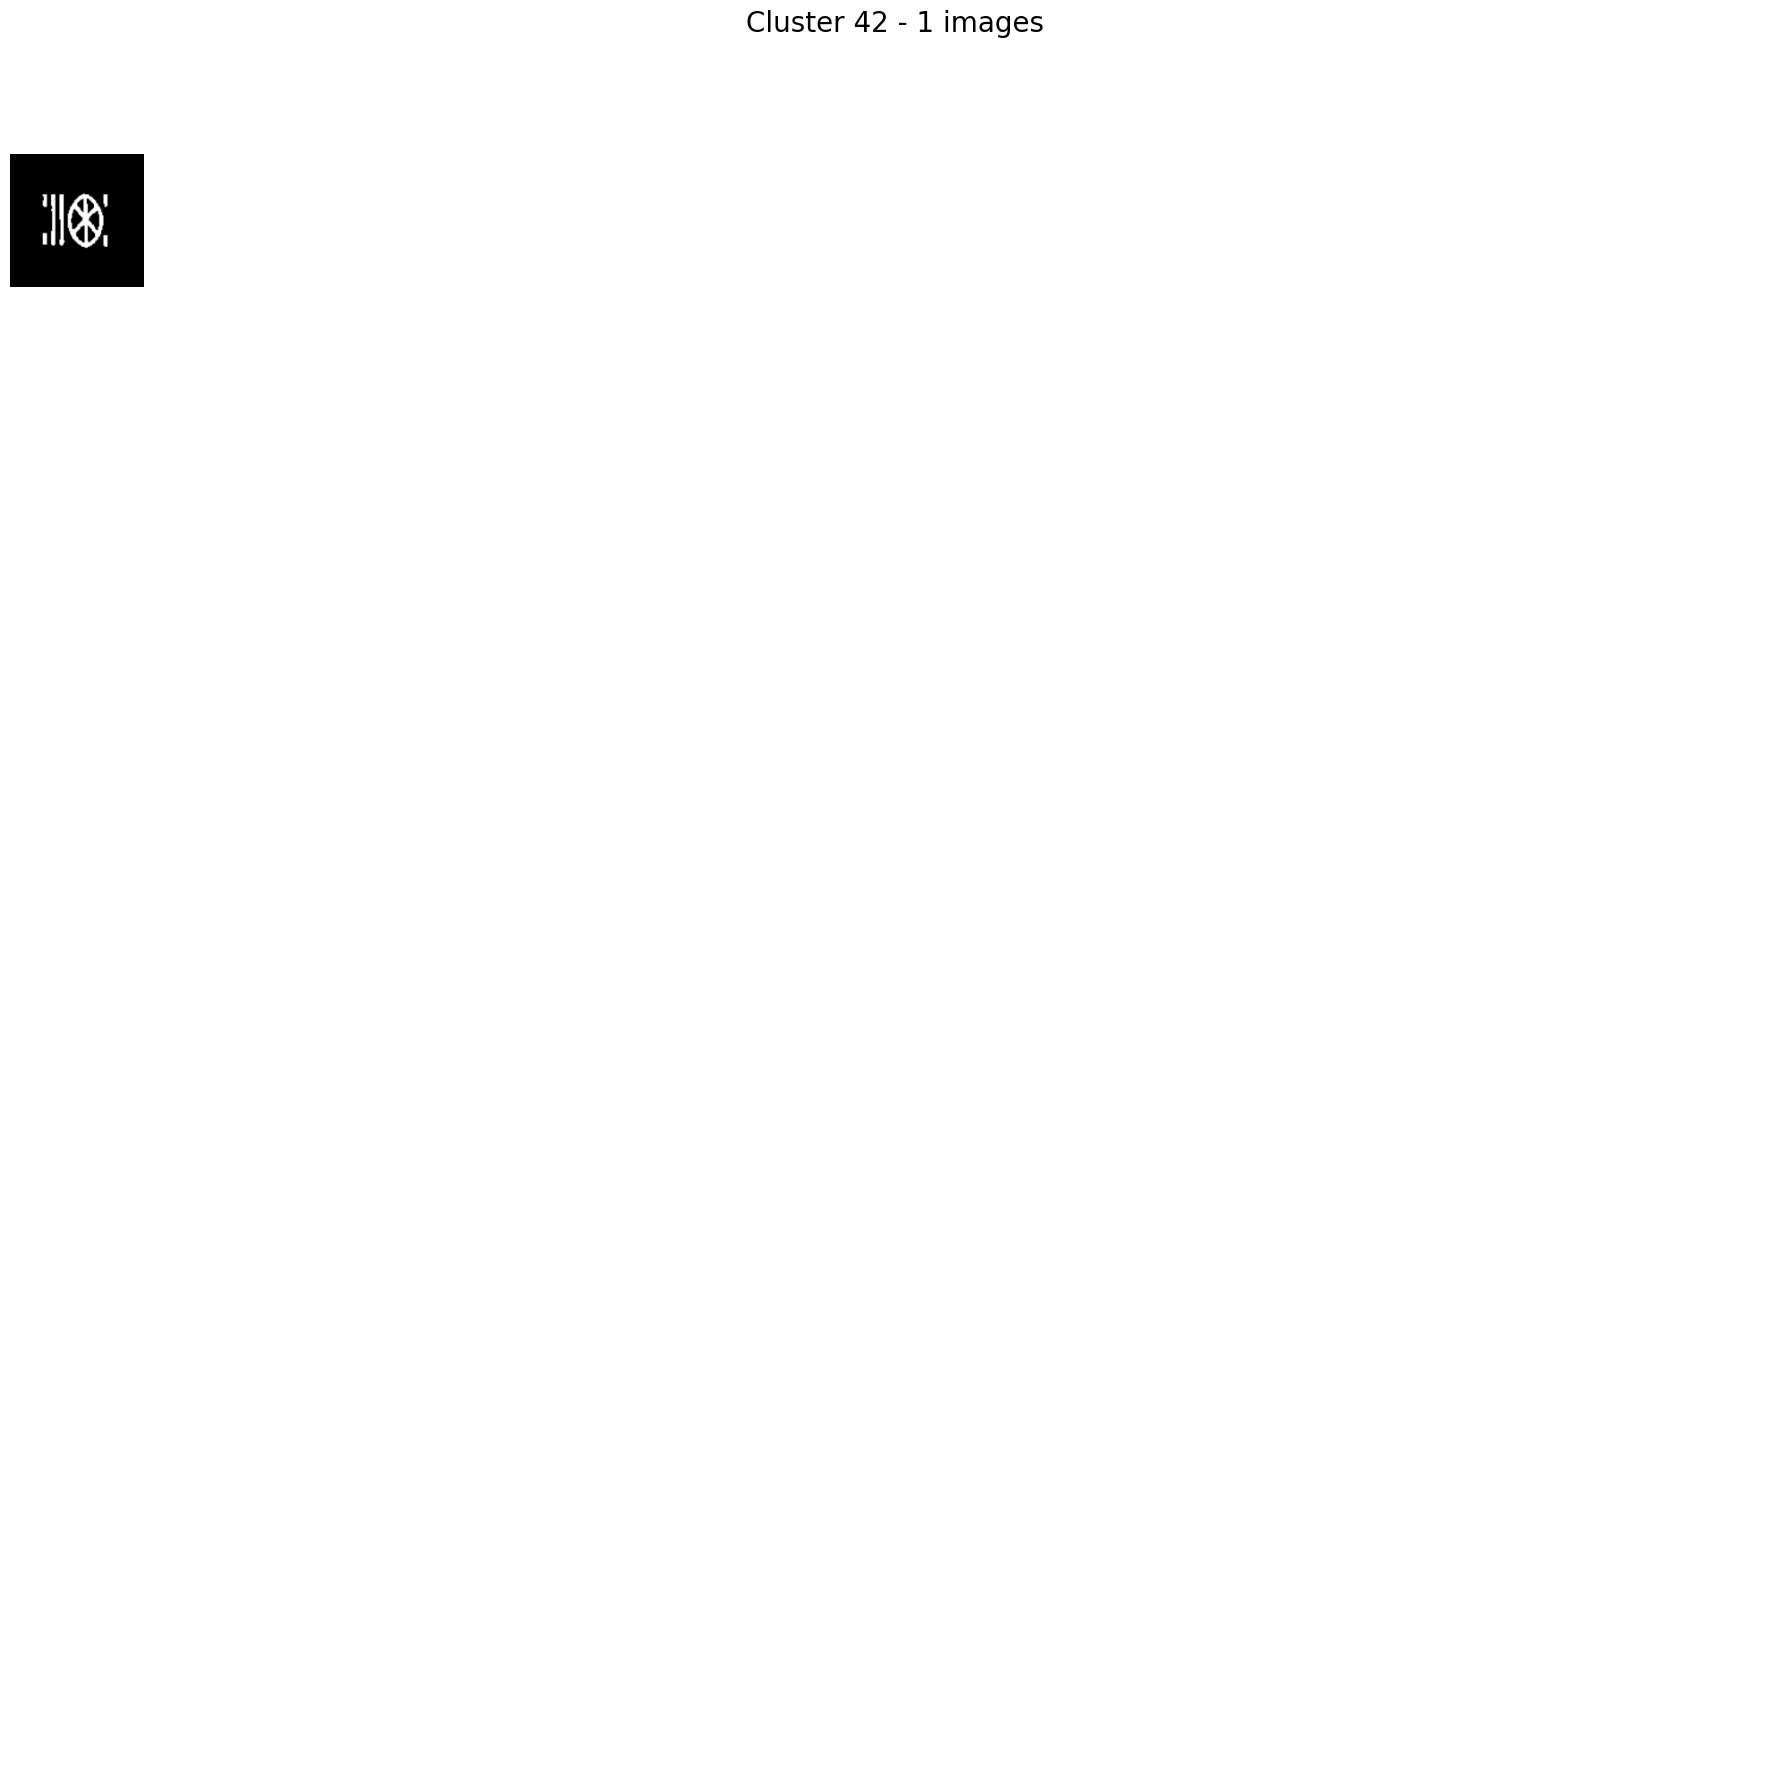

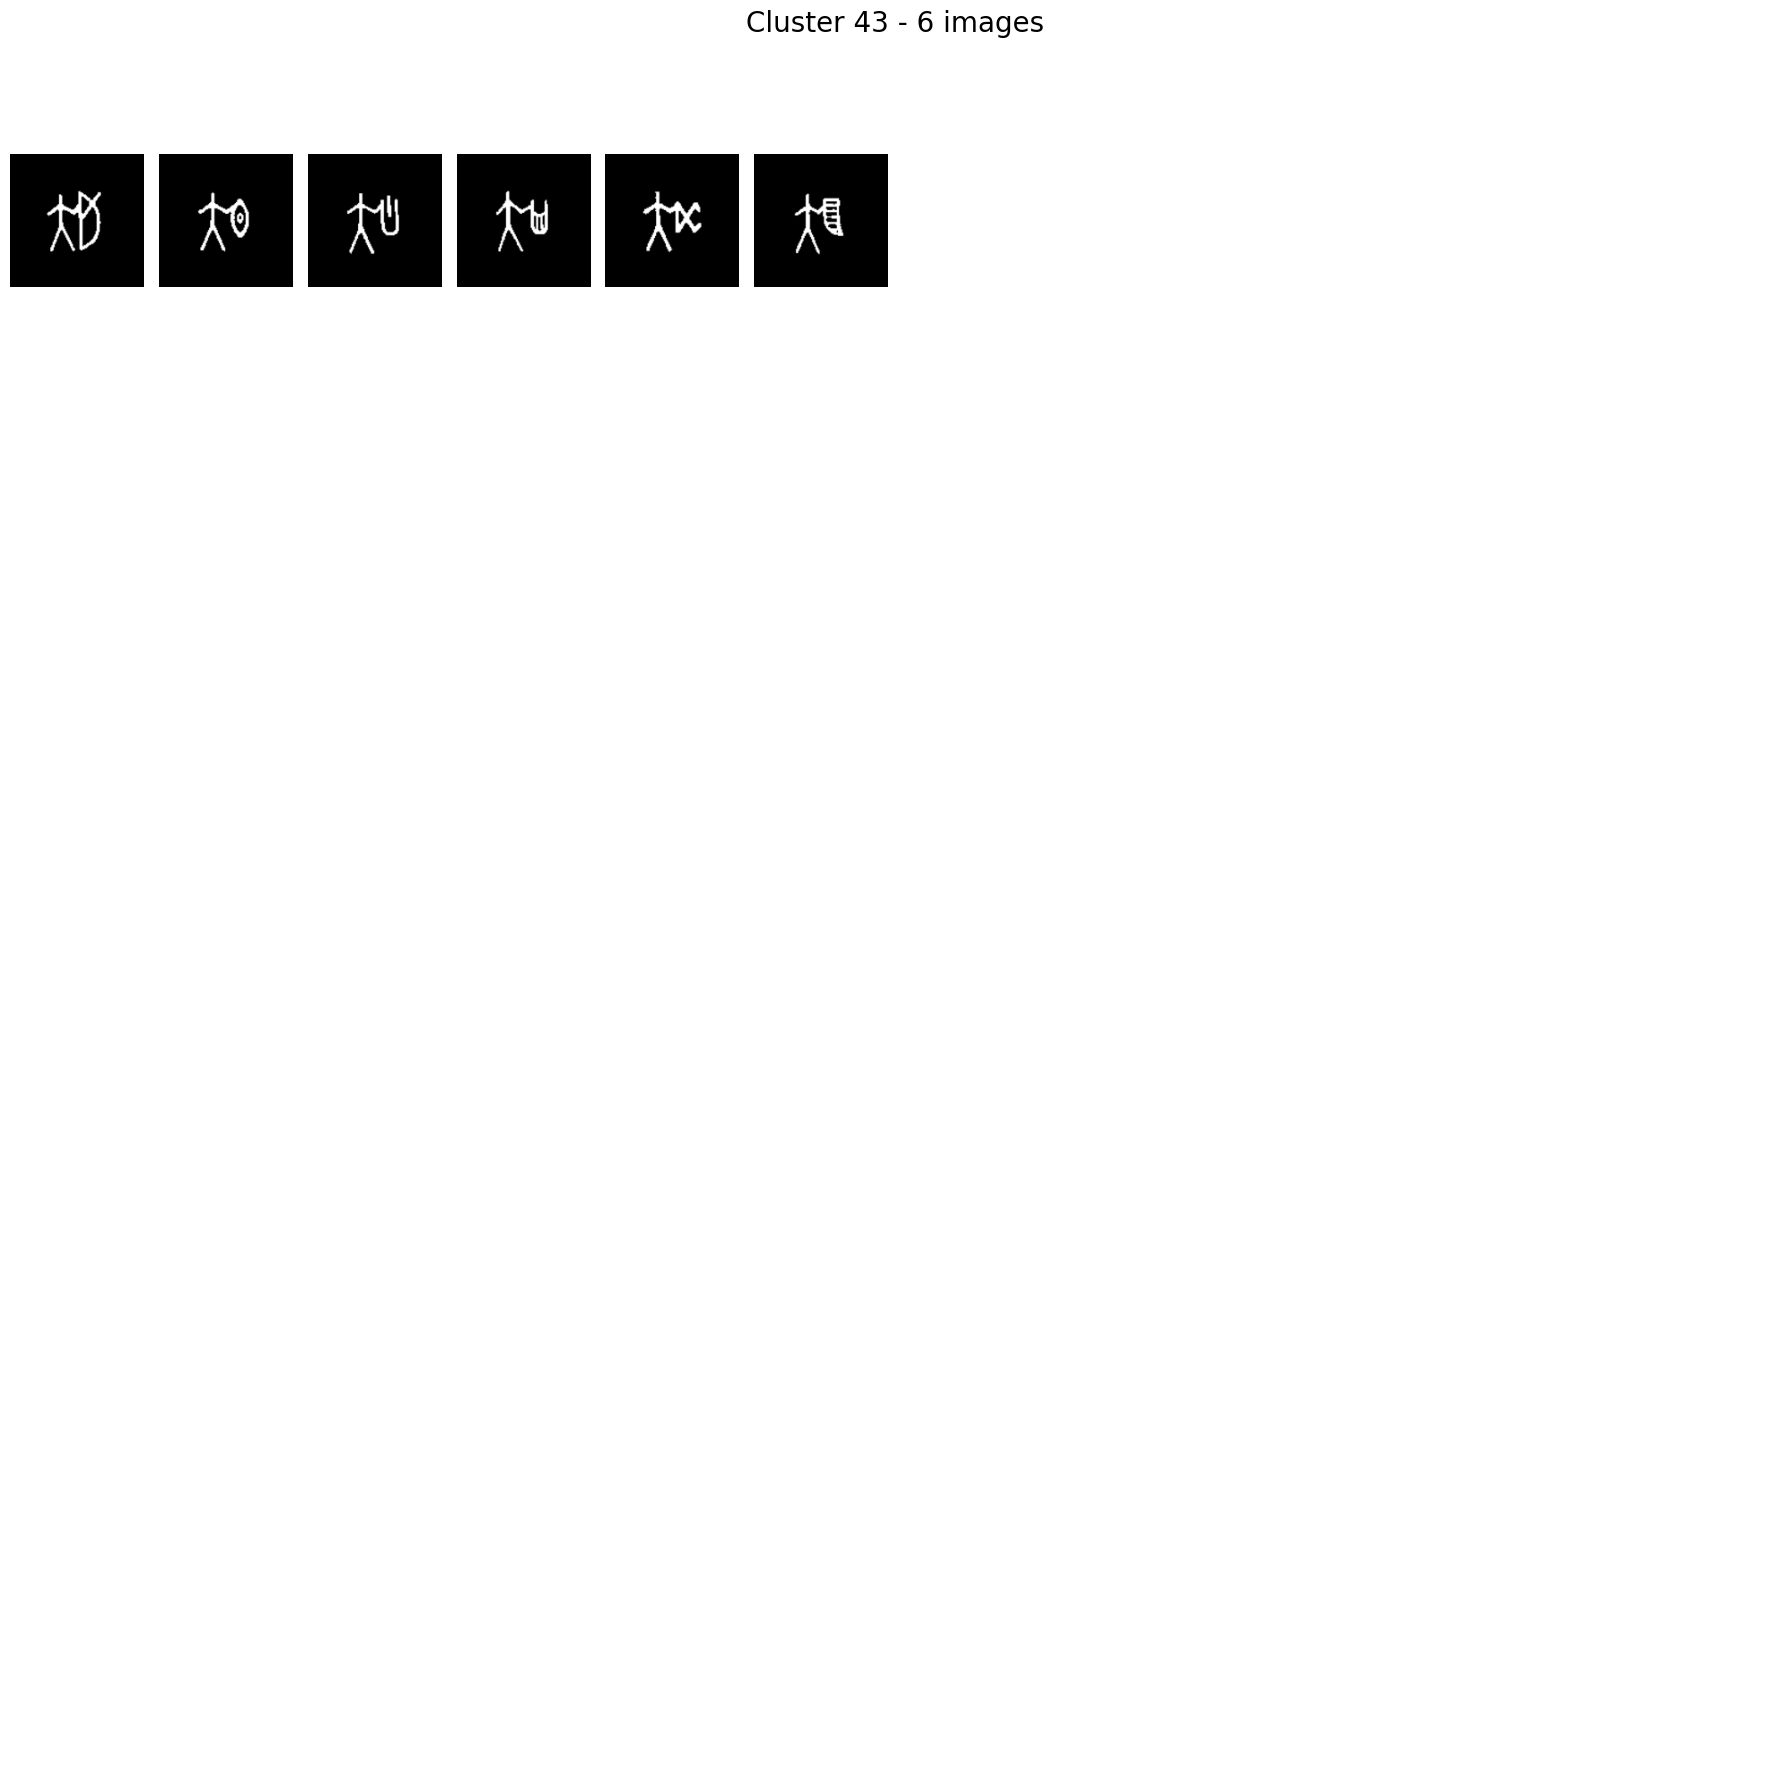

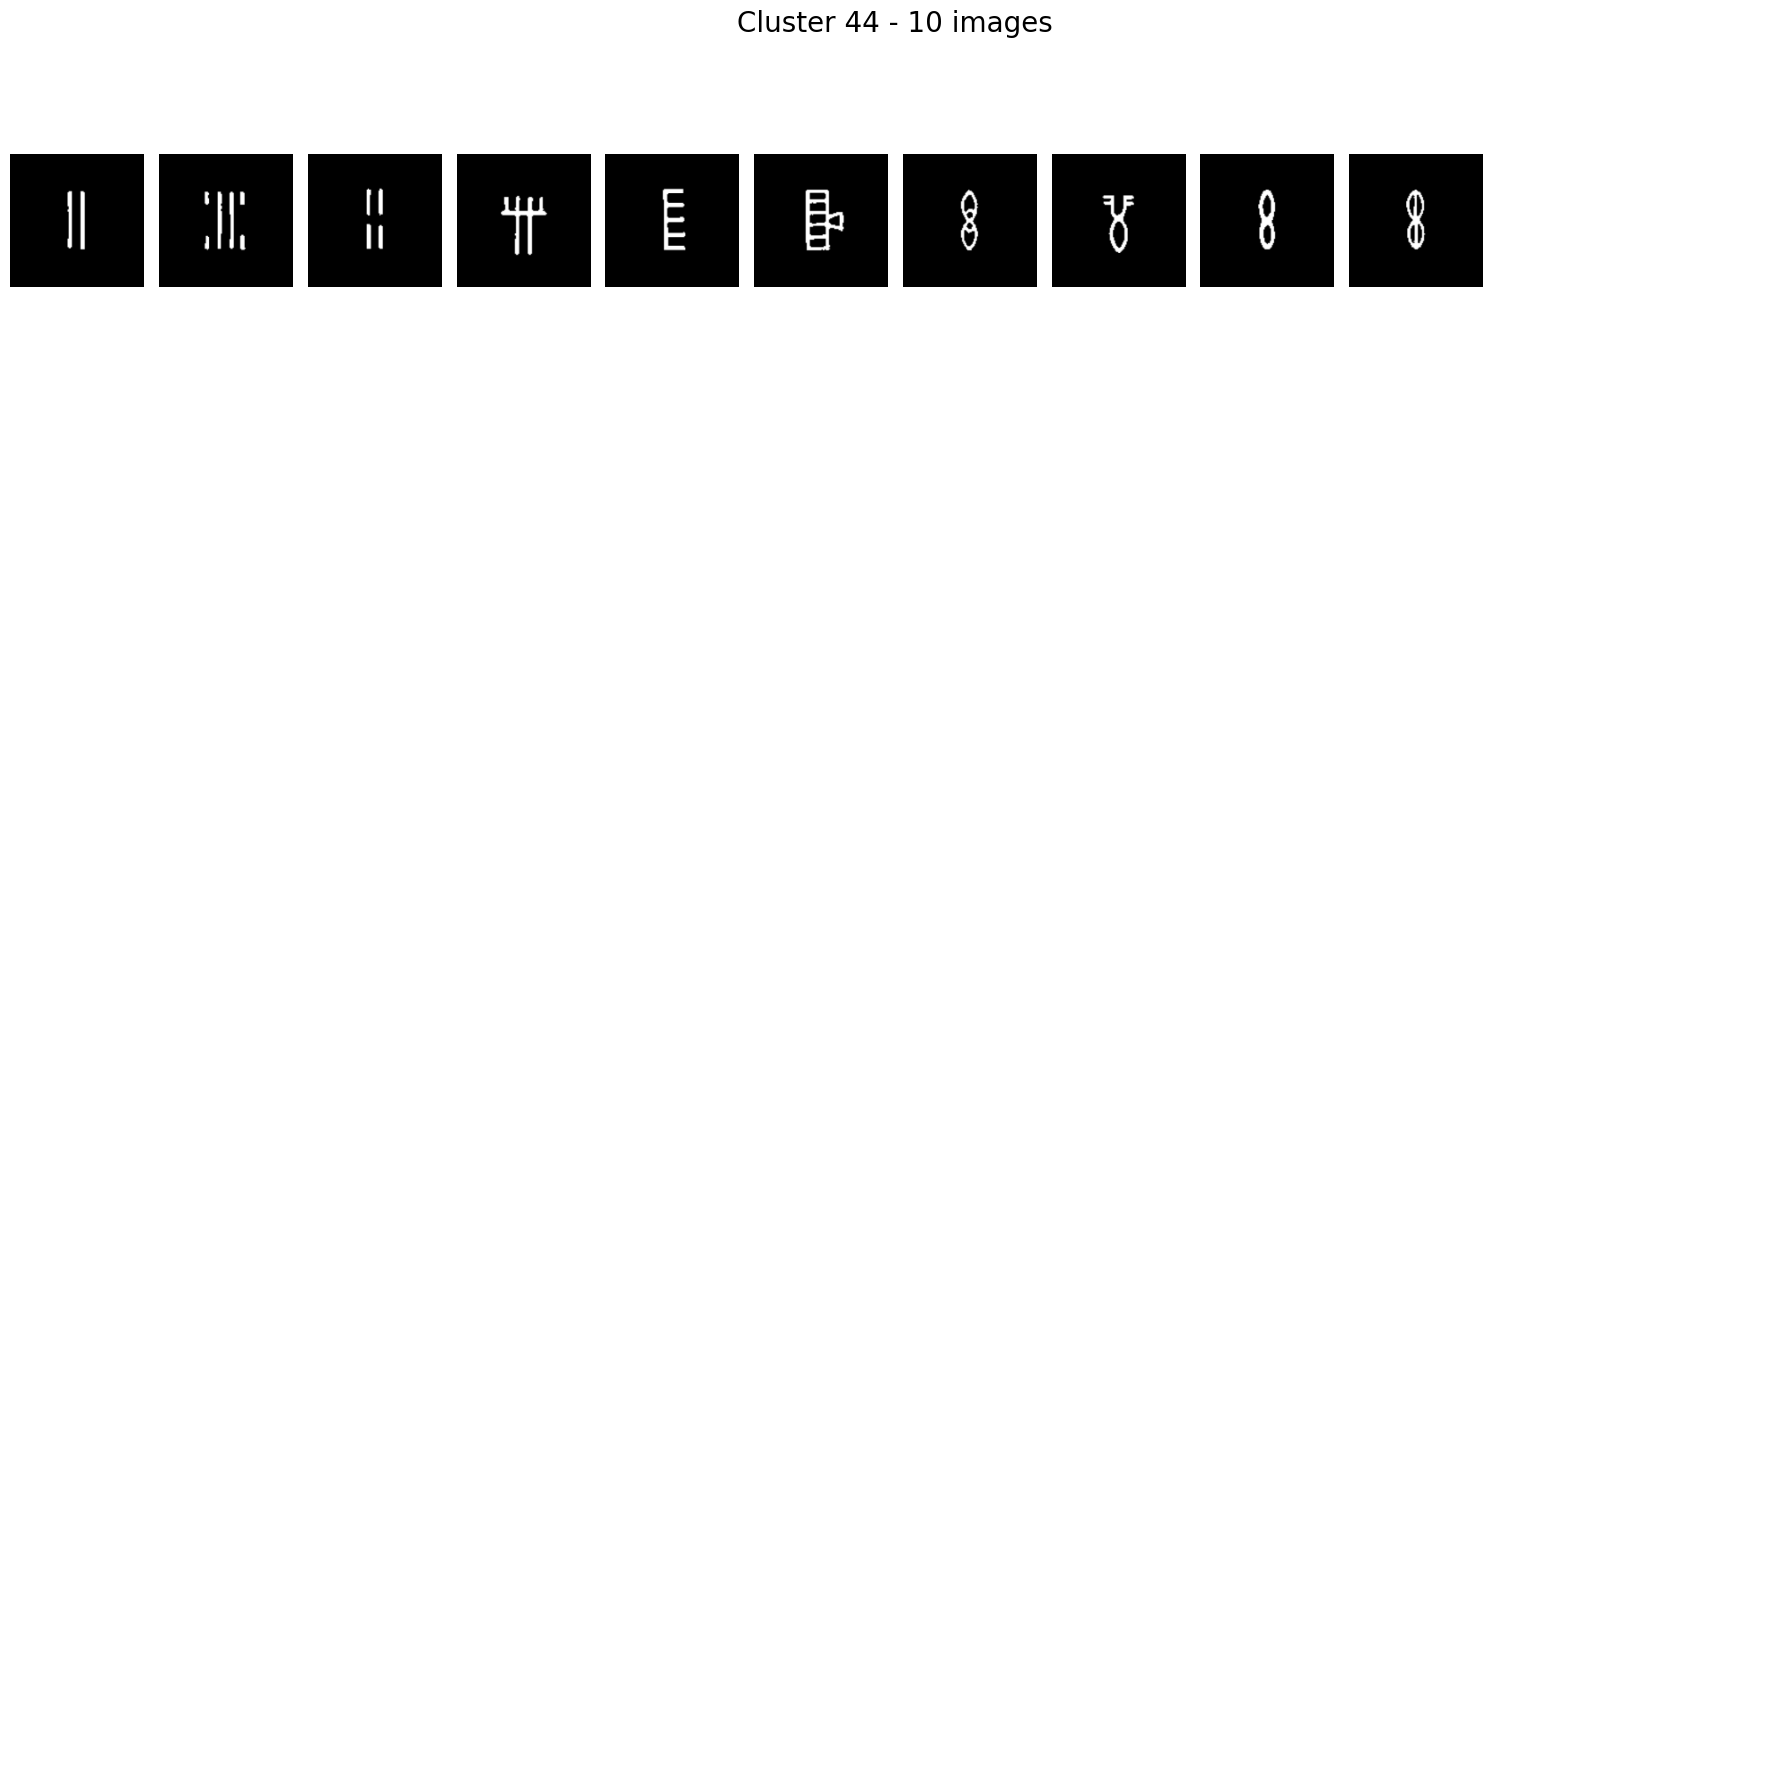

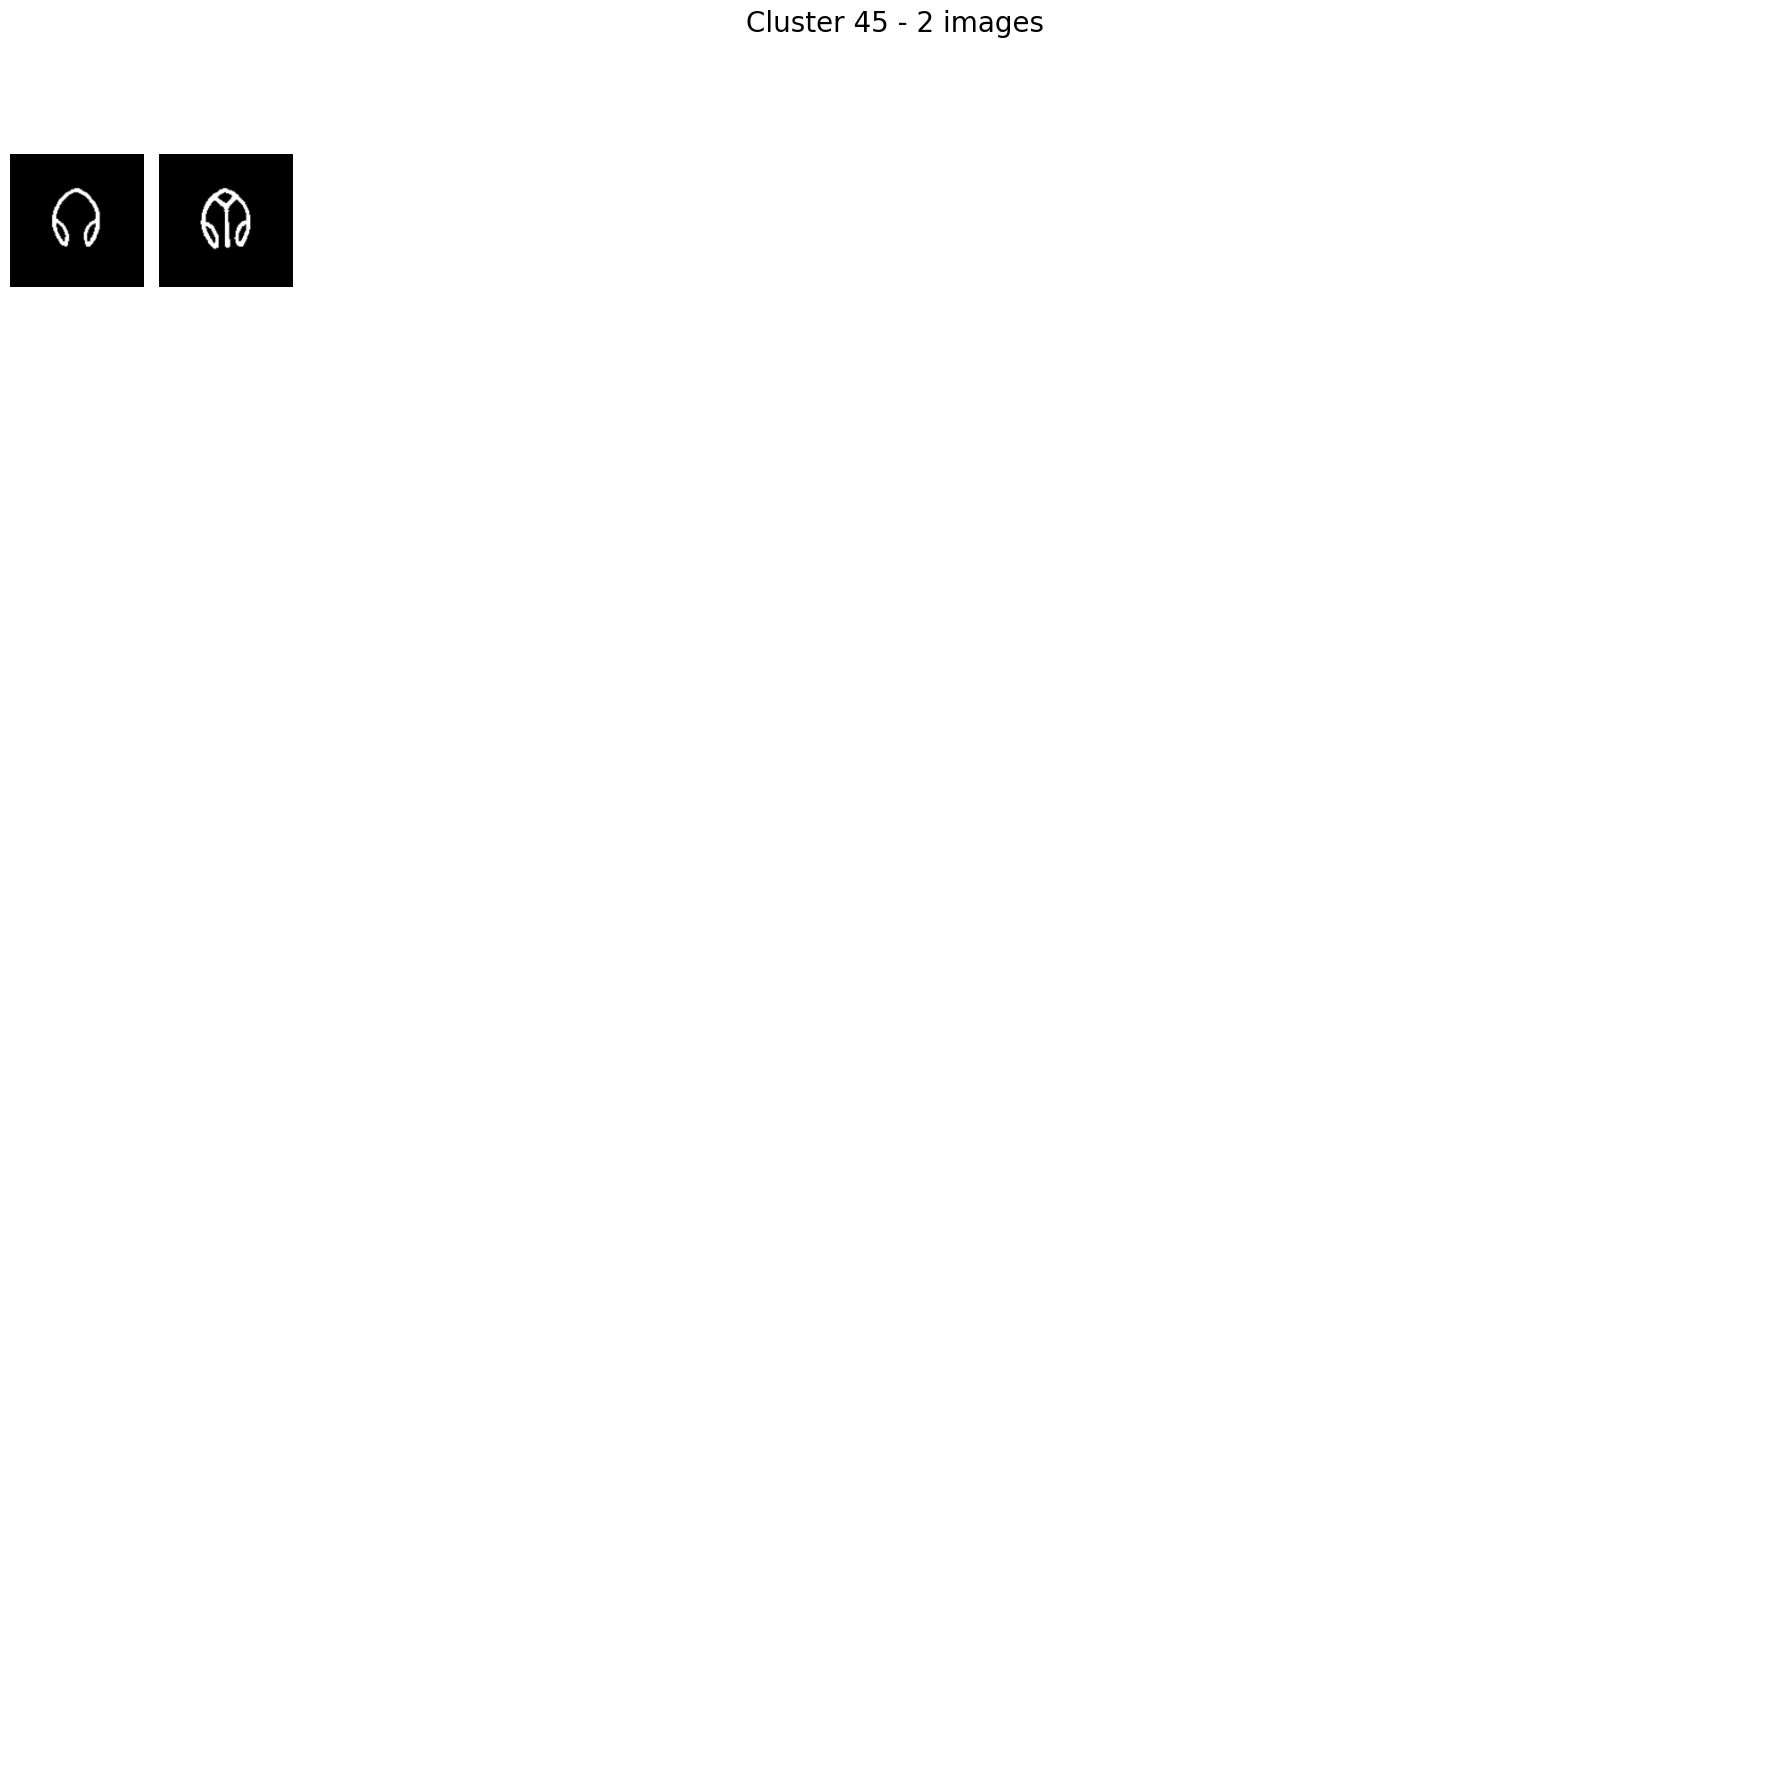

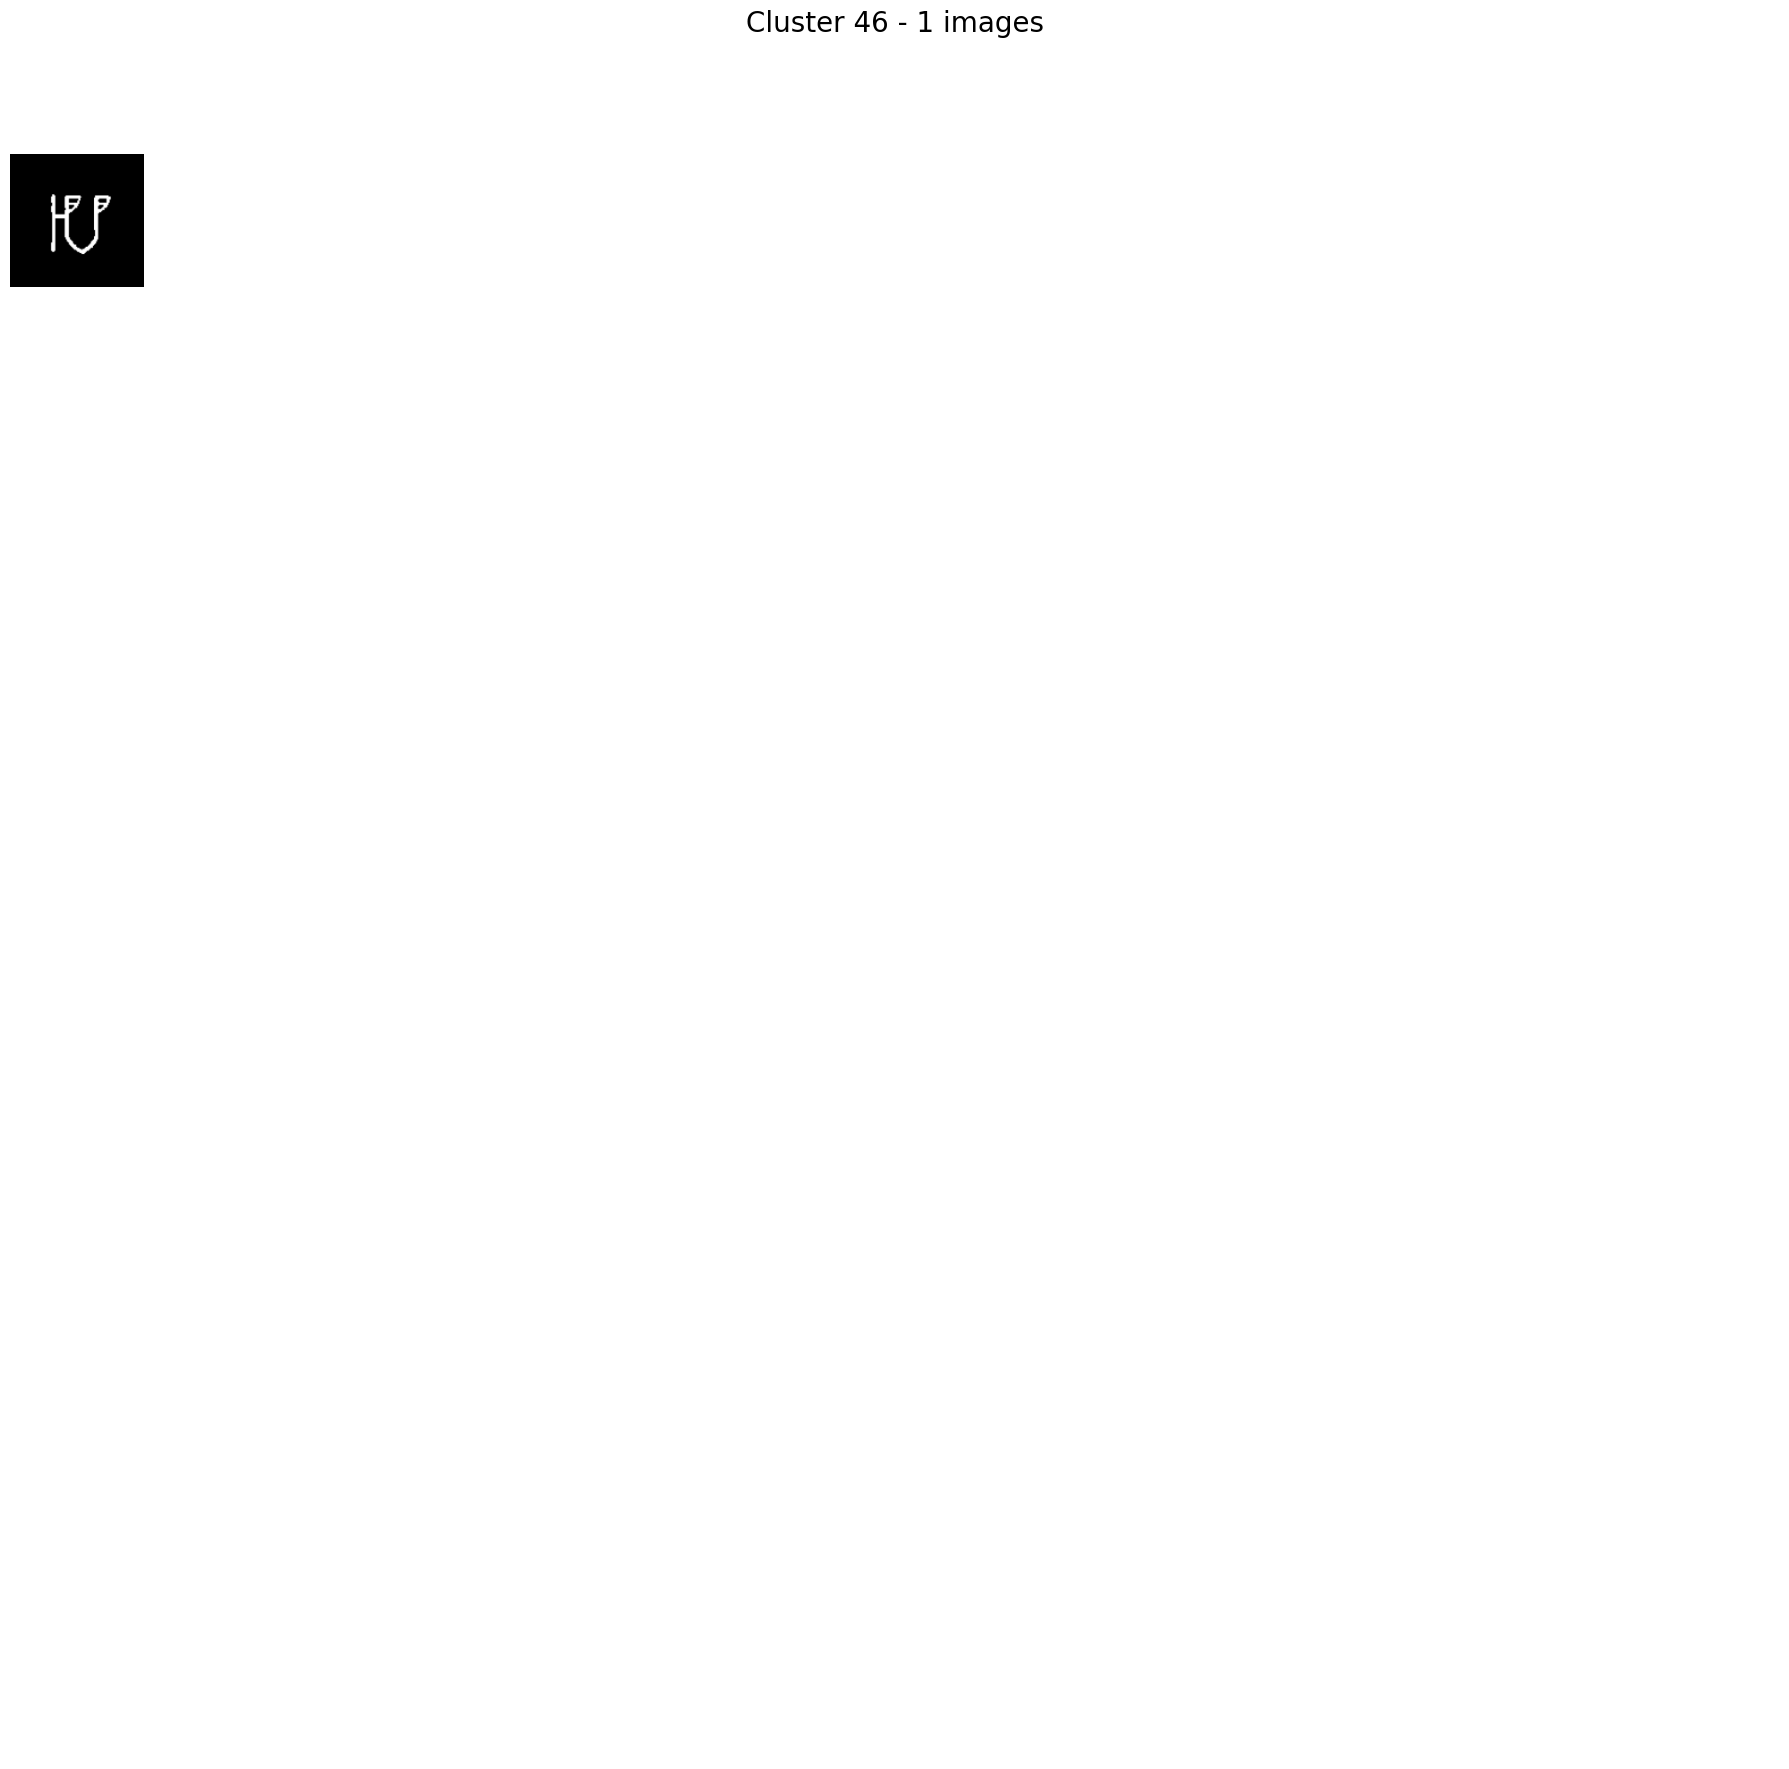

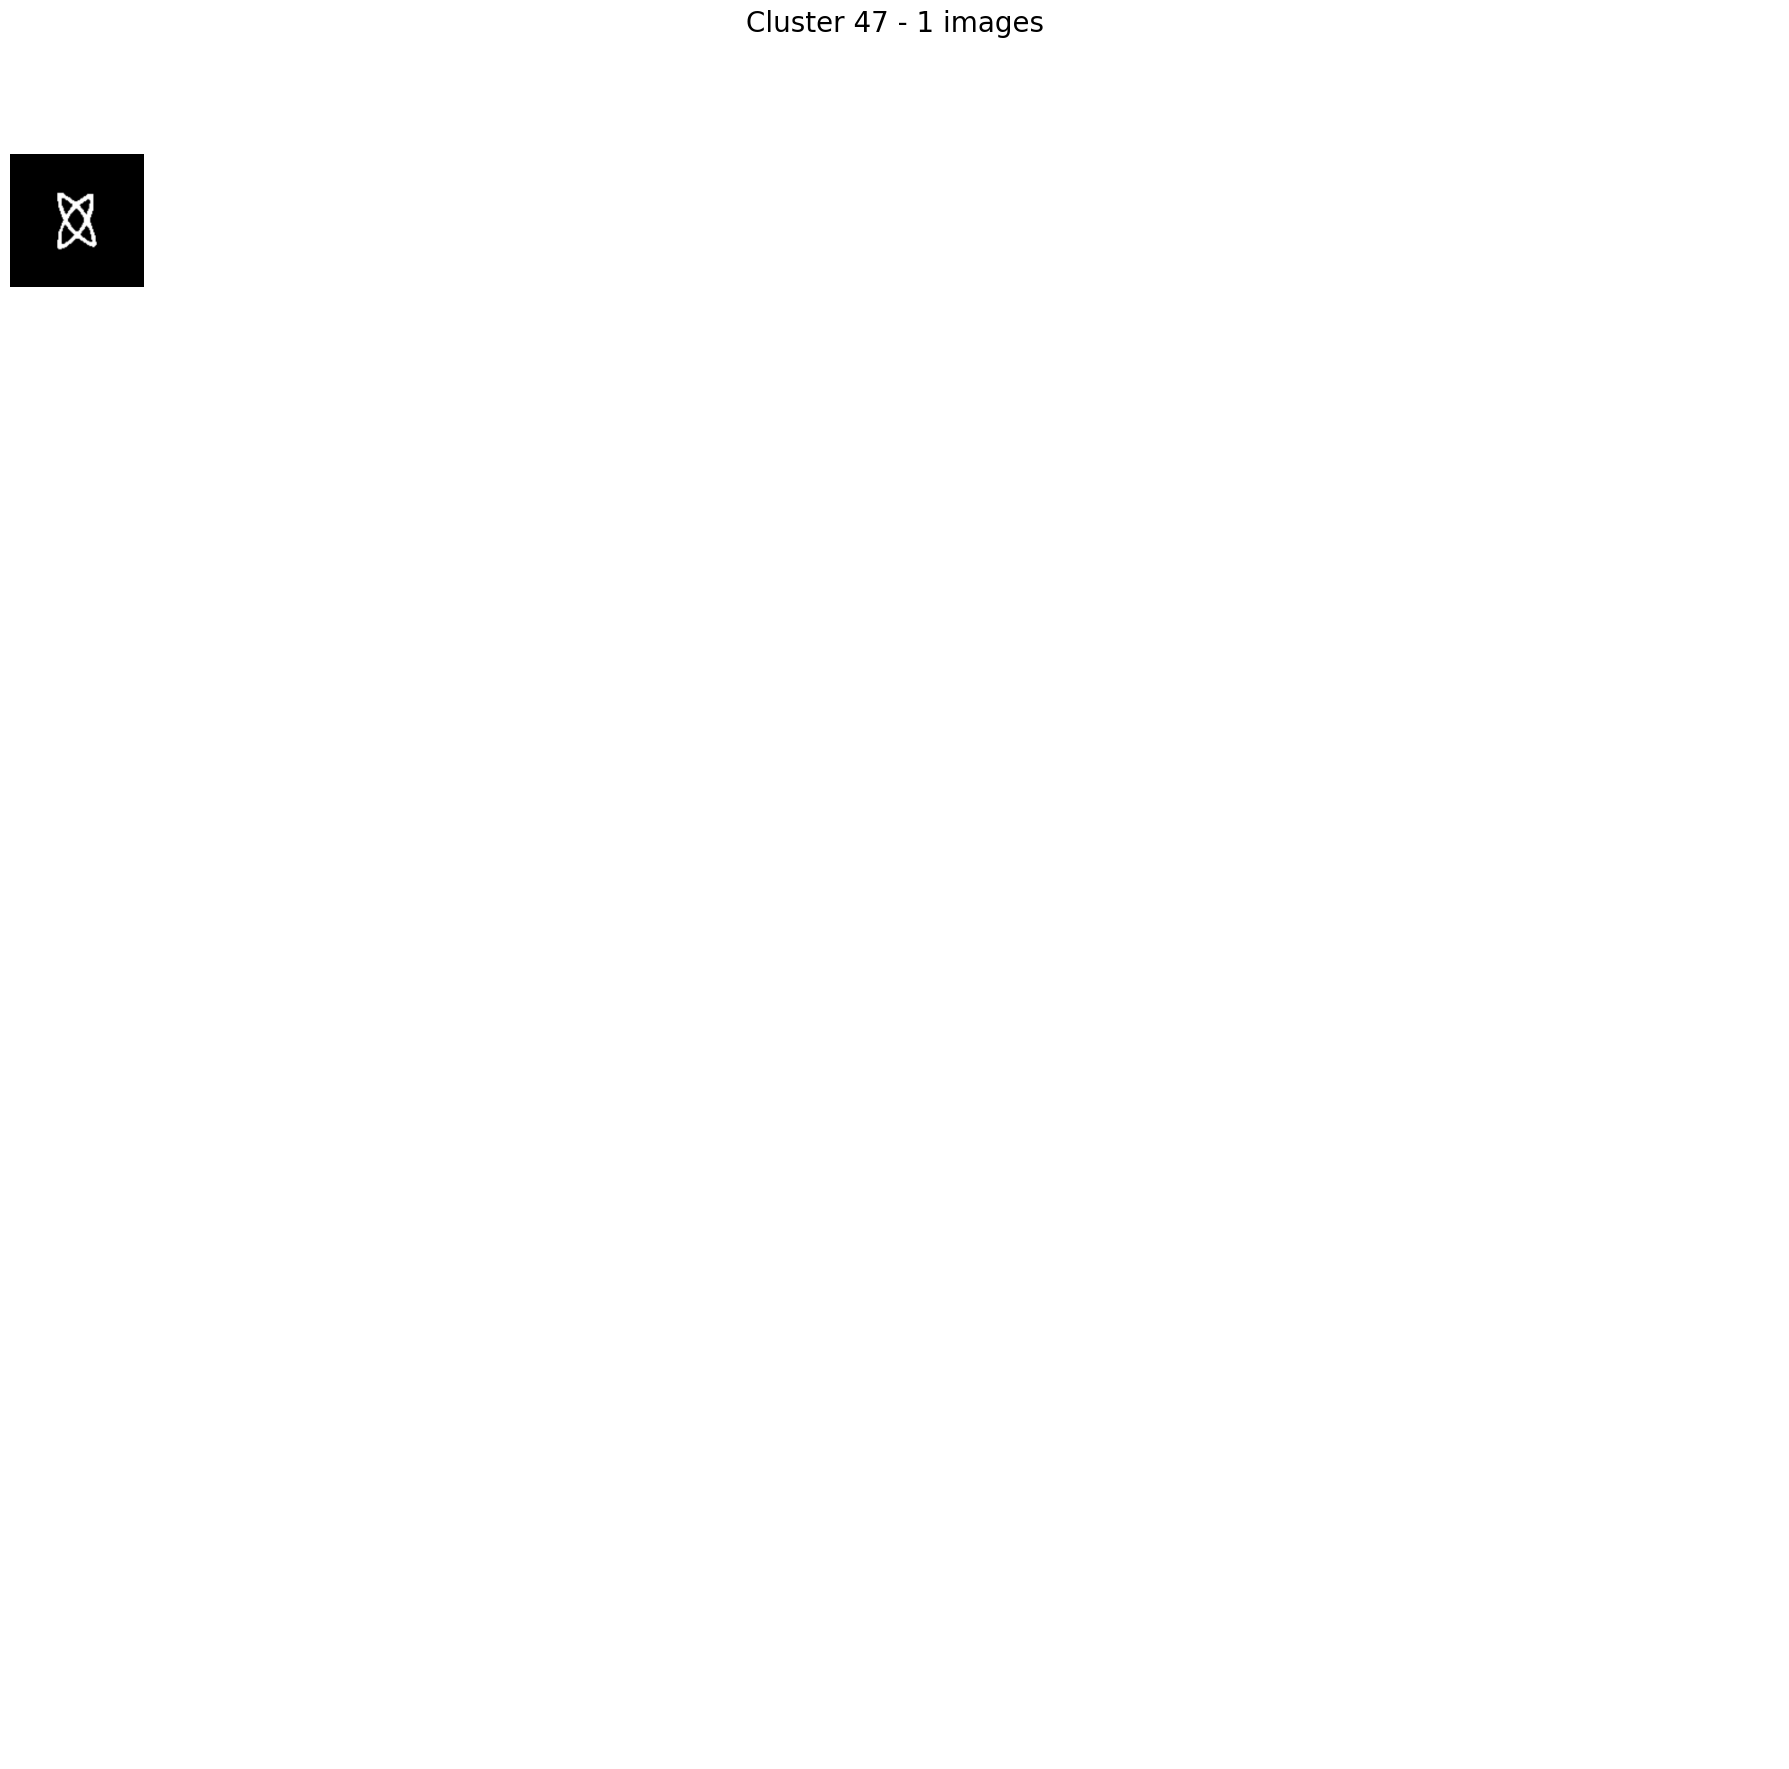

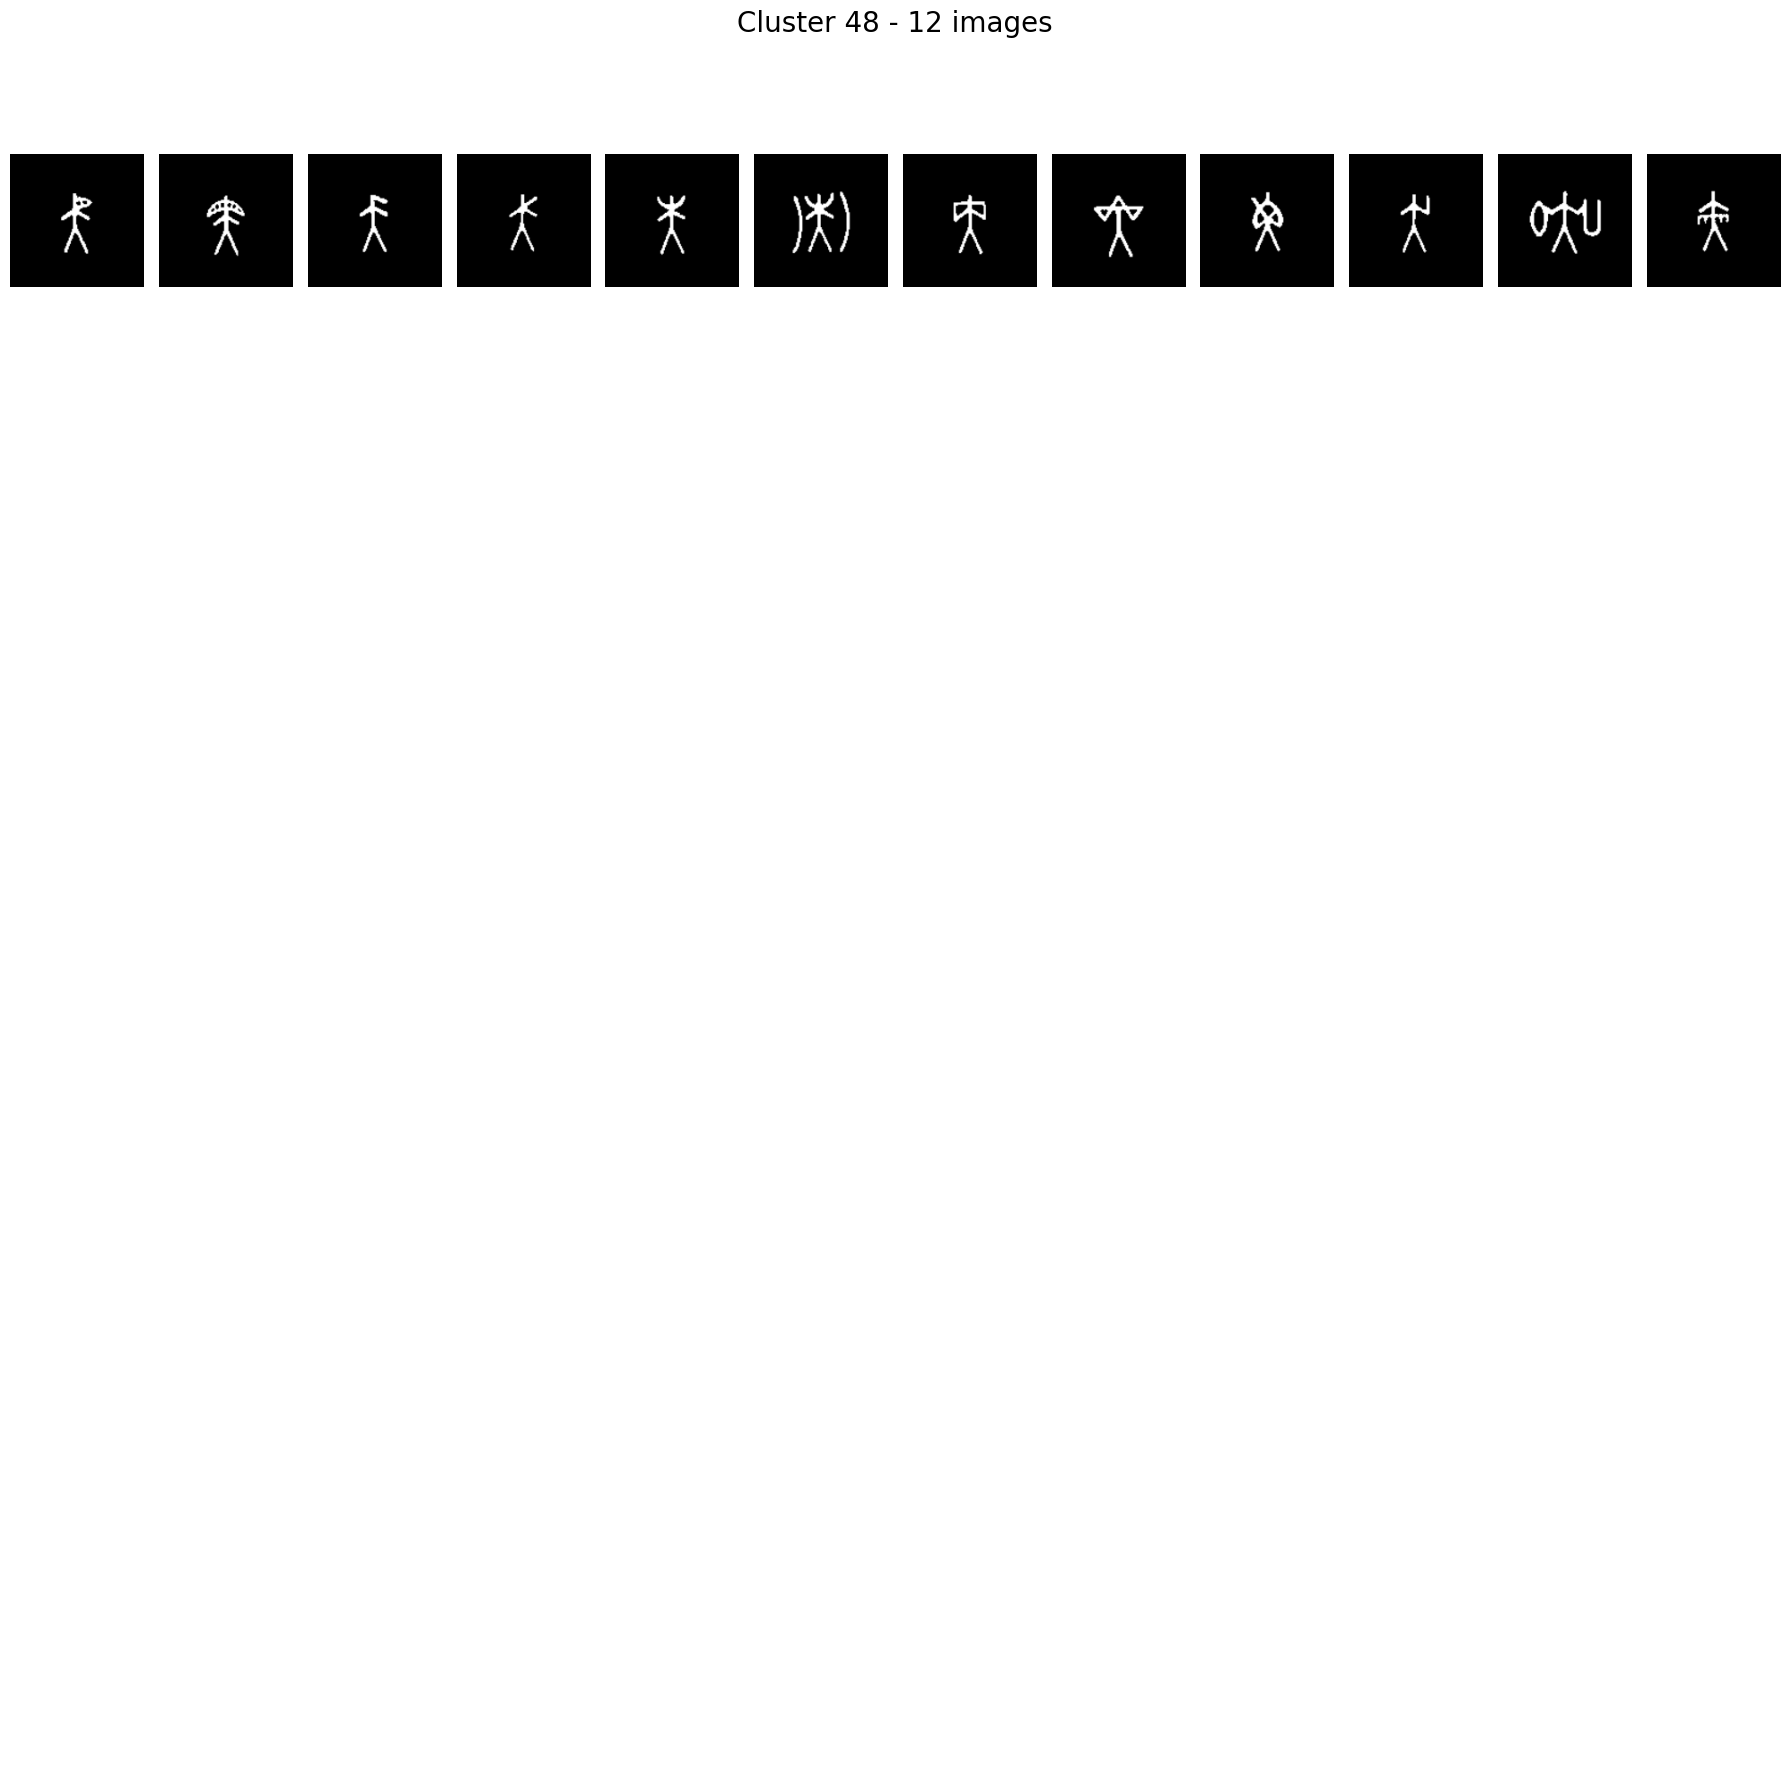

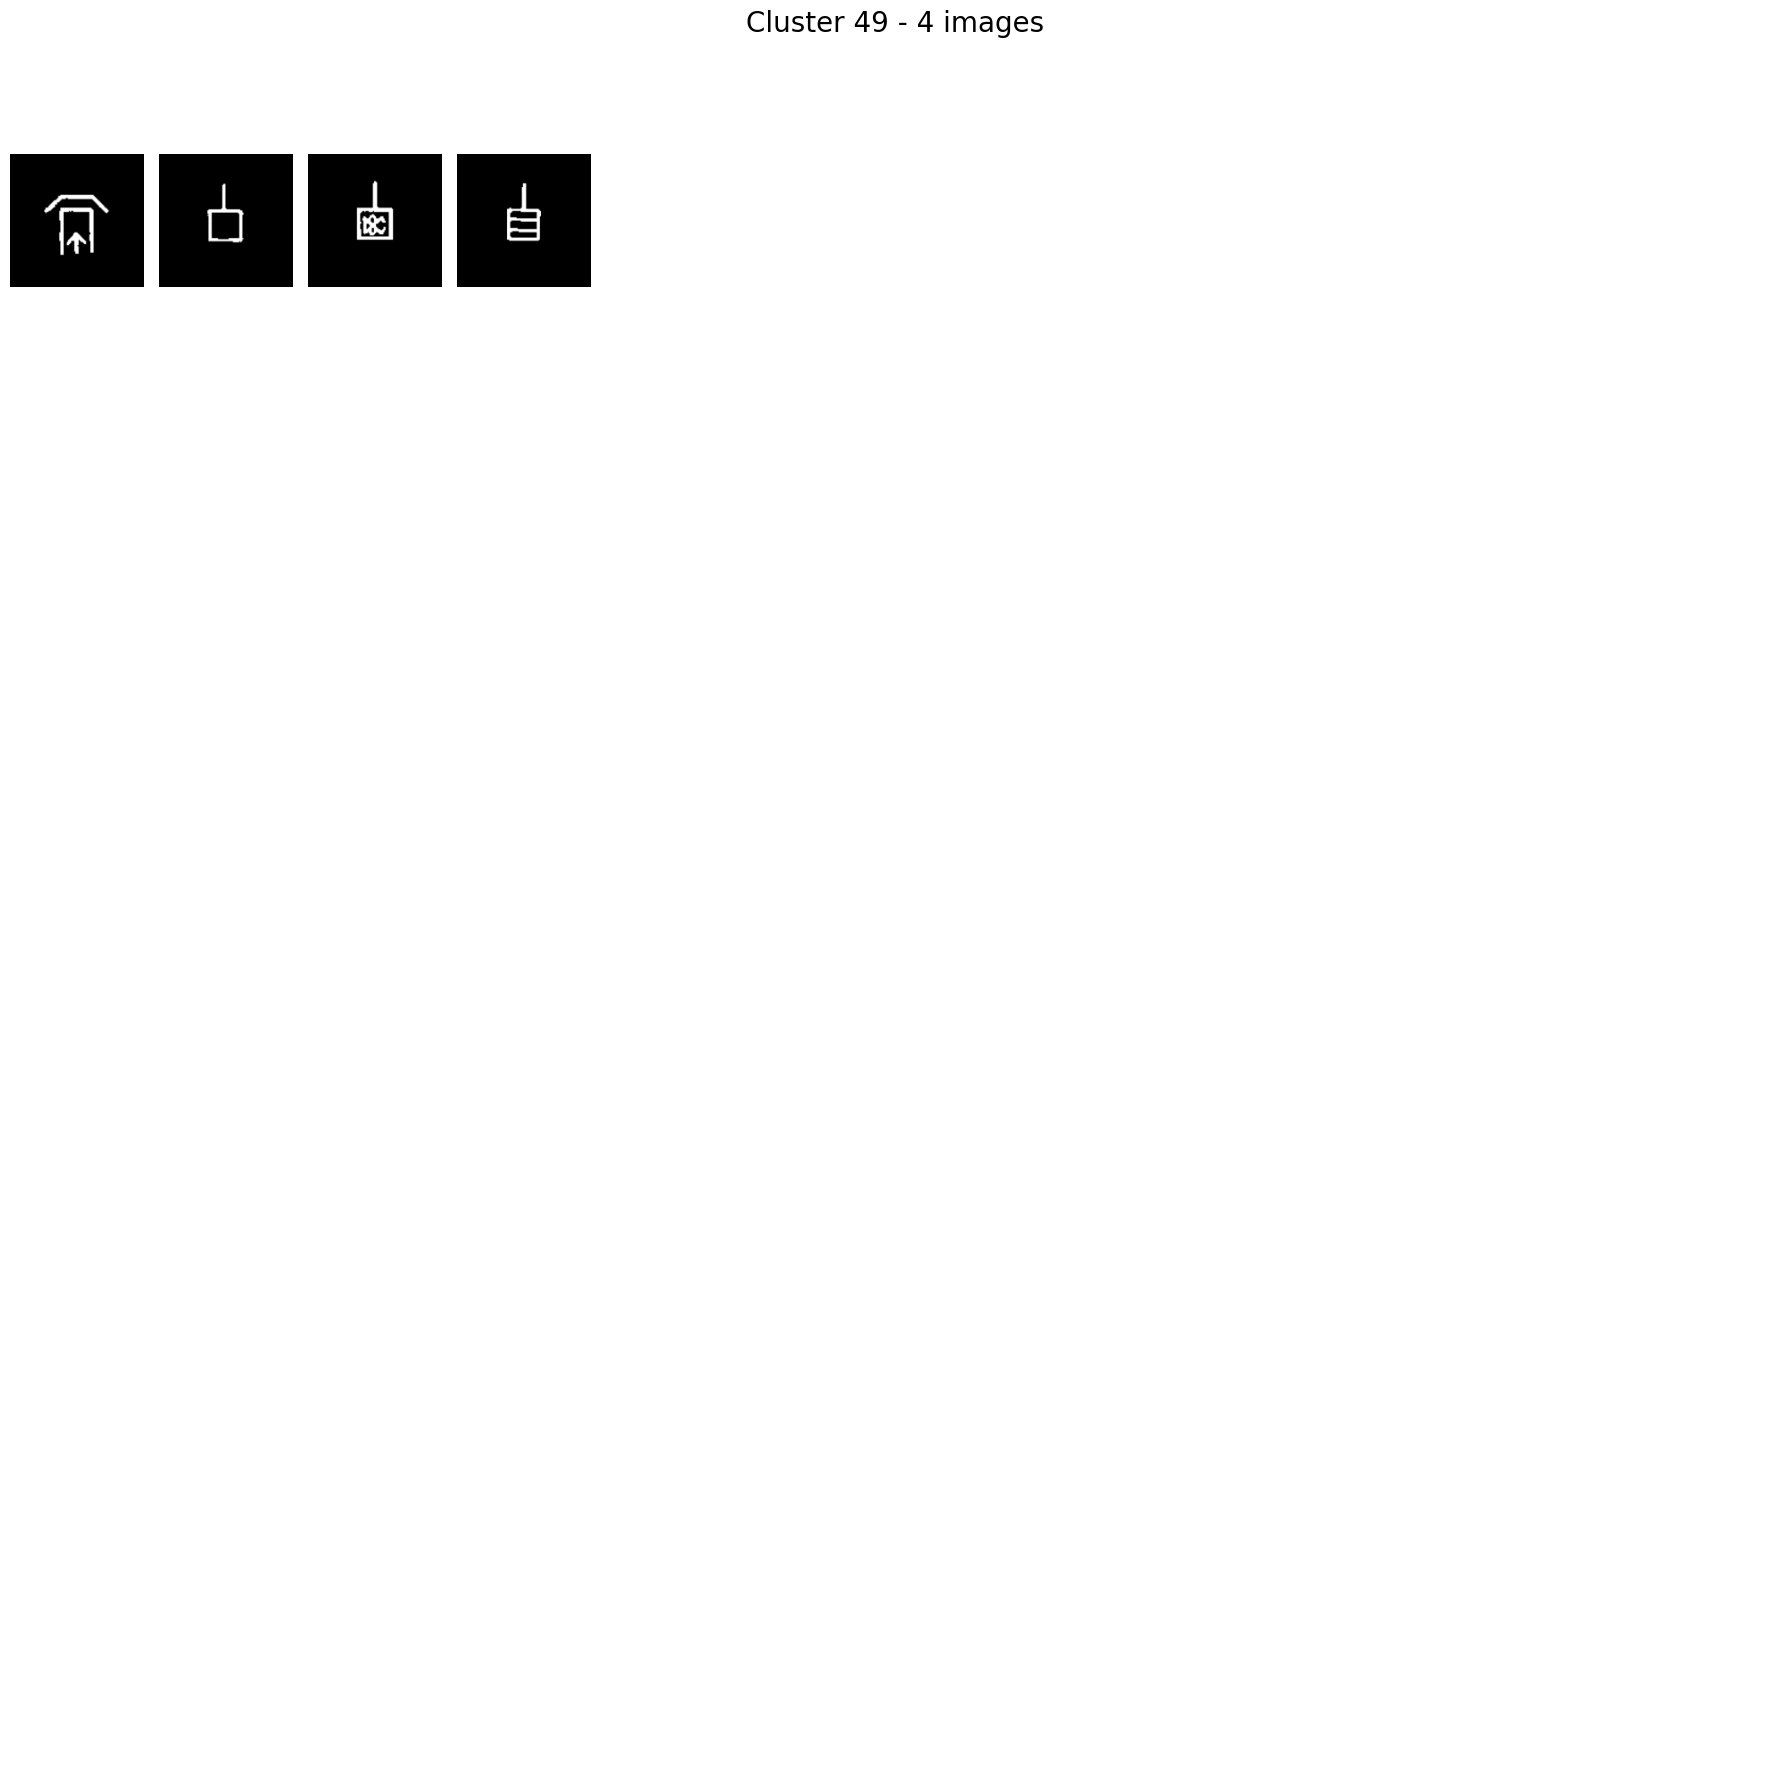

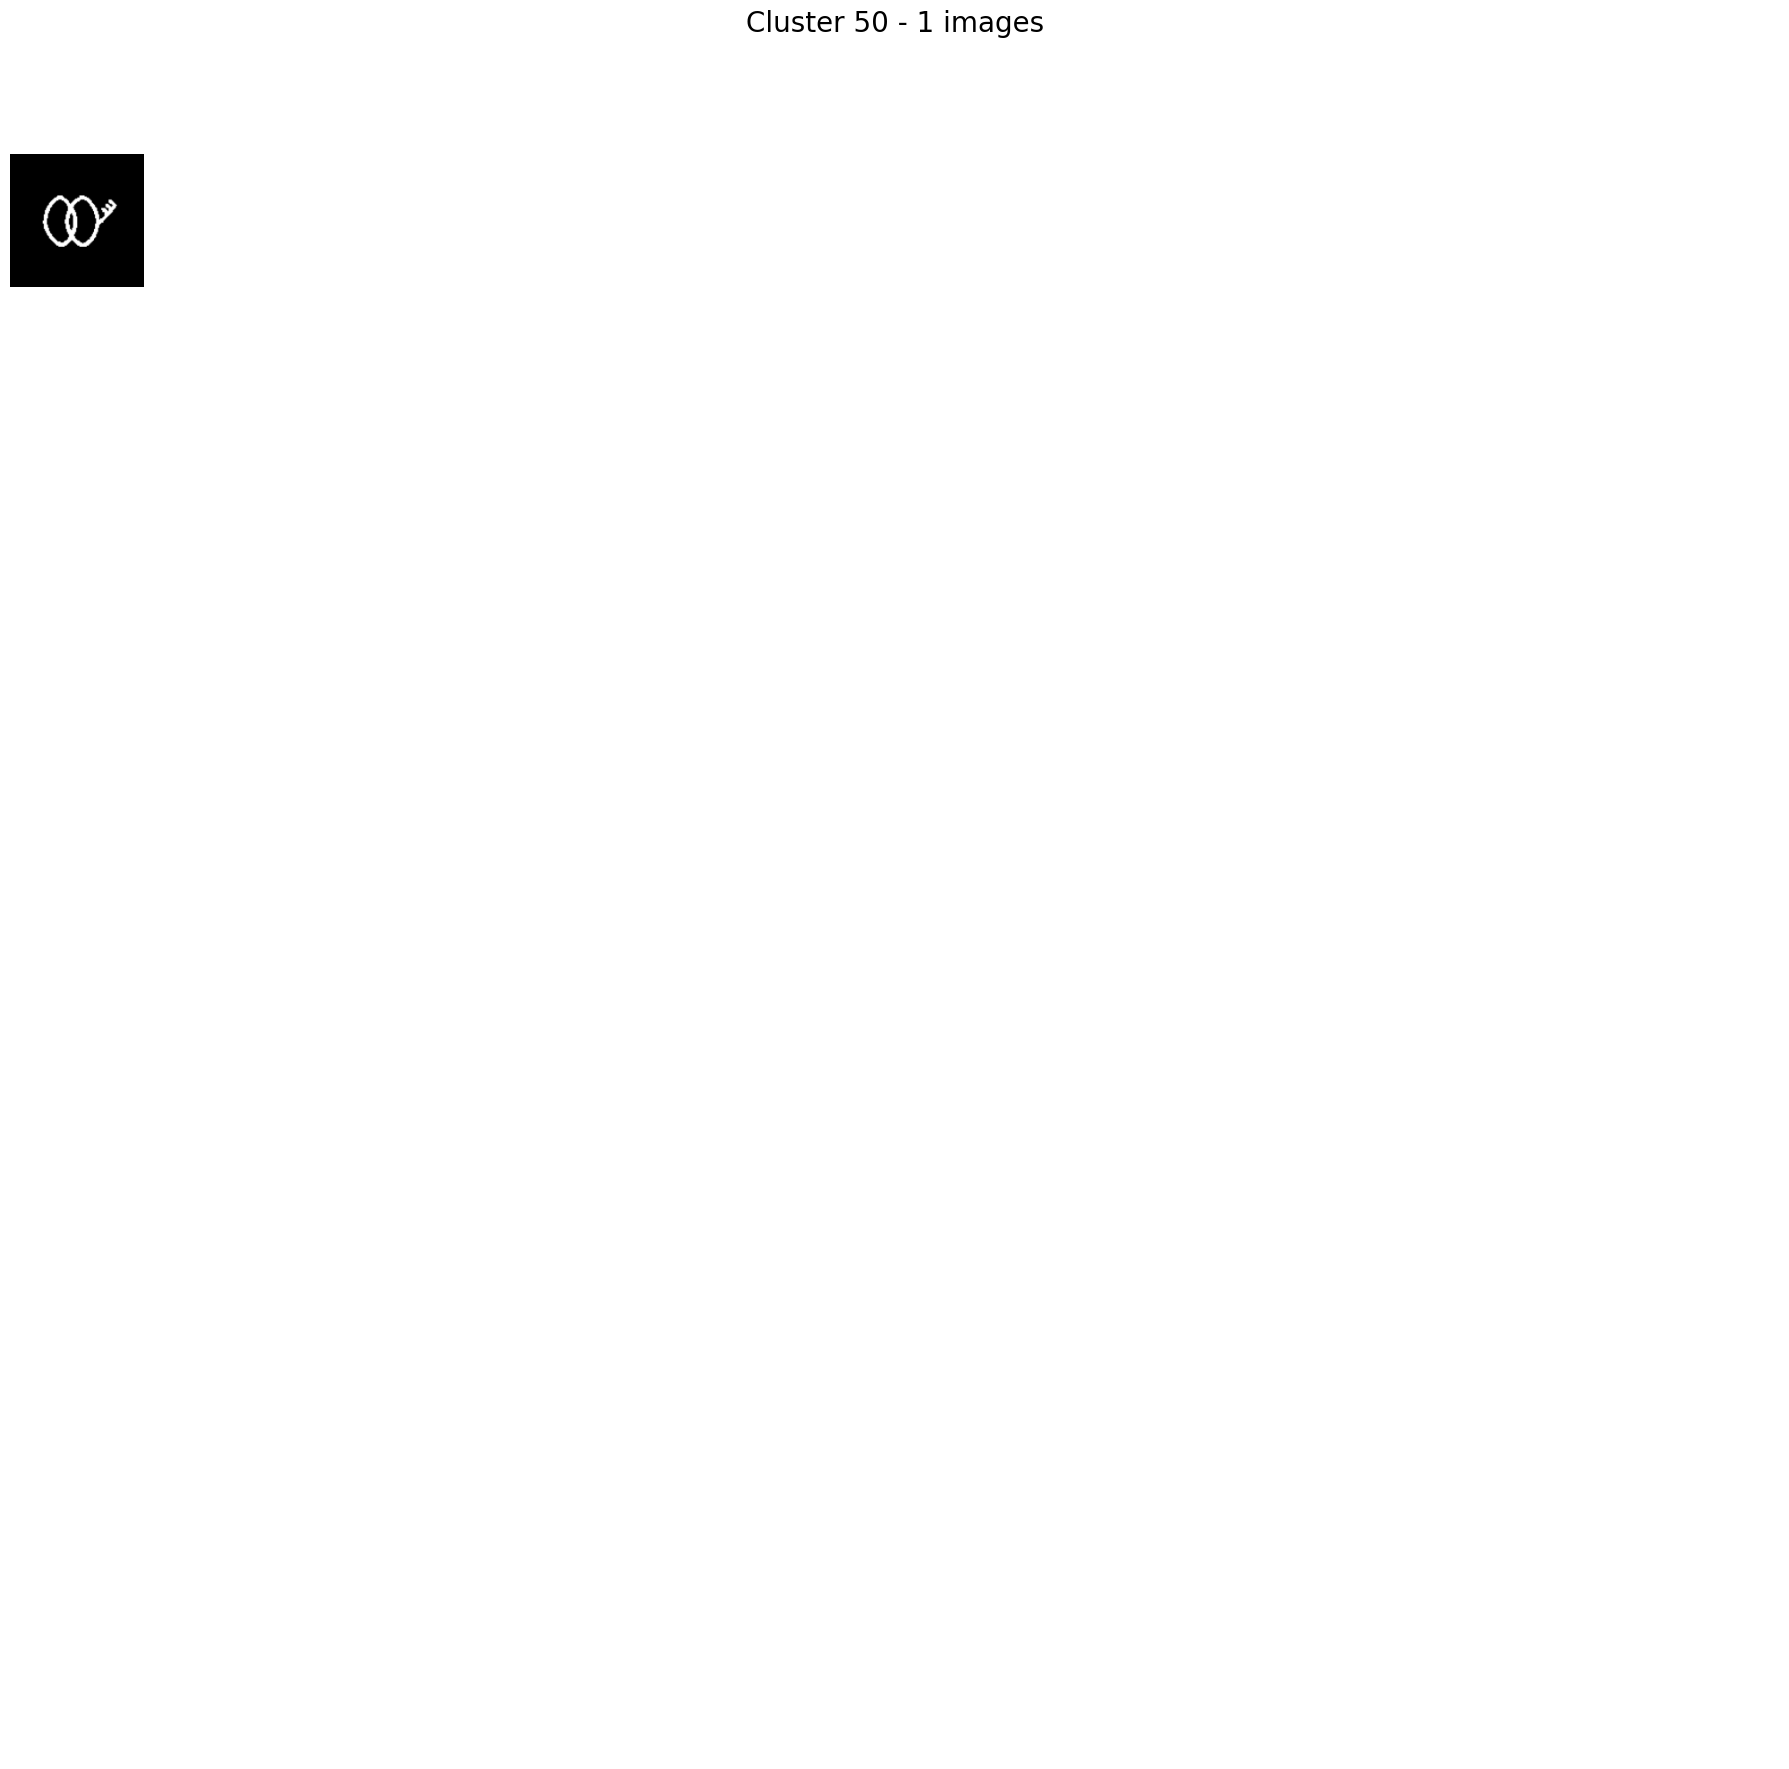

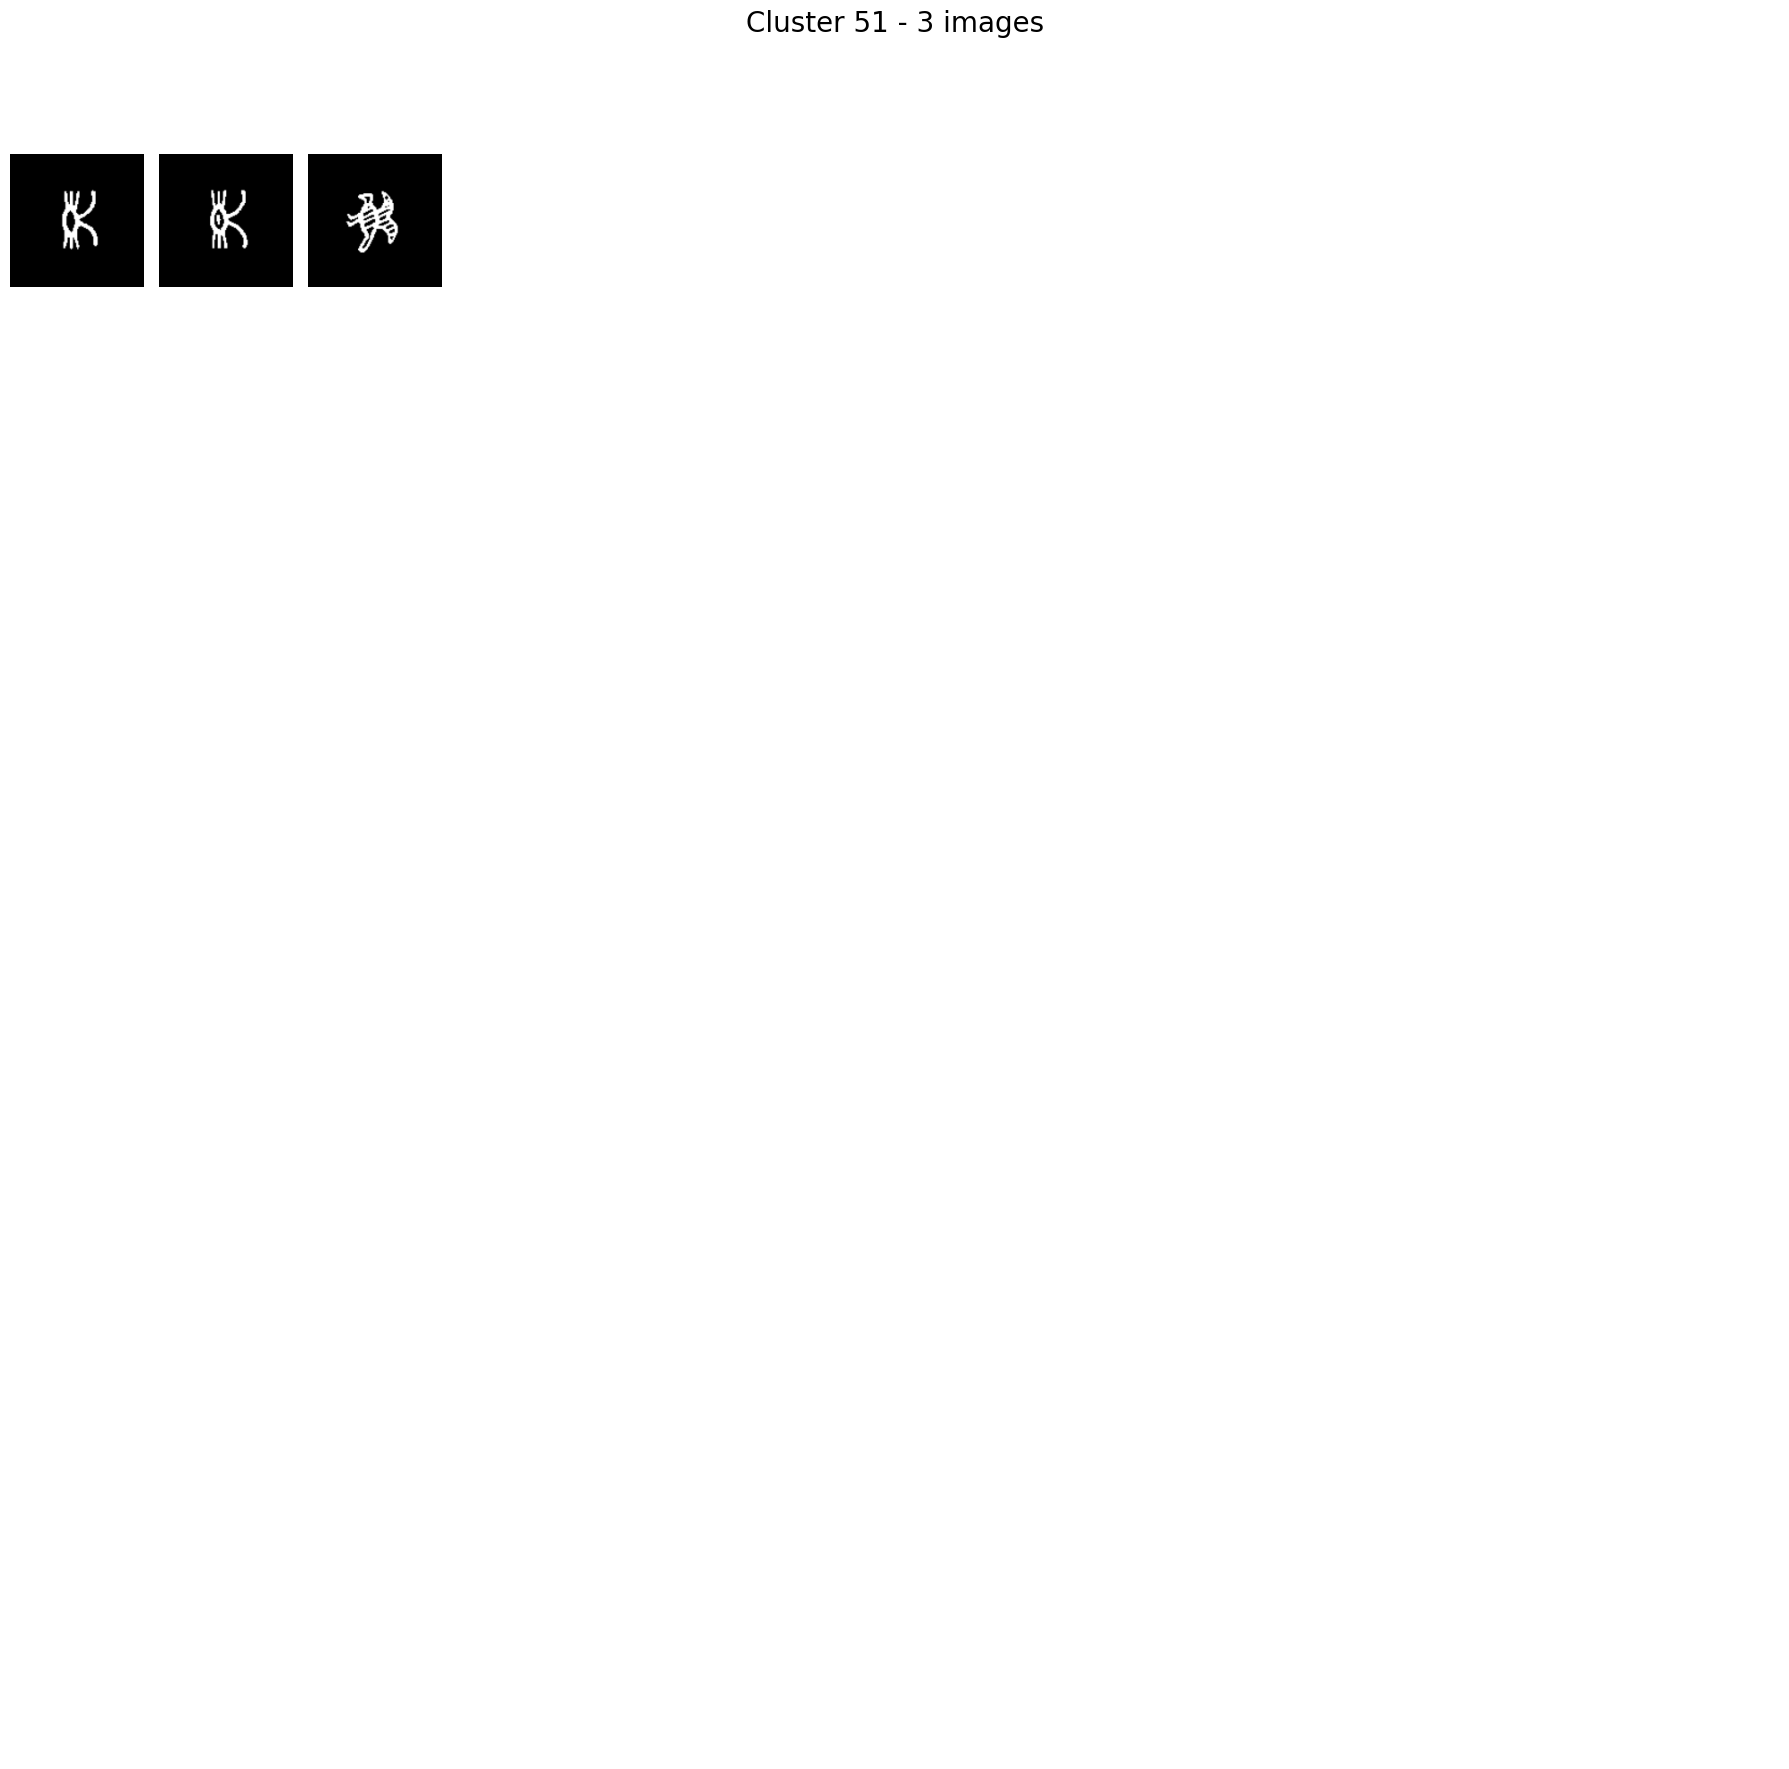

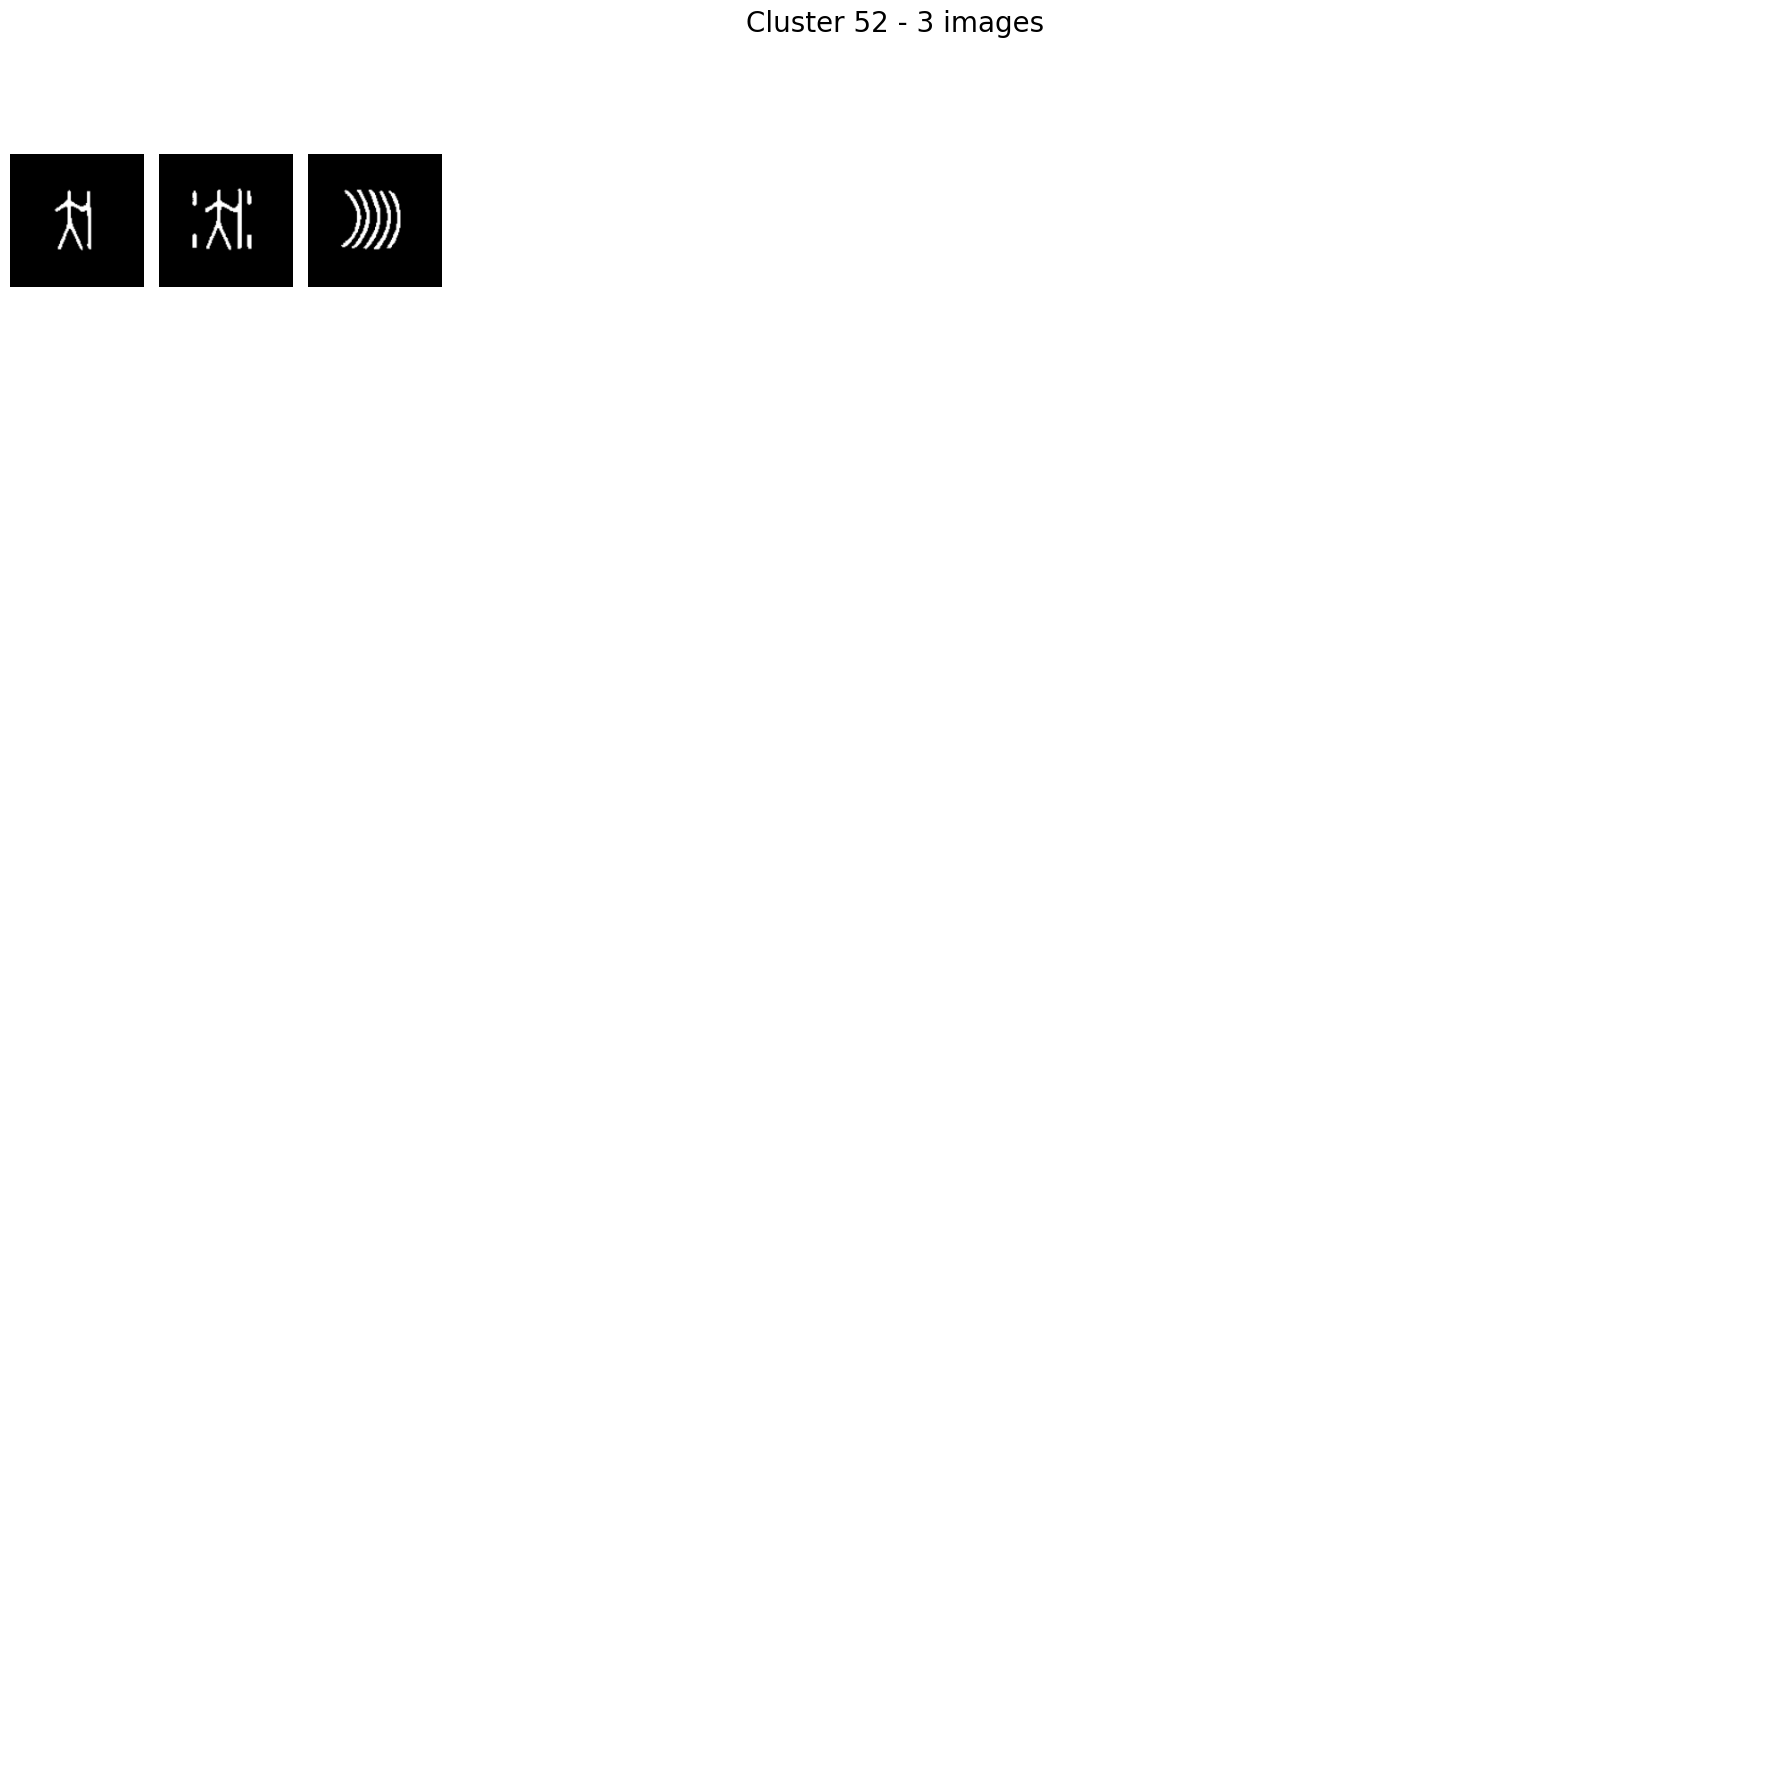

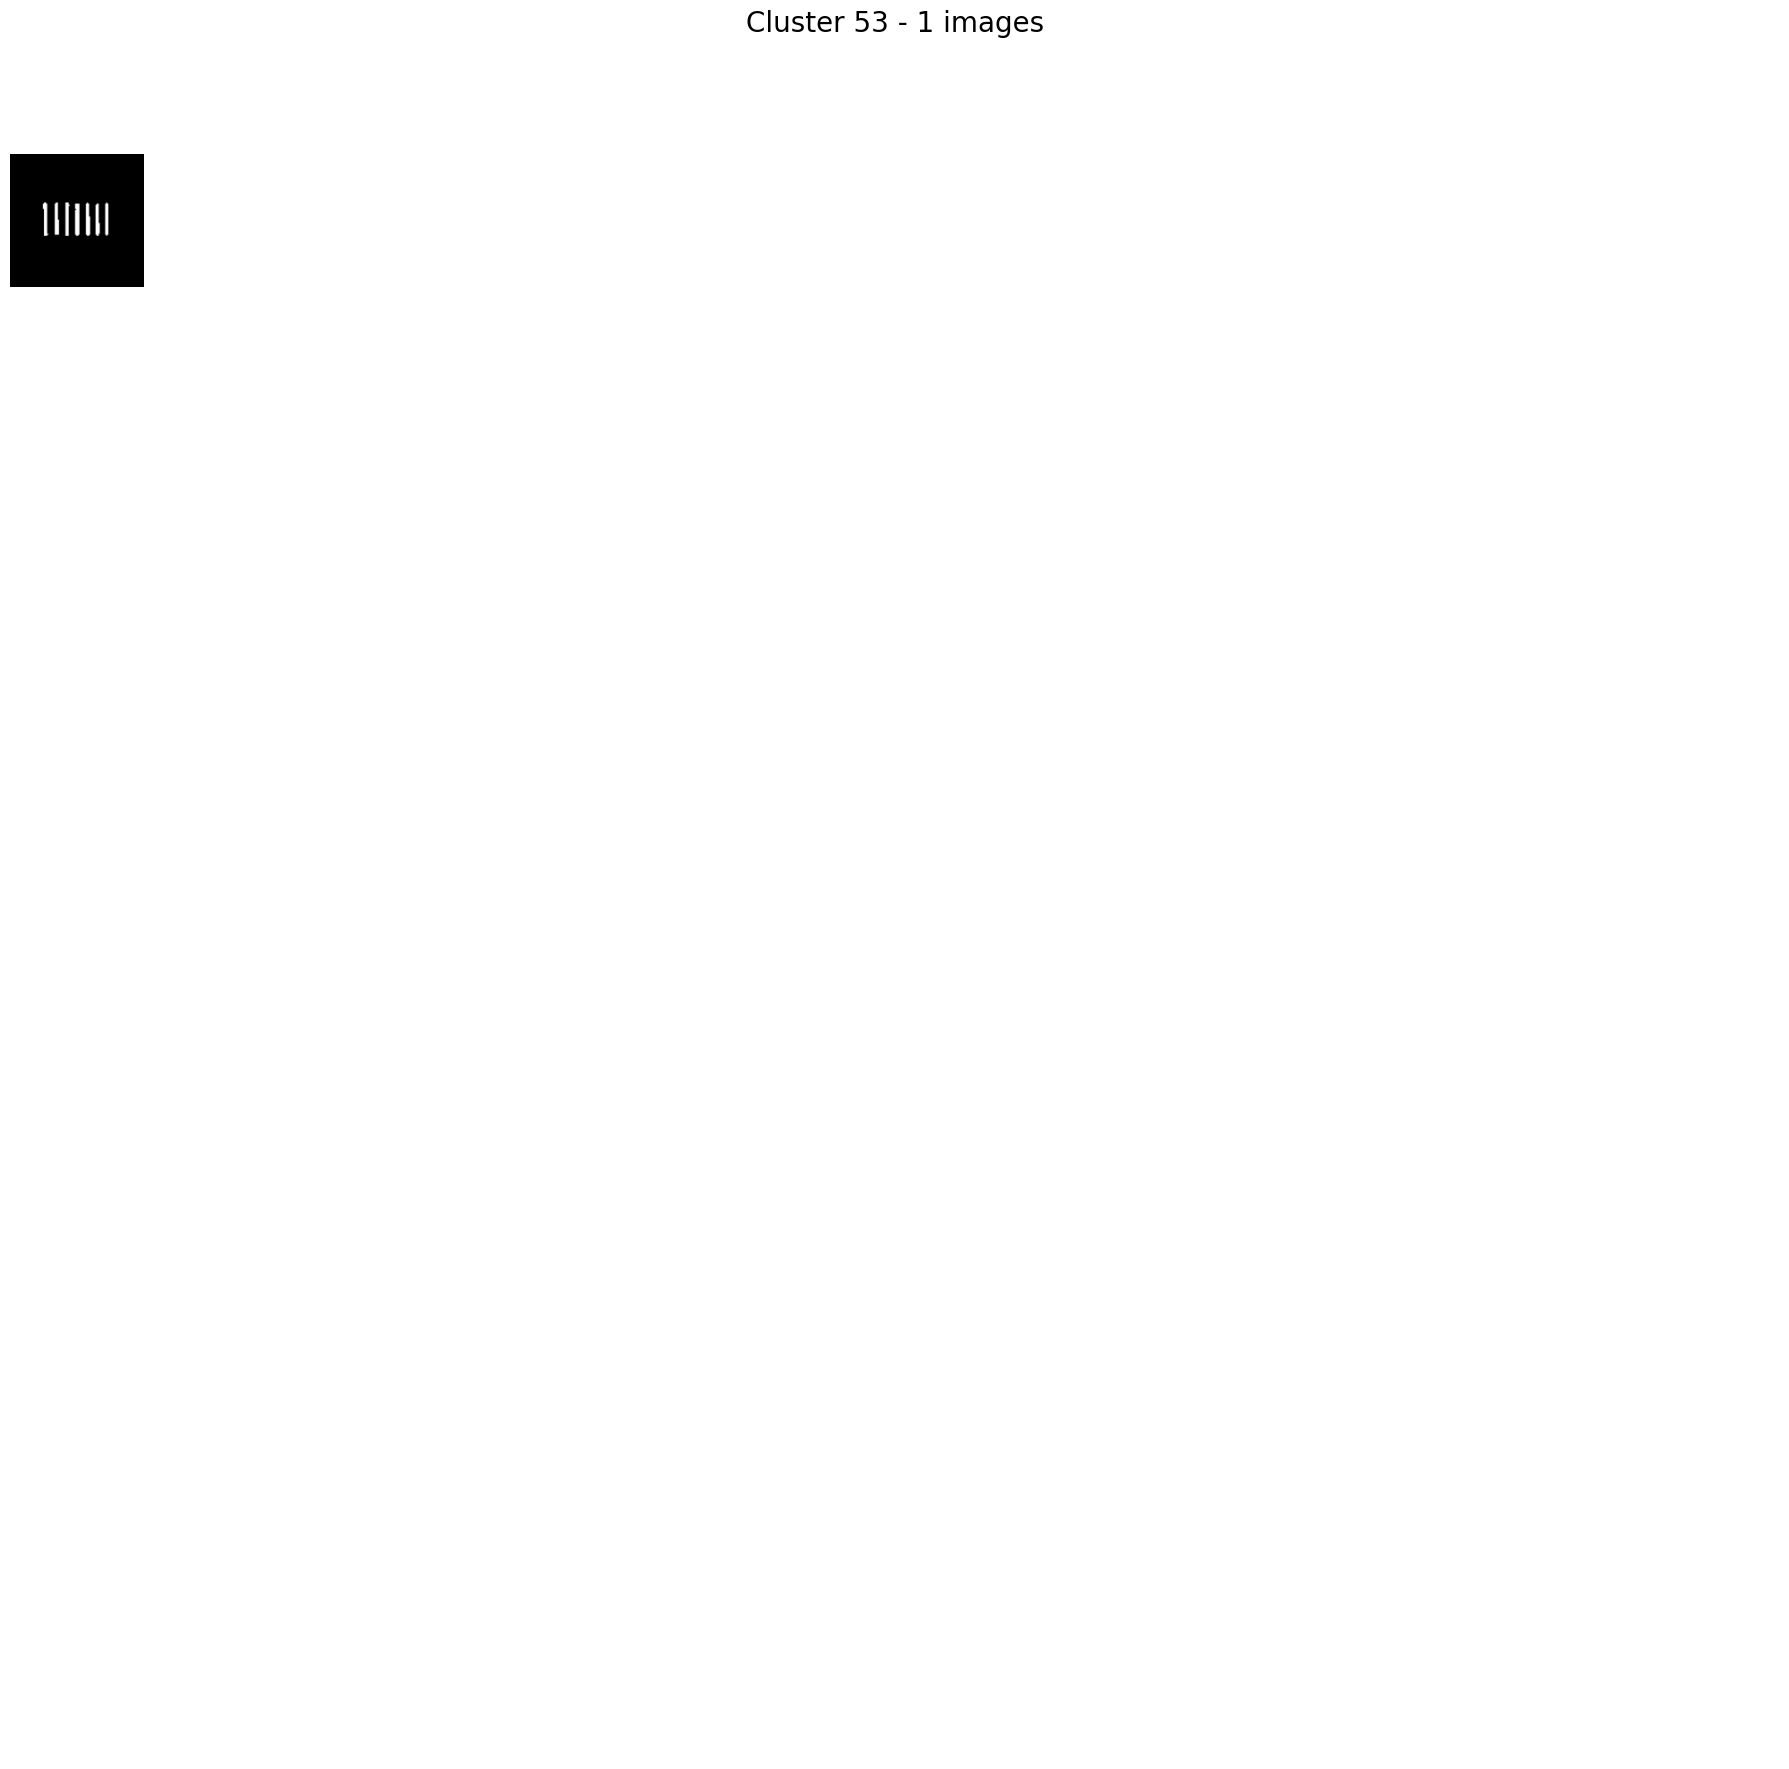

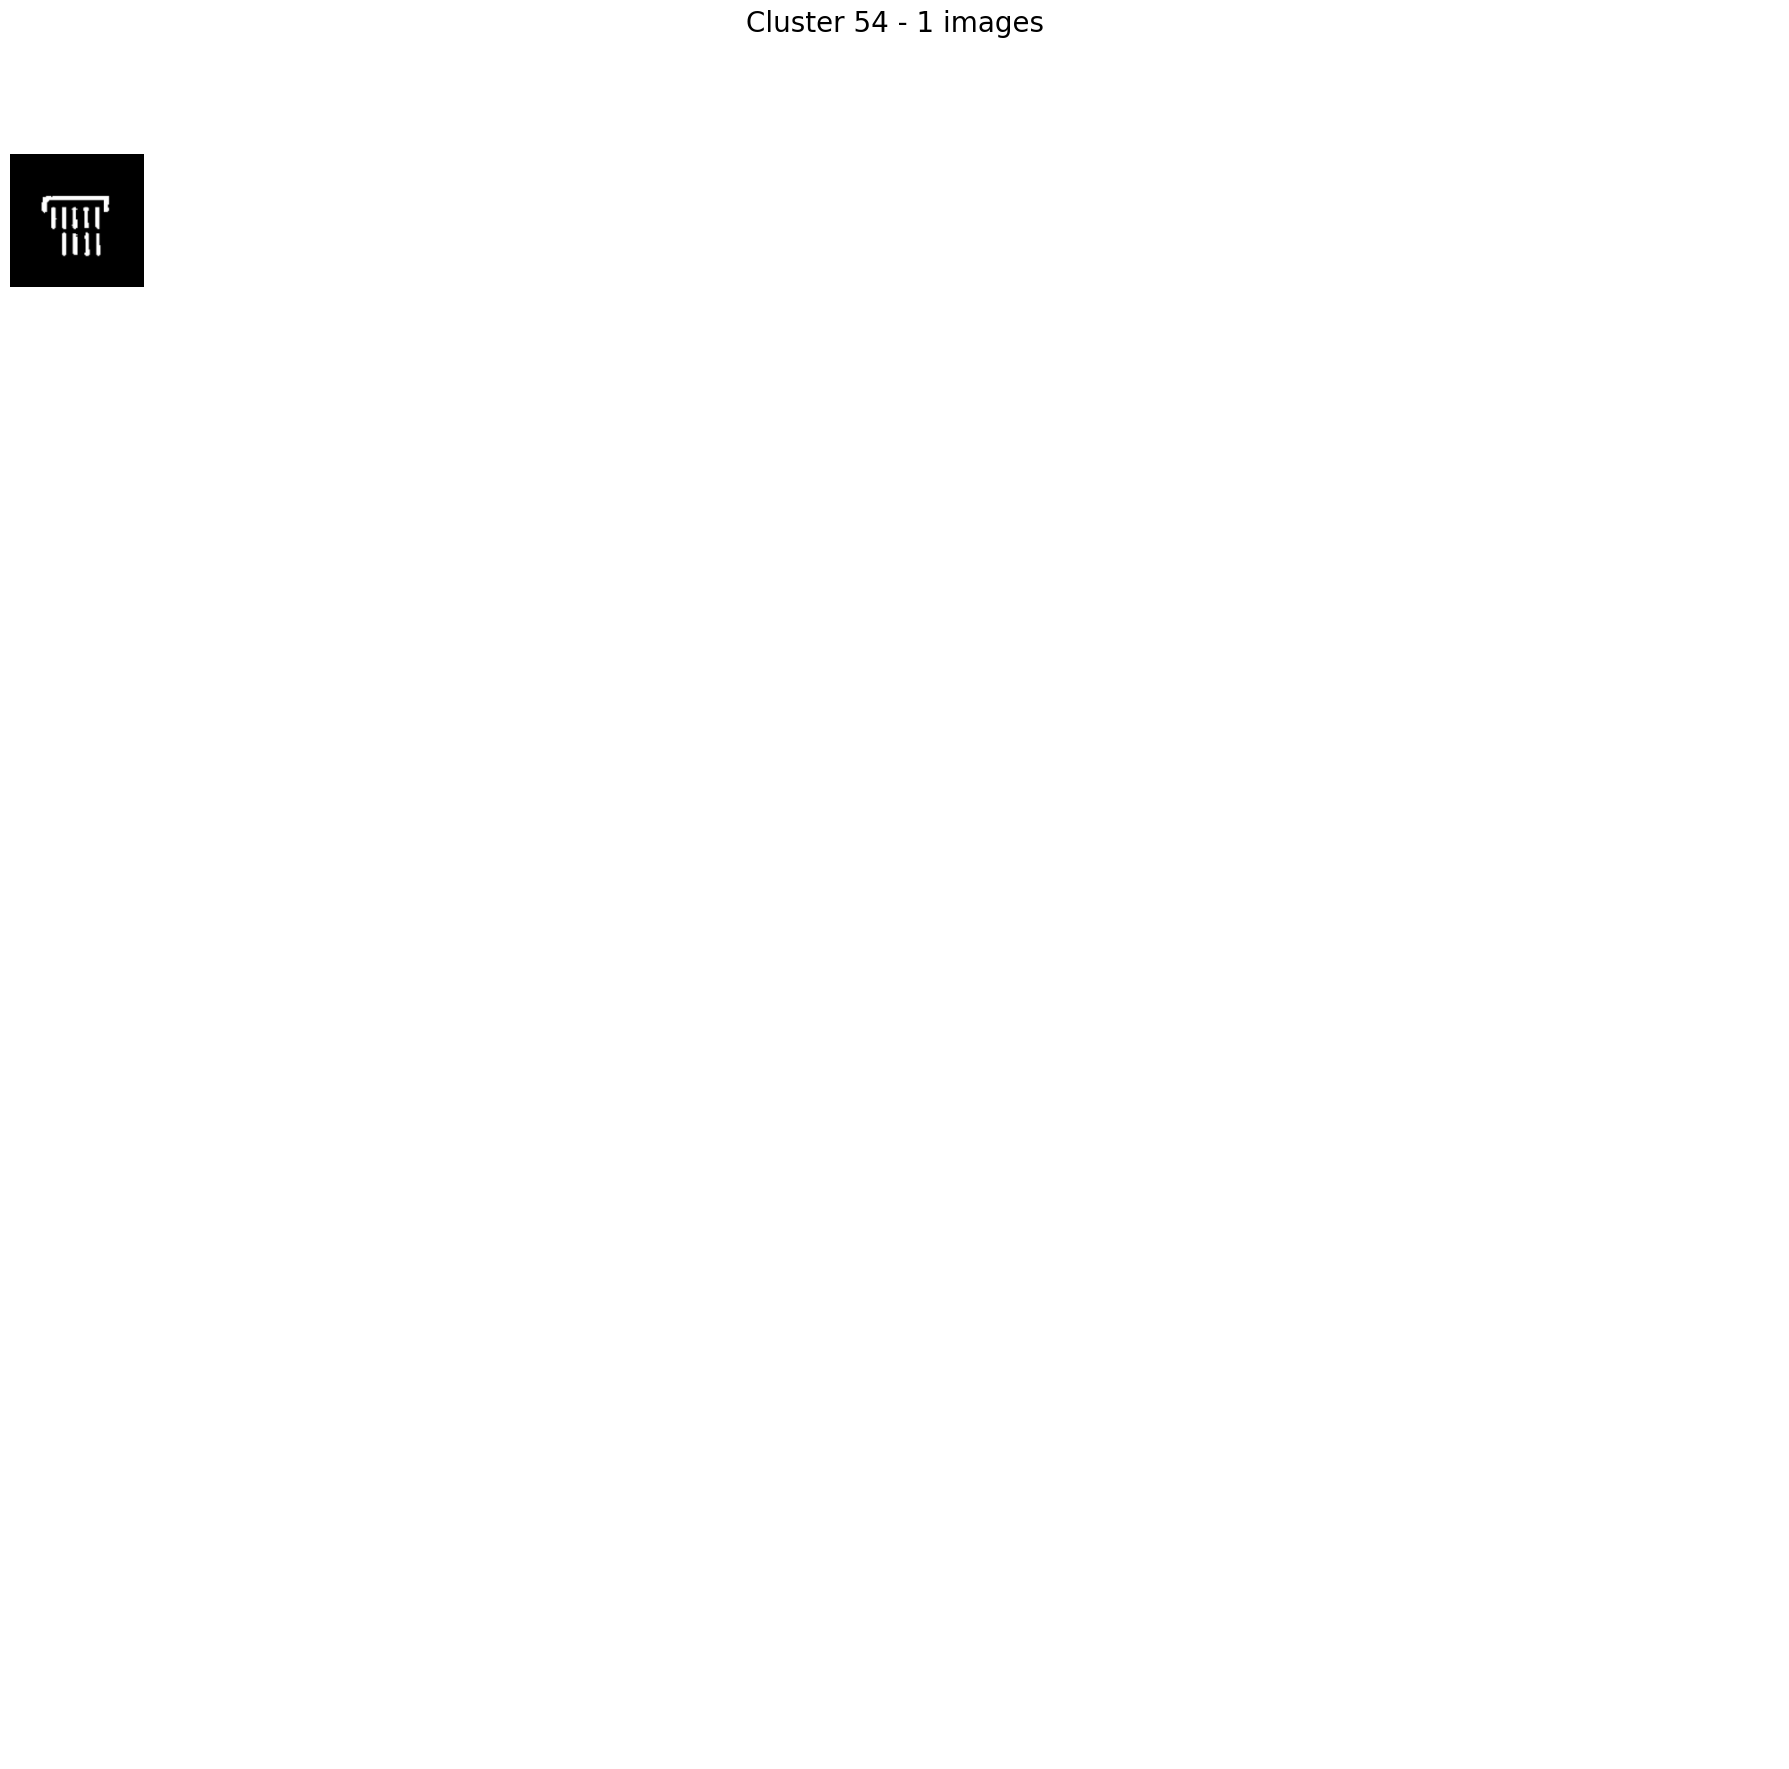

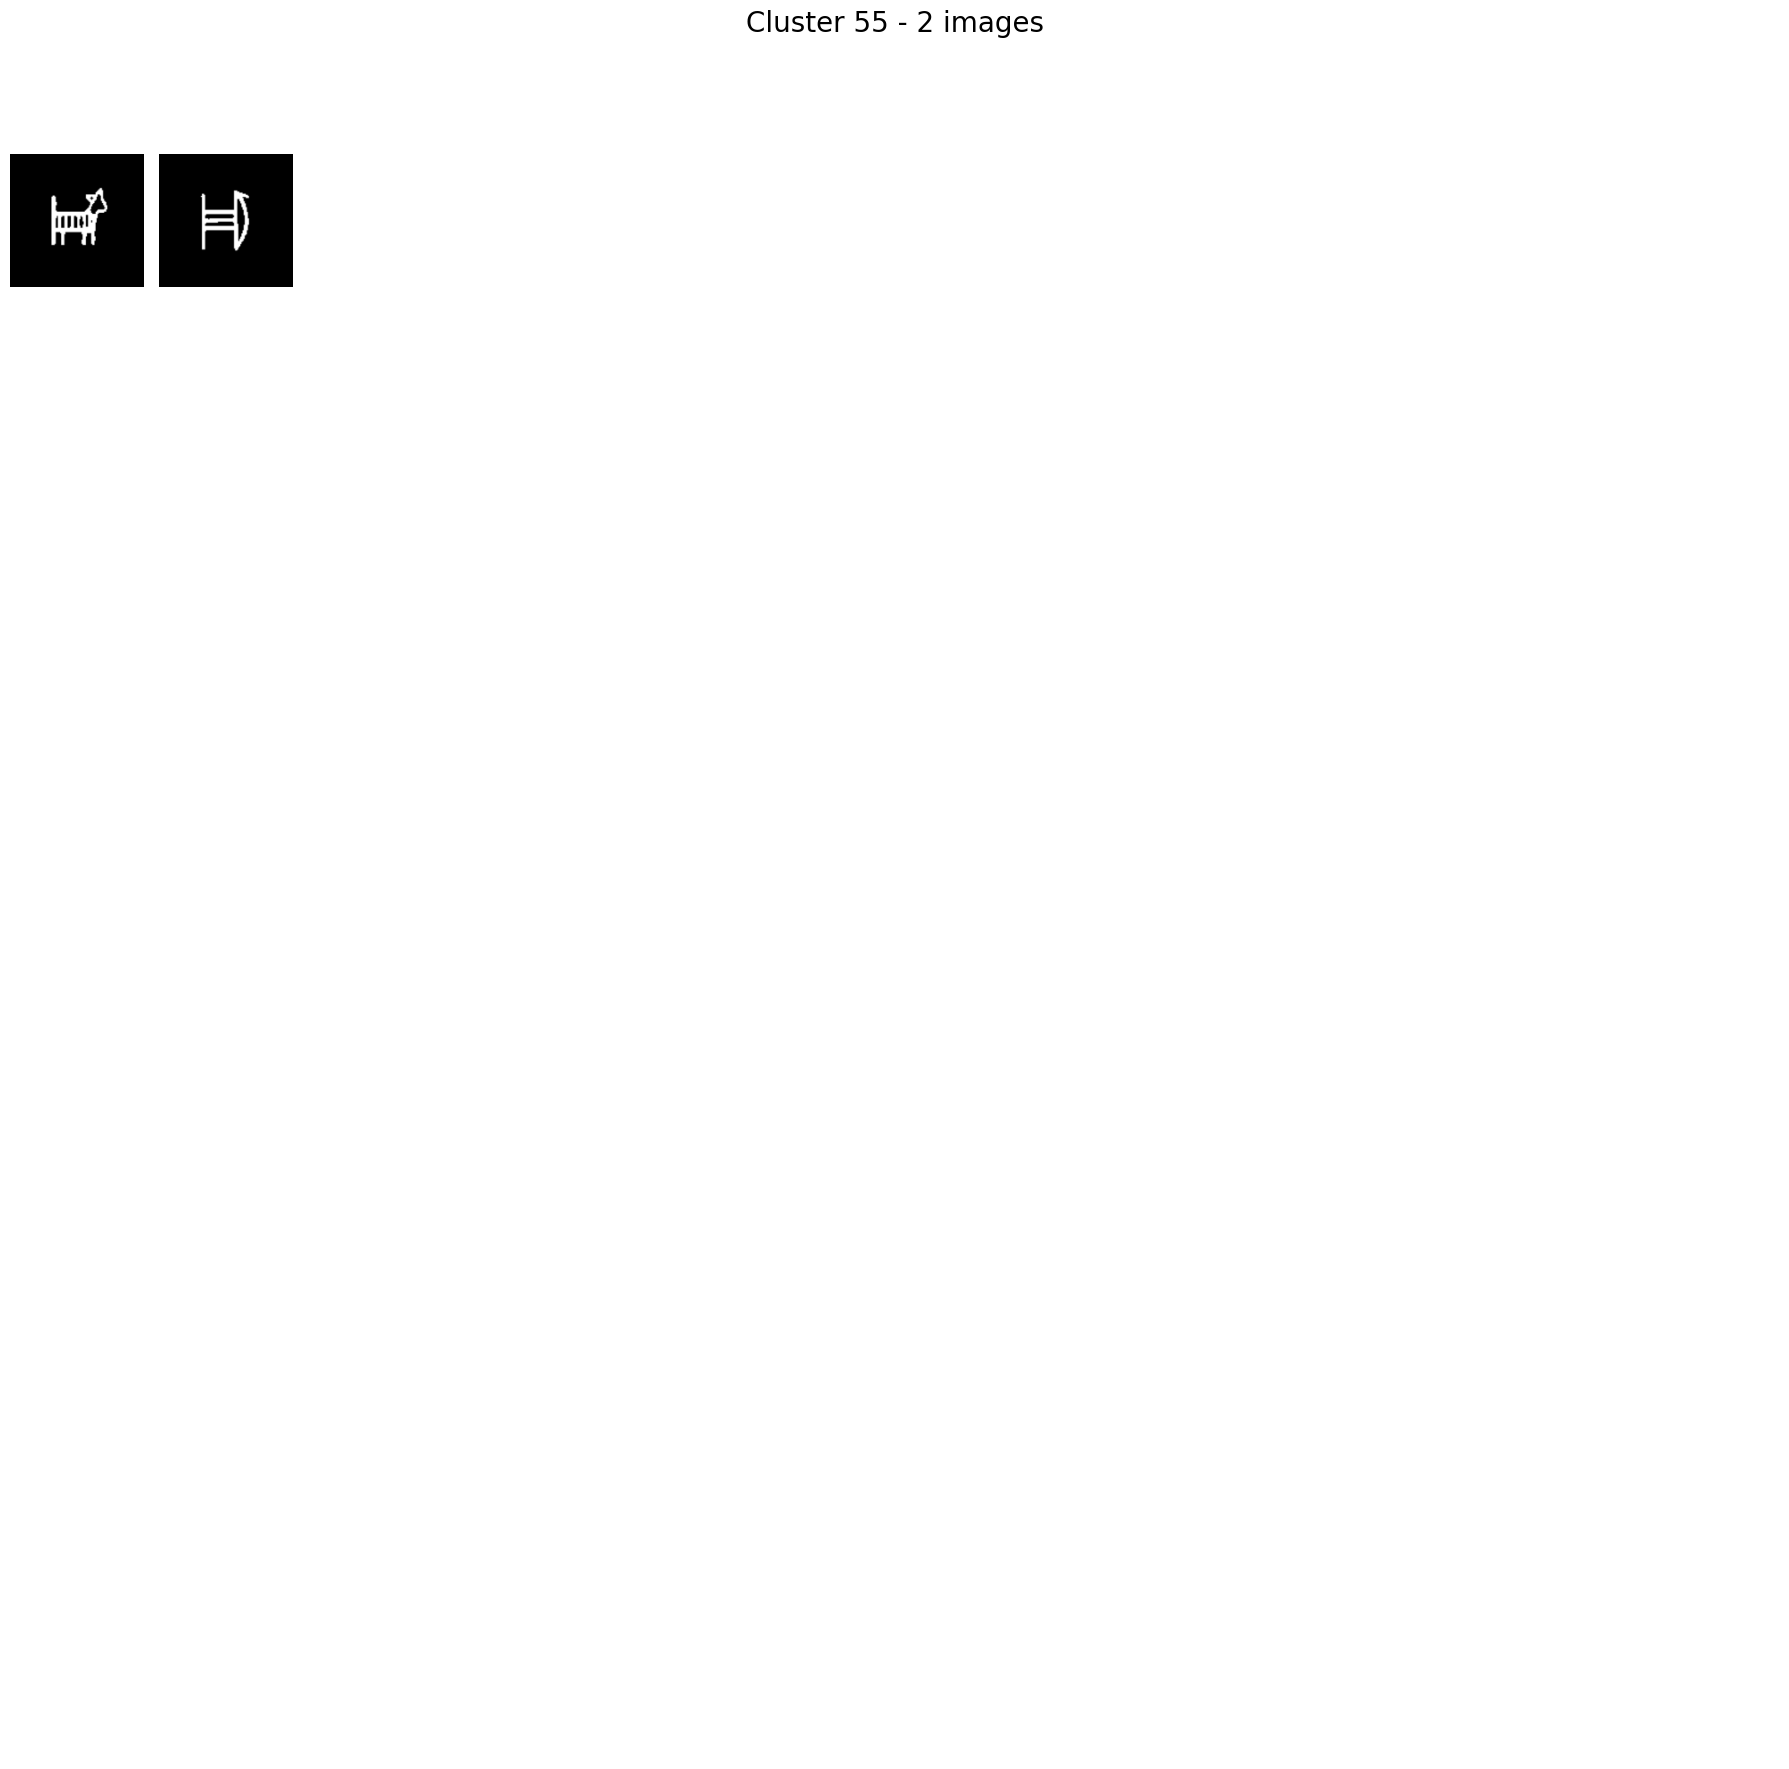

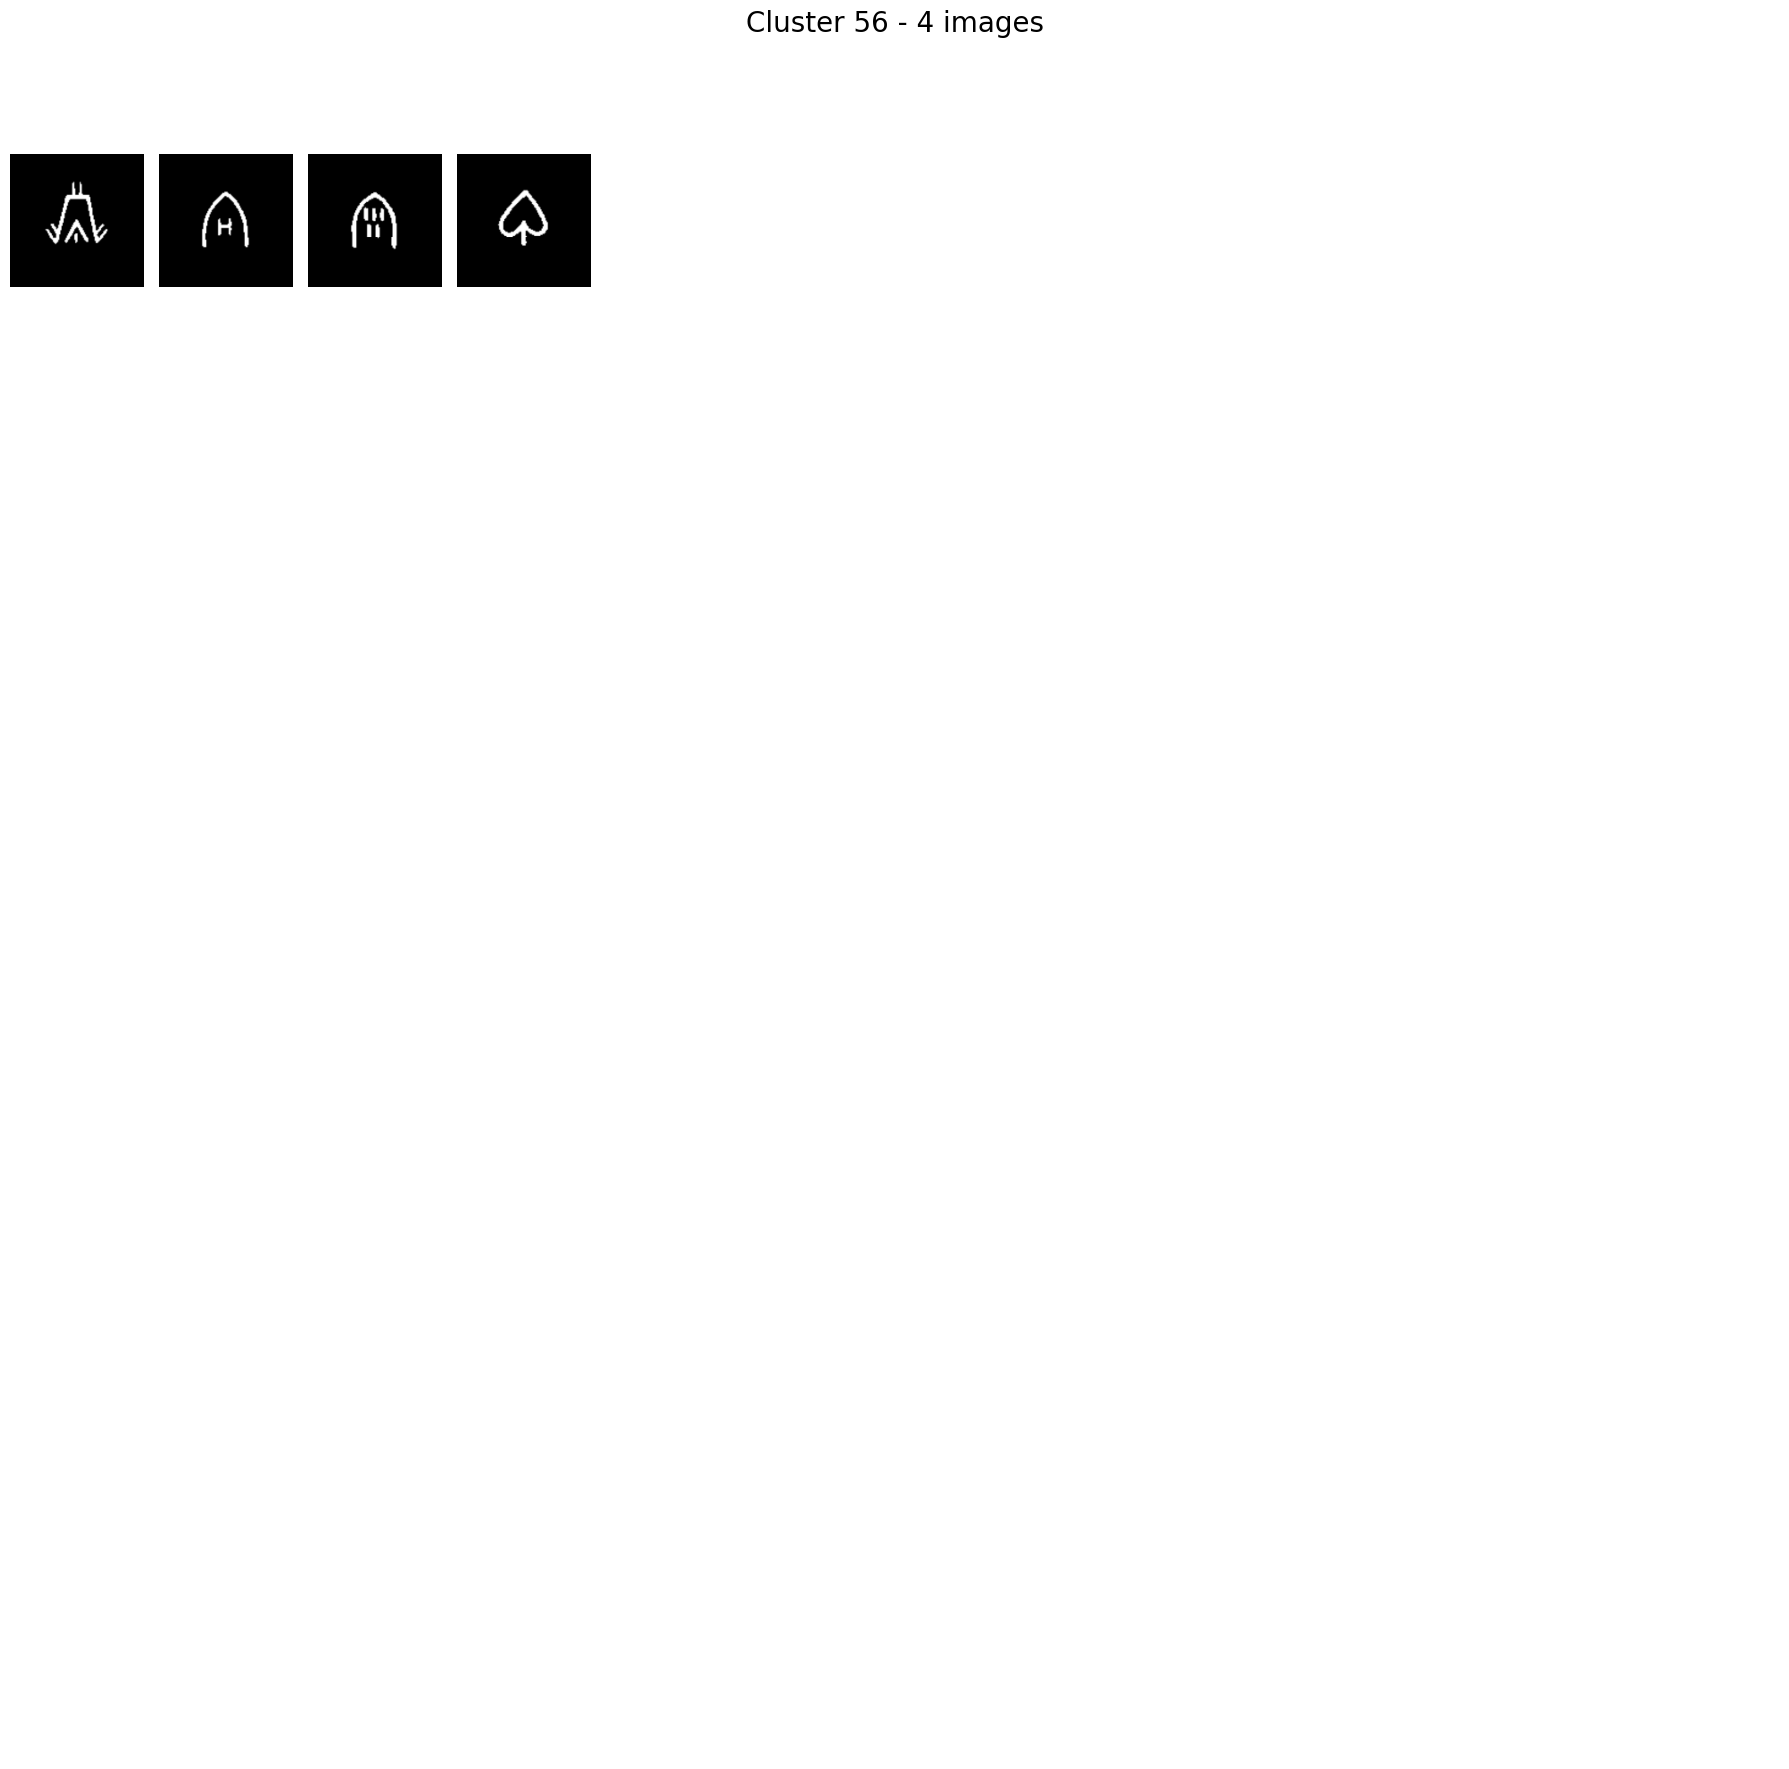

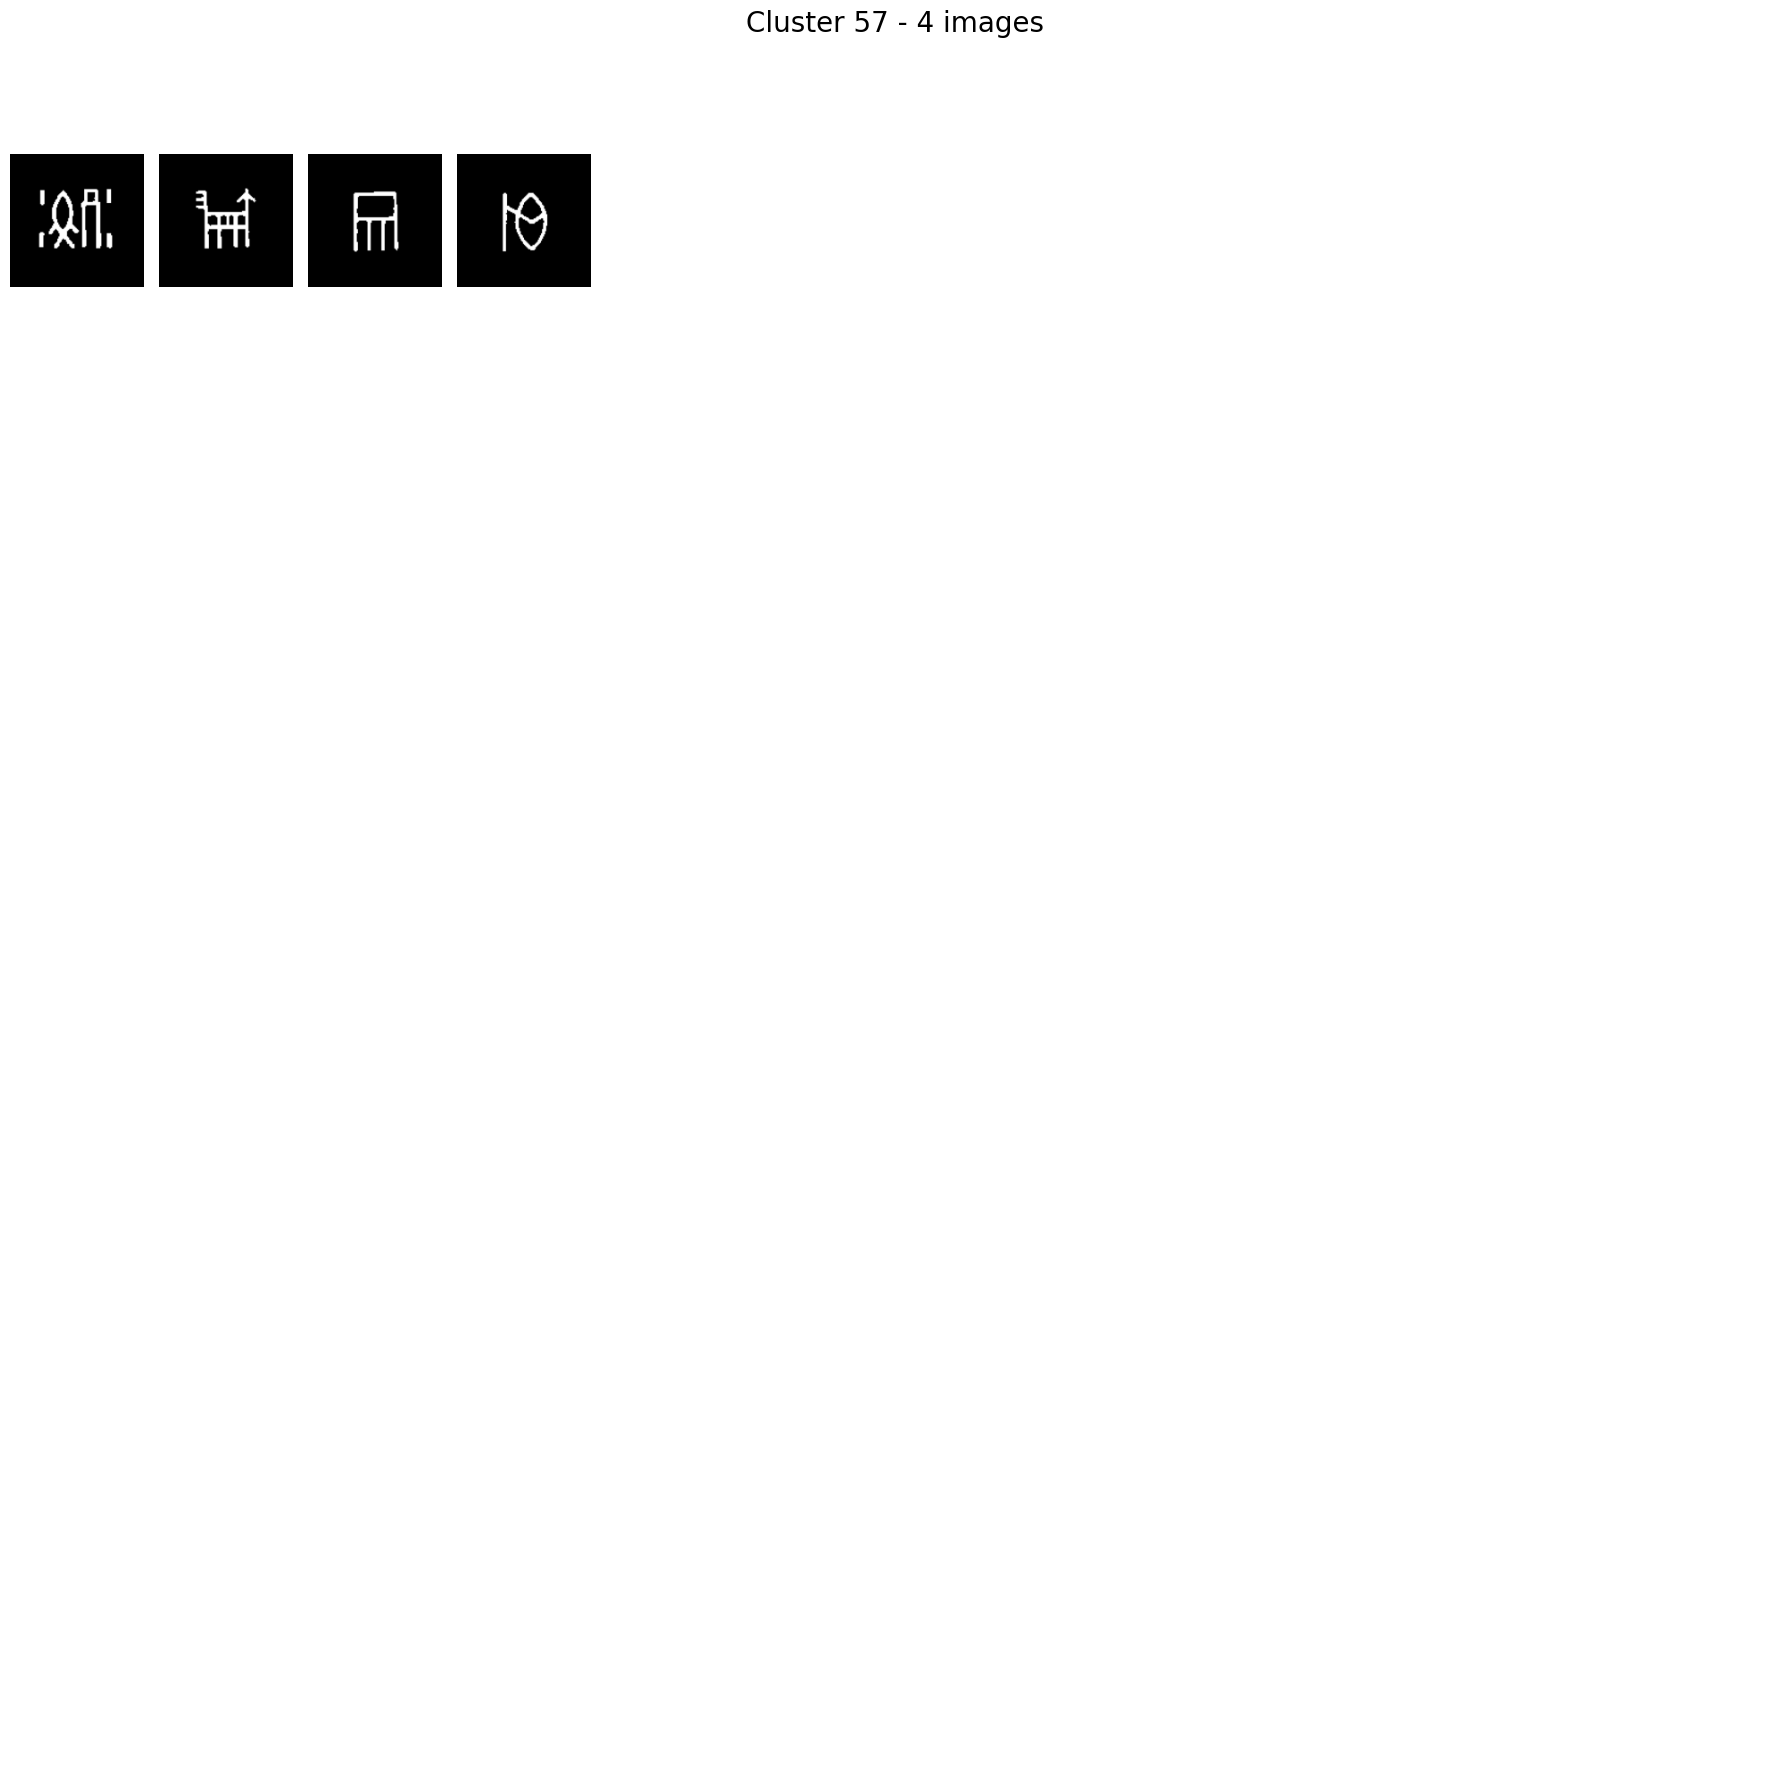

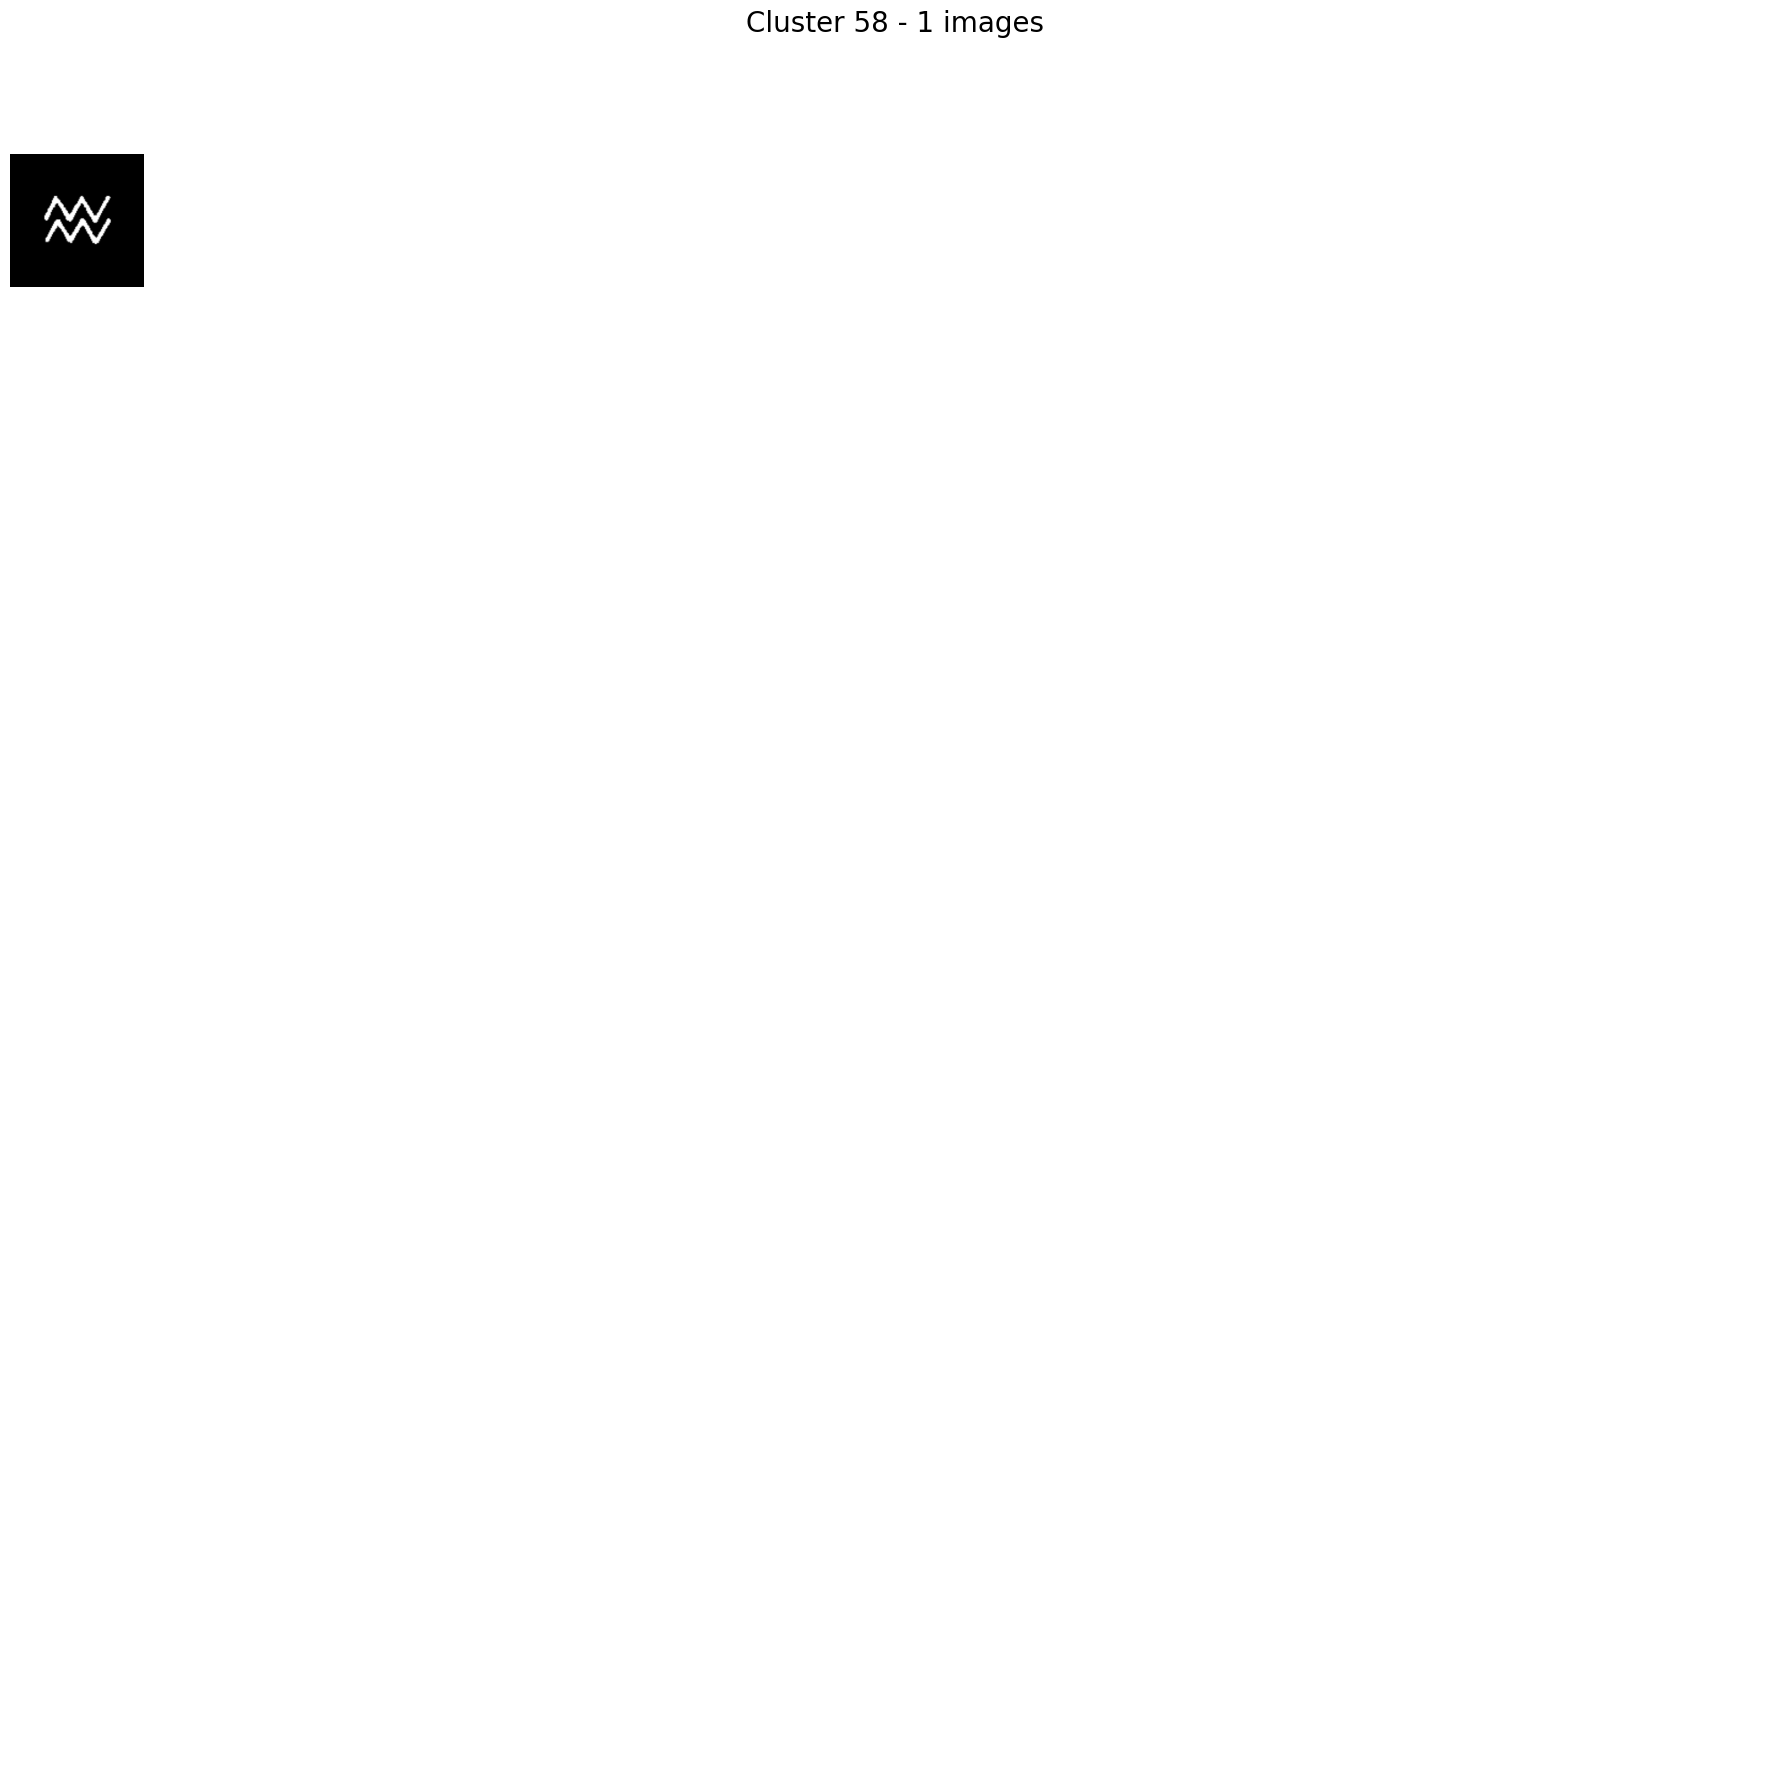

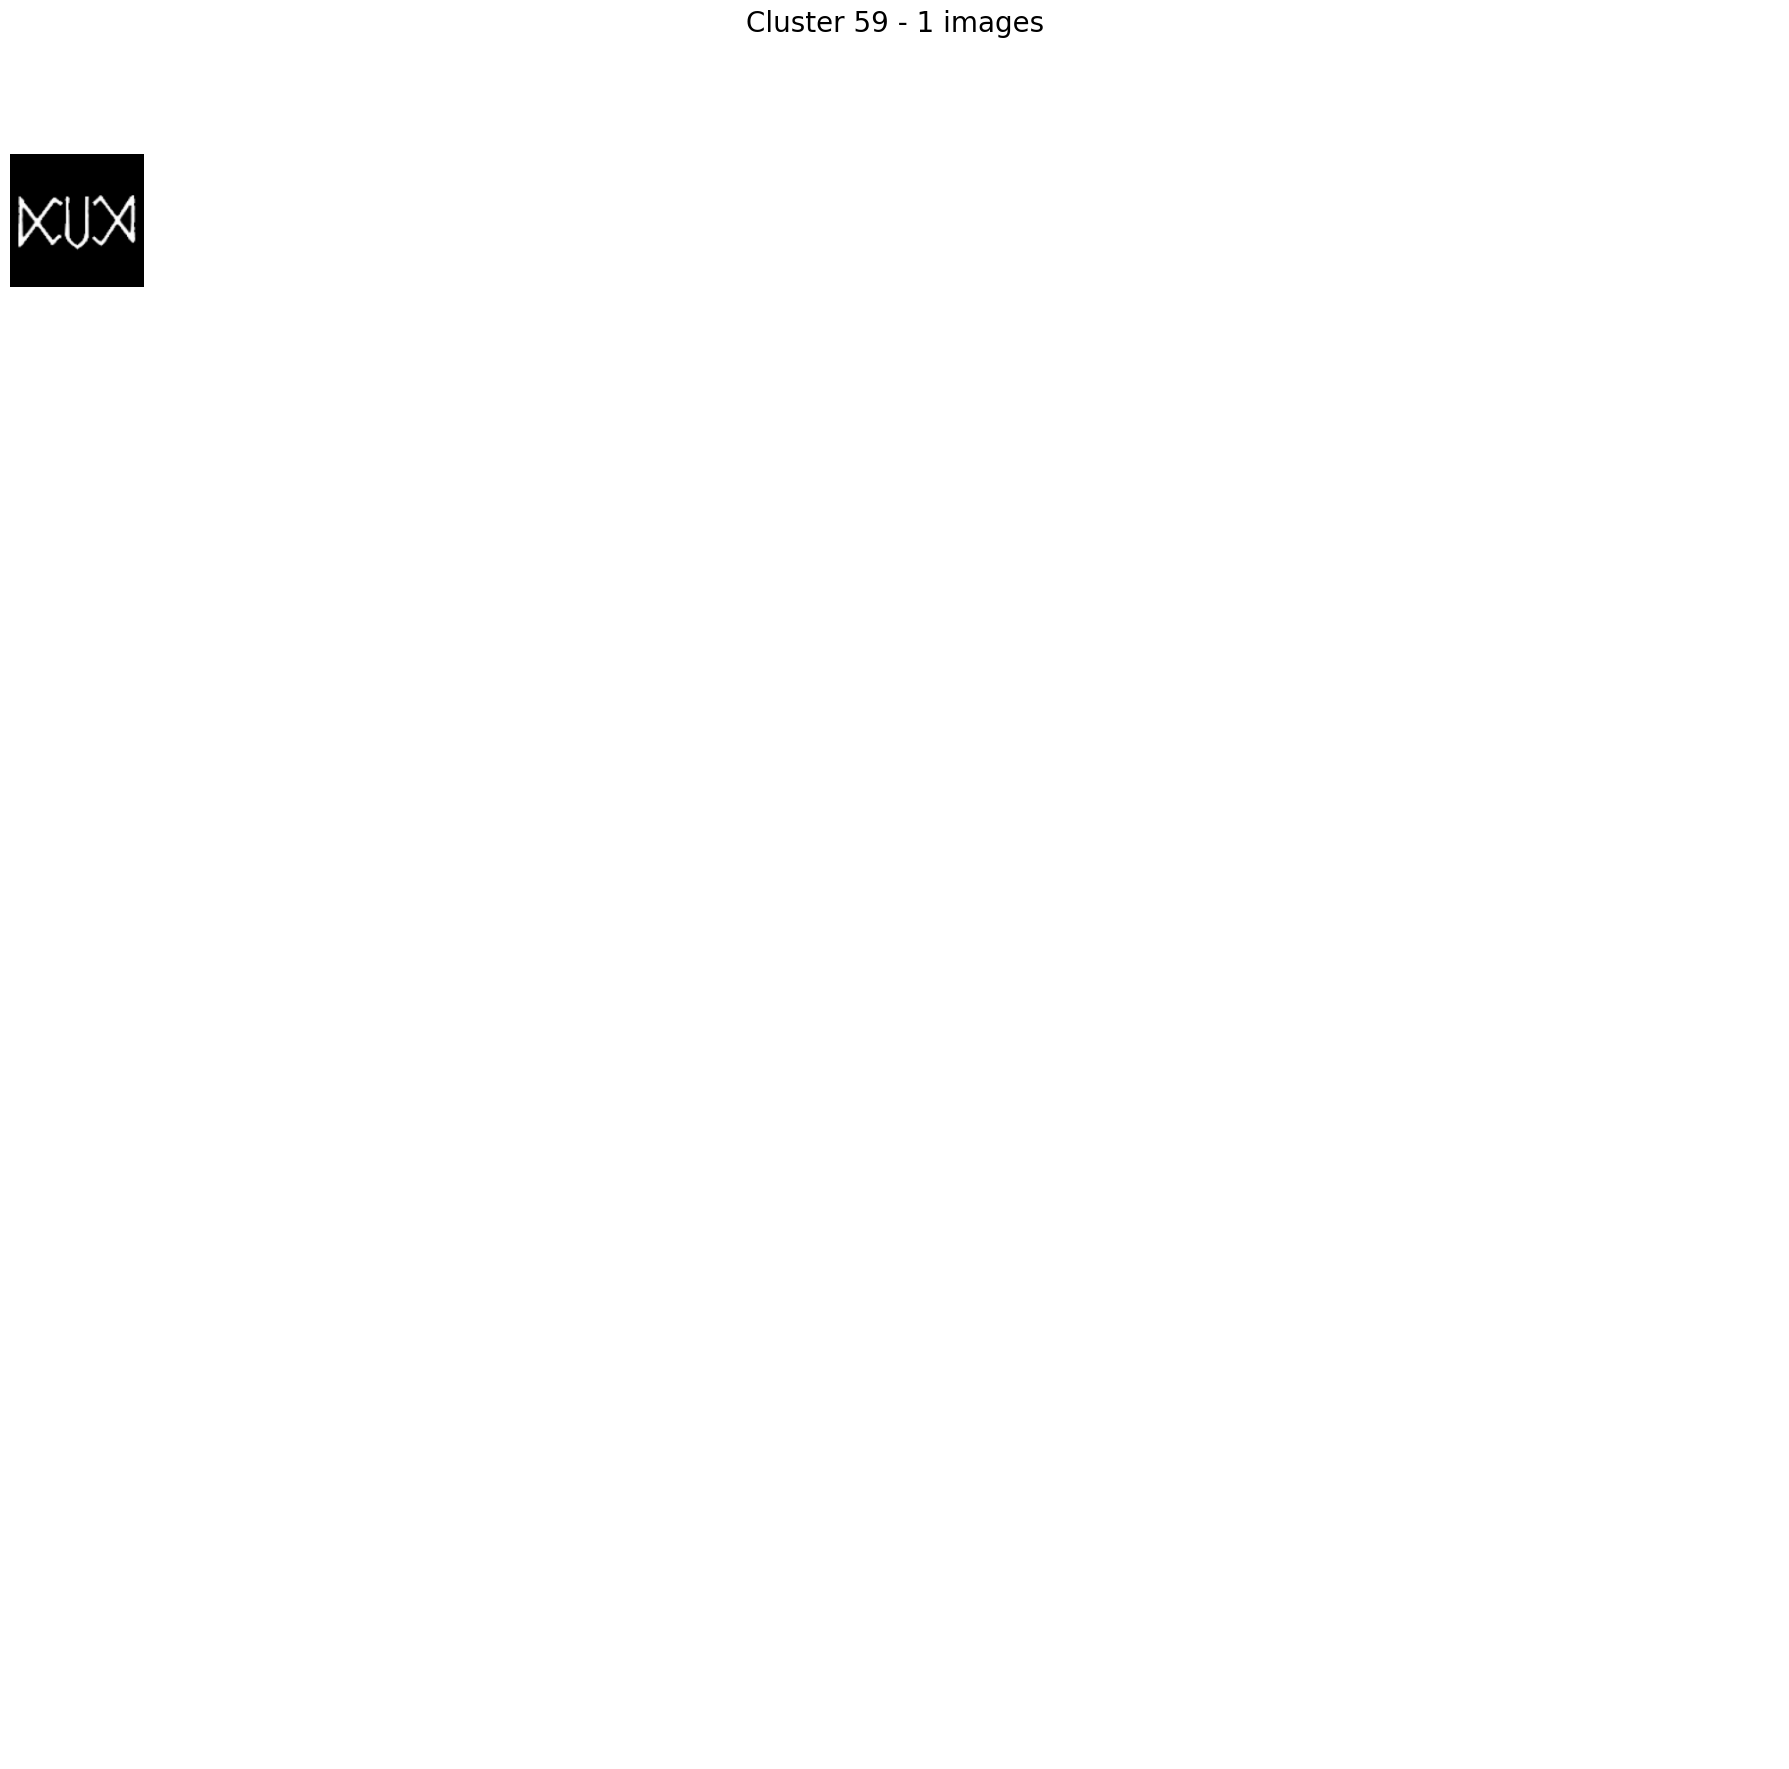

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display representative images for all clusters
def visualize_all_clusters(data, cluster_assignments, num_clusters=10, num_samples=122, image_size=(150, 150)):
    for cluster_num in range(num_clusters):
        cluster_indices = np.where(cluster_assignments == cluster_num)[0]
        num_images_in_cluster = len(cluster_indices)  # Count the number of images in the cluster

        # Display `num_samples` images from the cluster with an optimized figure size
        num_cols = 12  # Increased number of columns for 122 images
        num_rows = int(np.ceil(num_samples / num_cols))  # Dynamic rows to handle all samples
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 18))  # Adjusted figure size

        # Flatten axes to easily index them
        axes = axes.flatten()

        # Loop through the images and display
        for i, idx in enumerate(cluster_indices[:num_samples]):
            image_array = data.iloc[idx].values.astype(np.uint8).reshape(*image_size)
            axes[i].imshow(image_array, cmap='gray')
            axes[i].axis('off')

        # Hide any unused axes
        for j in range(i + 1, len(axes)):
            axes[j].axis('off')

        # Update title to show both cluster number and image count
        plt.suptitle(f"Cluster {cluster_num} - {num_images_in_cluster} images", fontsize=20)
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)  # Adjust space for the title
        plt.show()

# Call the function for all clusters
visualize_all_clusters(data, cluster_assignments, num_clusters=60)




,Image No,Image,Text Image,Symbolic Image,Description,Link,Time,Location
